In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout
from keras.models import Model

import omnifold8a as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
ngen_train = 100000
ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


#learning_rate_setval = 0.0005
#epochs_setval = 20


learning_rate_setval = 0.0005
epochs_setval = 40



#dropout_setval = 0.02

#dropout_setval = 0.10

dropout_setval = 0.0




do_bootstrap = False

n_boot_samples = 1000





batch_size_setval = int( ngen_true )



output_dir = 'bootstrap-toy-study8a-1d-1c'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : bootstrap-toy-study8a-1d-1c/config.txt

2024-07-08 17:23:12.858866

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  10000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

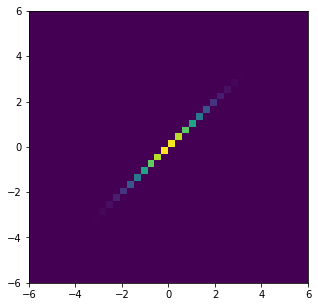

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

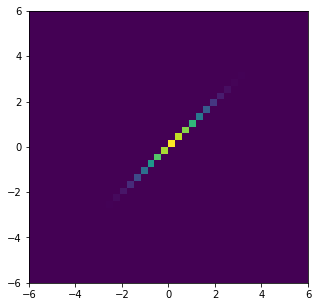

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

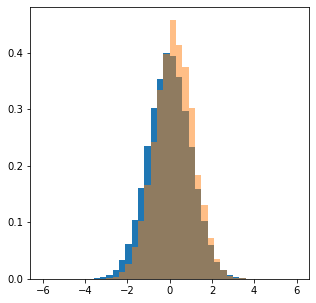

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-2.42859391]
 [ 0.99857828]
 [-0.11363733]
 ...
 [-1.17762017]
 [ 0.25032068]
 [ 0.36467693]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-2.62859391]
 [ 0.79857828]
 [-0.31363733]
 ...
 [-1.37762017]
 [ 0.05032068]
 [ 0.16467693]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.02955805 0.34268479 0.5605585  ... 0.28202499 0.54678743 0.52789411]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.00880768 0.42288152 0.58994519 ... 0.19426949 0.62589823 0.61647085]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_4)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(200, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(150, activation='relu')(inputs)
#hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(5, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(5, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)



inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
drop1 = Dropout(dropout_setval)(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu')(drop1)
drop2 = Dropout(dropout_setval)(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu')(drop2)
drop3 = Dropout(dropout_setval)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(drop3)








model_step1 = Model(inputs=inputs, outputs=outputs)
model_step2 = Model(inputs=inputs, outputs=outputs)

opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])


## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8a( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43240809 1.16689992 0.9981913  ... 0.74414277 1.1017133  1.11415458]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36870474 1.22137175 1.01514718 ... 0.6975117  1.13211066 1.14615498]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3610537  1.25439823 1.02626979 ... 0.70229298 1.17295506 1.17421789]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3397256  1.26995251 1.01231088 ... 0.68916562 1.19133897 1.18811292]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/of-step2-iter04-model/assets


CPU times: user 35.9 s, sys: 6.6 s, total: 42.5 s
Wall time: 28.7 s


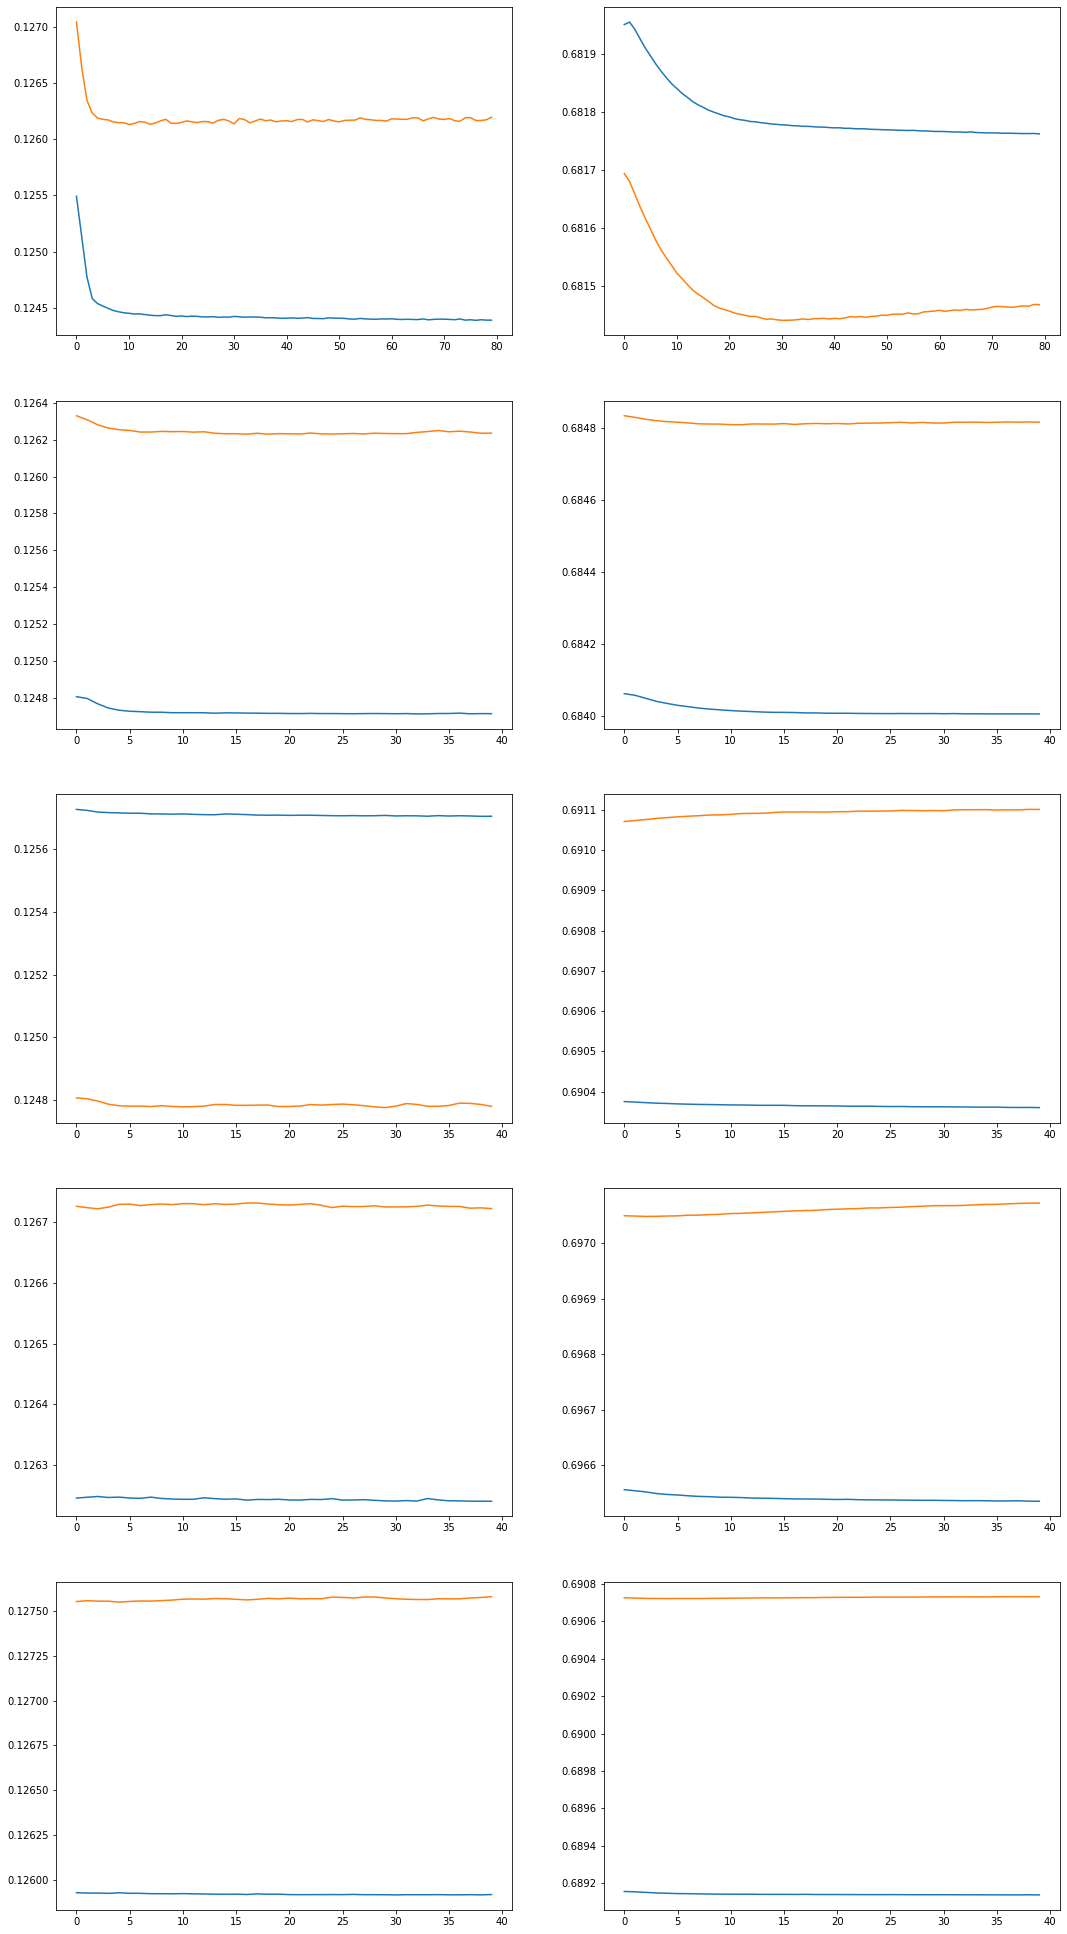

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

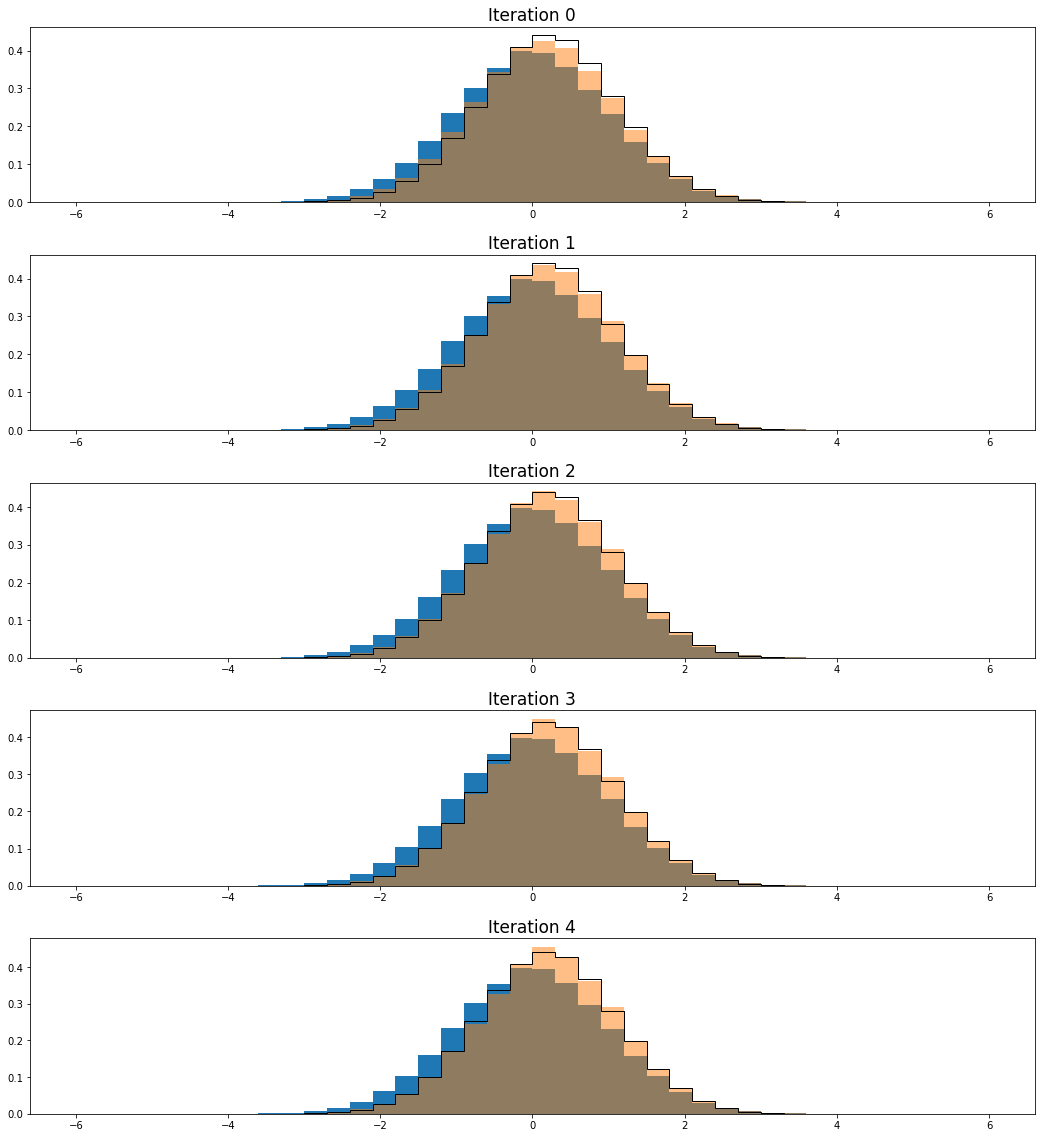

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

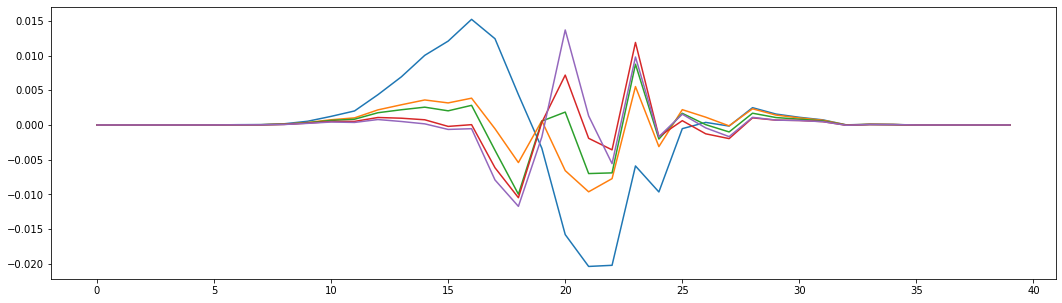

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

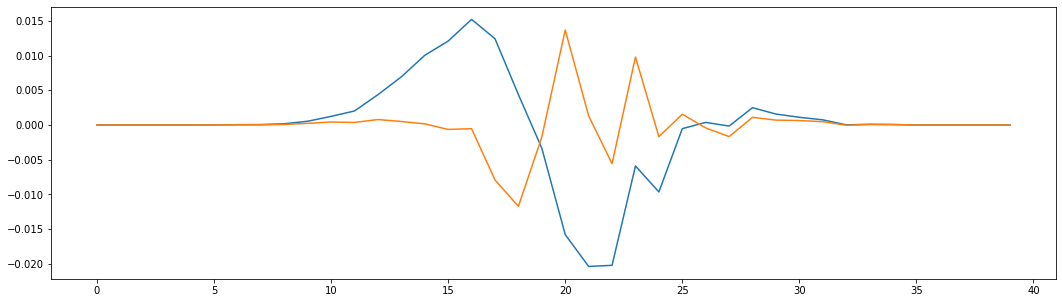

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

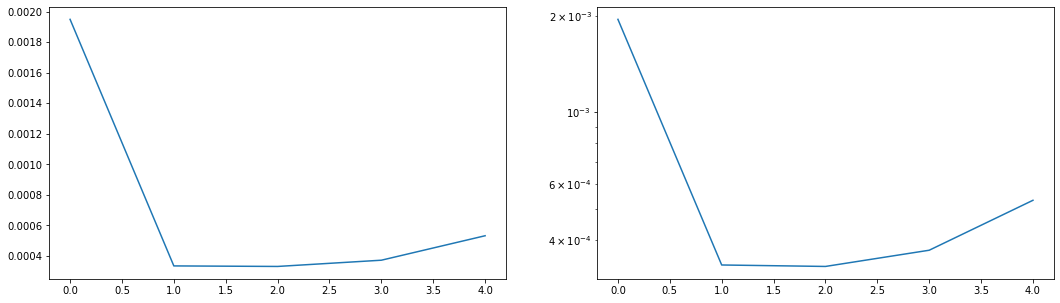

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

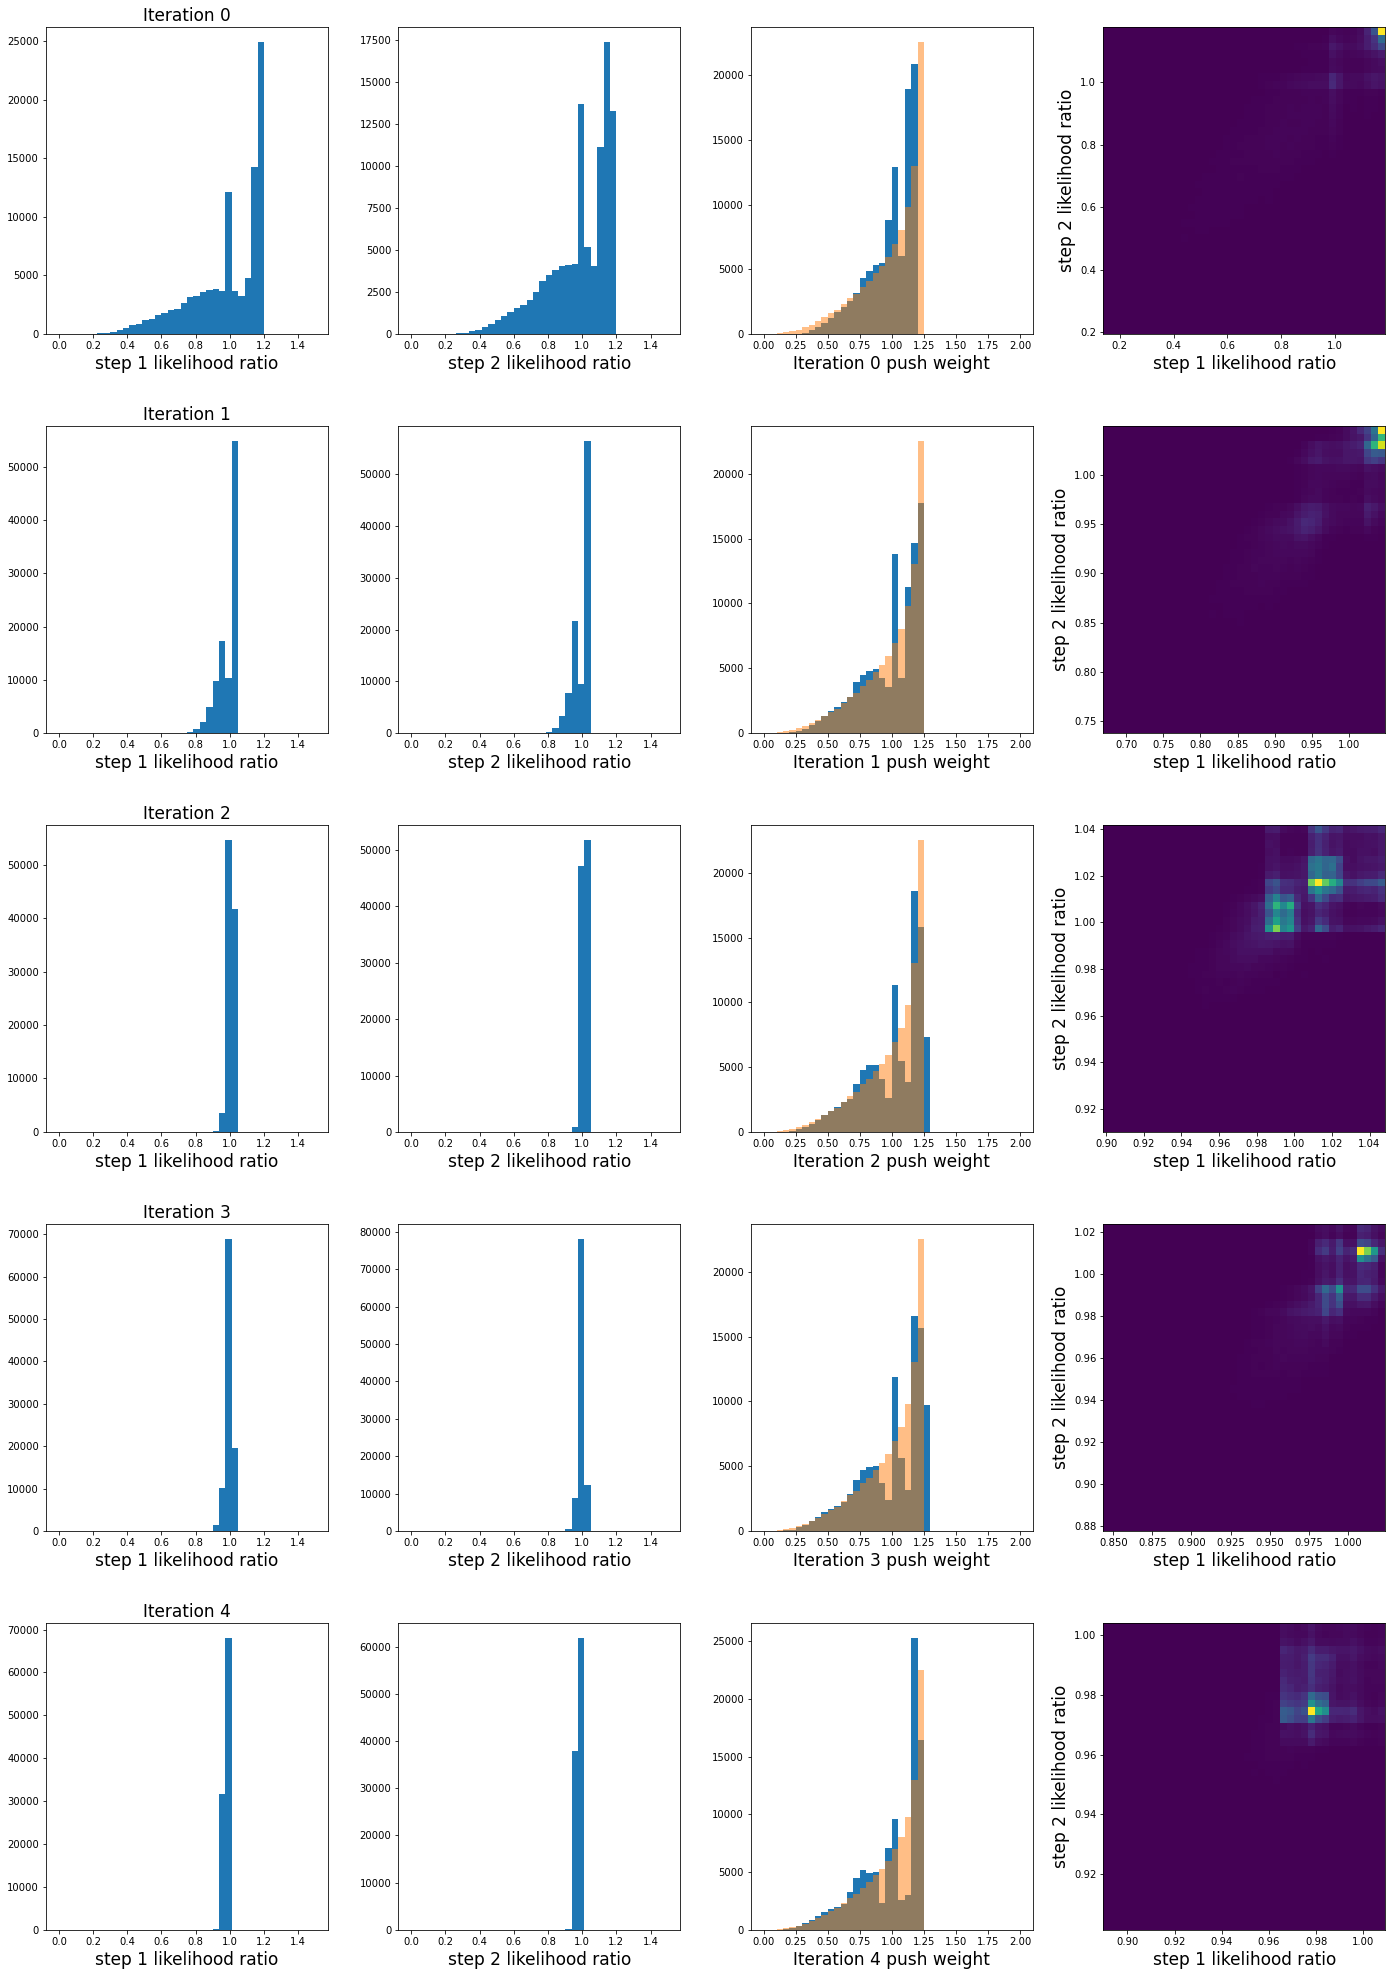

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

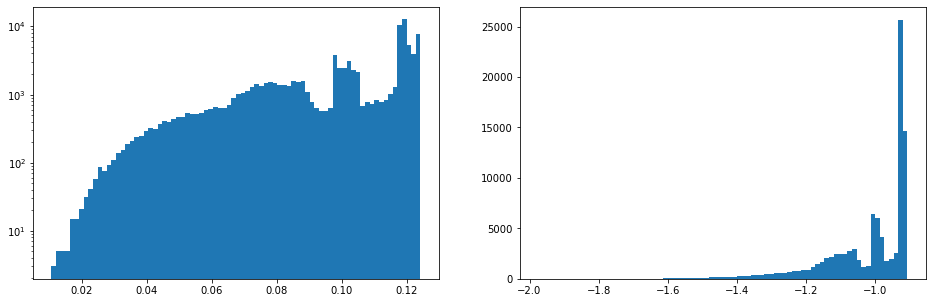

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

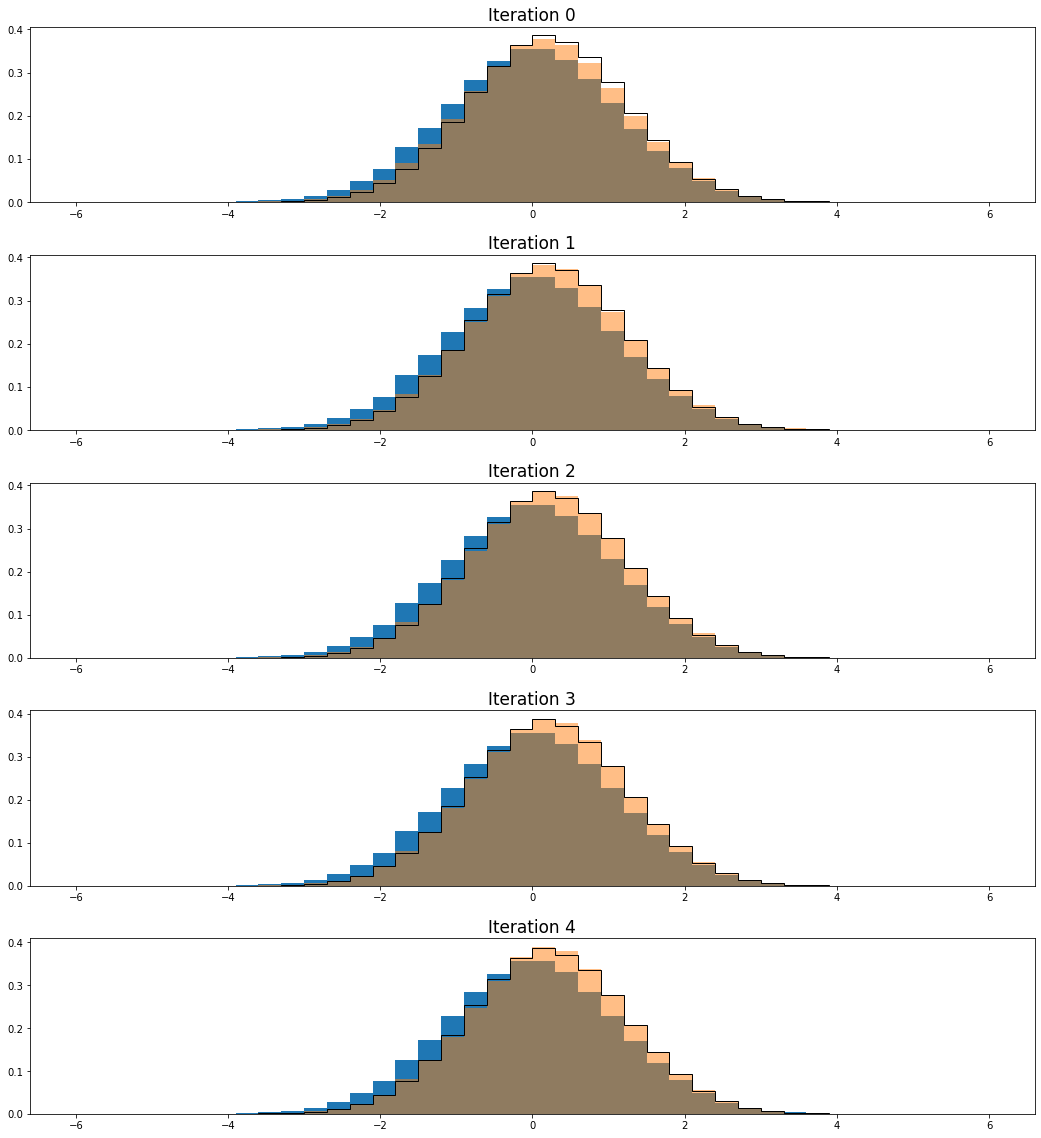

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

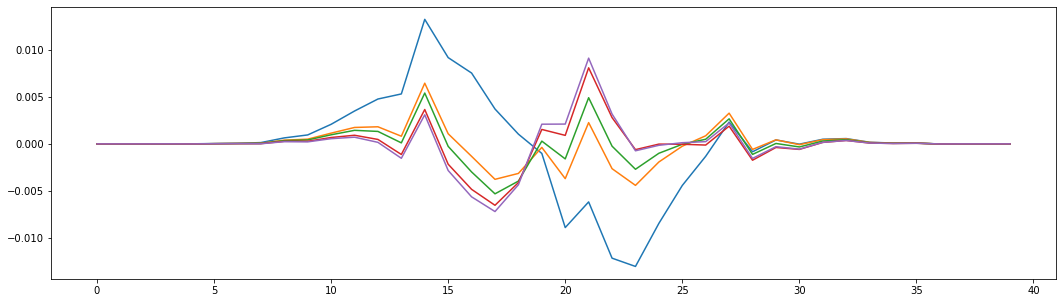

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

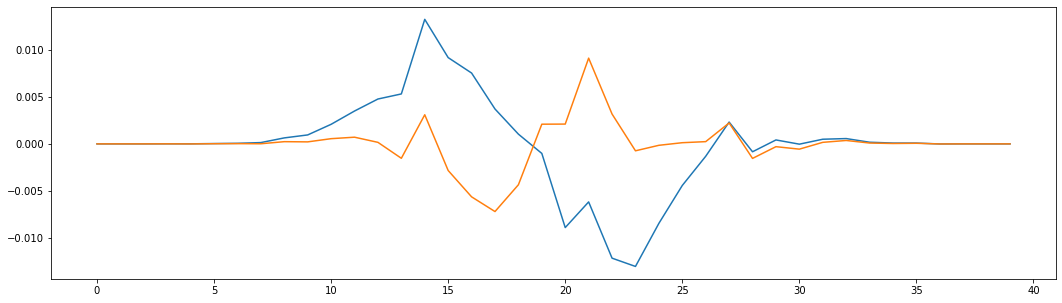

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

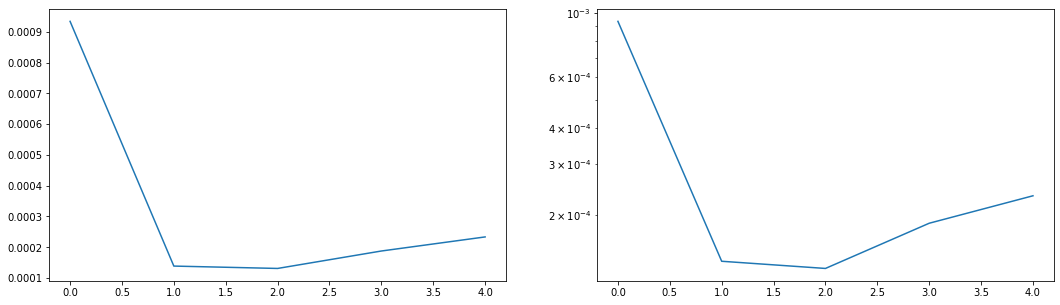

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.981  rms 0.209      step 2 mean  0.986  rms 0.184
  iter  1 : step 1 mean  0.993  rms 0.057      step 2 mean  0.996  rms 0.048
  iter  2 : step 1 mean  1.007  rms 0.019      step 2 mean  1.012  rms 0.014
  iter  3 : step 1 mean  0.996  rms 0.019      step 2 mean  0.996  rms 0.017
  iter  4 : step 1 mean  0.980  rms 0.011      step 2 mean  0.980  rms 0.010


<function matplotlib.pyplot.show(close=None, block=None)>

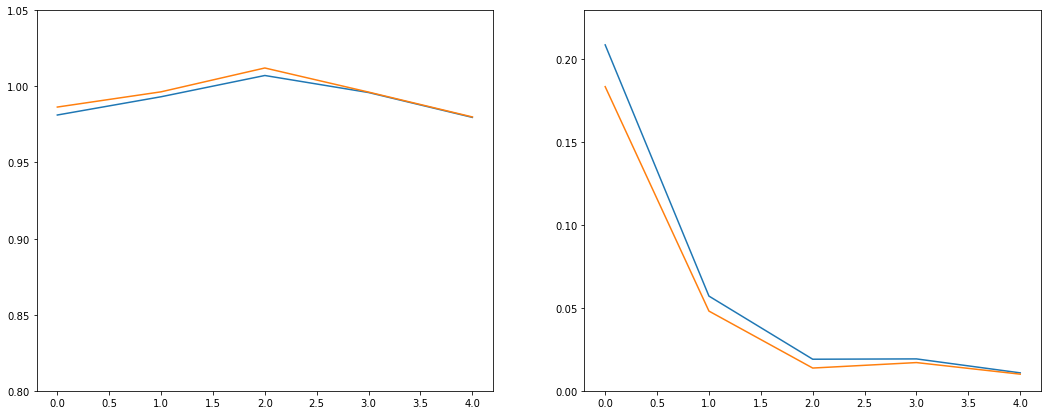

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

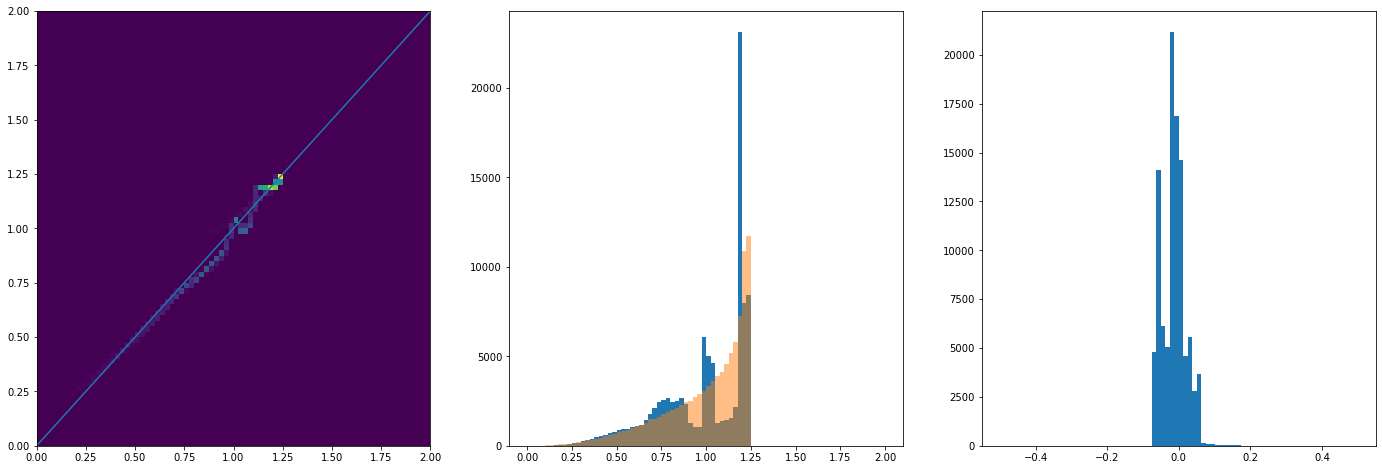

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.03318




In [56]:

verbose = False



import gc

In [57]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [58]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )
        
    boot_of_return_dict = of.omnifold8a( 
        train_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40365183 1.17900586 1.05634308 ... 0.75850964 1.09653354 1.12075794]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32193154 1.22604462 1.05171467 ... 0.67992834 1.09099833 1.12792089]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27543703 1.2084454  1.04358692 ... 0.62810357 1.08610883 1.12734722]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27547045 1.22762801 1.06259156 ... 0.62623448 1.08777413 1.13605423]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets




 bootstrap 0 final push weights scaled:
[0.02740118 0.1218788  0.10700474 ... 0.0624256  0.10928838 0.11484507]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47712481 1.16196144 0.98299825 ... 0.78485233 1.08220184 1.08937454]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38694839 1.18345284 0.97797323 ... 0.72746018 1.09343487 1.10351227]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37536227 1.22331022 0.97426168 ... 0.73937837 1.12660664 1.13584449]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3622672  1.21102164 0.95486148 ... 0.74174804 1.12296598 1.1290132 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets




 bootstrap 1 final push weights scaled:
[0.03443654 0.12346001 0.09394722 ... 0.07385079 0.11257622 0.11301454]

 Creating toy sample   2
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44453466 1.17613959 1.03841233 ... 0.81698591 1.0785104  1.11483681]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36139972 1.2270697  1.02943433 ... 0.77203254 1.07251776 1.11446875]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32382646 1.25040077 1.01736175 ... 0.75411096 1.06628341 1.11212439]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30591027 1.28083005 1.02154964 ... 0.77611802 1.05751695 1.11327143]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets




 bootstrap 2 final push weights scaled:
[0.02855089 0.12929595 0.09917862 ... 0.07791982 0.1039815  0.11103613]

 Creating toy sample   3
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45614779 1.19735062 1.0140425  ... 0.76961857 1.08611906 1.09430456]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36570083 1.2607301  1.03667995 ... 0.69008249 1.10038    1.11597734]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34239531 1.29866183 1.04451788 ... 0.66975068 1.11378995 1.13008702]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33962985 1.30459502 1.06779009 ... 0.66807519 1.10871784 1.12526214]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets




 bootstrap 3 final push weights scaled:
[0.03230159 0.1309687  0.10890087 ... 0.06797539 0.1103431  0.11170029]

 Creating toy sample   4
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42102191 1.19525862 1.04508793 ... 0.76383293 1.07053554 1.08209765]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29635069 1.27046568 1.03689409 ... 0.68322935 1.09212005 1.10475788]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25594022 1.28038832 1.03188521 ... 0.65034049 1.08653824 1.09789355]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2463132  1.30914063 1.05087776 ... 0.65100071 1.0956817  1.10711961]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets




 bootstrap 4 final push weights scaled:
[0.02315002 0.13551826 0.10621385 ... 0.06381486 0.11115546 0.11226447]

 Creating toy sample   5
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4294382  1.22481704 0.98879331 ... 0.77489728 1.06123519 1.08102071]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36001604 1.23393227 0.99888068 ... 0.73625263 1.07084178 1.0899015 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32755967 1.23423941 0.98681722 ... 0.71693881 1.06326863 1.08191389]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3138475  1.25507326 0.99151603 ... 0.71720196 1.08272803 1.10087026]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets




 bootstrap 5 final push weights scaled:
[0.0297794  0.12662536 0.09817721 ... 0.07042078 0.10909321 0.11083671]

 Creating toy sample   6
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42591137 1.17752051 1.01399028 ... 0.77143741 1.09639919 1.10682333]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35282973 1.2275945  1.01962231 ... 0.7188909  1.13743341 1.14837264]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3268492  1.24922043 1.01392138 ... 0.7085477  1.15039186 1.16139397]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31190845 1.26473969 1.00884338 ... 0.70940012 1.1647928  1.17136701]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets




 bootstrap 6 final push weights scaled:
[0.0288862  0.12773349 0.10236793 ... 0.06982532 0.11723859 0.11791043]

 Creating toy sample   7
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44015205 1.20344102 0.99353701 ... 0.78977287 1.07401145 1.10380709]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37208892 1.2523919  0.99065456 ... 0.74912817 1.08012178 1.12129659]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3405887  1.2783979  0.99069566 ... 0.73140924 1.08229281 1.13266607]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31323724 1.25860543 0.96923061 ... 0.70557823 1.0581829  1.1168348 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets




 bootstrap 7 final push weights scaled:
[0.03175758 0.12529546 0.09750099 ... 0.07232225 0.10521445 0.11172044]

 Creating toy sample   8
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42606881 1.14836693 0.97532755 ... 0.78014892 1.09209442 1.09158921]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36733716 1.19170957 0.94930896 ... 0.74733678 1.13302976 1.13291812]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33275666 1.19166837 0.94151875 ... 0.73218301 1.13374508 1.13249027]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31301935 1.20107233 0.90383738 ... 0.72421363 1.14543216 1.14278495]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets




 bootstrap 8 final push weights scaled:
[0.03041221 0.11924099 0.0883522  ... 0.07207924 0.11408863 0.11353417]

 Creating toy sample   9
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50922346 1.14885533 1.07685852 ... 0.75524223 1.1073283  1.1073283 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42198156 1.19020469 1.1028657  ... 0.67807671 1.14718302 1.14718302]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39452413 1.20145023 1.15655616 ... 0.67312827 1.15802208 1.15802208]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3513268  1.17496653 1.16789023 ... 0.6516022  1.13249567 1.13249567]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets




 bootstrap 9 final push weights scaled:
[0.03475752 0.11968432 0.11831451 ... 0.06714966 0.11535815 0.11535815]

 Creating toy sample  10
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45794076 1.15543246 1.02844727 ... 0.78894031 1.07764781 1.09074044]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3806159  1.21244826 1.03048219 ... 0.7333335  1.11336459 1.13405965]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3463524  1.22017829 1.04070728 ... 0.72083181 1.11935108 1.13969614]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32907469 1.24228929 1.03731555 ... 0.70308368 1.12204811 1.14333168]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets




 bootstrap 10 final push weights scaled:
[0.03092065 0.12298475 0.1040841  ... 0.06948789 0.11207829 0.11405563]

 Creating toy sample  11
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44159409 1.18033934 1.03929365 ... 0.79754484 1.1142782  1.12660336]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38444242 1.18003266 1.04283762 ... 0.76038753 1.12324305 1.13474876]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35799233 1.18970533 1.05180366 ... 0.74168112 1.14242196 1.15305912]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33596178 1.21794234 1.07572293 ... 0.72854742 1.17630277 1.18999557]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets




 bootstrap 11 final push weights scaled:
[0.03222811 0.12150637 0.10599507 ... 0.07114028 0.11598844 0.1182781 ]

 Creating toy sample  12
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45579198 1.17502558 0.99889296 ... 0.76749337 1.12003863 1.15280223]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3929916  1.21544925 0.9877846  ... 0.72216957 1.15044838 1.19027562]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3707164  1.23962824 0.99647925 ... 0.71928752 1.17755739 1.22645919]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3452336  1.23513802 0.98847919 ... 0.70304384 1.18541787 1.24554279]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets




 bootstrap 12 final push weights scaled:
[0.03274444 0.12408816 0.09764972 ... 0.06967805 0.11908403 0.12604242]

 Creating toy sample  13
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46656084 1.15757382 0.98233843 ... 0.76493138 1.07156122 1.10357654]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38382788 1.21616975 0.98296704 ... 0.72780193 1.12029456 1.15780285]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33957484 1.22132736 0.98816685 ... 0.70209702 1.12656911 1.16371028]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32212836 1.21037676 0.99474991 ... 0.70238017 1.11760798 1.15601998]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets




 bootstrap 13 final push weights scaled:
[0.03005505 0.12412137 0.09954695 ... 0.06930643 0.11406781 0.11861587]

 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4775486  1.18826938 1.000893   ... 0.78234571 1.0867945  1.09180379]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37206435 1.26736898 1.02347553 ... 0.72454376 1.14068124 1.14727871]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33074948 1.27095099 1.0037997  ... 0.68539869 1.13452163 1.14008583]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31311688 1.28751109 1.01456858 ... 0.68461546 1.13303873 1.13708516]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets




 bootstrap 14 final push weights scaled:
[0.03117815 0.13254552 0.09899956 ... 0.06700913 0.11228659 0.1138236 ]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41429052 1.14604259 1.02701867 ... 0.75570184 1.0850395  1.08640671]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35726606 1.20481195 1.06760316 ... 0.72138093 1.12988687 1.13201319]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32425223 1.17771756 1.06383857 ... 0.69381428 1.11044589 1.10877661]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30886721 1.20016614 1.10032719 ... 0.69152092 1.13721512 1.13207787]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets




 bootstrap 15 final push weights scaled:
[0.02963802 0.11906055 0.11092885 ... 0.06814084 0.11328317 0.11237623]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44712597 1.14744902 1.04715681 ... 0.77661479 1.08594131 1.10326362]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4050552  1.17875905 1.06025681 ... 0.75013861 1.09966994 1.12238889]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36527522 1.19892564 1.0772959  ... 0.73546203 1.11027415 1.13972137]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33919331 1.21583587 1.09865777 ... 0.73162454 1.11907311 1.1480991 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets




 bootstrap 16 final push weights scaled:
[0.03098492 0.11932652 0.10872044 ... 0.07055092 0.10931567 0.11209622]

 Creating toy sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50074911 1.17547655 1.04466891 ... 0.7853021  1.10221148 1.11480379]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41054807 1.22722894 1.05843941 ... 0.72742837 1.14244624 1.15488053]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37668953 1.22047609 1.04748729 ... 0.70544963 1.14966037 1.15623385]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36355081 1.22983734 1.03339    ... 0.70875864 1.17875407 1.17855355]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets




 bootstrap 17 final push weights scaled:
[0.03524842 0.12392651 0.10527804 ... 0.071885   0.11990482 0.11900203]

 Creating toy sample  18
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47605577 1.1752069  1.01283467 ... 0.75016057 1.08547056 1.11481571]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40123936 1.24625105 1.02351092 ... 0.71506034 1.13173869 1.17605437]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35876407 1.27984495 1.03516014 ... 0.6924588  1.17222145 1.22304392]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35018081 1.26276022 1.00590368 ... 0.67358873 1.14880814 1.20348663]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets




 bootstrap 18 final push weights scaled:
[0.03430394 0.12882791 0.10167451 ... 0.06796469 0.11657744 0.12273563]

 Creating toy sample  19
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40635306 1.16562104 1.02131402 ... 0.76409006 1.10003984 1.12533987]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35440305 1.21360897 1.02188637 ... 0.72428611 1.11534093 1.16110035]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32542695 1.24270135 1.03965541 ... 0.70988627 1.12478009 1.17659829]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30785261 1.25474911 1.03462482 ... 0.69054547 1.12162006 1.18078439]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets




 bootstrap 19 final push weights scaled:
[0.0296405  0.12744807 0.10405101 ... 0.06754259 0.1135399  0.12041387]

 Creating toy sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4226048  1.20206726 1.03342962 ... 0.79763728 1.11893976 1.13409424]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3562533  1.2334447  1.00382687 ... 0.73971474 1.11400013 1.13555339]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33713153 1.26189745 1.03155001 ... 0.7449287  1.14010234 1.16220962]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31427076 1.27564629 1.02966586 ... 0.73334229 1.14258298 1.16642821]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets




 bootstrap 20 final push weights scaled:
[0.03030116 0.12707323 0.10310213 ... 0.07296147 0.11369882 0.11608347]

 Creating toy sample  21
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44525045 1.16112399 1.04354048 ... 0.78817636 1.0704267  1.12027168]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36918441 1.22840008 1.05804126 ... 0.74772718 1.1096856  1.17611521]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32602331 1.23553374 1.04942713 ... 0.72381506 1.10491904 1.18446533]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31187565 1.26504271 1.0613453  ... 0.72894145 1.11981988 1.21231251]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets




 bootstrap 21 final push weights scaled:
[0.03027027 0.12690614 0.105929   ... 0.07216487 0.11143611 0.12188057]

 Creating toy sample  22
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41254893 1.18460667 1.02882469 ... 0.77248949 1.09404969 1.13809705]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36405225 1.2287151  1.04479472 ... 0.74978567 1.13095998 1.18110228]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31878063 1.20391467 1.03576004 ... 0.71361346 1.12683931 1.17447025]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29939743 1.21222421 1.04983884 ... 0.70142561 1.14407274 1.19110247]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets




 bootstrap 22 final push weights scaled:
[0.028195   0.12020497 0.10424495 ... 0.06885735 0.11382992 0.11851467]

 Creating toy sample  23
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47653154 1.18130314 1.02198231 ... 0.76519346 1.0844605  1.09652519]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42504827 1.21383845 1.02736158 ... 0.72966581 1.10877066 1.12314067]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39167206 1.23505955 1.03025031 ... 0.70552883 1.12593091 1.14148691]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37633806 1.23720308 1.04317172 ... 0.70454008 1.14189722 1.1579808 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets




 bootstrap 23 final push weights scaled:
[0.03577443 0.1250332  0.10473539 ... 0.0691528  0.11519025 0.11687669]

 Creating toy sample  24
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


 weights_push at the beginning
[0.36416367 1.1817888  1.00964093 ... 0.75300604 1.10132813 1.12599182]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32248339 1.22135994 1.0238288  ... 0.72561196 1.127135   1.15458226]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2986643  1.23737042 1.03468209 ... 0.7164913  1.14163782 1.17008665]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28597082 1.27249972 1.05768039 ... 0.70960245 1.17004958 1.1999807 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets




 bootstrap 24 final push weights scaled:
[0.02710089 0.12539225 0.10443504 ... 0.06960707 0.11549336 0.1184391 ]

 Creating toy sample  25
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41041002 1.18855369 1.03241897 ... 0.73996902 1.0679028  1.1007216 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35277277 1.18929216 1.02811895 ... 0.70823451 1.05882005 1.09254243]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32216264 1.21590072 1.04950296 ... 0.69090665 1.07562829 1.10872034]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29723381 1.21741903 1.05179498 ... 0.66398536 1.07081326 1.10295034]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets




 bootstrap 25 final push weights scaled:
[0.02848021 0.12404678 0.10639366 ... 0.06552256 0.10710058 0.10992399]

 Creating toy sample  26
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42115125 1.17383516 1.04780126 ... 0.7678926  1.08750689 1.08982193]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36357587 1.1909357  1.06452951 ... 0.74937329 1.09998263 1.10109755]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3238464  1.19022783 1.06440921 ... 0.73767648 1.09714816 1.09778085]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29217654 1.19273737 1.06467923 ... 0.72613371 1.09430373 1.09333305]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets




 bootstrap 26 final push weights scaled:
[0.02852016 0.12297657 0.10847891 ... 0.07314629 0.11128501 0.11109932]

 Creating toy sample  27
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4123106  1.21220231 1.04688811 ... 0.71236861 1.08054638 1.08869386]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36212284 1.21549545 1.04620197 ... 0.69242853 1.0811156  1.08984645]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33489843 1.24937312 1.06332012 ... 0.68319183 1.10031006 1.11099117]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30660975 1.27829398 1.06588164 ... 0.66287616 1.10286402 1.11112625]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets




 bootstrap 27 final push weights scaled:
[0.0296795  0.12672438 0.10595596 ... 0.06515972 0.10949239 0.10998932]

 Creating toy sample  28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42142233 1.16729295 1.00422156 ... 0.77844435 1.10472882 1.13350856]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37674498 1.21168082 1.01321185 ... 0.74593979 1.12065154 1.15987424]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34489779 1.19192491 1.0100499  ... 0.72174265 1.11746243 1.16260323]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32205586 1.19540466 1.01326646 ... 0.70868946 1.12367103 1.17684076]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets




 bootstrap 28 final push weights scaled:
[0.03039301 0.11896395 0.10254422 ... 0.07025711 0.11402199 0.12009981]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4316169  1.17375231 1.01553595 ... 0.76040608 1.10990584 1.1235429 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3772906  1.2404749  1.02528296 ... 0.72258886 1.13422488 1.15585233]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33683912 1.25886463 1.01866237 ... 0.69116162 1.13404262 1.15945894]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31433187 1.26382874 1.02365331 ... 0.68453711 1.13635718 1.15780751]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets




 bootstrap 29 final push weights scaled:
[0.03039536 0.12806564 0.10382641 ... 0.06890042 0.11501397 0.11672064]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42786276 1.1941129  1.03747368 ... 0.76311713 1.10358524 1.12574542]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36187206 1.21349177 1.04978332 ... 0.71609877 1.13264566 1.16278349]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32349138 1.18638164 1.05252886 ... 0.69185715 1.13557024 1.16585754]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31312689 1.18976318 1.07134352 ... 0.69939058 1.15609511 1.18754692]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets




 bootstrap 30 final push weights scaled:
[0.03036847 0.1185043  0.10695728 ... 0.06951789 0.11549237 0.11877205]

 Creating toy sample  31
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39705971 1.15344882 1.00768292 ... 0.73630756 1.1016351  1.11085725]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35242222 1.20775282 1.02552451 ... 0.72268502 1.14211239 1.15309961]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31593423 1.22549433 1.02754436 ... 0.7059554  1.15184048 1.16363318]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30266236 1.23219184 1.03616785 ... 0.69891466 1.16292895 1.17538352]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets




 bootstrap 31 final push weights scaled:
[0.02889347 0.12237922 0.10275852 ... 0.06848406 0.11510163 0.11632103]

 Creating toy sample  32
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53655946 1.18752861 0.979325   ... 0.76185715 1.06784678 1.10500789]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43511844 1.22117975 0.98106881 ... 0.70950139 1.07934554 1.11954952]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40269943 1.24738736 0.99154203 ... 0.71468008 1.09202435 1.13408672]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37606374 1.26875408 0.99000352 ... 0.71162064 1.0932936  1.13756431]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets




 bootstrap 32 final push weights scaled:
[0.03683143 0.12630856 0.09896268 ... 0.07154006 0.1091242  0.11353029]

 Creating toy sample  33
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49533769 1.21330106 1.00544405 ... 0.7788294  1.07551992 1.09486806]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40371457 1.26200576 0.99705847 ... 0.73727701 1.07587968 1.09774848]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37500871 1.2750007  0.99494843 ... 0.72483307 1.0761108  1.09702245]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36154158 1.31090515 1.00698112 ... 0.72119167 1.0929045  1.1135157 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets




 bootstrap 33 final push weights scaled:
[0.03397999 0.12839114 0.09896496 ... 0.07006254 0.10740299 0.10923955]

 Creating toy sample  34
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51760077 1.19003117 1.02443945 ... 0.77061111 1.09216011 1.11713052]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45331461 1.22493835 1.01951956 ... 0.73146299 1.10641262 1.13404207]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41384973 1.23521757 1.01403293 ... 0.70416212 1.11157406 1.14009243]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38772422 1.26326696 1.02382873 ... 0.69189209 1.1300107  1.15942394]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets




 bootstrap 34 final push weights scaled:
[0.03743182 0.12649777 0.10241773 ... 0.06837693 0.11316089 0.11607806]

 Creating toy sample  35
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42699808 1.1433996  1.03995693 ... 0.75669301 1.08198059 1.09512997]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33767875 1.183198   1.04439886 ... 0.69986734 1.09612425 1.11155586]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31731499 1.20953325 1.06314426 ... 0.6933912  1.11645243 1.1316667 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29166972 1.22384142 1.08339957 ... 0.68278188 1.13581898 1.15000328]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets




 bootstrap 35 final push weights scaled:
[0.02775249 0.11986959 0.10792553 ... 0.06709305 0.11253941 0.11368477]

 Creating toy sample  36
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44229802 1.21216142 1.03413749 ... 0.79594678 1.11121106 1.12736297]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37215331 1.24591886 1.02369281 ... 0.73403182 1.1134565  1.13589875]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34905999 1.27160063 1.0364086  ... 0.72224834 1.13188667 1.15725543]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32472934 1.27907324 1.02397767 ... 0.69764645 1.12232185 1.14762413]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets




 bootstrap 36 final push weights scaled:
[0.03121524 0.12926514 0.10343572 ... 0.0693429  0.11358362 0.11604691]

 Creating toy sample  37
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48569953 1.17956316 1.02989888 ... 0.76047009 1.12808883 1.14731658]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40919186 1.21403181 1.00907993 ... 0.69679223 1.14224567 1.16853574]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37055376 1.25037357 1.02759908 ... 0.67341732 1.16686032 1.19407158]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34309035 1.25172655 1.02789822 ... 0.65596935 1.16671955 1.19463284]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets




 bootstrap 37 final push weights scaled:
[0.03292089 0.12437741 0.10286729 ... 0.06538447 0.11656979 0.11932281]

 Creating toy sample  38
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45369974 1.13311422 1.03103471 ... 0.77999932 1.09363186 1.11111653]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3998281  1.16094253 1.02621815 ... 0.74275974 1.11050214 1.13486168]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36457516 1.18529011 1.03579843 ... 0.73365088 1.13631269 1.16117049]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33529177 1.18792291 1.0558907  ... 0.74008596 1.16220447 1.18677806]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets




 bootstrap 38 final push weights scaled:
[0.03053694 0.11803298 0.10458702 ... 0.07272443 0.1155393  0.11812784]

 Creating toy sample  39
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47047058 1.16340327 1.05100465 ... 0.77773792 1.11337078 1.13201034]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38537713 1.18053754 1.02278901 ... 0.70777708 1.10980083 1.13857723]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36006022 1.20517997 1.03740379 ... 0.68825012 1.14235898 1.17635019]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34581187 1.2211644  1.05006036 ... 0.67730398 1.16656984 1.20220853]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets




 bootstrap 39 final push weights scaled:
[0.03407141 0.12236942 0.10612418 ... 0.067633   0.11774786 0.12129727]

 Creating toy sample  40
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45688733 1.2200824  1.02774262 ... 0.7478779  1.12235117 1.13849115]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4020931  1.26733244 1.02443878 ... 0.70448304 1.13705266 1.15585474]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37437793 1.27161701 1.02377468 ... 0.67842418 1.13955812 1.15786659]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35987418 1.25822029 1.01556195 ... 0.66602434 1.12459415 1.14150518]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets




 bootstrap 40 final push weights scaled:
[0.03451938 0.12855885 0.10134516 ... 0.06570939 0.11279563 0.11455008]

 Creating toy sample  41
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


 weights_push at the beginning
[0.55088896 1.22031772 1.02714455 ... 0.75979972 1.08623993 1.10758221]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


 weights_push at the beginning
[0.48190782 1.2481082  1.00860476 ... 0.71486066 1.07886853 1.10214023]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


 weights_push at the beginning
[0.42230885 1.28373488 1.03086376 ... 0.69504644 1.10912289 1.13304417]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


 weights_push at the beginning
[0.4097168  1.2942986  1.03774183 ... 0.6884299  1.11786618 1.14109525]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets




 bootstrap 41 final push weights scaled:
[0.0398768  0.12975769 0.10322291 ... 0.06772916 0.11129873 0.11354789]

 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5276739  1.20745027 1.04093516 ... 0.75782537 1.0963192  1.11395049]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


 weights_push at the beginning
[0.46530218 1.23763448 1.04897626 ... 0.72338639 1.11261642 1.1299558 ]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


 weights_push at the beginning
[0.43348074 1.25743033 1.04831745 ... 0.70069002 1.11622168 1.13335054]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


 weights_push at the beginning
[0.41962328 1.27620168 1.05882373 ... 0.6948638  1.12756393 1.14415185]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets




 bootstrap 42 final push weights scaled:
[0.03978785 0.12942227 0.10589873 ... 0.06786401 0.11301743 0.11464625]

 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41151685 1.19094956 1.01304889 ... 0.79302132 1.07479942 1.09384561]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35934105 1.22358898 1.00839811 ... 0.74554687 1.07428352 1.09580299]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34236693 1.23352007 1.03365901 ... 0.7488152  1.09915609 1.12069295]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31149545 1.23483159 1.02183878 ... 0.72184275 1.08872758 1.11127563]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets




 bootstrap 43 final push weights scaled:
[0.03005025 0.12609668 0.10385629 ... 0.0726423  0.11078676 0.11316967]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44281402 1.19948876 1.02289891 ... 0.78120506 1.10314572 1.11466277]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37999674 1.2292699  1.02291964 ... 0.73858134 1.1305973  1.15510795]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34647429 1.2334973  1.00386853 ... 0.70475324 1.13470869 1.1671586 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32881922 1.23256599 0.99916321 ... 0.68964671 1.14830622 1.17742837]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets




 bootstrap 44 final push weights scaled:
[0.03320602 0.12253638 0.09978809 ... 0.07009098 0.1176451  0.12033494]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48026627 1.19078243 1.00439608 ... 0.7529645  1.11720514 1.13370311]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4076803  1.23557946 0.98902926 ... 0.69680884 1.16644677 1.18144412]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38571097 1.26367433 0.99469691 ... 0.68941488 1.20930725 1.22140159]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38525062 1.2401044  0.99292276 ... 0.69496982 1.21920907 1.22613905]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets




 bootstrap 45 final push weights scaled:
[0.03465111 0.12494962 0.09766549 ... 0.06592743 0.12349931 0.12435878]

 Creating toy sample  46
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


 weights_push at the beginning
[0.456227   1.13357484 1.031376   ... 0.77013659 1.09005833 1.09532094]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39665913 1.17778363 1.05343169 ... 0.73886854 1.12636238 1.13216091]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37681463 1.1810171  1.05341159 ... 0.72577915 1.12408585 1.12864604]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36090298 1.18600959 1.05664456 ... 0.71860252 1.1233863  1.12673603]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets




 bootstrap 46 final push weights scaled:
[0.03439698 0.11927478 0.10590436 ... 0.07062143 0.1126638  0.11282963]

 Creating toy sample  47
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42866334 1.20993781 0.99947137 ... 0.76589376 1.11227691 1.12148547]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37517532 1.25700816 1.00519146 ... 0.73015263 1.12369668 1.13472949]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34363088 1.29846829 1.01254987 ... 0.72149562 1.13493189 1.14670037]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31720117 1.31535087 1.00211917 ... 0.71168858 1.12499601 1.13674518]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets




 bootstrap 47 final push weights scaled:
[0.03028297 0.1339525  0.10006952 ... 0.0711666  0.11245015 0.11360529]

 Creating toy sample  48
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48435864 1.20746243 1.05552888 ... 0.76967537 1.09433377 1.10131001]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39513949 1.22107778 1.0578318  ... 0.71687821 1.10064947 1.10879951]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36230226 1.24882501 1.07811956 ... 0.71324311 1.11656457 1.12172994]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33812079 1.23008328 1.07470833 ... 0.70289499 1.10740502 1.10893455]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets




 bootstrap 48 final push weights scaled:
[0.03062338 0.12344355 0.10759554 ... 0.06862505 0.11031298 0.11028867]

 Creating toy sample  49
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43073648 1.16587937 1.03614306 ... 0.76824969 1.07628536 1.09240377]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36342333 1.20205487 1.04961244 ... 0.7294846  1.0989151  1.11935937]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32208135 1.22054938 1.03844304 ... 0.71119729 1.10416797 1.1251415 ]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30523273 1.23610298 1.05340591 ... 0.7291627  1.12339671 1.14419979]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets




 bootstrap 49 final push weights scaled:
[0.02922989 0.12539273 0.105072   ... 0.07317517 0.11403786 0.11618485]

 Creating toy sample  50
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39505303 1.1615001  0.99748409 ... 0.76642305 1.0811516  1.09270835]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35288851 1.20281648 1.01037886 ... 0.74818641 1.10210571 1.11441595]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3039118  1.21771022 1.01114032 ... 0.71629175 1.10813729 1.12087599]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27861524 1.22327067 1.01181822 ... 0.69565046 1.10975697 1.12277177]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets




 bootstrap 50 final push weights scaled:
[0.02700372 0.12263117 0.10070183 ... 0.06980216 0.11056342 0.11190833]

 Creating toy sample  51
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44602627 1.14425182 1.01937497 ... 0.78712821 1.06217062 1.07730341]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42976333 1.17232406 1.01481509 ... 0.77447933 1.0646139  1.08209198]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38074307 1.22265642 1.02356923 ... 0.7439392  1.08608294 1.10715063]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34245931 1.2359748  1.01733498 ... 0.71827218 1.08619455 1.10942759]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets




 bootstrap 51 final push weights scaled:
[0.03271957 0.12417262 0.10142953 ... 0.07101157 0.1087001  0.11098618]

 Creating toy sample  52
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50501478 1.15785909 1.025455   ... 0.75858444 1.08779013 1.10676622]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42037865 1.20232881 1.04111332 ... 0.72633455 1.12136485 1.1417312 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38164701 1.20991262 1.03932421 ... 0.71591078 1.12171749 1.14241267]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33530557 1.23847533 1.04285032 ... 0.69042768 1.13298079 1.15466344]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets




 bootstrap 52 final push weights scaled:
[0.03289138 0.12556769 0.1049936  ... 0.06942383 0.11407235 0.11625327]

 Creating toy sample  53
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41264495 1.2140789  1.00767279 ... 0.7505362  1.06934166 1.11589515]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34762968 1.276776   0.99390208 ... 0.70203412 1.0814373  1.14204123]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31876365 1.31259711 0.9919422  ... 0.69590236 1.08710231 1.15175305]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29347306 1.31109176 0.97829104 ... 0.68189863 1.07595617 1.14162555]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets




 bootstrap 53 final push weights scaled:
[0.02821902 0.1338151  0.09856076 ... 0.06872101 0.10855012 0.11522175]

 Creating toy sample  54
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46316278 1.18129265 1.04804373 ... 0.75813109 1.0728724  1.08038437]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41909765 1.21886667 1.03705868 ... 0.71653677 1.07460322 1.08194984]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40435173 1.24739506 1.05229856 ... 0.70917029 1.09428671 1.10076199]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37953049 1.26996774 1.05669273 ... 0.69017604 1.1038879  1.10966469]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets




 bootstrap 54 final push weights scaled:
[0.03699977 0.1267595  0.10494253 ... 0.06806805 0.10897825 0.10934363]

 Creating toy sample  55
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46532995 1.17697942 1.04562449 ... 0.75635433 1.07480562 1.08156061]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39518585 1.20514519 1.03906364 ... 0.70281337 1.06962487 1.07733267]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35668916 1.23468505 1.04893167 ... 0.67954961 1.07868568 1.08670535]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33818665 1.23345252 1.04740685 ... 0.67050564 1.07457924 1.08179144]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets




 bootstrap 55 final push weights scaled:
[0.03250936 0.12360705 0.10412703 ... 0.06637669 0.10658375 0.10723092]

 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50460887 1.20991278 1.03613222 ... 0.75715148 1.09090173 1.11878026]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44822517 1.23376024 1.02735544 ... 0.71683298 1.09420333 1.12765343]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41651142 1.24724207 1.02287768 ... 0.69593673 1.0954082  1.13074242]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40165862 1.25075798 1.02156156 ... 0.69146582 1.09323804 1.12826165]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets




 bootstrap 56 final push weights scaled:
[0.03989773 0.12576811 0.10340453 ... 0.07001031 0.11026271 0.11366671]

 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47266105 1.1930927  1.03325069 ... 0.79088253 1.07533455 1.09513044]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37669876 1.27332579 1.03607394 ... 0.72456658 1.09767048 1.12382344]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34936256 1.29205316 1.04457227 ... 0.7138756  1.10623268 1.13237342]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32005109 1.2930748  1.03031155 ... 0.69182126 1.09125433 1.11687461]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets




 bootstrap 57 final push weights scaled:
[0.03069121 0.13109219 0.10411352 ... 0.06930592 0.1099102  0.1124088 ]

 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48295733 1.17958045 1.04013014 ... 0.76841438 1.08869386 1.10291851]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41414798 1.20947449 1.04651802 ... 0.74079084 1.09529771 1.10958247]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36221118 1.20926571 1.04508983 ... 0.71627167 1.09098075 1.10431214]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33183217 1.23233409 1.06420843 ... 0.71191966 1.10719523 1.1195368 ]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets




 bootstrap 58 final push weights scaled:
[0.03263999 0.12245598 0.1058795  ... 0.07099758 0.10954858 0.11057732]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46636319 1.20380199 1.0352844  ... 0.759341   1.1062156  1.12691581]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40673329 1.26985706 1.02407753 ... 0.71407659 1.10748011 1.13593935]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38500109 1.28746195 1.01662317 ... 0.69811663 1.1057699  1.13908774]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37727604 1.30789977 1.01590233 ... 0.69444624 1.10899548 1.14644076]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets




 bootstrap 59 final push weights scaled:
[0.0364357  0.12923336 0.10040078 ... 0.06838287 0.10991375 0.11364433]

 Creating toy sample  60
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50256681 1.15894341 1.01623642 ... 0.7612018  1.07566166 1.09159875]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41694691 1.20276786 1.01568564 ... 0.7239307  1.09651539 1.11385011]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37807825 1.24387867 1.034566   ... 0.72002057 1.12493031 1.13861382]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35844307 1.22391859 1.03856472 ... 0.71128293 1.12588203 1.13434073]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets




 bootstrap 60 final push weights scaled:
[0.03514714 0.12203475 0.10360945 ... 0.07028909 0.11343427 0.11378541]

 Creating toy sample  61
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48743811 1.16214049 1.01944554 ... 0.75727046 1.09353411 1.1153872 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42896355 1.2000018  1.01910435 ... 0.73996161 1.10793948 1.13597383]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39080633 1.23413056 1.01863997 ... 0.7133928  1.12344317 1.15377813]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37117999 1.25360629 1.02404682 ... 0.69797126 1.1313896  1.16270702]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets




 bootstrap 61 final push weights scaled:
[0.03568581 0.12627968 0.10350926 ... 0.06907415 0.11388173 0.11696168]

 Creating toy sample  62
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50174367 1.22414517 1.0188309  ... 0.77941364 1.08483243 1.12172687]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43394052 1.23561946 1.01125732 ... 0.73930081 1.09594404 1.13577552]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40324543 1.26082189 1.01514606 ... 0.7197209  1.11222484 1.15202103]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37411989 1.28194453 1.00431675 ... 0.69566163 1.10964615 1.14727148]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets




 bootstrap 62 final push weights scaled:
[0.03705022 0.12871571 0.1015158  ... 0.07035215 0.11194563 0.11536829]

 Creating toy sample  63
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46551156 1.18743086 1.00939202 ... 0.77546954 1.09067667 1.12271583]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41388739 1.22572768 1.00941272 ... 0.73874973 1.1214763  1.16484607]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38027936 1.22204434 1.00535659 ... 0.71151792 1.14096408 1.18656844]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36990463 1.21273348 0.99513405 ... 0.70566809 1.13923365 1.18156089]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets




 bootstrap 63 final push weights scaled:
[0.03715701 0.12506049 0.10147734 ... 0.07228068 0.11721746 0.12131714]

 Creating toy sample  64
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47782245 1.17836583 1.01877463 ... 0.79267091 1.10138571 1.11018181]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41977465 1.18014055 1.00918053 ... 0.75050468 1.1243502  1.13423612]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38951539 1.17815016 1.01021562 ... 0.73350892 1.15218416 1.16238472]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36668028 1.1857941  1.00489467 ... 0.71921721 1.16404772 1.17393789]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets




 bootstrap 64 final push weights scaled:
[0.03448246 0.11865512 0.101056   ... 0.07093213 0.11978447 0.12077076]

 Creating toy sample  65
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46338952 1.17954028 1.03506303 ... 0.7544775  1.09001958 1.10527205]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3700608  1.21267989 1.04226599 ... 0.69701954 1.1017931  1.12104225]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34519858 1.24789219 1.05591312 ... 0.69169024 1.10619089 1.1224798 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3308703  1.25407481 1.0657394  ... 0.69188615 1.09973297 1.11070405]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets




 bootstrap 65 final push weights scaled:
[0.03193931 0.12526168 0.1069193  ... 0.06895737 0.10863998 0.10919299]

 Creating toy sample  66
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47716576 1.22562397 1.01687777 ... 0.7322228  1.0904485  1.11122918]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4328989  1.25699419 1.00499802 ... 0.70550052 1.08666561 1.11279788]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41498981 1.28871121 1.01220921 ... 0.70486496 1.09564187 1.12379226]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39639033 1.26373356 0.99365846 ... 0.69970481 1.07107759 1.0989958 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets




 bootstrap 66 final push weights scaled:
[0.03828426 0.12879253 0.1001269  ... 0.07012538 0.10788912 0.11076941]

 Creating toy sample  67
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45279798 1.21652055 0.99192607 ... 0.76845282 1.07531011 1.09678793]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3821885  1.24837083 0.97395043 ... 0.69434056 1.06892486 1.09839416]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35893679 1.31460187 0.98626604 ... 0.69784852 1.08321235 1.11534353]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34102693 1.33210652 0.9780698  ... 0.69345167 1.07008704 1.10195812]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets




 bootstrap 67 final push weights scaled:
[0.03520712 0.13324073 0.09905658 ... 0.0724793  0.10664007 0.1093    ]

 Creating toy sample  68
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43159741 1.17617035 1.01509237 ... 0.75280619 1.11628771 1.13077188]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33758532 1.22555443 1.03416016 ... 0.68831068 1.16335589 1.18124475]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31005047 1.22388599 1.04186007 ... 0.66956719 1.16548828 1.1848554 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30259224 1.23165101 1.05062458 ... 0.6693597  1.16886098 1.19065297]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets




 bootstrap 68 final push weights scaled:
[0.02833623 0.12213478 0.10278394 ... 0.06422846 0.11462968 0.11716109]

 Creating toy sample  69
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48305026 1.14995432 1.02475023 ... 0.73053527 1.09113503 1.10988486]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42525035 1.21733939 1.03273582 ... 0.67538677 1.14548946 1.18017684]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40475744 1.23648918 1.02527869 ... 0.66380603 1.16433896 1.20360885]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40660057 1.23801478 1.01475489 ... 0.66407247 1.1750013  1.21801424]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets




 bootstrap 69 final push weights scaled:
[0.04156409 0.12304869 0.10194172 ... 0.06728774 0.11855816 0.12327152]

 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41598526 1.13402689 1.0365721  ... 0.78867304 1.09941888 1.10754383]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33325715 1.18871173 1.04947345 ... 0.7194115  1.14315247 1.15535752]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30534354 1.18711407 1.04859751 ... 0.70136208 1.14530275 1.15888546]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29365499 1.21049972 1.04745717 ... 0.70345356 1.15036258 1.16809674]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets




 bootstrap 70 final push weights scaled:
[0.02818531 0.12190355 0.10464443 ... 0.07149428 0.11497446 0.11683257]

 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42986926 1.19764137 1.01232934 ... 0.73920941 1.10304916 1.12430131]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35029046 1.21478162 1.01256853 ... 0.67920706 1.12224027 1.1482773 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32158885 1.2431643  1.02841079 ... 0.66292902 1.15523252 1.18521662]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31071236 1.23852426 1.03183944 ... 0.65830706 1.17942509 1.21240596]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets




 bootstrap 71 final push weights scaled:
[0.02911411 0.12262957 0.1024228  ... 0.06416185 0.12031717 0.12340748]

 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44199345 1.15139234 1.01835883 ... 0.75927174 1.11262751 1.13057113]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35486403 1.21156154 1.02066017 ... 0.69610791 1.16587842 1.18954619]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33774864 1.21028941 1.01238743 ... 0.67674563 1.18427623 1.20693219]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33978659 1.21471095 1.01276023 ... 0.67803796 1.20561241 1.22567037]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets




 bootstrap 72 final push weights scaled:
[0.03381081 0.12102724 0.10076584 ... 0.0675089  0.12183099 0.12354269]

 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42195106 1.14936686 1.02069962 ... 0.77818626 1.11003673 1.12208164]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34964587 1.18572206 1.03027231 ... 0.73732781 1.142804   1.15362592]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31046407 1.19697543 1.03408961 ... 0.7115153  1.15673258 1.16522626]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3006364  1.19936564 1.04744169 ... 0.71470484 1.1596162  1.16440338]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets




 bootstrap 73 final push weights scaled:
[0.02897966 0.12057571 0.10761273 ... 0.07220235 0.11763632 0.11765889]

 Creating toy sample  74
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48814622 1.16825593 1.0432384  ... 0.75944632 1.13074744 1.14790535]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41042583 1.17738947 1.03598302 ... 0.70203795 1.14307989 1.16466591]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37644933 1.18779152 1.04159197 ... 0.67670867 1.15797223 1.18185292]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35691088 1.20698978 1.05203569 ... 0.66167611 1.17685777 1.2027442 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets




 bootstrap 74 final push weights scaled:
[0.03490839 0.12074291 0.1052474  ... 0.06503207 0.11779997 0.12042158]

 Creating toy sample  75
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43026343 1.1408062  1.028826   ... 0.74638462 1.09916723 1.112486  ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37526513 1.1946295  1.06585357 ... 0.70442484 1.14754058 1.15835482]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33211527 1.18368344 1.06385041 ... 0.65765725 1.14099222 1.14602444]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33469974 1.19929668 1.09106642 ... 0.66056647 1.16271914 1.1625854 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets




 bootstrap 75 final push weights scaled:
[0.03412972 0.11962461 0.10927776 ... 0.06595162 0.11585132 0.11549693]

 Creating toy sample  76
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


 weights_push at the beginning
[0.37523308 1.17305064 1.02547574 ... 0.74126887 1.09173596 1.12659168]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31652302 1.21982495 1.03525238 ... 0.71537331 1.10967242 1.15485999]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28988051 1.21472781 1.02814319 ... 0.70332234 1.09514977 1.14093302]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27218706 1.22660617 1.03936333 ... 0.70107289 1.09919414 1.14765775]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets




 bootstrap 76 final push weights scaled:
[0.02587366 0.12145966 0.10288411 ... 0.06912141 0.10799592 0.11329488]

 Creating toy sample  77
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44476902 1.17607045 1.04263628 ... 0.7567457  1.14174688 1.14729559]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33699874 1.19350344 1.04696362 ... 0.68716537 1.14966598 1.15591391]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29723003 1.20797625 1.0648975  ... 0.67131526 1.15869037 1.16331767]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29505451 1.20470604 1.05225384 ... 0.66056915 1.14258156 1.14627009]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets




 bootstrap 77 final push weights scaled:
[0.02968176 0.1218906  0.10785851 ... 0.06677776 0.11482259 0.11499934]

 Creating toy sample  78
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47869593 1.15965044 1.01494741 ... 0.78081512 1.0773046  1.09045136]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37599262 1.21035148 1.0271472  ... 0.72105908 1.0934472  1.11065666]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34528233 1.23021377 1.03523998 ... 0.70368589 1.09712526 1.115131  ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30938942 1.2128376  1.0198403  ... 0.68157546 1.07463877 1.09180747]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets




 bootstrap 78 final push weights scaled:
[0.03048503 0.12225999 0.10308671 ... 0.0679527  0.10790161 0.1095625 ]

 Creating toy sample  79
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47245091 1.17632926 1.02811205 ... 0.75288898 1.10415435 1.12462664]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38414814 1.22971977 1.03785427 ... 0.68045613 1.1275875  1.14953957]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35745162 1.2415112  1.0364426  ... 0.64667249 1.12817773 1.14979254]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34290746 1.26403202 1.05183639 ... 0.63888095 1.13998495 1.16134885]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets




 bootstrap 79 final push weights scaled:
[0.03486935 0.12764987 0.10607662 ... 0.0640056  0.11434085 0.11643437]

 Creating toy sample  80
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49112865 1.18883836 1.01240075 ... 0.76602197 1.05977201 1.08776176]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38410216 1.21781101 1.01096082 ... 0.71425417 1.06516802 1.09410969]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35097808 1.26183572 1.0286939  ... 0.69380519 1.08652647 1.11589965]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35107457 1.26920868 1.02938749 ... 0.69390444 1.08290278 1.11145965]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets




 bootstrap 80 final push weights scaled:
[0.03527819 0.12855067 0.10421817 ... 0.070087   0.10909825 0.11187725]

 Creating toy sample  81
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45068604 1.15156066 1.04783356 ... 0.76148361 1.09368825 1.10683632]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36431212 1.1877615  1.07093145 ... 0.71460488 1.12079249 1.13351233]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31946262 1.20431009 1.08096579 ... 0.69393604 1.12796234 1.14054601]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30818124 1.20557676 1.07879132 ... 0.68320046 1.12336046 1.13539917]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets




 bootstrap 81 final push weights scaled:
[0.02983067 0.12159999 0.10775207 ... 0.06700203 0.11201394 0.11317786]

 Creating toy sample  82
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48169142 1.1627872  1.05558646 ... 0.76313746 1.09471869 1.1127193 ]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36860582 1.20731035 1.04957805 ... 0.68238562 1.09656554 1.12152437]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33195751 1.24421383 1.05463175 ... 0.6557549  1.10457232 1.1297182 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32272766 1.29474916 1.07442051 ... 0.65615311 1.12567579 1.15107558]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets




 bootstrap 82 final push weights scaled:
[0.03134051 0.13113574 0.10751759 ... 0.06495933 0.11261174 0.11512284]

 Creating toy sample  83
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


 weights_push at the beginning
[0.36176252 1.1667465  1.03556991 ... 0.7833305  1.08844888 1.11159027]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30402289 1.21342396 1.03622715 ... 0.73416383 1.09706216 1.13230201]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28828918 1.24677711 1.04202469 ... 0.72772692 1.10539219 1.14727665]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26876354 1.25502994 1.04390785 ... 0.71651716 1.10799221 1.15284645]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets




 bootstrap 83 final push weights scaled:
[0.02609399 0.12680623 0.10475901 ... 0.07222247 0.11086743 0.11533669]

 Creating toy sample  84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46055415 1.19941664 1.02172208 ... 0.76396024 1.07620108 1.10847056]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38406831 1.26192219 1.02454586 ... 0.70378197 1.08599139 1.12397838]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34746469 1.27870673 1.05290948 ... 0.68785469 1.11592649 1.15491837]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32513872 1.28596212 1.06339112 ... 0.66987693 1.12556921 1.16442152]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets




 bootstrap 84 final push weights scaled:
[0.03272625 0.12804845 0.1054839  ... 0.06625308 0.11134439 0.11508802]

 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41149428 1.17367518 1.04061818 ... 0.77927661 1.05702662 1.08912456]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33384204 1.21665183 1.03824483 ... 0.7374011  1.05351959 1.09259346]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30452865 1.21700282 1.0358173  ... 0.72612947 1.04848546 1.08933689]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27774253 1.23088809 1.04728949 ... 0.72256825 1.05717484 1.09979197]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets




 bootstrap 85 final push weights scaled:
[0.0267017  0.12462181 0.10495954 ... 0.07241822 0.10552537 0.10975707]

 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41416126 1.18077576 1.04011273 ... 0.73945022 1.09503758 1.13386405]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35312966 1.21121443 1.0529132  ... 0.69381125 1.11793902 1.17588818]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31304953 1.2213034  1.03758061 ... 0.65506994 1.09918651 1.17552688]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31660373 1.24293672 1.03728134 ... 0.65609214 1.09391387 1.18339693]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets




 bootstrap 86 final push weights scaled:
[0.02883891 0.12271523 0.10296588 ... 0.0637256  0.10798765 0.11785663]

 Creating toy sample  87
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45226237 1.17909181 1.02567458 ... 0.75585818 1.13113534 1.13894379]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3711118  1.20733568 1.00961131 ... 0.6908299  1.14273862 1.15286226]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3353421  1.20406547 0.98917267 ... 0.67044934 1.1408972  1.15291421]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3250855  1.21751894 0.98062865 ... 0.66267667 1.15747505 1.16865004]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets




 bootstrap 87 final push weights scaled:
[0.03165913 0.12475853 0.09846493 ... 0.06597264 0.11891116 0.11997335]

 Creating toy sample  88
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46991342 1.16077352 0.99830246 ... 0.76155251 1.1012876  1.10802948]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40991009 1.21650017 1.00802652 ... 0.73251612 1.14707634 1.1564843 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


 weights_push at the beginning
[0.382857   1.23736059 1.00535636 ... 0.71097574 1.16318279 1.17443194]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38208224 1.24979702 1.00929289 ... 0.69859131 1.1812269  1.19424771]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets




 bootstrap 88 final push weights scaled:
[0.03753425 0.12312455 0.09888647 ... 0.06753269 0.11645731 0.11784002]

 Creating toy sample  89
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45662636 1.1680491  1.03091133 ... 0.79164457 1.09970284 1.11498821]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37155568 1.17083032 1.01984851 ... 0.74127479 1.08987263 1.11344611]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33695423 1.19785196 1.03500398 ... 0.72581775 1.10721994 1.13720932]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32758888 1.20371484 1.03368657 ... 0.71058949 1.10554148 1.14252364]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets




 bootstrap 89 final push weights scaled:
[0.0308043  0.12132463 0.10314777 ... 0.06942006 0.11028888 0.11469937]

 Creating toy sample  90
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39027882 1.16387844 1.03318918 ... 0.75400692 1.05038476 1.09117877]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32074602 1.22640282 1.04308789 ... 0.70262028 1.06044821 1.10163307]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30759277 1.27366225 1.05108431 ... 0.68972104 1.06857773 1.11007831]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29299067 1.2651418  1.06866214 ... 0.68649797 1.08635613 1.13017287]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets




 bootstrap 90 final push weights scaled:
[0.02852795 0.12737151 0.10767537 ... 0.06903141 0.10943048 0.11388178]

 Creating toy sample  91
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4394708  1.23219562 1.04036725 ... 0.76782483 1.05821979 1.09081662]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34433465 1.27486001 1.02739311 ... 0.70084667 1.05125463 1.08566305]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31843487 1.29239856 1.04381049 ... 0.68888489 1.07106561 1.10700291]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31374076 1.30656954 1.04172701 ... 0.68190058 1.06866169 1.10443197]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets




 bootstrap 91 final push weights scaled:
[0.02952708 0.13029622 0.10362742 ... 0.06702046 0.10610523 0.1095914 ]

 Creating toy sample  92
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48694283 1.1830833  1.03349936 ... 0.76093435 1.0830735  1.12855268]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39956971 1.21830371 1.03402556 ... 0.70946751 1.10139687 1.17706186]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36756016 1.24291999 1.03752235 ... 0.68443002 1.11176354 1.20817231]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3522775  1.24497108 1.02714293 ... 0.66520479 1.10150141 1.21649885]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets




 bootstrap 92 final push weights scaled:
[0.03532724 0.12481226 0.10324629 ... 0.06670544 0.11054423 0.12324444]

 Creating toy sample  93
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41917437 1.16833234 0.99033308 ... 0.82958961 1.06394112 1.06943011]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32293218 1.20117447 0.97716289 ... 0.77464154 1.06183629 1.06282494]
10/10 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29779569 1.21529899 0.99525027 ... 0.78322348 1.07672535 1.07209826]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25890543 1.22448305 0.99807256 ... 0.76694709 1.08746063 1.07941824]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets




 bootstrap 93 final push weights scaled:
[0.02374681 0.1201858  0.09882194 ... 0.07619425 0.10778322 0.1065858 ]

 Creating toy sample  94
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


 weights_push at the beginning
[0.35754538 1.17662442 1.04844213 ... 0.76106429 1.06955886 1.10721946]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


 weights_push at the beginning
[0.28578046 1.21182185 1.05675919 ... 0.71057889 1.07804344 1.12446538]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25402997 1.21954268 1.07418047 ... 0.69694834 1.0958156  1.14362374]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22782925 1.2141798  1.07055985 ... 0.6745978  1.09212206 1.13976906]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets




 bootstrap 94 final push weights scaled:
[0.02123804 0.12297906 0.10724933 ... 0.06620081 0.10940945 0.11418275]

 Creating toy sample  95
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47858512 1.16966093 1.03775799 ... 0.77216756 1.06824338 1.10476017]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38836014 1.20197793 1.03165029 ... 0.71519861 1.06195626 1.11645861]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36166044 1.22261554 1.04655685 ... 0.69373031 1.07730072 1.14117184]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3505464  1.22958401 1.0546022  ... 0.68118125 1.08558241 1.1500731 ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets




 bootstrap 95 final push weights scaled:
[0.03341034 0.12555456 0.10616612 ... 0.06622327 0.10931711 0.11562242]

 Creating toy sample  96
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44607458 1.1844244  1.020015   ... 0.74885505 1.09093952 1.11910653]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35941561 1.21652438 1.03512236 ... 0.70779063 1.11187239 1.14953194]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3347986  1.20825739 1.03960066 ... 0.68433306 1.11890724 1.16140985]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32027282 1.22238813 1.04988016 ... 0.67006402 1.13338116 1.18551054]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets




 bootstrap 96 final push weights scaled:
[0.03141328 0.12182405 0.10610789 ... 0.06680431 0.11452739 0.12035753]

 Creating toy sample  97
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52785087 1.16151428 1.02143896 ... 0.75904477 1.11373019 1.1346941 ]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45286605 1.21145965 1.01553031 ... 0.71434346 1.11806543 1.14993142]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


 weights_push at the beginning
[0.43367122 1.21997247 1.02416629 ... 0.70840631 1.12653775 1.16254054]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


 weights_push at the beginning
[0.4135772  1.26212028 1.0297684  ... 0.69901985 1.1373813  1.17850893]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets




 bootstrap 97 final push weights scaled:
[0.03941811 0.12935663 0.10174677 ... 0.06786612 0.11281293 0.11741897]

 Creating toy sample  98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45103338 1.18946385 1.0234499  ... 0.74486583 1.1062957  1.12257516]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40437132 1.23519023 1.02251583 ... 0.71412326 1.11879918 1.14280842]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35441288 1.24503408 1.01421148 ... 0.67529702 1.1216524  1.1489614 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33437765 1.24522851 1.01940766 ... 0.66597819 1.12813472 1.15544637]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets




 bootstrap 98 final push weights scaled:
[0.03265571 0.12657987 0.10280327 ... 0.06647616 0.11365611 0.11608601]

 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41699913 1.1885674  1.00582623 ... 0.74513662 1.09582686 1.11515248]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35755076 1.22934614 1.00463679 ... 0.70919424 1.12097928 1.14774745]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31901205 1.27207777 1.00185214 ... 0.68231204 1.14282223 1.17560855]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29824847 1.27268479 1.00424361 ... 0.66945853 1.15721696 1.19225913]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets




 bootstrap 99 final push weights scaled:
[0.02783484 0.12591687 0.10064989 ... 0.0654885  0.11690413 0.12051323]

 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50297612 1.17605293 1.05096006 ... 0.80010539 1.09862232 1.15012181]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41900267 1.1760462  1.03414498 ... 0.73978789 1.08907418 1.16091103]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37790043 1.20748998 1.04006426 ... 0.71317135 1.10335588 1.19659649]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35643091 1.21913879 1.04405708 ... 0.69853391 1.11869192 1.2324099 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets




 bootstrap 100 final push weights scaled:
[0.03474584 0.12137959 0.10331402 ... 0.06849599 0.11273061 0.12559833]

 Creating toy sample 101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52161986 1.15502298 1.00946736 ... 0.77977264 1.08250654 1.09231305]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45878915 1.18222959 1.01222611 ... 0.75259398 1.10823253 1.12163513]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


 weights_push at the beginning
[0.42445676 1.21150189 1.01045683 ... 0.73947164 1.13072057 1.14848356]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


 weights_push at the beginning
[0.41541999 1.21965915 0.99955076 ... 0.73355749 1.1365587  1.15849619]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets




 bootstrap 101 final push weights scaled:
[0.04049722 0.12205039 0.09929187 ... 0.07280464 0.11474013 0.11724347]

 Creating toy sample 102
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41525564 1.21594846 1.00373054 ... 0.76310879 1.08791018 1.10783029]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38091441 1.25000038 1.00095169 ... 0.74433843 1.09623634 1.11939365]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35389817 1.28180751 0.99012023 ... 0.7249952  1.0965403  1.1231746 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33173239 1.27386556 0.98126609 ... 0.71111273 1.0882711  1.11589705]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets




 bootstrap 102 final push weights scaled:
[0.03253344 0.12938929 0.09958454 ... 0.0717626  0.11056831 0.11347474]

 Creating toy sample 103
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45319566 1.19411206 1.01370144 ... 0.78932351 1.07662487 1.09381104]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39507948 1.21656239 1.01632928 ... 0.75930363 1.08486697 1.1037339 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35369189 1.24275777 1.00259517 ... 0.72798182 1.07570906 1.09606293]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33609386 1.26820535 1.01509348 ... 0.72196604 1.09254253 1.11456725]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets




 bootstrap 103 final push weights scaled:
[0.0323298  0.1262682  0.10048217 ... 0.07044957 0.10802166 0.11013982]

 Creating toy sample 104
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46385324 1.17223442 1.02510357 ... 0.75032616 1.08270657 1.09856856]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40852918 1.2022057  1.01629954 ... 0.71847963 1.07946198 1.09902129]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37972621 1.211082   1.02705459 ... 0.70756764 1.0892113  1.10839295]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35911698 1.22536763 1.03379143 ... 0.69746132 1.09594658 1.11510796]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets




 bootstrap 104 final push weights scaled:
[0.03176084 0.12271283 0.10332149 ... 0.06778277 0.11025807 0.11209833]

 Creating toy sample 105
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45596969 1.2004782  1.0275799  ... 0.76107657 1.09830058 1.11119378]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42443426 1.24221855 1.01900137 ... 0.73599353 1.09243868 1.10746675]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39318401 1.2409705  1.01730601 ... 0.71061153 1.08991335 1.10468139]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37082022 1.25831857 1.03067229 ... 0.69664019 1.10343987 1.11813848]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets




 bootstrap 105 final push weights scaled:
[0.03659946 0.12791575 0.1045256  ... 0.06963722 0.11192973 0.11340127]

 Creating toy sample 106
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47777539 1.16345906 1.04389954 ... 0.73989069 1.05848563 1.08013308]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41408352 1.21521676 1.06699619 ... 0.70227878 1.08714103 1.10875299]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38076766 1.22271744 1.0616111  ... 0.67750926 1.0843044  1.10671038]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3637578  1.22540349 1.06408485 ... 0.66580587 1.08596616 1.10812902]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets




 bootstrap 106 final push weights scaled:
[0.0356359  0.12441433 0.10758255 ... 0.06600316 0.10985177 0.11211195]

 Creating toy sample 107
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42990699 1.1814611  1.0590409  ... 0.74921513 1.10582161 1.12199306]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35570001 1.22386639 1.06485081 ... 0.69034272 1.10308487 1.12575698]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33310024 1.27257108 1.07846755 ... 0.66679513 1.10919966 1.13311641]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33450227 1.29624726 1.07645554 ... 0.65446754 1.0981322  1.11964164]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets




 bootstrap 107 final push weights scaled:
[0.03392017 0.13161239 0.10728434 ... 0.06407542 0.10846411 0.11030159]

 Creating toy sample 108
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43671992 1.18545222 1.0322572  ... 0.77556741 1.13142419 1.13951898]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37869604 1.21772251 1.01788454 ... 0.73841277 1.16188235 1.17255204]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34525161 1.2434316  0.9929722  ... 0.70682335 1.17504801 1.19345963]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32293763 1.23899475 0.97591351 ... 0.68748233 1.18057236 1.19791558]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets




 bootstrap 108 final push weights scaled:
[0.03163467 0.12649443 0.09762738 ... 0.06906622 0.12084402 0.12251652]

 Creating toy sample 109
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4063445  1.15962732 1.03410792 ... 0.77019775 1.1149205  1.12444425]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32453703 1.22007522 1.02584472 ... 0.7121337  1.13090757 1.15139799]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29979773 1.23890371 1.03145576 ... 0.69730095 1.14704301 1.16869928]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26304869 1.24978808 1.03408205 ... 0.66888442 1.15702134 1.17901758]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets




 bootstrap 109 final push weights scaled:
[0.02530844 0.12710283 0.10285934 ... 0.06735472 0.1150061  0.11780767]

 Creating toy sample 110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45589018 1.16440582 1.05561244 ... 0.77897322 1.08009005 1.08900642]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36943919 1.20827179 1.07755898 ... 0.7272052  1.09241451 1.09704031]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3374602  1.2213822  1.06655598 ... 0.69872004 1.07753171 1.08248322]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31924018 1.22866147 1.07068953 ... 0.6906217  1.07795393 1.08170252]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets




 bootstrap 110 final push weights scaled:
[0.02999694 0.12496849 0.10804242 ... 0.06916047 0.10849008 0.10880281]

 Creating toy sample 111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51382786 1.18985343 1.03547847 ... 0.76178575 1.09383202 1.12089598]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43520785 1.22344932 1.03673977 ... 0.70687358 1.09762938 1.13779693]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41489148 1.23787529 1.03898761 ... 0.67756127 1.10043096 1.14288111]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


 weights_push at the beginning
[0.41274286 1.24434784 1.04936434 ... 0.65839893 1.11237412 1.15504875]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets




 bootstrap 111 final push weights scaled:
[0.04202351 0.12592631 0.10534557 ... 0.06437439 0.11168636 0.11617825]

 Creating toy sample 112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44185627 1.13964343 1.02332985 ... 0.79107934 1.08026934 1.09897053]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37458397 1.18936336 1.03409746 ... 0.76418016 1.10042131 1.12043139]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33141161 1.21901929 1.04834251 ... 0.74432289 1.11889952 1.14443104]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30679766 1.22973348 1.05014211 ... 0.72922066 1.12038955 1.14435191]
10/10 [==============================] - 0s 610us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets




 bootstrap 112 final push weights scaled:
[0.02952364 0.12423397 0.10608078 ... 0.07418119 0.1130867  0.11512931]

 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43710965 1.18806159 1.04192853 ... 0.76322049 1.08831477 1.09752953]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39269666 1.22322244 1.04571028 ... 0.71394739 1.09332535 1.10227704]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3669102  1.25853496 1.06314737 ... 0.68900376 1.11155642 1.12016396]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34599655 1.27318365 1.06989104 ... 0.66676751 1.11743884 1.12233255]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets




 bootstrap 113 final push weights scaled:
[0.03313126 0.12895771 0.10817702 ... 0.06531224 0.1125794  0.11272917]

 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50508446 1.18216455 1.03745854 ... 0.76926929 1.10736668 1.13073397]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44989813 1.21387    1.05018108 ... 0.72283284 1.12734206 1.14927636]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41831557 1.23200452 1.05957494 ... 0.69288225 1.1362615  1.15501931]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3921037  1.24331764 1.07605261 ... 0.67949002 1.14886363 1.16455166]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets




 bootstrap 114 final push weights scaled:
[0.03759678 0.12271471 0.10867027 ... 0.06654729 0.1151233  0.11621836]

 Creating toy sample 115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51002514 1.16442811 1.05867231 ... 0.78533483 1.09028232 1.12138641]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44096467 1.15298935 1.04960547 ... 0.71892375 1.08094476 1.11311952]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41357714 1.17927129 1.0747236  ... 0.69975769 1.10681288 1.14100083]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39859525 1.18995116 1.0795326  ... 0.68225463 1.11176546 1.14710803]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets




 bootstrap 115 final push weights scaled:
[0.0382269  0.11688044 0.10716046 ... 0.06616436 0.11036007 0.11397523]

 Creating toy sample 116
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45223388 1.18432713 1.02836585 ... 0.74958092 1.08020747 1.08729005]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42517891 1.2262114  1.03656864 ... 0.7269723  1.08921241 1.09813637]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40503906 1.26043554 1.03480013 ... 0.70913396 1.08826539 1.09953145]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38435518 1.26860404 1.01416953 ... 0.68507705 1.06751123 1.08080289]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets




 bootstrap 116 final push weights scaled:
[0.03797187 0.13103544 0.10248693 ... 0.06866415 0.10788694 0.10948014]

 Creating toy sample 117
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46754059 1.24748158 1.03655601 ... 0.76526999 1.07603967 1.08654714]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39481685 1.26135457 1.00525782 ... 0.72140714 1.04497468 1.06268939]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37213098 1.28680087 1.02695965 ... 0.70869046 1.05643182 1.07626595]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35705229 1.30265447 1.02958599 ... 0.70792045 1.03842605 1.05792213]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets




 bootstrap 117 final push weights scaled:
[0.03345969 0.13212492 0.10420743 ... 0.06917863 0.10424968 0.10620693]

 Creating toy sample 118
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49512243 1.20305645 1.0258832  ... 0.76199353 1.09270084 1.09263349]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42851502 1.23024789 1.03720452 ... 0.7105195  1.11364093 1.11357229]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39456025 1.23878875 1.04679895 ... 0.68756888 1.1027259  1.10265793]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38543475 1.27107201 1.07988029 ... 0.68636207 1.12497206 1.12490272]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets




 bootstrap 118 final push weights scaled:
[0.03700762 0.12809338 0.10700152 ... 0.0668874  0.10979894 0.10979218]

 Creating toy sample 119
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42961097 1.20440948 1.03832519 ... 0.74011004 1.09182727 1.09933138]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37095061 1.24147182 1.04801577 ... 0.69400394 1.1043786  1.11196897]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33183536 1.2616388  1.04911881 ... 0.66636464 1.1067781  1.11438496]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30850524 1.29656733 1.07027988 ... 0.65498523 1.12994605 1.13771215]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets




 bootstrap 119 final push weights scaled:
[0.0289984  0.1296324  0.10458987 ... 0.06396535 0.1104588  0.11121798]

 Creating toy sample 120
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43462911 1.18869781 1.0024128  ... 0.74328244 1.08103025 1.08915806]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40083241 1.21752306 1.03356206 ... 0.72011609 1.11902994 1.12744345]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37227097 1.24745646 1.04157479 ... 0.69797563 1.13403236 1.14255867]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35085513 1.25598905 1.04601022 ... 0.68474313 1.14326146 1.15185715]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets




 bootstrap 120 final push weights scaled:
[0.0331455  0.12660093 0.10408623 ... 0.06681178 0.115119   0.11598453]

 Creating toy sample 121
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45200688 1.20839584 1.03945756 ... 0.73819053 1.09117568 1.0974139 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39491071 1.25276544 1.05440333 ... 0.69459469 1.11331786 1.11968267]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36570267 1.28404318 1.06040751 ... 0.67424341 1.12058788 1.12699425]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34353233 1.30111889 1.06420589 ... 0.65940804 1.12500138 1.13143298]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets




 bootstrap 121 final push weights scaled:
[0.03322542 0.13139115 0.10768912 ... 0.06587145 0.11372308 0.11437323]

 Creating toy sample 122
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51036018 1.21318722 1.03244579 ... 0.73981005 1.1070075  1.11937737]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45825331 1.23116475 1.03054745 ... 0.6929406  1.11821772 1.13071285]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


 weights_push at the beginning
[0.42046387 1.28268441 1.04731302 ... 0.66765745 1.14512271 1.15791849]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3996899  1.29574718 1.0343956  ... 0.64651459 1.13691659 1.14962067]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets




 bootstrap 122 final push weights scaled:
[0.04041916 0.1326161  0.10412803 ... 0.06512916 0.11480606 0.11608892]

 Creating toy sample 123
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40236035 1.16449678 1.05520475 ... 0.76966423 1.09807932 1.09807932]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35592376 1.19967833 1.04625748 ... 0.71891429 1.09910952 1.09910952]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33402946 1.24098214 1.05511099 ... 0.69943324 1.11398507 1.11398507]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33239438 1.25565524 1.06106952 ... 0.69981253 1.12080222 1.12080222]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets




 bootstrap 123 final push weights scaled:
[0.0314872  0.12651131 0.10522612 ... 0.0682587  0.11141798 0.11141798]

 Creating toy sample 124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51815146 1.16516137 1.02094567 ... 0.80601442 1.10543156 1.12425804]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


 weights_push at the beginning
[0.46534498 1.20705539 1.03306432 ... 0.76116289 1.13217584 1.1519427 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


 weights_push at the beginning
[0.44142691 1.22702072 1.02529966 ... 0.73320697 1.13770027 1.1578238 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


 weights_push at the beginning
[0.42276245 1.24999936 1.02637683 ... 0.71463226 1.1504769  1.17082643]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets




 bootstrap 124 final push weights scaled:
[0.04201201 0.12504889 0.10189321 ... 0.07083433 0.11452045 0.11654608]

 Creating toy sample 125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41982549 1.1744535  1.02019739 ... 0.76335174 1.09951162 1.11604667]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3691684  1.21382018 1.01666199 ... 0.71405301 1.1155568  1.13277791]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33829954 1.24113523 1.02828112 ... 0.68930995 1.13534732 1.15287394]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31800778 1.23924489 1.02199874 ... 0.66823069 1.12117356 1.13848137]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets




 bootstrap 125 final push weights scaled:
[0.03298221 0.1271032  0.10599438 ... 0.06958846 0.11466463 0.11640731]

 Creating toy sample 126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44133329 1.16239297 1.02437818 ... 0.7872169  1.08740795 1.09455967]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39153659 1.20839562 1.03376324 ... 0.75514948 1.10639887 1.1136755 ]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35991322 1.23379098 1.04289538 ... 0.73776965 1.11568414 1.12302183]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33627154 1.2593116  1.03790699 ... 0.7188228  1.11595945 1.12329895]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets




 bootstrap 126 final push weights scaled:
[0.03288409 0.12837457 0.10406257 ... 0.07201639 0.11226824 0.11300661]

 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46591681 1.18650091 1.05649102 ... 0.75554603 1.16115987 1.17145872]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38483122 1.22484624 1.06184916 ... 0.69044071 1.18807391 1.1986165 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36734765 1.23541773 1.05924682 ... 0.68023247 1.18743778 1.19797472]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3437196  1.24596942 1.04845927 ... 0.65926121 1.18289723 1.19339389]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets




 bootstrap 127 final push weights scaled:
[0.0332979  0.12677833 0.10514926 ... 0.06612188 0.11944562 0.12050554]

 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48830682 1.20336759 1.00015283 ... 0.73829311 1.0998311  1.1127584 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43587219 1.24858098 1.01089654 ... 0.70106944 1.12581149 1.14139632]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40457896 1.24806316 1.01145124 ... 0.67789842 1.13627522 1.1520049 ]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39531692 1.26138186 1.01163427 ... 0.66991559 1.14124802 1.15704655]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets




 bootstrap 128 final push weights scaled:
[0.03945143 0.12663685 0.10095313 ... 0.0671782  0.11377818 0.11535324]

 Creating toy sample 129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50240266 1.18367267 1.01833332 ... 0.7978546  1.11298835 1.13039303]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42718841 1.22057114 0.99531249 ... 0.73517567 1.11446838 1.14188035]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39561402 1.25041491 0.99333779 ... 0.71115383 1.13092725 1.16443017]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38268631 1.24468217 0.97979312 ... 0.69868317 1.11885554 1.1519796 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets




 bootstrap 129 final push weights scaled:
[0.03892741 0.12670713 0.0971422  ... 0.07059997 0.11137017 0.11493659]

 Creating toy sample 130
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46754956 1.18254948 1.07026184 ... 0.76778626 1.10840642 1.11891115]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39476008 1.20698636 1.06842136 ... 0.71916603 1.11176259 1.1239907 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3528705  1.2338246  1.07297239 ... 0.69223393 1.12122633 1.1351561 ]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33913073 1.25697302 1.07885771 ... 0.67770554 1.13181439 1.14734488]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets




 bootstrap 130 final push weights scaled:
[0.03237384 0.12532006 0.1082931  ... 0.06597569 0.11392248 0.11558789]

 Creating toy sample 131
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47696179 1.16690862 1.01884556 ... 0.75361007 1.05973709 1.07485282]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41900172 1.20924578 1.03958864 ... 0.7309054  1.0910481  1.10927637]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38647817 1.2048447  1.0339932  ... 0.71412272 1.09122317 1.11138884]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37373091 1.23767564 1.0516874  ... 0.72122018 1.11665406 1.13977106]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets




 bootstrap 131 final push weights scaled:
[0.0350886  0.12404845 0.10326602 ... 0.07041197 0.11035669 0.11289815]

 Creating toy sample 132
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47880816 1.16393113 1.03520787 ... 0.79296857 1.09421098 1.11026251]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39465069 1.2174821  1.02816833 ... 0.73927314 1.11624701 1.14199998]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35192487 1.19593961 1.0260114  ... 0.71154002 1.12008107 1.14295253]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33455464 1.1984525  1.04522521 ... 0.7109103  1.14118602 1.16285996]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets




 bootstrap 132 final push weights scaled:
[0.03187189 0.12039693 0.10544164 ... 0.0708908  0.1157722  0.11787285]

 Creating toy sample 133
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45010996 1.19685054 1.03896558 ... 0.75333154 1.10431695 1.12344801]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38567413 1.20662011 1.03253327 ... 0.71719989 1.11095303 1.13436481]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35346081 1.24048775 1.05340732 ... 0.71120946 1.14319787 1.17146429]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3224167  1.23233163 1.05099325 ... 0.69514503 1.14783506 1.17923048]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets




 bootstrap 133 final push weights scaled:
[0.02949327 0.12266198 0.10440281 ... 0.0677721  0.11477978 0.11824169]

 Creating toy sample 134
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47446939 1.18145776 1.02675343 ... 0.77999908 1.09381783 1.10760391]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41852727 1.20640206 1.0220524  ... 0.74748892 1.10866623 1.12729454]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37814042 1.22576983 1.0228117  ... 0.73183298 1.12693371 1.14802945]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34522477 1.20565261 1.0141255  ... 0.71527663 1.12570483 1.14301457]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets




 bootstrap 134 final push weights scaled:
[0.03419037 0.12113388 0.10216555 ... 0.07279162 0.11414701 0.11555365]

 Creating toy sample 135
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44333717 1.15180707 1.02724504 ... 0.73752046 1.09129512 1.10291982]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39263381 1.21215557 1.05642499 ... 0.71707852 1.1420394  1.15519598]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35595477 1.20515324 1.04827381 ... 0.68857077 1.14256178 1.15462097]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33467666 1.22072629 1.06523504 ... 0.68358408 1.16632964 1.1772447 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets




 bootstrap 135 final push weights scaled:
[0.03136633 0.1203811  0.10561488 ... 0.06719197 0.11609813 0.11701717]

 Creating toy sample 136
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45289579 1.16700995 1.01925659 ... 0.75745714 1.09735906 1.11029494]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39753637 1.19861585 1.02746655 ... 0.72195802 1.13040473 1.14579864]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36968411 1.21414929 1.0451849  ... 0.70674111 1.163378   1.17640173]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35003565 1.20362641 1.03834815 ... 0.68647698 1.17077868 1.18114037]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets




 bootstrap 136 final push weights scaled:
[0.03394297 0.11928521 0.10305319 ... 0.06728647 0.11739298 0.11821627]

 Creating toy sample 137
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46243227 1.16354251 1.04318309 ... 0.74213982 1.09699452 1.11485124]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40921046 1.17663127 1.04380276 ... 0.70945946 1.10919476 1.12943907]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39440885 1.20405203 1.05056073 ... 0.68777181 1.12802299 1.15086778]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38059668 1.20321322 1.04984588 ... 0.67347292 1.13247734 1.15536802]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets




 bootstrap 137 final push weights scaled:
[0.03797339 0.12055195 0.10475296 ... 0.06668323 0.11347439 0.11559852]

 Creating toy sample 138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44802913 1.16801357 1.02927113 ... 0.78306466 1.06956136 1.09678876]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39810482 1.20081096 1.0375528  ... 0.75661467 1.08438725 1.11573341]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35797833 1.21538455 1.02585291 ... 0.72320021 1.07777385 1.11190703]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33515562 1.23035916 1.01697958 ... 0.70693486 1.07681577 1.11382503]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets




 bootstrap 138 final push weights scaled:
[0.03348743 0.12583066 0.10268652 ... 0.07193025 0.10971133 0.11382986]

 Creating toy sample 139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41644424 1.19629264 1.03034723 ... 0.74530613 1.09373367 1.10371113]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35868759 1.24396704 1.04137218 ... 0.69252917 1.1107462  1.12233392]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33511987 1.24809223 1.04357357 ... 0.66867542 1.11139886 1.12245567]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31885647 1.25157572 1.03890893 ... 0.65270096 1.10272029 1.11270668]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets




 bootstrap 139 final push weights scaled:
[0.03166336 0.1298544  0.10558473 ... 0.06558649 0.1123589  0.11349739]

 Creating toy sample 140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41780668 1.19550049 1.02410972 ... 0.75735074 1.057863   1.07447791]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35858646 1.24786626 1.02823394 ... 0.72659946 1.06887189 1.08782248]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32688609 1.29638091 1.02185918 ... 0.70422493 1.06428218 1.08380393]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31388762 1.31161862 1.01631897 ... 0.69674795 1.06094817 1.08118926]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets




 bootstrap 140 final push weights scaled:
[0.02962901 0.13424197 0.09938154 ... 0.0677077  0.10391941 0.10597066]

 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5396859  1.16051388 1.02812898 ... 0.79800642 1.05383408 1.05793846]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


 weights_push at the beginning
[0.47002836 1.20863339 1.03621419 ... 0.75222616 1.06444615 1.06932636]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


 weights_push at the beginning
[0.4257058  1.23503755 1.04373669 ... 0.72299903 1.07243006 1.07742782]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


 weights_push at the beginning
[0.41910651 1.25420074 1.05792416 ... 0.71809742 1.086027   1.09077884]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets




 bootstrap 141 final push weights scaled:
[0.04133008 0.12476215 0.10512412 ... 0.07012982 0.10771195 0.1081187 ]

 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44901487 1.19041431 1.04456198 ... 0.74468666 1.1092912  1.11653972]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3798839  1.21490558 1.05704314 ... 0.69299901 1.13276592 1.1424669 ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3479562  1.22287575 1.06013466 ... 0.66607785 1.14200213 1.1523662 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30962301 1.23906865 1.0610672  ... 0.65095664 1.14727704 1.15796126]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets




 bootstrap 142 final push weights scaled:
[0.03037006 0.12606617 0.10800852 ... 0.06549198 0.11694777 0.1181182 ]

 Creating toy sample 143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46379545 1.16882038 1.02353919 ... 0.76177996 1.08082914 1.08318758]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4139269  1.2216197  1.03300941 ... 0.72182796 1.10642005 1.10860036]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38381627 1.25601917 1.04072797 ... 0.70025184 1.1219005  1.12422853]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37483536 1.27191861 1.03531523 ... 0.69315842 1.12008089 1.12214595]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets




 bootstrap 143 final push weights scaled:
[0.03546748 0.13041391 0.10410213 ... 0.06880446 0.11304282 0.11317682]

 Creating toy sample 144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43562135 1.17501366 1.03666854 ... 0.75987059 1.09843934 1.09884083]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38908818 1.21993226 1.05223029 ... 0.71376474 1.12676492 1.12778627]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38331364 1.23650617 1.06222149 ... 0.69737768 1.14099164 1.14198099]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37149212 1.25788801 1.06726832 ... 0.68423491 1.14983478 1.15086338]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets




 bootstrap 144 final push weights scaled:
[0.03633036 0.12665338 0.10626698 ... 0.06758264 0.11470709 0.11479667]

 Creating toy sample 145
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47386408 1.15833676 1.06870401 ... 0.79612386 1.12020659 1.12209749]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39675642 1.17311539 1.06822212 ... 0.73032574 1.12902778 1.1312316 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36961939 1.20076132 1.07964584 ... 0.71101661 1.14824207 1.15091249]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34747985 1.20027134 1.06475777 ... 0.68839185 1.13882698 1.14181542]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets




 bootstrap 145 final push weights scaled:
[0.03437606 0.12311116 0.10771151 ... 0.06919522 0.11577712 0.11614339]

 Creating toy sample 146
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43052641 1.20035064 1.04998517 ... 0.75033826 1.10823524 1.1117487 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3525312  1.22264767 1.06758129 ... 0.68533154 1.14356488 1.14323443]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34463628 1.21306644 1.08031955 ... 0.67792146 1.154597   1.14977484]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31168065 1.23996599 1.08134519 ... 0.64013638 1.16702178 1.15807186]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets




 bootstrap 146 final push weights scaled:
[0.03154147 0.12438166 0.11045119 ... 0.06465506 0.11885268 0.11751671]

 Creating toy sample 147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44613943 1.13866866 1.02834892 ... 0.76797235 1.10289156 1.10410953]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3817537  1.1612289  1.04558723 ... 0.72722095 1.12823401 1.12807044]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34711777 1.17445401 1.05972606 ... 0.7047229  1.14625674 1.14441659]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32860755 1.18369076 1.07666592 ... 0.69683676 1.16542933 1.16187314]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets




 bootstrap 147 final push weights scaled:
[0.03214336 0.11874174 0.10900769 ... 0.0696209  0.11782851 0.11731743]

 Creating toy sample 148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42466673 1.17852652 1.03270626 ... 0.75496238 1.09705496 1.10008287]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36285246 1.19926093 1.03951611 ... 0.71098168 1.11030786 1.1132694 ]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32674228 1.20500233 1.04075085 ... 0.67943051 1.11394627 1.11682171]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3267281  1.21113033 1.04929201 ... 0.68156917 1.12274034 1.12530151]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets




 bootstrap 148 final push weights scaled:
[0.03210977 0.12639178 0.10883817 ... 0.06863914 0.11662451 0.11690865]

 Creating toy sample 149
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5102244  1.16177225 1.06238151 ... 0.75907344 1.09901333 1.10109234]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


 weights_push at the beginning
[0.46233777 1.18192438 1.06423142 ... 0.72728275 1.10423746 1.10666946]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


 weights_push at the beginning
[0.4409013  1.20002942 1.07416784 ... 0.71989285 1.11491282 1.11734459]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


 weights_push at the beginning
[0.42149527 1.19806836 1.06663884 ... 0.70559953 1.10711165 1.10947986]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets




 bootstrap 149 final push weights scaled:
[0.04169342 0.12208699 0.10844192 ... 0.07115642 0.11247975 0.11269963]

 Creating toy sample 150
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4546617  1.16430664 1.04005694 ... 0.74788451 1.08609104 1.08742976]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37480771 1.19507942 1.05481469 ... 0.68958678 1.11713095 1.11767971]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3596625  1.20006553 1.05501538 ... 0.67670659 1.11982583 1.12067623]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34315355 1.20658087 1.05597788 ... 0.66257523 1.1239967  1.12514205]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets




 bootstrap 150 final push weights scaled:
[0.03281288 0.12027453 0.1049956  ... 0.06470774 0.11192538 0.11205682]

 Creating toy sample 151
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41585994 1.13965869 1.06024325 ... 0.75819594 1.11715114 1.11892879]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36795184 1.16156673 1.06629813 ... 0.71876474 1.13626079 1.13843059]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34643061 1.19592407 1.09200603 ... 0.70597426 1.16827805 1.17075273]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32130479 1.18735533 1.07888025 ... 0.67613424 1.15890611 1.16151411]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets




 bootstrap 151 final push weights scaled:
[0.03123773 0.11990456 0.10843778 ... 0.06692445 0.11682629 0.11712064]

 Creating toy sample 152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49234438 1.10934937 1.02669573 ... 0.77681988 1.075665   1.09152842]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44165275 1.14361756 1.03538615 ... 0.74613786 1.10031053 1.1194659 ]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40864984 1.16870565 1.04016539 ... 0.72723863 1.11656858 1.13825056]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38894904 1.19639032 1.04961511 ... 0.71782778 1.13525018 1.15915307]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets




 bootstrap 152 final push weights scaled:
[0.03819856 0.12006002 0.10459692 ... 0.07117116 0.11332732 0.11579449]

 Creating toy sample 153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39554876 1.1891737  1.04480672 ... 0.76099265 1.12513769 1.14887238]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33432444 1.21090701 1.02790314 ... 0.70210567 1.13117313 1.15855559]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31214887 1.25306497 1.04409512 ... 0.68815267 1.15751954 1.18737223]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28904282 1.25228156 1.02869122 ... 0.66009328 1.1457558  1.17657179]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets




 bootstrap 153 final push weights scaled:
[0.02838611 0.12838641 0.10453708 ... 0.06603427 0.11662699 0.11981979]

 Creating toy sample 154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40968838 1.18928421 1.03433597 ... 0.79999793 1.12532103 1.1517216 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3521622  1.21088131 1.02462208 ... 0.74541218 1.12935944 1.15922619]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32002782 1.23596731 1.02524575 ... 0.71650449 1.14099351 1.17336253]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30371514 1.26602088 1.03367995 ... 0.70385643 1.15878698 1.19345791]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets




 bootstrap 154 final push weights scaled:
[0.0293755  0.12720143 0.10260242 ... 0.06907147 0.1155307  0.11911446]

 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44405326 1.15652323 1.0135361  ... 0.78838283 1.09417152 1.11916614]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39453374 1.21083328 1.03258407 ... 0.75761097 1.13359302 1.16246397]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35507697 1.22065536 1.02576173 ... 0.72204227 1.1367349  1.1666591 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33003149 1.21626172 1.01467757 ... 0.69568314 1.12672713 1.15732337]
10/10 [==============================] - 0s 834us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets




 bootstrap 155 final push weights scaled:
[0.03238154 0.12503958 0.10353797 ... 0.06983876 0.11497322 0.11819862]

 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48897552 1.15708196 1.02745521 ... 0.78921682 1.11590981 1.1277771 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41315061 1.18335332 1.01184724 ... 0.72261078 1.12354662 1.13690232]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38030018 1.20623533 1.02167573 ... 0.69925469 1.14018041 1.15533918]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36258271 1.21577537 1.02307781 ... 0.68649313 1.14227413 1.15886651]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets




 bootstrap 156 final push weights scaled:
[0.03494586 0.12316319 0.1029764  ... 0.06807212 0.11497968 0.11679966]

 Creating toy sample 157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46922165 1.19287229 0.99184799 ... 0.76387268 1.08453691 1.10029697]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42137676 1.24390114 1.01680202 ... 0.73418379 1.12003353 1.13813196]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38955362 1.24614646 1.00654134 ... 0.70367689 1.11205246 1.13133806]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37159554 1.26588519 1.01602947 ... 0.69532721 1.12072606 1.14144613]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets




 bootstrap 157 final push weights scaled:
[0.03633751 0.12866055 0.10302084 ... 0.06967043 0.11314729 0.1153766 ]

 Creating toy sample 158
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43589705 1.18471622 1.04082751 ... 0.76184219 1.14290047 1.14662337]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36246227 1.20196751 1.04542082 ... 0.70812163 1.14990084 1.15487442]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32515744 1.22277001 1.05154982 ... 0.67972736 1.15819205 1.16433866]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3054129  1.24327296 1.05681007 ... 0.66755693 1.16515575 1.17246429]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets




 bootstrap 158 final push weights scaled:
[0.02948435 0.12473766 0.10562968 ... 0.06649159 0.11604948 0.11690889]

 Creating toy sample 159
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39944935 1.16476989 1.05514133 ... 0.77180684 1.10388315 1.10872281]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3401878  1.19633747 1.07804295 ... 0.73732421 1.13153415 1.13798896]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29912054 1.19498463 1.07193384 ... 0.70398626 1.12793665 1.13571871]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27342582 1.23301567 1.08857151 ... 0.69159581 1.14849002 1.15769452]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets




 bootstrap 159 final push weights scaled:
[0.02595189 0.12307967 0.10809667 ... 0.06825123 0.11414532 0.11516129]

 Creating toy sample 160
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43294838 1.15983415 1.01021934 ... 0.75824726 1.08449578 1.09434092]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38055892 1.22602493 1.03925887 ... 0.72908329 1.12860446 1.14045189]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34719104 1.25209975 1.03919767 ... 0.70685755 1.13743137 1.15070841]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32178225 1.25336669 1.02056934 ... 0.68460247 1.12242611 1.1366575 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets




 bootstrap 160 final push weights scaled:
[0.03060744 0.12752536 0.10216286 ... 0.06777988 0.11269239 0.11424347]

 Creating toy sample 161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48154086 1.16956329 1.03518224 ... 0.772677   1.07849336 1.08150125]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40706025 1.23293208 1.05164079 ... 0.73093613 1.10673542 1.11109069]
10/10 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37123152 1.24936439 1.03950273 ... 0.71186799 1.09909055 1.10423767]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34164862 1.28519061 1.03601653 ... 0.69989194 1.10081034 1.10682865]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets




 bootstrap 161 final push weights scaled:
[0.03311664 0.13022813 0.10274499 ... 0.07018233 0.10918699 0.10984758]

 Creating toy sample 162
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47875667 1.19720817 1.01934588 ... 0.7571696  1.08614683 1.09176755]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41479923 1.25039087 1.01923068 ... 0.71568187 1.10219534 1.10927621]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3885521  1.26352051 1.01265975 ... 0.70235369 1.10168048 1.10988489]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37805137 1.27166201 1.01535297 ... 0.7040536  1.10180945 1.11079505]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets




 bootstrap 162 final push weights scaled:
[0.03686947 0.1268279  0.1017848  ... 0.07068687 0.11012491 0.11109791]

 Creating toy sample 163
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4420357  1.21519852 1.03148627 ... 0.7301228  1.13030374 1.13377476]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35177901 1.23395624 1.04875565 ... 0.67076542 1.15559306 1.15504325]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32217284 1.2377333  1.05559032 ... 0.65071    1.16220693 1.15767262]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31137399 1.23084009 1.0616584  ... 0.65625832 1.16100719 1.15196278]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets




 bootstrap 163 final push weights scaled:
[0.03037151 0.12485302 0.10734577 ... 0.06506728 0.11712346 0.11581215]

 Creating toy sample 164
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47608319 1.19263637 1.03119135 ... 0.78396386 1.07939065 1.08636832]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37088001 1.27292691 1.03323637 ... 0.71012235 1.09844512 1.1104581 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34698217 1.29122247 1.03691045 ... 0.69831666 1.10317694 1.11607711]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31858661 1.28837492 1.03952096 ... 0.6861246  1.10388814 1.11495738]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets




 bootstrap 164 final push weights scaled:
[0.03143992 0.13075032 0.10544999 ... 0.07014861 0.11125206 0.1122541 ]

 Creating toy sample 165
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47791517 1.20862484 1.02023196 ... 0.74619401 1.13003254 1.15173483]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40010906 1.2223749  1.01954164 ... 0.70314058 1.14223797 1.16497182]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36004823 1.23061062 1.01341323 ... 0.68344779 1.14343528 1.16760976]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34785875 1.25651362 1.02624331 ... 0.69337189 1.16251909 1.18817563]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets




 bootstrap 165 final push weights scaled:
[0.03177587 0.12423876 0.10125358 ... 0.06738003 0.11528382 0.11780726]

 Creating toy sample 166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46052256 1.15057826 1.06454945 ... 0.7549327  1.13436925 1.13683164]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38418995 1.16535104 1.05617193 ... 0.71178955 1.13749301 1.14170701]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34797976 1.17322881 1.05593724 ... 0.69833878 1.13850472 1.14372064]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31561055 1.20106468 1.07182991 ... 0.6885821  1.16009456 1.16615491]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets




 bootstrap 166 final push weights scaled:
[0.03043997 0.1180531  0.10674558 ... 0.0679304  0.11452424 0.11493489]

 Creating toy sample 167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48991629 1.16346848 1.04342127 ... 0.78639269 1.1347785  1.13831866]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39363781 1.20030496 1.03804875 ... 0.7257053  1.1608753  1.16561421]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3617323  1.21485323 1.03403916 ... 0.70552384 1.16813107 1.17332646]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


 weights_push at the beginning
[0.344552   1.23922703 1.04275427 ... 0.69993443 1.1879575  1.19352138]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets




 bootstrap 167 final push weights scaled:
[0.03227018 0.12307718 0.10294509 ... 0.06814353 0.11866509 0.11927132]

 Creating toy sample 168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49040762 1.16616666 1.00629449 ... 0.76892459 1.10893488 1.1420989 ]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42268459 1.18119033 0.99661518 ... 0.72519426 1.11555245 1.15521548]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3841248  1.19399042 0.99399831 ... 0.70542728 1.12061462 1.16585018]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35834641 1.21782821 1.00052329 ... 0.69837032 1.13555347 1.18633558]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets




 bootstrap 168 final push weights scaled:
[0.0349573  0.12318906 0.10102883 ... 0.07036975 0.11458864 0.12009755]

 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44682035 1.15191174 1.01026237 ... 0.75377715 1.12417877 1.13175571]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36417866 1.1952639  1.03145105 ... 0.70455021 1.16038963 1.16992271]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33001234 1.21151278 1.03769083 ... 0.6790678  1.17196405 1.18365394]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30453852 1.21480058 1.05465587 ... 0.66884099 1.1784601  1.18887657]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets




 bootstrap 169 final push weights scaled:
[0.03037836 0.12090038 0.10623981 ... 0.06719334 0.11755394 0.11854557]

 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5260756  1.18246591 0.9940781  ... 0.78176761 1.05073285 1.10946977]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4447105  1.24558243 0.99891221 ... 0.73683805 1.06191718 1.13531717]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


 weights_push at the beginning
[0.42888243 1.27465075 1.00638302 ... 0.73469178 1.07228038 1.14659318]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39950031 1.27539059 1.00881386 ... 0.72745758 1.07819961 1.15382161]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets




 bootstrap 170 final push weights scaled:
[0.03796849 0.12578521 0.10071825 ... 0.07157421 0.10795884 0.11556745]

 Creating toy sample 171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52320701 1.16987455 1.0659411  ... 0.75827664 1.1163038  1.11617887]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44090234 1.2111717  1.05932551 ... 0.68541473 1.12482092 1.12483262]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40231136 1.23088545 1.06301533 ... 0.66153191 1.13805753 1.13856014]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40135867 1.22221163 1.06346126 ... 0.6651487  1.145251   1.14624092]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets




 bootstrap 171 final push weights scaled:
[0.03888617 0.12132509 0.106044   ... 0.06514743 0.11491897 0.11507184]

 Creating toy sample 172
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49564347 1.15385187 1.06768978 ... 0.79868037 1.1012255  1.10130572]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38790776 1.19241768 1.07972702 ... 0.7351477  1.12155599 1.12201279]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34197149 1.18912442 1.07568574 ... 0.69764132 1.12114112 1.12187903]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33963806 1.19465342 1.08503267 ... 0.69907542 1.13309428 1.13402288]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets




 bootstrap 172 final push weights scaled:
[0.03380024 0.1203459  0.10913955 ... 0.07047839 0.1138709  0.1139041 ]

 Creating toy sample 173
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52257031 1.17941737 1.01804459 ... 0.75817871 1.06060207 1.06064689]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44448937 1.24226896 1.02524842 ... 0.71135196 1.07963336 1.07993414]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41445948 1.27592804 1.03361188 ... 0.70117955 1.09690328 1.09745116]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40079553 1.27904994 1.0273305  ... 0.6942213  1.09879174 1.09965912]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets




 bootstrap 173 final push weights scaled:
[0.04119104 0.12859595 0.10182206 ... 0.0712865  0.10970017 0.10981317]

 Creating toy sample 174
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43084809 1.17048168 1.06157541 ... 0.75844991 1.11424458 1.11451805]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36149418 1.21309708 1.06896705 ... 0.72808934 1.13219553 1.1326784 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31125842 1.24252527 1.05770816 ... 0.69337016 1.13000682 1.130258  ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2993048  1.27045518 1.06304965 ... 0.70028278 1.13737746 1.13719993]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets




 bootstrap 174 final push weights scaled:
[0.02891358 0.12868135 0.10710882 ... 0.07070469 0.1146774  0.11461361]

 Creating toy sample 175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47944364 1.22612596 1.03171921 ... 0.77438009 1.07171655 1.07929635]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39620461 1.25735848 1.02486304 ... 0.72798375 1.0679637  1.07590552]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35661857 1.30151542 1.03863562 ... 0.71376831 1.0811879  1.08878852]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32806044 1.30843616 1.02720731 ... 0.6930205  1.06787535 1.07493479]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets




 bootstrap 175 final push weights scaled:
[0.03139782 0.13261463 0.10324765 ... 0.06952817 0.10719059 0.10785347]

 Creating toy sample 176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44581467 1.16845262 1.01343727 ... 0.75457335 1.03095114 1.0446527 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34645949 1.22935833 1.03731451 ... 0.7106587  1.05241741 1.06550676]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3264108  1.25161091 1.04795115 ... 0.69867386 1.05942185 1.07139659]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31606274 1.27386344 1.06441146 ... 0.69650436 1.07230815 1.08349964]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets




 bootstrap 176 final push weights scaled:
[0.03104839 0.12697238 0.10573584 ... 0.06865038 0.10624597 0.10728377]

 Creating toy sample 177
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45100459 1.13086033 1.06017923 ... 0.79233402 1.08249259 1.08251059]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37031691 1.15110245 1.05396826 ... 0.75317546 1.08162736 1.08337197]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30808776 1.18092795 1.06459663 ... 0.72268412 1.09857098 1.1011581 ]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3095366  1.20837873 1.06330393 ... 0.70325482 1.10613758 1.11156098]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets




 bootstrap 177 final push weights scaled:
[0.03092616 0.12319165 0.10669475 ... 0.06927827 0.11192948 0.11263558]

 Creating toy sample 178
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41237646 1.16502166 1.05902374 ... 0.80241692 1.08787167 1.08874559]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29860379 1.17751057 1.05530379 ... 0.73858071 1.08909291 1.09155837]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28649708 1.21556914 1.07870259 ... 0.73163228 1.11673553 1.12036637]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28875514 1.23461327 1.08665249 ... 0.73158239 1.12798941 1.13261151]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets




 bootstrap 178 final push weights scaled:
[0.02839351 0.12504212 0.10913031 ... 0.0727043  0.11359544 0.11416011]

 Creating toy sample 179
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47210267 1.14889443 1.03674495 ... 0.76100117 1.10457718 1.10917664]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39705299 1.19699562 1.06020115 ... 0.69894737 1.14458136 1.15030298]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38255633 1.20767077 1.07440995 ... 0.68543608 1.15417616 1.15802376]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35877354 1.20494536 1.06669245 ... 0.65665974 1.14901824 1.15323981]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets




 bootstrap 179 final push weights scaled:
[0.03650402 0.12097389 0.10820629 ... 0.06685505 0.11559012 0.11600286]

 Creating toy sample 180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44868407 1.14549506 1.05452299 ... 0.80031323 1.10601628 1.11196029]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35856416 1.18606228 1.0654031  ... 0.73804721 1.12706875 1.13589089]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33321645 1.20084301 1.07291423 ... 0.72496621 1.13529369 1.14426849]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31924972 1.20466802 1.07183986 ... 0.71849661 1.13392272 1.14281255]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets




 bootstrap 180 final push weights scaled:
[0.03223381 0.12079765 0.10710952 ... 0.0726804  0.11324707 0.11411387]

 Creating toy sample 181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47249535 1.14974916 1.04401004 ... 0.79231703 1.12039793 1.12483466]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36916203 1.17192326 1.05411149 ... 0.72091922 1.13628097 1.14165701]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33966445 1.20544918 1.07665047 ... 0.71225317 1.16358143 1.16977107]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31977941 1.21571215 1.08028808 ... 0.69787923 1.16941903 1.17626389]
10/10 [==============================] - 0s 608us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets




 bootstrap 181 final push weights scaled:
[0.03021636 0.12095782 0.10705026 ... 0.06810541 0.11587194 0.11661591]

 Creating toy sample 182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48359826 1.15739262 1.05020142 ... 0.78861403 1.13225555 1.13606143]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40658532 1.17948966 1.03451652 ... 0.72327822 1.14461161 1.14957508]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38111424 1.18991869 1.04640384 ... 0.71249377 1.15602046 1.1594184 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37426374 1.20197887 1.0537214  ... 0.71027164 1.17033985 1.17172962]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets




 bootstrap 182 final push weights scaled:
[0.03730006 0.12038256 0.10437349 ... 0.07091285 0.11694071 0.11689026]

 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44212732 1.14302993 1.04551828 ... 0.7660529  1.12795115 1.13024294]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37683784 1.18345507 1.06622509 ... 0.72130936 1.16961858 1.17107156]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33313435 1.18970529 1.07282738 ... 0.68617499 1.18262288 1.18122039]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32358106 1.18472606 1.08773257 ... 0.68237455 1.19544441 1.18955226]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets




 bootstrap 183 final push weights scaled:
[0.03130441 0.11960102 0.11026084 ... 0.06792274 0.12088239 0.11987572]

 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44141909 1.16061664 1.03957427 ... 0.75994998 1.14925039 1.15729964]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37452401 1.19616299 1.02095592 ... 0.70562425 1.18181629 1.19049813]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33711573 1.22650509 1.0161845  ... 0.68646055 1.20961654 1.21883739]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32820469 1.21461004 1.01554313 ... 0.69163408 1.1973276  1.20615299]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets




 bootstrap 184 final push weights scaled:
[0.03010251 0.12003214 0.10325032 ... 0.06918611 0.11905108 0.11971683]

 Creating toy sample 185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44043571 1.13710546 1.02419865 ... 0.74204987 1.12782943 1.13576806]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38841997 1.16984896 1.05727025 ... 0.72454392 1.16095104 1.16937152]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35635914 1.18682602 1.0712056  ... 0.70540484 1.17551557 1.18439521]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32852031 1.19916809 1.07979365 ... 0.68813045 1.18617026 1.19552571]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets




 bootstrap 185 final push weights scaled:
[0.02980922 0.11995115 0.10729406 ... 0.06619273 0.11833326 0.1193168 ]

 Creating toy sample 186
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49020654 1.12267637 1.02283728 ... 0.78100115 1.11252189 1.11835945]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41364037 1.16095689 1.05578433 ... 0.73797039 1.1488802  1.15531423]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37450274 1.18089724 1.06930275 ... 0.71758456 1.16633074 1.173213  ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34603661 1.18049358 1.06571718 ... 0.7066267  1.16382751 1.17101863]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets




 bootstrap 186 final push weights scaled:
[0.03377825 0.11694963 0.10504761 ... 0.07008616 0.11503215 0.11578383]

 Creating toy sample 187
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42992917 1.13500106 1.05002093 ... 0.77829188 1.13617098 1.13592958]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34544919 1.15695609 1.0780674  ... 0.72010755 1.15904824 1.15866427]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32048665 1.17810624 1.1050012  ... 0.71021469 1.18096383 1.18046168]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29714682 1.16808941 1.09860838 ... 0.68506037 1.17113303 1.17060298]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets




 bootstrap 187 final push weights scaled:
[0.02938415 0.1184372  0.11102337 ... 0.06854198 0.11836147 0.11837047]

 Creating toy sample 188
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38466132 1.17609584 1.02190161 ... 0.74769038 1.13009906 1.16640496]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32601251 1.22507736 1.01639168 ... 0.69812481 1.17562159 1.21376191]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29781137 1.23001937 0.99854111 ... 0.67168375 1.1779571  1.21662753]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29936077 1.23082261 1.00609593 ... 0.68712864 1.18357474 1.21819809]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets




 bootstrap 188 final push weights scaled:
[0.02720608 0.12291722 0.10051738 ... 0.06724462 0.11925665 0.12168652]

 Creating toy sample 189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47455958 1.16665649 1.02678967 ... 0.75597924 1.11684525 1.14674032]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40068269 1.20080014 1.03543327 ... 0.71104454 1.15344351 1.18042713]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38697351 1.20439684 1.04381031 ... 0.71103776 1.15700369 1.18141005]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36507271 1.19777673 1.04396262 ... 0.70305095 1.15104082 1.1724354 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets




 bootstrap 189 final push weights scaled:
[0.03369663 0.11827759 0.10338078 ... 0.06860416 0.11361883 0.11553623]

 Creating toy sample 190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47109589 1.15634751 1.04092026 ... 0.75512689 1.13947952 1.15832126]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39889765 1.17741776 1.05989408 ... 0.70519545 1.15789637 1.17810878]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37457376 1.18293163 1.07502554 ... 0.68976193 1.16031635 1.18225265]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33952316 1.18200797 1.08183175 ... 0.66412361 1.15602392 1.17958361]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets




 bootstrap 190 final push weights scaled:
[0.03460924 0.11927343 0.11025474 ... 0.06800047 0.11631088 0.11885827]

 Creating toy sample 191
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40688023 1.14333665 1.01839769 ... 0.7589429  1.10944664 1.13678014]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35897091 1.17185135 1.04795737 ... 0.73111276 1.13821068 1.16523743]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31057031 1.1928184  1.05780718 ... 0.68984893 1.15945289 1.1861667 ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29462969 1.20017088 1.06976566 ... 0.68673444 1.16611221 1.19331882]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets




 bootstrap 191 final push weights scaled:
[0.02748869 0.11918763 0.10613222 ... 0.06707394 0.11569757 0.11843445]

 Creating toy sample 192
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49588275 1.14408553 1.00708556 ... 0.76966631 1.08821762 1.11502826]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41608144 1.18518943 1.03202641 ... 0.72811308 1.12684849 1.15380326]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38071949 1.19049922 1.03687614 ... 0.70867149 1.12855288 1.15711339]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35490022 1.21058751 1.05989676 ... 0.70145734 1.14554196 1.17609844]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets




 bootstrap 192 final push weights scaled:
[0.03588749 0.11997652 0.10555099 ... 0.07091625 0.11322795 0.11639824]

 Creating toy sample 193
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46938235 1.14815426 1.04211915 ... 0.7733506  1.13398159 1.14338863]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37230155 1.17486594 1.04010854 ... 0.71336998 1.15996516 1.17123974]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32988324 1.20079669 1.04076048 ... 0.68763775 1.18475395 1.19794676]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32875121 1.2001934  1.02454302 ... 0.69429755 1.18112587 1.19804672]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets




 bootstrap 193 final push weights scaled:
[0.03158482 0.12134811 0.10105169 ... 0.06929117 0.11897208 0.12112717]

 Creating toy sample 194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48360246 1.14496243 1.00259185 ... 0.77123147 1.08871984 1.11654162]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41834332 1.1793241  1.02555453 ... 0.7321435  1.12216103 1.14911518]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39605691 1.20397072 1.05646259 ... 0.72559457 1.14320792 1.17190308]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37457358 1.20185883 1.06099832 ... 0.70759978 1.13829138 1.16816843]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets




 bootstrap 194 final push weights scaled:
[0.03664358 0.11947937 0.10695019 ... 0.07077909 0.113153   0.1162407 ]

 Creating toy sample 195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47226653 1.16287112 1.03473032 ... 0.75936055 1.11696041 1.14412272]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37793632 1.20103862 1.0280795  ... 0.69792986 1.14599874 1.17724068]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35290862 1.20876878 1.03229544 ... 0.68138763 1.15183884 1.18441799]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33530353 1.21426793 1.0388828  ... 0.67055209 1.15645396 1.19010018]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets




 bootstrap 195 final push weights scaled:
[0.0329255  0.12097776 0.10454502 ... 0.06675437 0.11528724 0.11854995]

 Creating toy sample 196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


 weights_push at the beginning
[0.487582   1.15420282 1.02162945 ... 0.7826606  1.10765684 1.13615441]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4064616  1.18635442 1.02926895 ... 0.72477511 1.13758015 1.1657852 ]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35542629 1.20086712 1.02839528 ... 0.70054335 1.15000163 1.17801436]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34595546 1.21310382 1.02649807 ... 0.71117333 1.16179049 1.18783633]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets




 bootstrap 196 final push weights scaled:
[0.0338639  0.12262266 0.10299704 ... 0.07293341 0.11749755 0.1198691 ]

 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42670855 1.13883984 1.03442264 ... 0.74380755 1.12105286 1.1298703 ]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34264408 1.1711493  1.06913482 ... 0.69225119 1.15115258 1.1607928 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30440738 1.18699301 1.08507968 ... 0.6570327  1.16490791 1.17523371]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29272171 1.2029714  1.103426   ... 0.64568658 1.17938141 1.19011725]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets




 bootstrap 197 final push weights scaled:
[0.02905902 0.11978781 0.10957822 ... 0.06445721 0.11728592 0.11837715]

 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45349815 1.14946985 1.02981079 ... 0.78841579 1.12716496 1.13990784]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37028914 1.17278316 1.04152078 ... 0.71597326 1.14663939 1.16030579]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3453165  1.18814665 1.05585605 ... 0.68841289 1.15900479 1.17338083]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35482642 1.20765093 1.07382469 ... 0.69982299 1.1739348  1.18886979]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets




 bootstrap 198 final push weights scaled:
[0.03547261 0.12178225 0.10858024 ... 0.0706741  0.11801991 0.11954286]

 Creating toy sample 199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43699872 1.13390398 1.0283401  ... 0.76651716 1.11275733 1.11902595]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37102225 1.16536226 1.03906677 ... 0.72287829 1.13484451 1.14258315]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35352483 1.18407853 1.04130689 ... 0.69691709 1.1453021  1.15430386]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34575166 1.20197746 1.04676591 ... 0.68003536 1.15615452 1.16623438]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets




 bootstrap 199 final push weights scaled:
[0.03337815 0.12029216 0.1038736  ... 0.06577467 0.11524178 0.11631799]

 Creating toy sample 200
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44169551 1.1325798  1.07804179 ... 0.79742104 1.12152886 1.12321091]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35844392 1.13884391 1.06723992 ... 0.72996442 1.12000258 1.12286204]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3138866  1.17386531 1.08645877 ... 0.70275211 1.14786884 1.15180443]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29214683 1.17454553 1.07630776 ... 0.68517922 1.14247317 1.14731782]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets




 bootstrap 200 final push weights scaled:
[0.02770062 0.11779073 0.10714339 ... 0.06803932 0.11408373 0.11464269]

 Creating toy sample 201
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41171026 1.12752318 1.0578512  ... 0.76958978 1.1145854  1.11655283]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33348693 1.18923542 1.09464884 ... 0.69887641 1.1672585  1.17059044]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30334803 1.1944597  1.08067422 ... 0.65973138 1.16350533 1.16818329]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31156481 1.21734346 1.09954368 ... 0.68174545 1.17798567 1.18391697]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets




 bootstrap 201 final push weights scaled:
[0.02956828 0.1194193  0.10834225 ... 0.06712465 0.11479892 0.11546315]

 Creating toy sample 202
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43957183 1.17639482 1.05759096 ... 0.75323778 1.16517889 1.16850162]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34288676 1.20333649 1.06593811 ... 0.67721666 1.19442946 1.19744194]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32133962 1.21854021 1.07822372 ... 0.66058278 1.21299204 1.21551889]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32699997 1.23577444 1.08822742 ... 0.66077744 1.23497224 1.23680473]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets




 bootstrap 202 final push weights scaled:
[0.03242191 0.12250813 0.10721908 ... 0.06483988 0.1227679  0.12289806]

 Creating toy sample 203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44156623 1.13397264 1.06518495 ... 0.77851349 1.1263212  1.12748706]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36207694 1.17024714 1.07684679 ... 0.70803515 1.15329133 1.15586655]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33067603 1.19549114 1.08479906 ... 0.68376336 1.16988553 1.17376299]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31723245 1.18806533 1.08033739 ... 0.67888432 1.15309991 1.15780291]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets




 bootstrap 203 final push weights scaled:
[0.0320685  0.12182927 0.11010287 ... 0.06963752 0.11709873 0.1177513 ]

 Creating toy sample 204
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46167421 1.16308308 1.03608871 ... 0.75868863 1.14395642 1.15249789]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37122892 1.21023569 1.03988396 ... 0.69475326 1.18014704 1.19131068]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33031598 1.22078697 1.03130802 ... 0.66666289 1.18568325 1.19889557]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3180649  1.21888956 1.02978963 ... 0.6637265  1.17517641 1.19032547]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets




 bootstrap 204 final push weights scaled:
[0.02991747 0.12402673 0.10390361 ... 0.06601042 0.11915394 0.12080182]

 Creating toy sample 205
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45397821 1.13726878 1.02630186 ... 0.77723318 1.12412524 1.12940502]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38630559 1.1807709  1.03266513 ... 0.712563   1.15697498 1.16396193]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37310968 1.1899184  1.03471086 ... 0.70394805 1.156148   1.16462976]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36002606 1.17266775 1.03504464 ... 0.69601234 1.13387019 1.14094956]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets




 bootstrap 205 final push weights scaled:
[0.03419547 0.12028939 0.10685385 ... 0.06955095 0.1168453  0.11743705]

 Creating toy sample 206
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43427694 1.14488339 1.03314435 ... 0.77207464 1.13114107 1.13662231]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37079694 1.18253297 1.03400217 ... 0.72769502 1.16274451 1.16966706]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34310565 1.20339933 1.0384697  ... 0.71070569 1.18037445 1.18825698]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31427623 1.20590953 1.03259363 ... 0.68685518 1.1804358  1.18888718]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets




 bootstrap 206 final push weights scaled:
[0.03027464 0.122388   0.10332105 ... 0.0675884  0.11964357 0.12052706]

 Creating toy sample 207
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47709581 1.12205482 1.03062201 ... 0.7639342  1.11295319 1.11434746]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42189912 1.1650024  1.05923259 ... 0.71820469 1.15429889 1.15593652]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40544099 1.18924278 1.08444689 ... 0.70886708 1.17480025 1.17724828]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38929669 1.18530473 1.09232188 ... 0.69942749 1.16515037 1.16845836]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets




 bootstrap 207 final push weights scaled:
[0.03962916 0.11949775 0.11048392 ... 0.07088581 0.11695545 0.1173656 ]

 Creating toy sample 208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45223236 1.1374886  1.06362045 ... 0.80772936 1.1313647  1.13268769]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35996648 1.15272968 1.05817264 ... 0.73322654 1.13955032 1.14194689]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32527982 1.17981618 1.06815719 ... 0.71136381 1.1605923  1.16390953]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31625403 1.17282057 1.05194461 ... 0.70475199 1.14833557 1.15243972]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets




 bootstrap 208 final push weights scaled:
[0.02916279 0.11854949 0.1051311  ... 0.06923751 0.11558214 0.11607064]

 Creating toy sample 209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


 weights_push at the beginning
[0.3995156  1.14505267 1.05116618 ... 0.75783843 1.1354233  1.13739109]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33360604 1.17334235 1.0701071  ... 0.70204454 1.16146454 1.16410822]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3022402  1.18806919 1.0770318  ... 0.67773981 1.17353567 1.17688223]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3104207  1.19492927 1.07809694 ... 0.68813551 1.17637711 1.18033377]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets




 bootstrap 209 final push weights scaled:
[0.03025836 0.11995515 0.10744762 ... 0.06835136 0.11771851 0.11817406]

 Creating toy sample 210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42051494 1.15349746 1.08248019 ... 0.72574288 1.14594162 1.14709318]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34431958 1.18475775 1.11181589 ... 0.65425629 1.17699714 1.17817991]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32494627 1.19616989 1.12252542 ... 0.63591675 1.18833453 1.18952869]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32063026 1.19575252 1.12213374 ... 0.62340849 1.18791989 1.18911363]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets




 bootstrap 210 final push weights scaled:
[0.03199204 0.11969279 0.11232368 ... 0.06186026 0.11890876 0.11902825]

 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41658542 1.1030128  1.08624506 ... 0.74852335 1.09594917 1.09702587]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36048705 1.14668542 1.11889143 ... 0.71411872 1.13302858 1.13510526]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33049022 1.16137937 1.12112198 ... 0.6948335  1.13996957 1.14321591]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32570943 1.1693596  1.11816114 ... 0.6850199  1.14115253 1.14541905]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets




 bootstrap 211 final push weights scaled:
[0.03035033 0.11654384 0.11033037 ... 0.06682555 0.11304135 0.11356976]

 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4440816  1.1200062  1.10546041 ... 0.7749486  1.11422944 1.11511004]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37058139 1.12818681 1.10796332 ... 0.69320553 1.11949243 1.12081652]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34436828 1.14775771 1.12607156 ... 0.67351469 1.1389125  1.14025957]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31446592 1.16107487 1.1387819  ... 0.64496541 1.15212703 1.15348973]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets




 bootstrap 212 final push weights scaled:
[0.03181653 0.11605624 0.11382793 ... 0.06547151 0.11516185 0.11529806]

 Creating toy sample 213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45514458 1.09112167 1.0636065  ... 0.78468436 1.0916822  1.09179199]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37782444 1.12314835 1.08928323 ... 0.7562998  1.12077274 1.12133617]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31943174 1.13609361 1.09480794 ... 0.72785036 1.12976379 1.13093154]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30392816 1.14250623 1.09314464 ... 0.71225924 1.13150464 1.13338225]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets




 bootstrap 213 final push weights scaled:
[0.02894412 0.11499668 0.10924071 ... 0.06978898 0.11341074 0.11367205]

 Creating toy sample 214
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43980014 1.1467849  1.049577   ... 0.74503535 1.13633311 1.14894176]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37960534 1.19097762 1.07620151 ... 0.67595383 1.18012306 1.19321759]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36030642 1.20901136 1.07665888 ... 0.65628816 1.19799244 1.21128525]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34709587 1.20838262 1.07006874 ... 0.64916892 1.19736942 1.21065532]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets




 bootstrap 214 final push weights scaled:
[0.03419589 0.12028706 0.10513649 ... 0.06483417 0.11984696 0.12107154]

 Creating toy sample 215
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44703269 1.14623809 1.04549825 ... 0.73656815 1.13278282 1.14692116]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38529307 1.18457334 1.05901858 ... 0.69199961 1.17114475 1.18625628]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34425983 1.19584489 1.04933036 ... 0.66260434 1.18305723 1.19830988]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31890244 1.21544133 1.05226534 ... 0.65014338 1.20344797 1.21880809]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets




 bootstrap 215 final push weights scaled:
[0.03130288 0.12107385 0.10579949 ... 0.06573867 0.11990204 0.12142883]

 Creating toy sample 216
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4467999  1.13284981 1.06542373 ... 0.76714182 1.12673759 1.1364131 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36334972 1.1605247  1.07402093 ... 0.71139574 1.15747886 1.16692184]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34562304 1.17706582 1.08012875 ... 0.6934502  1.17740584 1.1864825 ]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32417897 1.18291747 1.08800457 ... 0.67959865 1.18534139 1.1941583 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets




 bootstrap 216 final push weights scaled:
[0.03004732 0.11811522 0.10822636 ... 0.06532936 0.11846397 0.11932871]

 Creating toy sample 217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47456372 1.1313324  1.07885623 ... 0.80553079 1.12531888 1.13417053]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38670347 1.14776695 1.07935408 ... 0.75102418 1.14730139 1.15522255]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34856659 1.15575011 1.07493803 ... 0.72615086 1.15976405 1.16664064]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32169481 1.16690791 1.07359945 ... 0.70942    1.17512152 1.18096391]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets




 bootstrap 217 final push weights scaled:
[0.03029996 0.11839352 0.10788735 ... 0.06986797 0.11971834 0.12020309]

 Creating toy sample 218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45478332 1.1293304  1.08899474 ... 0.78662741 1.1293304  1.1293304 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35785096 1.15937638 1.11796759 ... 0.71165787 1.15937638 1.15937638]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32493767 1.15771912 1.11636952 ... 0.68479197 1.15771912 1.15771912]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30934904 1.15735456 1.11601799 ... 0.67497509 1.15735456 1.15735456]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets




 bootstrap 218 final push weights scaled:
[0.03011281 0.11523882 0.1111229  ... 0.06681823 0.11523882 0.11523882]

 Creating toy sample 219
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44672582 1.13404107 1.03894567 ... 0.74426359 1.12820899 1.13920808]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37535176 1.18329379 1.08406829 ... 0.70170843 1.17720842 1.18868521]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34580124 1.18582934 1.08639122 ... 0.67380888 1.17973093 1.19123231]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33859085 1.18696532 1.08743195 ... 0.66608598 1.18086107 1.19237347]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets




 bootstrap 219 final push weights scaled:
[0.03400279 0.11857644 0.10909264 ... 0.06701305 0.11796663 0.1191167 ]

 Creating toy sample 220
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43985105 1.15037322 1.0834341  ... 0.78070855 1.15037322 1.15037322]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32548668 1.175663   1.08701868 ... 0.70259212 1.175663   1.175663  ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28648109 1.19086745 1.10107673 ... 0.68977837 1.19086745 1.19086745]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26651177 1.18619703 1.09675845 ... 0.7007882  1.18619703 1.18619703]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets




 bootstrap 220 final push weights scaled:
[0.02494548 0.11914539 0.1101619  ... 0.07125386 0.11914539 0.11914539]

 Creating toy sample 221
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4616276  1.1641084  1.05957556 ... 0.73602957 1.144997   1.16672075]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36476699 1.20608612 1.04253036 ... 0.66505866 1.18344799 1.2200575 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34582568 1.22073164 1.04831146 ... 0.64706533 1.2033246  1.24500287]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30417437 1.21577187 1.03706742 ... 0.62656438 1.20321214 1.24874859]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets




 bootstrap 221 final push weights scaled:
[0.03374401 0.12199234 0.10471446 ... 0.06359241 0.12166921 0.1264716 ]

 Creating toy sample 222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42357719 1.12874472 1.04653382 ... 0.77257001 1.09416258 1.11350262]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34931918 1.1766915  1.04447316 ... 0.71995023 1.12715739 1.16143313]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33511438 1.19929684 1.05375059 ... 0.70031619 1.14643    1.18576386]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30354534 1.19735342 1.04294094 ... 0.66597413 1.14166107 1.18600925]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets




 bootstrap 222 final push weights scaled:
[0.02988097 0.12075121 0.10527072 ... 0.06674333 0.11517609 0.11979817]

 Creating toy sample 223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48093754 1.16140234 1.02372098 ... 0.76145852 1.10199082 1.12262988]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39035191 1.19767665 0.99975028 ... 0.68915447 1.11226048 1.14570088]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39785578 1.22122896 1.0193192  ... 0.6896308  1.13642056 1.17136187]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39107493 1.21761278 1.01516755 ... 0.66896459 1.13501036 1.17095259]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets




 bootstrap 223 final push weights scaled:
[0.03957722 0.12182557 0.10189727 ... 0.06602801 0.11400178 0.11763626]

 Creating toy sample 224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44521362 1.16369653 1.01820195 ... 0.74956775 1.09365845 1.11455214]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38353262 1.19968846 1.02599558 ... 0.70183564 1.11494543 1.14041324]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35294957 1.2129001  1.02554763 ... 0.67470264 1.1211673  1.1489418 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33684992 1.23328439 1.03272851 ... 0.65927444 1.1343291  1.16555066]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets




 bootstrap 224 final push weights scaled:
[0.0334063  0.12207967 0.10127299 ... 0.06432625 0.11113175 0.11425654]

 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47535101 1.15430546 1.0053705  ... 0.80224413 1.08434653 1.10402608]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38544869 1.19779683 1.00193771 ... 0.75267978 1.10037322 1.12377103]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35503434 1.2034881  1.00365263 ... 0.73978058 1.10410882 1.12818085]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32830039 1.20478604 0.99573909 ... 0.72901168 1.09538076 1.11965562]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets




 bootstrap 225 final push weights scaled:
[0.03190051 0.12221693 0.10191281 ... 0.07518168 0.11182053 0.11420546]

 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43177986 1.16234815 1.04051721 ... 0.789756   1.10108602 1.11991966]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34585487 1.18640943 1.04184952 ... 0.73577174 1.11462441 1.13759383]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29139016 1.19242364 1.03537954 ... 0.69785654 1.11591381 1.14155573]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29549687 1.20563771 1.0461078  ... 0.70159265 1.12998198 1.15675373]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets




 bootstrap 226 final push weights scaled:
[0.02972232 0.12006093 0.10459028 ... 0.07150675 0.11295385 0.11562283]

 Creating toy sample 227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


 weights_push at the beginning
[0.35608533 1.1594069  1.05294394 ... 0.74198592 1.11845922 1.13099754]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


 weights_push at the beginning
[0.28044433 1.2031307  1.06313961 ... 0.69355388 1.14676214 1.16522567]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25774267 1.21616626 1.05856039 ... 0.67210289 1.15357331 1.17592335]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23802773 1.21878152 1.04934112 ... 0.6913412  1.1530141  1.17840834]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets




 bootstrap 227 final push weights scaled:
[0.02212037 0.12173519 0.10324527 ... 0.06843123 0.11455779 0.11744025]

 Creating toy sample 228
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47032827 1.17161584 1.03175485 ... 0.73760569 1.10381484 1.1274792 ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38535677 1.22287618 1.02971369 ... 0.68756192 1.13545761 1.16592563]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3578636  1.24356721 1.02724982 ... 0.68057816 1.150528   1.18522928]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33176762 1.25202799 1.02391561 ... 0.68684027 1.1595512  1.19776032]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets




 bootstrap 228 final push weights scaled:
[0.03115534 0.12568602 0.10188903 ... 0.06839562 0.11645457 0.1206749 ]

 Creating toy sample 229
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48106208 1.15980387 1.02739251 ... 0.74129522 1.10685349 1.13185644]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40921254 1.21434969 1.03301373 ... 0.69627319 1.14412501 1.17724008]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38538927 1.228065   1.03404741 ... 0.67964241 1.15263236 1.18486029]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38679138 1.22315639 1.02351045 ... 0.6657976  1.14291697 1.17258048]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets




 bootstrap 229 final push weights scaled:
[0.03667117 0.12455453 0.10319793 ... 0.06598509 0.11542572 0.11832255]

 Creating toy sample 230
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44438177 1.14411592 1.02183831 ... 0.73449075 1.11846673 1.13963473]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37842524 1.18402424 1.05744535 ... 0.69436742 1.15748037 1.17938673]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34727452 1.19069299 1.06340118 ... 0.67714557 1.16399962 1.18602937]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33264089 1.19020826 1.06296827 ... 0.67759907 1.16352576 1.18554654]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets




 bootstrap 230 final push weights scaled:
[0.03178757 0.11878389 0.10608522 ... 0.06764508 0.11612096 0.11831865]

 Creating toy sample 231
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43384874 1.13760507 1.0127598  ... 0.76379478 1.10689902 1.13461769]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38774805 1.17707825 1.03980824 ... 0.73529559 1.14220678 1.17173193]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36390494 1.19243149 1.04867163 ... 0.71667747 1.15401118 1.18437588]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34811856 1.19927227 1.05093508 ... 0.70591861 1.1574991  1.18835867]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets




 bootstrap 231 final push weights scaled:
[0.03445667 0.11983648 0.10475695 ... 0.07034866 0.11534747 0.11847202]

 Creating toy sample 232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50031626 1.17186725 1.01246274 ... 0.76054835 1.10417759 1.13467586]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41713946 1.23158764 1.00336046 ... 0.70450921 1.1312472  1.17563796]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39809655 1.25303359 0.99145246 ... 0.69609523 1.13286533 1.18528021]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38902644 1.24921733 0.98589332 ... 0.69082303 1.12727637 1.17968368]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets




 bootstrap 232 final push weights scaled:
[0.03882003 0.1265351  0.09960844 ... 0.06932456 0.11415745 0.11955178]

 Creating toy sample 233
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45926264 1.1679399  1.04336452 ... 0.74923676 1.11380613 1.13690186]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38946632 1.19044075 1.0391428  ... 0.69743626 1.12903673 1.15536379]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35318527 1.20418403 1.06307368 ... 0.68264209 1.14431518 1.1668878 ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33560211 1.20429428 1.06415391 ... 0.6617763  1.14056061 1.16416352]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets




 bootstrap 233 final push weights scaled:
[0.03338013 0.11973378 0.10635802 ... 0.06607193 0.11297786 0.11542312]

 Creating toy sample 234
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45349398 1.16632104 1.02208567 ... 0.78869706 1.09940541 1.12488687]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38872681 1.20233506 1.02169687 ... 0.72159954 1.12513288 1.15433336]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36369507 1.21234605 1.0214207  ... 0.70387148 1.12685345 1.15882692]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34434523 1.20451464 1.00773041 ... 0.69141525 1.11332547 1.14681063]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets




 bootstrap 234 final push weights scaled:
[0.03375893 0.12254105 0.1019228  ... 0.06998039 0.11272232 0.11628637]

 Creating toy sample 235
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38752067 1.15754187 1.01242173 ... 0.76334614 1.0922637  1.11862743]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33254017 1.18777184 1.02805628 ... 0.71261423 1.11434124 1.14381486]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30705136 1.20747315 1.0371597  ... 0.69434152 1.12748574 1.15879109]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29578559 1.21571484 1.04000909 ... 0.69511022 1.13252331 1.16459554]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets




 bootstrap 235 final push weights scaled:
[0.02786749 0.12269349 0.10451231 ... 0.06843934 0.11405101 0.11735911]

 Creating toy sample 236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47500437 1.16845405 1.01990187 ... 0.81342274 1.10185277 1.1289376 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40248881 1.21240106 1.02282008 ... 0.74673408 1.14329483 1.17139835]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38333156 1.20348822 1.01530092 ... 0.72149932 1.13489001 1.16278694]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37871818 1.20757416 1.01874795 ... 0.7143657  1.13874306 1.16673469]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets




 bootstrap 236 final push weights scaled:
[0.03767432 0.12229104 0.10316861 ... 0.07094614 0.11532052 0.11815523]

 Creating toy sample 237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49274507 1.13136733 1.02096152 ... 0.80729836 1.10628009 1.13136733]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42207761 1.16956749 1.03407399 ... 0.73269436 1.14363319 1.16956749]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40371318 1.18604496 1.04864255 ... 0.72426623 1.15974528 1.18604496]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39036346 1.18204143 1.04510283 ... 0.71439761 1.15583053 1.18204143]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets




 bootstrap 237 final push weights scaled:
[0.0384647  0.11974836 0.10587561 ... 0.07153559 0.11709303 0.11974836]

 Creating toy sample 238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40272701 1.14550304 1.03397393 ... 0.77898514 1.1181407  1.1425817 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33086852 1.18504216 1.03410927 ... 0.70536097 1.15673535 1.18201998]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31179916 1.21215234 1.05776657 ... 0.69757918 1.18319796 1.20906102]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29529266 1.21221187 1.05781852 ... 0.68456397 1.18325607 1.20912041]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets




 bootstrap 238 final push weights scaled:
[0.02867189 0.12139944 0.10668009 ... 0.06868853 0.1184996  0.12108984]

 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46281612 1.15002739 1.03291714 ... 0.79169637 1.1157124  1.14307272]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38930188 1.17945626 1.0259824  ... 0.72069967 1.14754794 1.1792471 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38267502 1.19655812 1.03658785 ... 0.72226794 1.17189613 1.20460161]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36970306 1.20498548 1.03399978 ... 0.71395807 1.18075443 1.22031041]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets




 bootstrap 239 final push weights scaled:
[0.03671258 0.1206459  0.10246714 ... 0.07113235 0.11752166 0.12240373]

 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42861751 1.1553669  1.01823401 ... 0.7757163  1.09546876 1.12100828]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38071056 1.19440274 1.00925398 ... 0.73310993 1.11789212 1.15619293]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35155522 1.23532416 1.02957668 ... 0.71912491 1.15579588 1.20044208]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33197016 1.21743034 1.01451561 ... 0.69952366 1.14392469 1.18976053]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets




 bootstrap 240 final push weights scaled:
[0.03298962 0.11970731 0.10132813 ... 0.07048239 0.11391123 0.11836396]

 Creating toy sample 241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47082224 1.16117907 1.02759016 ... 0.77702653 1.10930049 1.13489914]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39651439 1.1938885  1.02254635 ... 0.72961408 1.12590587 1.1641246 ]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36052445 1.20479625 1.01747293 ... 0.70989888 1.12894444 1.17433951]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33807407 1.20785757 1.01619524 ... 0.70209809 1.13112653 1.17808612]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets




 bootstrap 241 final push weights scaled:
[0.03241396 0.12222313 0.10247758 ... 0.0703675  0.11429662 0.11911672]

 Creating toy sample 242
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40614188 1.1427108  1.02215385 ... 0.76725018 1.10553443 1.13311172]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35125407 1.19630779 1.04236783 ... 0.74014241 1.16078316 1.18897029]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33006652 1.19763992 1.04837518 ... 0.73231276 1.17344015 1.19957132]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29776347 1.20140976 1.04431539 ... 0.7095073  1.18401084 1.20883128]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets




 bootstrap 242 final push weights scaled:
[0.02773593 0.11969227 0.10412411 ... 0.06943425 0.11886576 0.12116371]

 Creating toy sample 243
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41987917 1.12130916 1.02618337 ... 0.78641284 1.1044507  1.11618686]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37274419 1.15766392 1.03799818 ... 0.75939915 1.14326904 1.15495211]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3241607  1.16948081 1.03603054 ... 0.72665936 1.15837265 1.1696793 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31554888 1.17829604 1.03280905 ... 0.71764175 1.17158816 1.18233039]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets




 bootstrap 243 final push weights scaled:
[0.03132545 0.11768203 0.10379389 ... 0.0720412  0.11786698 0.11876565]

 Creating toy sample 244
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4113     1.14618814 1.04605734 ... 0.76114607 1.12652564 1.14274204]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35720025 1.1890605  1.05995201 ... 0.72287811 1.16866254 1.1854855 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3262036  1.18052457 1.05751941 ... 0.70191974 1.16027304 1.17697523]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31595808 1.16821327 1.06870235 ... 0.70322106 1.15720935 1.17265379]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets




 bootstrap 244 final push weights scaled:
[0.02981219 0.11802589 0.10968952 ... 0.07008142 0.11758468 0.11904629]

 Creating toy sample 245
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48849416 1.11426854 1.04333222 ... 0.79169774 1.11461794 1.11456466]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41388264 1.13327695 1.05243596 ... 0.74928968 1.14016221 1.13853231]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3791295  1.15716482 1.0633934  ... 0.72754403 1.17041183 1.1677878 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37010696 1.15561812 1.06663469 ... 0.71848768 1.17786227 1.17294098]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets




 bootstrap 245 final push weights scaled:
[0.03702345 0.11674717 0.10748697 ... 0.07163568 0.11965951 0.11905808]

 Creating toy sample 246
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46245831 1.15108836 1.04857635 ... 0.76428819 1.12098444 1.14438093]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39309175 1.18108378 1.03710966 ... 0.70829369 1.14738406 1.17898571]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3480612  1.18537201 1.01204305 ... 0.6623184  1.15022386 1.18885556]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33913062 1.2122409  1.02509526 ... 0.65849704 1.17727876 1.22037198]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets




 bootstrap 246 final push weights scaled:
[0.03390493 0.12198355 0.1030472  ... 0.06547498 0.11864212 0.12335357]

 Creating toy sample 247
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47272483 1.1592021  1.03680062 ... 0.79283369 1.11354816 1.1358825 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39277996 1.18560865 1.02587156 ... 0.74013401 1.12839824 1.15995474]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36184807 1.18426441 1.0275449  ... 0.73549174 1.12848998 1.16073297]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33065782 1.19422828 1.02565459 ... 0.72881169 1.13009327 1.17043964]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets




 bootstrap 247 final push weights scaled:
[0.03046735 0.11959855 0.10280446 ... 0.07256023 0.11328914 0.11733911]

 Creating toy sample 248
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46983126 1.16756094 1.01243484 ... 0.77681643 1.08196127 1.10380709]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39310502 1.24275515 1.00985482 ... 0.7265019  1.1065487  1.14039522]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35233613 1.27901821 0.99845661 ... 0.70494828 1.10349575 1.14425092]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35245974 1.26763627 0.97834574 ... 0.69968218 1.07513364 1.11465294]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets




 bootstrap 248 final push weights scaled:
[0.03644193 0.12767323 0.09897414 ... 0.07204775 0.10795451 0.11165973]

 Creating toy sample 249
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4655247  1.14226949 1.0184865  ... 0.7785641  1.0860858  1.10945225]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4163032  1.1728588  1.01103587 ... 0.75956277 1.10422424 1.1393709 ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38073158 1.18678472 1.01415939 ... 0.75194026 1.1130799  1.15497418]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36574127 1.20732346 1.0228062  ... 0.75170007 1.12663519 1.1772653 ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets




 bootstrap 249 final push weights scaled:
[0.03542764 0.12084815 0.10293728 ... 0.07545148 0.11358982 0.11856077]

 Creating toy sample 250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40414599 1.12656045 1.06977046 ... 0.7684561  1.12599266 1.12538719]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32723624 1.1512479  1.09456621 ... 0.7112907  1.15066766 1.15004893]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30652942 1.15722591 1.1027061  ... 0.70185008 1.15664266 1.15602072]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29790611 1.15635523 1.10245003 ... 0.69700233 1.15577242 1.15515094]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets




 bootstrap 250 final push weights scaled:
[0.02903715 0.11665122 0.11132292 ... 0.0701604  0.11659242 0.11652973]

 Creating toy sample 251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51625466 1.12385142 1.01828885 ... 0.78591466 1.08903015 1.11315727]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42643089 1.18022132 1.0275079  ... 0.72196661 1.13740487 1.17469602]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


 weights_push at the beginning
[0.4066189  1.19499904 1.02992276 ... 0.71303581 1.1470092  1.19342398]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38757655 1.2010813  1.02120729 ... 0.70099545 1.14211917 1.19950206]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets




 bootstrap 251 final push weights scaled:
[0.03775121 0.1204308  0.10235813 ... 0.07017052 0.11418208 0.12034097]

 Creating toy sample 252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43753877 1.14639461 1.02092087 ... 0.77480525 1.09353411 1.11750627]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35923607 1.21059721 1.03320609 ... 0.74503463 1.13251393 1.17030874]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32415549 1.22130404 1.03010029 ... 0.73700619 1.13213544 1.17243239]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29848915 1.2212889  1.02151527 ... 0.73132512 1.12245765 1.1623313 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets




 bootstrap 252 final push weights scaled:
[0.02801484 0.12293716 0.10244232 ... 0.07379916 0.11232559 0.11625968]

 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43588263 1.15006375 1.01833141 ... 0.7799781  1.09073031 1.11452389]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36517372 1.19485129 1.01135523 ... 0.74632455 1.10916021 1.14573294]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34740074 1.2215019  1.01941739 ... 0.74218954 1.12317537 1.162541  ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29207545 1.21826453 0.99981915 ... 0.7138305  1.10889475 1.15014825]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets




 bootstrap 253 final push weights scaled:
[0.02877592 0.12275233 0.10145365 ... 0.07380232 0.11180363 0.11572993]

 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45349312 1.17822015 1.05372572 ... 0.7815783  1.12385416 1.14746082]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36738354 1.22335965 1.04563769 ... 0.71655296 1.1434331  1.18252355]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33571738 1.22708007 1.01234724 ... 0.6796031  1.13046913 1.18309461]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33804422 1.2322193  1.01611249 ... 0.68816064 1.13099592 1.19172262]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets




 bootstrap 254 final push weights scaled:
[0.03243215 0.12295271 0.10066334 ... 0.06848357 0.11213176 0.11909092]

 Creating toy sample 255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41889194 1.15507507 1.04330552 ... 0.77036572 1.11407351 1.13844728]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35249299 1.19331743 1.03891893 ... 0.72998506 1.13932136 1.17883155]
10/10 [==============================] - 0s 860us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3155333  1.20503067 1.02623836 ... 0.71088443 1.14258316 1.19116918]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29547118 1.23014184 1.04377319 ... 0.71217389 1.163997   1.21885106]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets




 bootstrap 255 final push weights scaled:
[0.02880437 0.12265936 0.10405575 ... 0.07096954 0.11570556 0.12160451]

 Creating toy sample 256
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46840927 1.15820074 1.0427779  ... 0.79179054 1.10485816 1.12728035]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39177711 1.19993685 1.03912315 ... 0.72787286 1.12588859 1.16043152]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35006589 1.21014416 1.03733498 ... 0.69794907 1.12823415 1.16870363]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34381939 1.21954792 1.0309038  ... 0.70138057 1.13062052 1.17600026]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets




 bootstrap 256 final push weights scaled:
[0.03285922 0.12164262 0.10229143 ... 0.06947956 0.11228216 0.11731254]

 Creating toy sample 257
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43020934 1.17754841 1.04369009 ... 0.78168547 1.10419977 1.12602496]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36058317 1.23193561 1.0268353  ... 0.70436437 1.11420069 1.14923956]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33312642 1.25514067 1.02274142 ... 0.67794389 1.11219074 1.1520782 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32036028 1.27771884 1.02654314 ... 0.67258405 1.11657647 1.15670334]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets




 bootstrap 257 final push weights scaled:
[0.03165327 0.12877693 0.10339659 ... 0.06754016 0.11205154 0.11594409]

 Creating toy sample 258
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43784237 1.16699898 1.02973509 ... 0.76060122 1.0925771  1.11644173]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35271936 1.21521085 1.02090153 ... 0.68086733 1.10109046 1.13565343]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32217081 1.23543769 1.02306184 ... 0.65797474 1.10526112 1.14310098]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31537605 1.26306425 1.04733963 ... 0.66703191 1.12794408 1.16541082]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets




 bootstrap 258 final push weights scaled:
[0.03062589 0.12527868 0.10407787 ... 0.06593842 0.11139729 0.11490266]

 Creating toy sample 259
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48788348 1.18326628 1.03662336 ... 0.74927688 1.1149565  1.13488257]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41803896 1.22762074 1.02828401 ... 0.68539444 1.12150486 1.1505778 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38529256 1.25563255 1.02367509 ... 0.65858772 1.11782635 1.15144328]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38152398 1.27593437 1.03093304 ... 0.66494662 1.11972497 1.15145536]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets




 bootstrap 259 final push weights scaled:
[0.03720639 0.12763914 0.10268311 ... 0.06618352 0.11087174 0.11380269]

 Creating toy sample 260
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45007354 1.18269825 1.03306127 ... 0.74273795 1.1078732  1.13186622]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38733522 1.21906189 1.03953972 ... 0.69784204 1.12360761 1.15308825]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36687921 1.24489097 1.03911652 ... 0.69324259 1.13035265 1.16429224]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34210903 1.2586139  1.04106937 ... 0.67724846 1.13514552 1.172973  ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets




 bootstrap 260 final push weights scaled:
[0.03167215 0.12552632 0.10338375 ... 0.06549945 0.11267441 0.11676885]

 Creating toy sample 261
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44497013 1.16759002 1.03901482 ... 0.74742663 1.10679555 1.13140821]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35758044 1.21972384 1.03304364 ... 0.68187664 1.1366894  1.17420129]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3319823  1.24006491 1.02966993 ... 0.66240916 1.14432518 1.18684389]
10/10 [==============================] - 0s 816us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30957922 1.25409934 1.0203112  ... 0.64217706 1.14515949 1.19358994]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets




 bootstrap 261 final push weights scaled:
[0.02986339 0.12480966 0.10119126 ... 0.0632431  0.11391843 0.11898498]

 Creating toy sample 262
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45927119 1.14208984 1.02846098 ... 0.78408486 1.0878855  1.11034751]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39115506 1.17776654 1.02119386 ... 0.76641212 1.10127844 1.1356176 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35129628 1.20587981 1.01747867 ... 0.76026578 1.11126445 1.15402077]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33216364 1.21283957 1.01447267 ... 0.76708194 1.11171499 1.15734708]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets




 bootstrap 262 final push weights scaled:
[0.03223992 0.12004881 0.10066795 ... 0.07747091 0.10986881 0.11461298]

 Creating toy sample 263
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44320008 1.15747356 1.05081236 ... 0.76701111 1.1052388  1.12291491]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36453151 1.18301106 1.03929247 ... 0.71767848 1.1153934  1.14043623]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33152576 1.21432248 1.04918709 ... 0.70291602 1.13496867 1.16614856]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30552805 1.21873776 1.03591823 ... 0.68140272 1.12510255 1.1612183 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets




 bootstrap 263 final push weights scaled:
[0.03100069 0.12286122 0.10348957 ... 0.06968828 0.1121162  0.11630784]

 Creating toy sample 264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43012327 1.15911424 1.03148448 ... 0.75597781 1.10651994 1.13192534]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32923517 1.19508024 1.01697491 ... 0.70923783 1.12503025 1.16302675]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30433917 1.22713237 1.02592516 ... 0.7114934  1.14426287 1.19326561]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29028181 1.23439311 1.03272283 ... 0.72289572 1.14818798 1.20043706]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets




 bootstrap 264 final push weights scaled:
[0.02650201 0.12279044 0.10195643 ... 0.07152234 0.11334245 0.11946912]

 Creating toy sample 265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44037583 1.15119731 1.03403461 ... 0.76289672 1.11229908 1.13809216]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35656473 1.17718425 1.01620361 ... 0.71117469 1.12811916 1.16675703]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32491542 1.20070349 1.02478766 ... 0.70260167 1.14534338 1.19351873]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30399451 1.21106861 1.01200452 ... 0.6889549  1.1534084  1.20820742]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets




 bootstrap 265 final push weights scaled:
[0.02930154 0.12289316 0.10218035 ... 0.06971753 0.11714052 0.12319102]

 Creating toy sample 266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44708487 1.15194178 1.04829681 ... 0.75739455 1.12776983 1.15058577]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37447349 1.1958927  1.04966682 ... 0.70920638 1.17157785 1.19813918]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34813408 1.19682861 1.04857381 ... 0.69911711 1.17777483 1.20372709]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32703169 1.19533311 1.04877881 ... 0.69123424 1.1830559  1.20749342]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets




 bootstrap 266 final push weights scaled:
[0.03076748 0.11906684 0.10466556 ... 0.06796823 0.11824158 0.12052974]

 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4002108  1.14979291 1.03384328 ... 0.73614037 1.11951077 1.14712167]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31325945 1.19871464 1.03987778 ... 0.69918894 1.16819235 1.19798164]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28970293 1.21062261 1.04012769 ... 0.68902998 1.18201245 1.21181398]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27616439 1.2207436  1.04025417 ... 0.68285852 1.19447087 1.22418246]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets




 bootstrap 267 final push weights scaled:
[0.02703703 0.12210408 0.1031229  ... 0.06709598 0.1198114  0.12273902]

 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43022177 1.13988256 1.03540397 ... 0.76371133 1.10616505 1.13295448]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3589304  1.17843153 1.03219393 ... 0.72598365 1.14027105 1.17269469]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33581232 1.19527143 1.03196014 ... 0.71906848 1.15620555 1.19079339]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32382459 1.19925281 1.0332933  ... 0.73113644 1.15941369 1.19730807]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets




 bootstrap 268 final push weights scaled:
[0.031989   0.11967744 0.10303137 ... 0.07416276 0.11544427 0.11978806]

 Creating toy sample 269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41201624 1.13924479 1.02379763 ... 0.76911187 1.10335481 1.12975836]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33062231 1.18189642 1.02483551 ... 0.74145139 1.13872195 1.17282855]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29654512 1.19774731 1.01264888 ... 0.72309039 1.15056907 1.18966192]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2832644  1.20076588 0.99662163 ... 0.71137374 1.14988575 1.19391067]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets




 bootstrap 269 final push weights scaled:
[0.02762647 0.1206776  0.09986979 ... 0.07207313 0.11527801 0.12012458]

 Creating toy sample 270
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41331825 1.14856279 1.04879308 ... 0.76642692 1.11286271 1.13673663]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33694643 1.16499421 1.028195   ... 0.71864429 1.12338014 1.15371029]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31638202 1.20126723 1.04429266 ... 0.72107318 1.15656861 1.19097141]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29724918 1.19655194 1.03427376 ... 0.71024454 1.15392971 1.18930747]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets




 bootstrap 270 final push weights scaled:
[0.0293594  0.11968943 0.10396555 ... 0.07164117 0.11585638 0.11931414]

 Creating toy sample 271
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39466569 1.12424541 1.03945827 ... 0.7689063  1.09502244 1.11868584]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33355751 1.15691773 1.0409917  ... 0.73416466 1.12428462 1.15173776]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30476543 1.17332551 1.04447519 ... 0.71668208 1.1390424  1.16838375]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29106606 1.18089815 1.04234531 ... 0.70537457 1.14654028 1.17668427]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets




 bootstrap 271 final push weights scaled:
[0.02819673 0.11967192 0.10485715 ... 0.07076304 0.11618293 0.11929826]

 Creating toy sample 272
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44629481 1.13858032 1.03124964 ... 0.76658469 1.09594762 1.12014389]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36171055 1.18391189 1.03159066 ... 0.72755563 1.12934939 1.16498779]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34095658 1.19424031 1.01993495 ... 0.71393026 1.13165168 1.17555942]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30914883 1.21834547 1.02067006 ... 0.70472618 1.14689738 1.19964529]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets




 bootstrap 272 final push weights scaled:
[0.03011852 0.12181192 0.10136325 ... 0.07077631 0.11446481 0.12005482]

 Creating toy sample 273
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46657118 1.13666427 1.03321481 ... 0.76805919 1.10510111 1.13079321]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39302625 1.17620521 1.04057439 ... 0.7206222  1.13731495 1.17024517]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35034992 1.19592597 1.04546888 ... 0.68665095 1.15232349 1.19006717]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34121076 1.19210386 1.04460376 ... 0.6792564  1.14670982 1.18720266]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets




 bootstrap 273 final push weights scaled:
[0.03360548 0.11808904 0.10437747 ... 0.06791302 0.11367914 0.11762601]

 Creating toy sample 274
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43984538 1.15121114 1.04160011 ... 0.73752153 1.10560417 1.12651515]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35850959 1.19579909 1.03569528 ... 0.68280659 1.12740453 1.16154054]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33978809 1.21291639 1.03214388 ... 0.67228344 1.12704979 1.17047232]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31962418 1.23032066 1.0353966  ... 0.66992052 1.13047732 1.1796624 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets




 bootstrap 274 final push weights scaled:
[0.03208749 0.12265946 0.10329492 ... 0.06797213 0.11234771 0.11709424]

 Creating toy sample 275
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42056534 1.15713441 1.04802597 ... 0.77505052 1.11227238 1.13326097]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33344238 1.17806257 1.02477504 ... 0.73647358 1.12000893 1.1528468 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30959077 1.2002398  1.02361963 ... 0.73234206 1.13502208 1.17501963]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26970912 1.18730783 1.00578507 ... 0.71254197 1.11900384 1.16388752]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets




 bootstrap 275 final push weights scaled:
[0.02566425 0.12051852 0.10222155 ... 0.07215487 0.11387018 0.1184522 ]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46271607 1.14651763 1.03405535 ... 0.7945593  1.09806252 1.12099004]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37919581 1.17286786 1.02471249 ... 0.75781014 1.11135835 1.144682  ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35198241 1.1787589  1.02417861 ... 0.74854065 1.1152669  1.15164852]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33548011 1.1923551  1.03276348 ... 0.74783477 1.12819497 1.16671675]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets




 bootstrap 276 final push weights scaled:
[0.03135231 0.11809563 0.10208783 ... 0.07317734 0.11190853 0.11584241]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46947157 1.15543914 1.02983952 ... 0.75476086 1.10015154 1.12322009]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40311413 1.20198448 1.0241774  ... 0.7142601  1.12205566 1.15745104]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36727437 1.21676317 1.00989429 ... 0.70551509 1.12637422 1.1684539 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35660176 1.22485882 1.00058204 ... 0.72218483 1.13051349 1.17752283]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets




 bootstrap 277 final push weights scaled:
[0.0334644  0.12275851 0.09861809 ... 0.07252163 0.11303987 0.1182741 ]

 Creating toy sample 278
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39667171 1.15177035 1.01852369 ... 0.7334407  1.09324181 1.12120867]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32121784 1.19519752 1.024817   ... 0.6980979  1.12109778 1.15993996]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28922685 1.21680355 1.02942236 ... 0.68370829 1.13592853 1.1793981 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27226569 1.24221836 1.03724248 ... 0.68040552 1.14942692 1.19917183]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets




 bootstrap 278 final push weights scaled:
[0.02555741 0.12370901 0.10350054 ... 0.06815695 0.11454307 0.11945061]

 Creating toy sample 279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4666014  1.16185665 1.04473519 ... 0.76779687 1.10522294 1.12494171]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37549476 1.20193988 1.04179313 ... 0.71770199 1.12078901 1.15245036]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34624892 1.19898282 1.03403341 ... 0.70189294 1.11354636 1.14536044]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32785058 1.20759048 1.03795599 ... 0.69925472 1.11673012 1.14829928]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets




 bootstrap 279 final push weights scaled:
[0.03246603 0.12113282 0.1041702  ... 0.07079438 0.11138797 0.11431545]

 Creating toy sample 280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49176887 1.14550996 1.03277874 ... 0.81177229 1.09321654 1.11638653]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38167585 1.20028603 1.02996023 ... 0.75383411 1.12131217 1.15678115]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35473032 1.19875251 1.01176331 ... 0.7295799  1.10560164 1.1452734 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34458144 1.21821211 1.02088263 ... 0.73286268 1.11526731 1.15742897]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets




 bootstrap 280 final push weights scaled:
[0.0351266  0.12144069 0.10125165 ... 0.07387341 0.11037569 0.11472846]

 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41701615 1.13431191 1.02440012 ... 0.76269174 1.08752048 1.11284566]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3456566  1.17069732 1.02369281 ... 0.71695551 1.10978451 1.1472172 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31762101 1.20035591 1.03566627 ... 0.70309358 1.13320419 1.17685834]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30729107 1.21545328 1.04352691 ... 0.70539573 1.14705738 1.19284845]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets




 bootstrap 281 final push weights scaled:
[0.03071661 0.1199008  0.10301552 ... 0.07008016 0.11320311 0.11790574]

 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44028598 1.14355767 1.05344915 ... 0.75825161 1.1092006  1.12731981]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37031196 1.1732831  1.06691382 ... 0.71917894 1.13482963 1.156245  ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3436296  1.17841172 1.06768914 ... 0.71395524 1.1393785  1.16168963]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30521914 1.18910909 1.0664504  ... 0.68506756 1.1461469  1.17275188]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets




 bootstrap 282 final push weights scaled:
[0.03083978 0.11852281 0.10639088 ... 0.06915789 0.11434693 0.11699219]

 Creating toy sample 283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50412768 1.14262903 1.05389774 ... 0.75345892 1.10599327 1.12288749]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45591805 1.17604278 1.06145703 ... 0.70926203 1.12706179 1.15141424]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


 weights_push at the beginning
[0.43728709 1.17899557 1.04644998 ... 0.68889619 1.12198359 1.15076775]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


 weights_push at the beginning
[0.42239147 1.17719573 1.03178652 ... 0.6711019  1.11646443 1.14841473]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets




 bootstrap 283 final push weights scaled:
[0.03999646 0.11888127 0.10288505 ... 0.06618704 0.11238649 0.11596601]

 Creating toy sample 284
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47211188 1.17970562 1.03676248 ... 0.75337803 1.09732008 1.12112176]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40382808 1.20456554 1.00592331 ... 0.68350616 1.08336859 1.11543063]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38091038 1.25735422 1.01970591 ... 0.67925053 1.11278441 1.150472  ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37237671 1.24471107 0.9939802  ... 0.67337813 1.08433319 1.12513183]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets




 bootstrap 284 final push weights scaled:
[0.03641181 0.1255065  0.10023239 ... 0.06759527 0.10853249 0.11235294]

 Creating toy sample 285
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44144639 1.16414309 1.04816949 ... 0.76178521 1.11115766 1.13716757]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37703586 1.19454461 1.04651101 ... 0.72040909 1.12951877 1.16372776]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34893232 1.21250093 1.04393534 ... 0.71004568 1.14044838 1.17946164]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32936657 1.21301622 1.03626196 ... 0.71105328 1.13724542 1.17936265]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets




 bootstrap 285 final push weights scaled:
[0.03070433 0.12186349 0.10280271 ... 0.07042949 0.11380176 0.11843037]

 Creating toy sample 286
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46307677 1.14402139 1.01759255 ... 0.75455832 1.08806443 1.11194456]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38714828 1.21444521 1.03300151 ... 0.72357785 1.12810822 1.16784674]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3544049  1.20668066 0.99690289 ... 0.69302718 1.10339122 1.15019631]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35334907 1.23974172 1.00498211 ... 0.70341622 1.12202544 1.17446331]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets




 bootstrap 286 final push weights scaled:
[0.03587105 0.12506683 0.1006206  ... 0.07265414 0.11291261 0.11837882]

 Creating toy sample 287
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44023764 1.15561187 1.02478349 ... 0.78167707 1.08576524 1.10566545]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34997594 1.20695311 1.02302171 ... 0.74558406 1.10644674 1.13610002]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31329638 1.21975671 1.01358066 ... 0.72207693 1.10480559 1.13719432]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29144063 1.22022506 1.01002251 ... 0.71628089 1.10263934 1.13551895]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets




 bootstrap 287 final push weights scaled:
[0.02872301 0.12245179 0.10131516 ... 0.07242636 0.11030364 0.11349528]

 Creating toy sample 288
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


 weights_push at the beginning
[0.465395   1.13071632 1.03263175 ... 0.79418212 1.07537401 1.08916593]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36968121 1.16348625 1.01850617 ... 0.7533097  1.07992453 1.10104539]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33361007 1.19052938 1.02579522 ... 0.75633835 1.09068669 1.11406442]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31311615 1.18390865 1.01893367 ... 0.75768096 1.08090977 1.10328257]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets




 bootstrap 288 final push weights scaled:
[0.0282247  0.11860309 0.10155734 ... 0.07581884 0.10758817 0.10976819]

 Creating toy sample 289
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45658568 1.15171158 1.0322026  ... 0.74469042 1.08806705 1.11111569]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38897213 1.20333412 1.02984352 ... 0.69723906 1.11502615 1.14882148]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37021519 1.2158777  1.01548796 ... 0.66903223 1.10897138 1.15101803]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3712043  1.23340896 1.02293663 ... 0.66563316 1.11787622 1.16089867]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets




 bootstrap 289 final push weights scaled:
[0.03594425 0.12231711 0.10129284 ... 0.06694292 0.11056752 0.11478158]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42014584 1.12060511 1.03201604 ... 0.79012036 1.08004308 1.09559   ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35117492 1.17235614 1.03859645 ... 0.76834729 1.11417385 1.13903767]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31023381 1.19846125 1.0306776  ... 0.74442597 1.12425408 1.157581  ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29667436 1.21397326 1.04229142 ... 0.75311794 1.1367654  1.17150988]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets




 bootstrap 290 final push weights scaled:
[0.02882682 0.11914298 0.10216714 ... 0.0741377  0.11126501 0.11461318]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43603325 1.13147891 1.03736496 ... 0.77564996 1.08578503 1.10146022]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35329476 1.17623625 1.03908512 ... 0.73698951 1.10976791 1.13889717]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30519035 1.19269466 1.02869323 ... 0.7197631  1.10580376 1.14158523]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28824362 1.19858519 1.02585533 ... 0.71793916 1.10623706 1.1431652 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets




 bootstrap 291 final push weights scaled:
[0.02896304 0.12056244 0.10394346 ... 0.07410238 0.11159357 0.11528811]

 Creating toy sample 292
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4689433  1.13743186 1.03415501 ... 0.77613491 1.08116186 1.10221303]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3884725  1.1888317  1.02687361 ... 0.71735791 1.09434494 1.12967937]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36310805 1.2131956  1.02908035 ... 0.70498541 1.10341699 1.14234438]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34616313 1.21771655 1.02604988 ... 0.69802734 1.10283895 1.14366231]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets




 bootstrap 292 final push weights scaled:
[0.03431279 0.12099664 0.10190729 ... 0.07016816 0.1093958  0.11355054]

 Creating toy sample 293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40675393 1.17289031 1.0689826  ... 0.75299174 1.11988699 1.13378537]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32282849 1.21376344 1.0542879  ... 0.68154313 1.1202098  1.14041823]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30405205 1.2355973  1.04777165 ... 0.67386792 1.11867944 1.14059089]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29061938 1.23957263 1.03625075 ... 0.67387338 1.10956022 1.13231391]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets




 bootstrap 293 final push weights scaled:
[0.02587823 0.12559494 0.10266318 ... 0.06533663 0.11044174 0.11287242]

 Creating toy sample 294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42449334 1.16998506 1.05187905 ... 0.76227784 1.09413278 1.10855269]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3533967  1.23585582 1.04279089 ... 0.69425447 1.10185898 1.12492658]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34040306 1.26147543 1.04102816 ... 0.6743672  1.10330477 1.1274658 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32272374 1.2761988  1.03314346 ... 0.65446717 1.09664872 1.12121055]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets




 bootstrap 294 final push weights scaled:
[0.03362953 0.12836219 0.10403239 ... 0.06694023 0.11001825 0.11235138]

 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45166433 1.13425279 1.02456403 ... 0.80431312 1.06661415 1.08088696]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38930681 1.18768983 1.02851225 ... 0.78467926 1.08338172 1.11009031]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33099257 1.19722761 1.0147911  ... 0.75084667 1.07732223 1.10659771]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31237326 1.20436635 1.01530898 ... 0.75750266 1.07902363 1.10871748]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets




 bootstrap 295 final push weights scaled:
[0.0293581  0.12095158 0.10164219 ... 0.07646232 0.1080432  0.11102372]

 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47412676 1.14469099 1.04494452 ... 0.74604535 1.09695649 1.11005735]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39429532 1.18306988 1.03764564 ... 0.70531768 1.10951147 1.13452303]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35331115 1.20065528 1.02617837 ... 0.67819291 1.10562099 1.14092001]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35480251 1.20945873 1.03262651 ... 0.69377793 1.11391294 1.14997259]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets




 bootstrap 296 final push weights scaled:
[0.03450045 0.12104283 0.10300778 ... 0.0696494  0.11131545 0.11504002]

 Creating toy sample 297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42551506 1.15798676 1.07494819 ... 0.76248515 1.12222314 1.14285839]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35870249 1.19955931 1.06377905 ... 0.68805634 1.15298478 1.18388782]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32347666 1.21073007 1.0542472  ... 0.65154692 1.16479363 1.19698077]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31941938 1.21041839 1.04081237 ... 0.65094634 1.16709834 1.19820306]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets




 bootstrap 297 final push weights scaled:
[0.03063798 0.12099457 0.10346694 ... 0.06418198 0.11713319 0.12001461]

 Creating toy sample 298
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40476292 1.14279127 1.04278827 ... 0.78023201 1.10060728 1.12434411]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29963685 1.18353534 1.03183177 ... 0.7144907  1.12570962 1.16443048]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26243148 1.21238919 1.03927867 ... 0.71081352 1.14696222 1.19281856]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22715906 1.21837034 1.03137091 ... 0.69827279 1.14690561 1.19870316]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets




 bootstrap 298 final push weights scaled:
[0.0215969  0.12134925 0.10289394 ... 0.07033917 0.11406707 0.11939041]

 Creating toy sample 299
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39147425 1.12081659 1.04515648 ... 0.77155071 1.09208858 1.11404324]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31437794 1.15928194 1.06043424 ... 0.74872521 1.12956802 1.15227613]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2576058  1.16524833 1.04941167 ... 0.71432303 1.13538148 1.15820646]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22942499 1.1824845  1.06333338 ... 0.70803024 1.15217586 1.17533848]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets




 bootstrap 299 final push weights scaled:
[0.02091243 0.11890439 0.10674463 ... 0.06978286 0.11585672 0.11818583]

 Creating toy sample 300
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39939216 1.12542713 1.02564001 ... 0.74074244 1.07904613 1.09774387]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35436805 1.16873442 1.04298562 ... 0.71563391 1.12056864 1.13998589]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33119567 1.19618333 1.05122757 ... 0.69531506 1.14688634 1.16675961]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31459222 1.2091208  1.04668235 ... 0.67510075 1.15929063 1.17937884]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets




 bootstrap 300 final push weights scaled:
[0.03088219 0.12075704 0.10388757 ... 0.06672899 0.11578041 0.11778666]

 Creating toy sample 301
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40480971 1.1635015  1.03234363 ... 0.76013428 1.09944117 1.12376249]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33824713 1.21344231 1.03959732 ... 0.72078818 1.14440031 1.17199758]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29765514 1.21760414 1.01949481 ... 0.67815361 1.14832534 1.17601726]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29242904 1.22897662 1.02772553 ... 0.6755842  1.15905075 1.18700132]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets




 bootstrap 301 final push weights scaled:
[0.02908441 0.12412447 0.10400018 ... 0.06782371 0.11706506 0.11988504]

 Creating toy sample 302
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4471958  1.14675963 1.05980086 ... 0.74343121 1.1104337  1.12934554]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37008658 1.18457808 1.07206842 ... 0.70127769 1.14705417 1.1665897 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35046166 1.20179728 1.08195187 ... 0.68518216 1.1640978  1.18357425]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33429457 1.2091892  1.08640383 ... 0.67195861 1.17170732 1.1909046 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets




 bootstrap 302 final push weights scaled:
[0.03218284 0.12067009 0.10833148 ... 0.06593081 0.11698698 0.11885758]

 Creating toy sample 303
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4301303  1.13258386 1.03642559 ... 0.78312629 1.10122228 1.12240648]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


 weights_push at the beginning
[0.369436   1.14766619 1.02504334 ... 0.71853603 1.11588698 1.13735329]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34925081 1.17472195 1.04228232 ... 0.70264433 1.14219356 1.16416593]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33257511 1.18302913 1.04939873 ... 0.6854996  1.15027071 1.17239846]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets




 bootstrap 303 final push weights scaled:
[0.03339454 0.11993293 0.10690342 ... 0.06941601 0.11666551 0.11888704]

 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44572046 1.13697886 1.03779554 ... 0.78725648 1.1127584  1.13697886]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37665963 1.16014144 1.03691599 ... 0.71906824 1.13542755 1.16014144]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35861866 1.19372169 1.05734576 ... 0.69824004 1.16857468 1.19374908]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34948805 1.18932589 1.0577394  ... 0.68934113 1.1666352  1.18977447]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets




 bootstrap 304 final push weights scaled:
[0.03372958 0.1203412  0.10698989 ... 0.06812661 0.11851812 0.1205556 ]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45560202 1.15493989 1.01273274 ... 0.76855713 1.09166479 1.11771369]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40665442 1.19110941 1.02823846 ... 0.72930346 1.12638263 1.15262865]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38458884 1.19581032 1.02331594 ... 0.70845509 1.13213028 1.15759856]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37506007 1.21339521 1.02955713 ... 0.70191215 1.15035871 1.17517793]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets




 bootstrap 305 final push weights scaled:
[0.03583718 0.12122617 0.10230981 ... 0.0683463  0.11505356 0.11744806]

 Creating toy sample 306
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4783307  1.14375067 1.02688813 ... 0.76096708 1.11266613 1.14106989]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41082681 1.17551472 1.0554067  ... 0.7121257  1.14356691 1.17275949]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37057186 1.18051352 1.06002005 ... 0.67250296 1.14842985 1.17774657]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36328335 1.19462264 1.07570716 ... 0.67011918 1.16215552 1.19182263]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets




 bootstrap 306 final push weights scaled:
[0.03537324 0.12063913 0.10876359 ... 0.06592615 0.11736043 0.12035637]

 Creating toy sample 307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49742401 1.1254729  1.00219798 ... 0.78736389 1.0836916  1.11064053]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42921103 1.18270123 1.02065821 ... 0.74440925 1.13851392 1.16687011]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41225727 1.1923491  1.02176214 ... 0.73117445 1.15137162 1.17948803]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38912538 1.19455084 1.01474144 ... 0.71035082 1.15753159 1.18516584]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets




 bootstrap 307 final push weights scaled:
[0.03894846 0.12065999 0.10249907 ... 0.0714522  0.11730821 0.12004803]

 Creating toy sample 308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46584576 1.14479518 1.0342176  ... 0.78294718 1.10879993 1.12468612]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40368543 1.17863625 1.03934627 ... 0.73685675 1.14074475 1.15721774]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38384591 1.1925119  1.03830501 ... 0.72384507 1.15411925 1.17079406]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3751977  1.18569106 1.03537859 ... 0.71618774 1.15047718 1.16663998]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets




 bootstrap 308 final push weights scaled:
[0.03756239 0.11810691 0.10249275 ... 0.07140322 0.11476456 0.11635119]

 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46638054 1.1434828  1.03208172 ... 0.76562649 1.11818242 1.13744199]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39124909 1.1799391  1.03977773 ... 0.72442329 1.1538321  1.1737057 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36739673 1.18665645 1.04005513 ... 0.70834205 1.16040082 1.18038756]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3529247  1.19250895 1.05146243 ... 0.70607325 1.16612383 1.18620914]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets




 bootstrap 309 final push weights scaled:
[0.03413925 0.11852325 0.1043141  ... 0.06940221 0.11590084 0.11789711]

 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4580546  1.16488671 1.00892746 ... 0.76798582 1.1061933  1.13947594]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41791619 1.21914917 1.00777741 ... 0.72945785 1.13468165 1.18426029]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38648893 1.2391163  0.99527992 ... 0.69898319 1.13701632 1.19649352]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37847337 1.23044984 0.99041315 ... 0.69511589 1.12661699 1.18374761]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets




 bootstrap 310 final push weights scaled:
[0.03725477 0.12226527 0.09947301 ... 0.06971251 0.11249207 0.11793829]

 Creating toy sample 311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43369019 1.13072228 1.02656496 ... 0.80694097 1.11517918 1.13072228]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34529549 1.17163224 1.04345334 ... 0.74070259 1.15552678 1.17163224]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31161297 1.17628212 1.04759451 ... 0.71779527 1.16011274 1.17628212]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29328044 1.17797027 1.04909798 ... 0.71369546 1.16177769 1.17797027]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets




 bootstrap 311 final push weights scaled:
[0.02852026 0.11805761 0.10514188 ... 0.0716911  0.11643477 0.11805761]

 Creating toy sample 312
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41391173 1.1389209  1.0440706  ... 0.78592962 1.13550329 1.1389209 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35092984 1.16223966 1.06544736 ... 0.73933022 1.15875208 1.16223966]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31395567 1.16698887 1.06980105 ... 0.70298924 1.16348704 1.16698887]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30057456 1.16772925 1.07047976 ... 0.69255997 1.16422519 1.16772925]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets




 bootstrap 312 final push weights scaled:
[0.03054488 0.11744017 0.10765965 ... 0.07105045 0.11708776 0.11744017]

 Creating toy sample 313
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51627606 1.14197743 1.0209657  ... 0.75404298 1.10895419 1.13170207]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44504128 1.19577676 1.01750485 ... 0.70730079 1.15828995 1.18501732]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41623586 1.20251855 0.99328786 ... 0.67975477 1.1648204  1.19169845]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40768385 1.20390935 1.00250695 ... 0.6800268  1.16616759 1.19307673]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets




 bootstrap 313 final push weights scaled:
[0.03985355 0.12233325 0.10176715 ... 0.06823252 0.11849819 0.12123251]

 Creating toy sample 314
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48887125 1.12415421 1.03535438 ... 0.76571459 1.12057567 1.12245083]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43007213 1.15947245 1.06788273 ... 0.7288405  1.15578147 1.15771555]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39872075 1.17328614 1.08060525 ... 0.70821241 1.1695512  1.17150831]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3790769  1.18505843 1.09144762 ... 0.70076988 1.18128601 1.18326277]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets




 bootstrap 314 final push weights scaled:
[0.0378046  0.11603595 0.10686997 ... 0.07146539 0.11566657 0.11586013]

 Creating toy sample 315
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42263392 1.15037155 1.04464126 ... 0.76488966 1.13268113 1.13543963]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34932512 1.17593584 1.06785594 ... 0.7020461  1.15785229 1.1606721 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32864526 1.18588754 1.07689298 ... 0.68761607 1.16765095 1.17049462]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


 weights_push at the beginning
[0.312911   1.19276244 1.08313601 ... 0.67236248 1.17442014 1.17728029]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets




 bootstrap 315 final push weights scaled:
[0.03028674 0.11976013 0.10875301 ... 0.06625114 0.11791845 0.11820563]

 Creating toy sample 316
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43367082 1.13531649 1.01626575 ... 0.75591773 1.09450924 1.12031591]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38597873 1.18150339 1.03889068 ... 0.72175408 1.13903602 1.16589255]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3478028  1.18489595 1.0242799  ... 0.68630294 1.14230664 1.16924029]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33935081 1.19651678 1.04204159 ... 0.68336398 1.15572342 1.18097743]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets




 bootstrap 316 final push weights scaled:
[0.03334351 0.11866472 0.10345556 ... 0.06801742 0.11463873 0.11712361]

 Creating toy sample 317
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45935979 1.15489173 1.01118565 ... 0.7456668  1.11730981 1.14438176]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39862101 1.195796   1.02587751 ... 0.70607026 1.15688299 1.18491379]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37075858 1.2005278  1.02418582 ... 0.68680094 1.16146082 1.18960253]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35484726 1.20991952 1.03052803 ... 0.68261534 1.17130593 1.19890878]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets




 bootstrap 317 final push weights scaled:
[0.03402521 0.121479   0.1018289  ... 0.06718607 0.1176021  0.12037349]

 Creating toy sample 318
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45719358 1.15089834 1.04130352 ... 0.76567203 1.13090634 1.13972616]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38286195 1.17008078 1.04779046 ... 0.71171874 1.14975557 1.1587224 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35178436 1.18153748 1.06124725 ... 0.70247759 1.16072406 1.16977642]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33978702 1.17966896 1.06710481 ... 0.71213788 1.15937074 1.1683385 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets




 bootstrap 318 final push weights scaled:
[0.03237838 0.1179309  0.10682714 ... 0.07081506 0.1159017  0.1167982 ]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49717689 1.14415073 1.0331372  ... 0.76586616 1.13251066 1.13428187]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42018729 1.17992222 1.0447892  ... 0.69870389 1.16791823 1.16974481]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40442565 1.19377377 1.05203831 ... 0.68889289 1.18162885 1.18347688]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3912625  1.20104248 1.03549379 ... 0.67140943 1.18882362 1.1906829 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets




 bootstrap 319 final push weights scaled:
[0.04000277 0.12157818 0.1047713  ... 0.06890837 0.1203413  0.12052951]

 Creating toy sample 320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46617293 1.14245498 1.04631341 ... 0.76441097 1.12881601 1.13088989]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40438474 1.17831727 1.04109432 ... 0.72480336 1.1619211  1.16441212]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37057295 1.19109564 1.02012091 ... 0.70051073 1.17359169 1.17624987]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35631642 1.19177477 1.00749947 ... 0.70023056 1.17405099 1.17674218]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets




 bootstrap 320 final push weights scaled:
[0.03448691 0.11880218 0.10096687 ... 0.07049215 0.11708782 0.11734815]

 Creating toy sample 321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46456683 1.11987579 1.05007339 ... 0.78499538 1.1011368  1.10398018]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38783274 1.17891465 1.08515441 ... 0.74440293 1.14068192 1.14502887]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35386937 1.20789715 1.10905066 ... 0.728376   1.16675674 1.17150472]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32773207 1.19573086 1.09658353 ... 0.70827127 1.15408719 1.15892446]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets




 bootstrap 321 final push weights scaled:
[0.03259507 0.12068309 0.11065132 ... 0.07192141 0.11646235 0.11695322]

 Creating toy sample 322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41235304 1.13833332 1.05391979 ... 0.76459253 1.1214304  1.12399745]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33617108 1.16478897 1.07841361 ... 0.69772707 1.14749321 1.15011992]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31069506 1.17112847 1.08428301 ... 0.67089821 1.15373858 1.15637959]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28930575 1.18868463 1.10053728 ... 0.64904677 1.17103405 1.17371465]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets




 bootstrap 322 final push weights scaled:
[0.0281608  0.11825236 0.10948331 ... 0.0644651  0.11649645 0.11676312]

 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48132613 1.11721957 1.05974197 ... 0.78236073 1.09779131 1.10073817]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40955759 1.13494049 1.07655121 ... 0.72907826 1.11520407 1.11819767]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37468974 1.15201816 1.09275028 ... 0.70864295 1.13198476 1.13502341]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3593906  1.16337202 1.10352002 ... 0.69954416 1.14314119 1.14620977]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets




 bootstrap 323 final push weights scaled:
[0.03489168 0.11666855 0.1106663  ... 0.069211   0.1146397  0.11494743]

 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4554207  1.13153446 1.02253175 ... 0.75404835 1.10806358 1.111619  ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38548918 1.1860136  1.04332574 ... 0.72116315 1.15702077 1.16142647]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34440673 1.20406237 1.03062341 ... 0.69206485 1.17135807 1.17631942]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32997466 1.20171471 1.02800631 ... 0.69563588 1.16838751 1.17342525]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets




 bootstrap 324 final push weights scaled:
[0.03246333 0.11917932 0.10174738 ... 0.07059694 0.11600872 0.11648827]

 Creating toy sample 325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50487274 1.13527489 1.03469157 ... 0.75570345 1.11718106 1.11992741]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42432995 1.17678534 1.05567117 ... 0.70624684 1.15802993 1.16087669]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3972936  1.19891706 1.07410217 ... 0.70223365 1.17980892 1.18270922]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36572783 1.19013793 1.06481765 ... 0.6869377  1.17116971 1.17404878]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets




 bootstrap 325 final push weights scaled:
[0.03596717 0.11914274 0.10671421 ... 0.06970177 0.11727451 0.11755812]

 Creating toy sample 326
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49721065 1.13287199 1.04656255 ... 0.76349276 1.11354971 1.1164813 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40804391 1.15255252 1.0647437  ... 0.71326581 1.13289457 1.1358771 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37701157 1.16305623 1.07444717 ... 0.70721229 1.14321913 1.14622883]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34783159 1.15545123 1.06707164 ... 0.69870865 1.13537152 1.13836056]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets




 bootstrap 326 final push weights scaled:
[0.03306755 0.11702417 0.10807308 ... 0.06952702 0.11499049 0.11529322]

 Creating toy sample 327
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46666315 1.11795986 1.04339683 ... 0.73181802 1.11309206 1.11611688]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39037157 1.17017365 1.09212819 ... 0.68142416 1.16507851 1.1682446 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34797169 1.17166778 1.09352267 ... 0.6421179  1.16656614 1.16973627]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32925644 1.18928413 1.10996408 ... 0.62581509 1.18410578 1.18732357]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets




 bootstrap 327 final push weights scaled:
[0.03351396 0.11830871 0.11041804 ... 0.06240227 0.11779358 0.11811368]

 Creating toy sample 328
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41430625 1.13919306 1.06170106 ... 0.74366528 1.11438179 1.11813855]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35262774 1.15876178 1.07993864 ... 0.69674547 1.13352431 1.1373456 ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33013752 1.16437863 1.08517342 ... 0.67760554 1.13901883 1.14285864]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30813648 1.16497979 1.08573369 ... 0.66363041 1.1396069  1.1434487 ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets




 bootstrap 328 final push weights scaled:
[0.02937696 0.11714787 0.10917905 ... 0.06621254 0.11459642 0.11498274]

 Creating toy sample 329
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49467677 1.14063334 1.05820382 ... 0.75707382 1.1173737  1.12089753]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42263661 1.17053364 1.0816871  ... 0.71892256 1.14363874 1.1477088 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37085009 1.18459828 1.09248049 ... 0.69386867 1.15581227 1.1601659 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37597986 1.19195997 1.10197128 ... 0.70816796 1.16491714 1.16900993]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets




 bootstrap 329 final push weights scaled:
[0.03498598 0.11876726 0.10982683 ... 0.06925699 0.11609126 0.11649629]

 Creating toy sample 330
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44182858 1.14438748 1.05885375 ... 0.77328217 1.12601376 1.12880254]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35726496 1.16990378 1.07255852 ... 0.69600417 1.14402397 1.14794154]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33335673 1.18293148 1.08450221 ... 0.67965324 1.15676348 1.16072467]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32569742 1.18697823 1.08821223 ... 0.67563035 1.16072071 1.16469545]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets




 bootstrap 330 final push weights scaled:
[0.03099888 0.11753525 0.10775538 ... 0.06582977 0.11493521 0.11532879]

 Creating toy sample 331
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


 weights_push at the beginning
[0.3803671  1.14706945 1.04472923 ... 0.7770018  1.11919534 1.12341118]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32107667 1.16386471 1.06002603 ... 0.71919564 1.13558247 1.13986003]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28728639 1.17037081 1.06595167 ... 0.69090495 1.14193047 1.14623194]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2696687  1.174584   1.06978897 ... 0.69375411 1.14604128 1.15035824]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets




 bootstrap 331 final push weights scaled:
[0.02539288 0.11801279 0.10748382 ... 0.06949985 0.11514504 0.11557878]

 Creating toy sample 332
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41211569 1.14975631 1.05101764 ... 0.75824314 1.13105822 1.13489938]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34823141 1.1828678  1.08128558 ... 0.70593738 1.16363122 1.167583  ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31981141 1.17335957 1.0725939  ... 0.67542577 1.15427763 1.15819764]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30840368 1.1918704  1.08951506 ... 0.67435505 1.17248742 1.17646927]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets




 bootstrap 332 final push weights scaled:
[0.03069367 0.11778497 0.10766984 ... 0.06625479 0.11586947 0.11626297]

 Creating toy sample 333
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46637157 1.14936626 1.0650599  ... 0.757653   1.12454832 1.12830615]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36492303 1.1691385  1.07842894 ... 0.68809871 1.14037276 1.1447223 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33432009 1.17351939 1.08162864 ... 0.65836279 1.14404744 1.14850283]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32585677 1.2047767  1.11135115 ... 0.67996043 1.17516933 1.17964611]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets




 bootstrap 333 final push weights scaled:
[0.03024348 0.11811012 0.10896644 ... 0.06622544 0.11521844 0.11565569]

 Creating toy sample 334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48485905 1.15345764 1.06183326 ... 0.7691443  1.09559369 1.10457063]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38932741 1.16200166 1.06161959 ... 0.71610414 1.09809399 1.10795481]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34494531 1.18049149 1.07394807 ... 0.6918311  1.1123886  1.12286713]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32045751 1.18187905 1.07325718 ... 0.66988215 1.1123345  1.12302241]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets




 bootstrap 334 final push weights scaled:
[0.03114931 0.11856208 0.10773433 ... 0.06725438 0.11163359 0.11269883]

 Creating toy sample 335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46451852 1.12902641 1.06380987 ... 0.76347536 1.10650539 1.10991812]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37025539 1.16176365 1.09465609 ... 0.71062035 1.13858961 1.14210129]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32607147 1.16420113 1.09695277 ... 0.67854437 1.14097847 1.14449752]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31837052 1.1819639  1.11368951 ... 0.68054734 1.15838692 1.16195966]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets




 bootstrap 335 final push weights scaled:
[0.03036373 0.11681146 0.11006402 ... 0.06748238 0.11448139 0.11483447]

 Creating toy sample 336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43207669 1.1472398  1.05800915 ... 0.74680889 1.12439311 1.1285665 ]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34856116 1.16479289 1.07419698 ... 0.68737752 1.14159663 1.14583388]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3212377  1.17475053 1.08338013 ... 0.66038753 1.15135597 1.15562945]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32314097 1.18097074 1.08911654 ... 0.65975963 1.15745231 1.16174841]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets




 bootstrap 336 final push weights scaled:
[0.03140475 0.11692775 0.10783328 ... 0.06542552 0.1145992  0.11502455]

 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45684218 1.1502949  1.01859045 ... 0.7384637  1.11974776 1.12436318]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39197012 1.19814633 1.04033155 ... 0.70047893 1.16632845 1.17113588]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35613075 1.20695724 1.03703078 ... 0.67011176 1.17490538 1.17974815]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34693608 1.2077106  1.03603239 ... 0.66799325 1.17275182 1.17758572]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets




 bootstrap 337 final push weights scaled:
[0.0331475  0.11980904 0.10277797 ... 0.06482342 0.11634101 0.11682055]

 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4466781  1.15455365 1.04921997 ... 0.74439102 1.13044846 1.13575447]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35787295 1.18673705 1.07846717 ... 0.68464728 1.16195992 1.16741383]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3204014  1.19143004 1.082732   ... 0.65848285 1.16655493 1.1720304 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31600888 1.19233562 1.08355496 ... 0.65296712 1.1674416  1.17292124]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets




 bootstrap 338 final push weights scaled:
[0.02944365 0.11886141 0.1080173  ... 0.06338156 0.11637978 0.11692603]

 Creating toy sample 339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4357442  1.14641213 1.08080101 ... 0.74948156 1.11055458 1.11596131]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34322666 1.18082715 1.09854545 ... 0.68103637 1.13423225 1.1414789 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3276965  1.18390809 1.1014117  ... 0.66271313 1.13719161 1.14445717]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31566013 1.1952443  1.11195799 ... 0.6487295  1.1480805  1.15541563]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets




 bootstrap 339 final push weights scaled:
[0.03119755 0.11904556 0.1107503  ... 0.06393106 0.11434808 0.11507865]

 Creating toy sample 340
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49104038 1.12704277 1.0541985  ... 0.78279829 1.0942533  1.09920216]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41178952 1.15268651 1.06654108 ... 0.72051257 1.11100533 1.11727675]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36094491 1.17029503 1.07605636 ... 0.68952312 1.12322259 1.13029258]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3341553  1.19571767 1.08156004 ... 0.68978541 1.13502668 1.14409899]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets




 bootstrap 340 final push weights scaled:
[0.03169973 0.12035461 0.1085804  ... 0.06851239 0.11404541 0.11498781]

 Creating toy sample 341
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47528994 1.16628182 1.03628469 ... 0.71644568 1.12872899 1.13438904]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40187682 1.20914916 1.04379733 ... 0.65605385 1.15820447 1.16584915]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41361879 1.21737966 1.03624814 ... 0.6654502  1.16308161 1.17122059]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39565857 1.23922154 1.04142505 ... 0.6479118  1.18180894 1.1904082 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets




 bootstrap 341 final push weights scaled:
[0.03687243 0.12272921 0.10270175 ... 0.06268105 0.11698307 0.1178436 ]

 Creating toy sample 342
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


 weights_push at the beginning
[0.492598   1.14435267 1.03789961 ... 0.78474724 1.12078524 1.12641978]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38462949 1.18144404 1.03850674 ... 0.73010101 1.14947208 1.15642109]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34018712 1.19793742 1.0424583  ... 0.7268161  1.16082085 1.1685596 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3108799  1.1955368  1.02954627 ... 0.72190798 1.15836633 1.1661087 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets




 bootstrap 342 final push weights scaled:
[0.0277231  0.11927136 0.10161787 ... 0.07118334 0.11546063 0.11624811]

 Creating toy sample 343
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45700401 1.15808165 1.02108002 ... 0.75769383 1.12478542 1.12981129]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37937586 1.20648728 1.04467344 ... 0.72171804 1.17179933 1.17703527]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34088833 1.19969179 1.03878935 ... 0.69544878 1.16519922 1.17040566]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32316505 1.20875147 1.0469652  ... 0.6981061  1.17399842 1.17924418]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets




 bootstrap 343 final push weights scaled:
[0.03032475 0.12130618 0.10556331 ... 0.07003174 0.11781848 0.11834493]

 Creating toy sample 344
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44088155 1.13572729 1.01894224 ... 0.7526511  1.10496938 1.10961533]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38188764 1.19025436 1.06447586 ... 0.70441543 1.15730541 1.16288874]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35420963 1.20446117 1.07718139 ... 0.68066433 1.17111895 1.17676892]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33441337 1.19672693 1.07026446 ... 0.66873726 1.16359881 1.1692125 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets




 bootstrap 344 final push weights scaled:
[0.03277777 0.12059618 0.10785234 ... 0.06739854 0.1172578  0.11782351]

 Creating toy sample 345
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47781855 1.14635205 1.02469599 ... 0.76182508 1.11696303 1.12149048]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39372716 1.20422852 1.04198655 ... 0.71569074 1.17335572 1.17811175]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35477451 1.19738833 1.0287995  ... 0.69875071 1.16669089 1.17141991]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34419087 1.21287546 1.04404997 ... 0.71921726 1.18178097 1.18657115]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets




 bootstrap 345 final push weights scaled:
[0.03192302 0.12031237 0.10227245 ... 0.07118638 0.11722792 0.11770309]

 Creating toy sample 346
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40499046 1.13088179 1.04080606 ... 0.77620351 1.10233772 1.10665321]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35146275 1.16152069 1.06220903 ... 0.73452742 1.12735613 1.13251204]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32145747 1.16076634 1.05864117 ... 0.69507229 1.12456798 1.13002631]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32603948 1.18008821 1.07686367 ... 0.69077149 1.14371643 1.14920195]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets




 bootstrap 346 final push weights scaled:
[0.03189037 0.11888791 0.10852559 ... 0.0681125  0.11525009 0.11579878]

 Creating toy sample 347
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


 weights_push at the beginning
[0.35886744 1.14368606 1.05336905 ... 0.79699612 1.12671947 1.13031161]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


 weights_push at the beginning
[0.2975097  1.16815232 1.07590321 ... 0.73191838 1.15082278 1.15449176]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2838619  1.18381303 1.09032719 ... 0.72003398 1.16625117 1.16996933]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26855203 1.17715534 1.08419526 ... 0.71114653 1.15969224 1.1633895 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets




 bootstrap 347 final push weights scaled:
[0.0263467  0.1173111  0.10804703 ... 0.07032878 0.11557079 0.11593925]

 Creating toy sample 348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48394933 1.13258839 1.04169822 ... 0.79023457 1.10257459 1.10710943]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41018763 1.15725901 1.06438903 ... 0.74231636 1.12659144 1.13122506]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37051842 1.15646715 1.06366071 ... 0.71897451 1.12582055 1.130451  ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34811673 1.16242291 1.06913852 ... 0.7158315  1.13161849 1.13627278]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets




 bootstrap 348 final push weights scaled:
[0.03308986 0.11686737 0.10748877 ... 0.07183586 0.11377037 0.1142383 ]

 Creating toy sample 349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45808551 1.15552163 1.03120506 ... 0.75726599 1.11531222 1.13835359]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36700409 1.18574099 1.03458131 ... 0.6886129  1.14448001 1.16812396]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35080309 1.1956083  1.04317728 ... 0.67941429 1.1539891  1.17782949]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34215346 1.20515109 1.04991541 ... 0.67503413 1.16144298 1.18543737]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets




 bootstrap 349 final push weights scaled:
[0.03301213 0.1210778  0.10548175 ... 0.06658391 0.11668658 0.11909723]

 Creating toy sample 350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44290039 1.14514101 1.02085614 ... 0.75685674 1.10558593 1.11154139]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39135531 1.20399245 1.03697192 ... 0.72725413 1.13691611 1.14691998]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36769085 1.22652204 1.04066546 ... 0.7073919  1.14505718 1.15698912]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34478202 1.24852079 1.04921125 ... 0.70048141 1.15809198 1.17131541]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets




 bootstrap 350 final push weights scaled:
[0.03462983 0.12301221 0.10393899 ... 0.07015877 0.11442357 0.11563444]

 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43450183 1.13585448 1.05347991 ... 0.77196532 1.09867907 1.10450935]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38774092 1.16460463 1.0750571  ... 0.73461188 1.12363697 1.13037628]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36008444 1.16387875 1.07438703 ... 0.70085349 1.12293662 1.12967173]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35493322 1.17941751 1.08568803 ... 0.70352511 1.13578815 1.14292919]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets




 bootstrap 351 final push weights scaled:
[0.03406109 0.11766375 0.10831289 ... 0.06885345 0.1133111  0.11402352]

 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45520523 1.15230536 1.05666983 ... 0.77368355 1.12188661 1.12648308]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3815608  1.1677322  1.06856343 ... 0.70382346 1.1369062  1.14156421]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35675798 1.1832471  1.08276074 ... 0.68497145 1.15201154 1.15673144]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3374785  1.18371385 1.08318785 ... 0.67028442 1.15246597 1.15718772]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets




 bootstrap 352 final push weights scaled:
[0.03282279 0.11825376 0.10821115 ... 0.06652543 0.11513207 0.11560378]

 Creating toy sample 353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48347065 1.14516401 1.04176772 ... 0.78298748 1.11748064 1.12166762]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40311637 1.17480588 1.05397047 ... 0.72343737 1.13977228 1.14505767]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37905651 1.18909902 1.06472376 ... 0.70448271 1.15213291 1.15770686]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37643067 1.18947013 1.07039514 ... 0.69761186 1.15637591 1.16137322]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets




 bootstrap 353 final push weights scaled:
[0.03716126 0.11874283 0.10751261 ... 0.0686801  0.11591599 0.11634359]

 Creating toy sample 354
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50203735 1.12598085 1.04939139 ... 0.79654026 1.09524763 1.09988976]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42639667 1.13840682 1.05370937 ... 0.74970864 1.10222913 1.10768283]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39071949 1.14820295 1.06342633 ... 0.74152733 1.11217107 1.11760385]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36761245 1.14810768 1.06718279 ... 0.74274588 1.11478226 1.11981198]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets




 bootstrap 354 final push weights scaled:
[0.03532371 0.11468678 0.10683986 ... 0.07451726 0.11152422 0.11200184]

 Creating toy sample 355
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45846143 1.15399373 1.03843939 ... 0.79183352 1.12705278 1.13333738]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40238708 1.18086863 1.06009513 ... 0.74309539 1.15126426 1.15768386]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38570386 1.19476423 1.06792875 ... 0.71818672 1.15998512 1.16722647]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36430179 1.19221173 1.06484213 ... 0.69982351 1.15663243 1.16385284]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets




 bootstrap 355 final push weights scaled:
[0.03595833 0.11908499 0.10636258 ... 0.06954324 0.11553113 0.11625234]

 Creating toy sample 356
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44854698 1.15175498 1.05942285 ... 0.76625621 1.11402559 1.12030733]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3800816  1.17180913 1.06160014 ... 0.68641665 1.12429213 1.13316415]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39131132 1.20223331 1.07777749 ... 0.6783795  1.14449227 1.15490385]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


 weights_push at the beginning
[0.39126374 1.20308147 1.07654844 ... 0.65700372 1.14318714 1.15358684]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets




 bootstrap 356 final push weights scaled:
[0.0378635  0.12051813 0.10744581 ... 0.06452951 0.11409674 0.11513469]

 Creating toy sample 357
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45006993 1.14312088 1.04368591 ... 0.74488753 1.09826612 1.1050055 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37703464 1.22739677 1.07379011 ... 0.71398271 1.14584295 1.15794655]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34215068 1.23447516 1.06516048 ... 0.67457582 1.14143748 1.15502429]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34425181 1.21884395 1.04776507 ... 0.65318813 1.12416517 1.13798189]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets




 bootstrap 357 final push weights scaled:
[0.03380416 0.12351986 0.10599168 ... 0.06530785 0.11378723 0.11520704]

 Creating toy sample 358
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46665034 1.14046788 1.05725634 ... 0.78248733 1.11188555 1.11620688]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38919005 1.17011735 1.07720122 ... 0.72967107 1.13843486 1.14462339]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36302947 1.16694349 1.07427939 ... 0.69974577 1.13534694 1.14151868]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3432511  1.16865275 1.07585291 ... 0.68109257 1.13700991 1.14319069]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets




 bootstrap 358 final push weights scaled:
[0.03404836 0.1181994  0.10869516 ... 0.06877301 0.11491485 0.11555245]

 Creating toy sample 359
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43146965 1.14838314 1.05036342 ... 0.7288996  1.14556479 1.14838314]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35867991 1.17295577 1.07283867 ... 0.66125544 1.17007712 1.17295577]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34802517 1.18060236 1.07983259 ... 0.64006905 1.17770495 1.18060236]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3352976  1.18155812 1.08070677 ... 0.62692635 1.17865836 1.18155812]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets




 bootstrap 359 final push weights scaled:
[0.03503081 0.11866088 0.10853264 ... 0.06197605 0.11836967 0.11866088]

 Creating toy sample 360
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40610468 1.12155199 1.05113125 ... 0.76049185 1.10190725 1.1089797 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3464038  1.13310014 1.06195431 ... 0.73278455 1.11325313 1.1203984 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32578246 1.15379001 1.08134509 ... 0.74616484 1.13358061 1.14085635]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30163434 1.14778904 1.07572091 ... 0.74228396 1.12768474 1.13492264]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets




 bootstrap 360 final push weights scaled:
[0.02892589 0.11431295 0.10713539 ... 0.07392706 0.11231068 0.11303153]

 Creating toy sample 361
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42952564 1.12660253 1.05270624 ... 0.77797228 1.09880328 1.10554814]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36318008 1.13682005 1.06225358 ... 0.73412747 1.10876868 1.11557472]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33138921 1.15238433 1.07679696 ... 0.73076104 1.12394891 1.13084813]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31410369 1.15607903 1.08024932 ... 0.73310396 1.12755244 1.13447378]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets




 bootstrap 361 final push weights scaled:
[0.03011867 0.11540198 0.10783251 ... 0.07317981 0.1125544  0.1132453 ]

 Creating toy sample 362
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40248185 1.15109921 1.03563952 ... 0.78280306 1.10613573 1.11289203]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31857412 1.19303855 1.02751143 ... 0.73164889 1.11600728 1.12677299]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28634619 1.22324223 1.01961579 ... 0.7106016  1.12054243 1.13502035]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27105685 1.24701425 1.01695001 ... 0.70882878 1.12475859 1.14221532]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets




 bootstrap 362 final push weights scaled:
[0.02534224 0.12566605 0.10161854 ... 0.07148891 0.11311178 0.11490364]

 Creating toy sample 363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43762693 1.13077343 1.05785191 ... 0.74156803 1.10925221 1.11672914]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38472056 1.15606287 1.08151049 ... 0.70585123 1.13406035 1.14170449]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37303875 1.16424196 1.08916212 ... 0.6920304  1.14208377 1.149782  ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34918937 1.16607591 1.09087781 ... 0.66135995 1.14388282 1.15159317]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets




 bootstrap 363 final push weights scaled:
[0.03449273 0.11710421 0.10955237 ... 0.0649661  0.11487545 0.11564977]

 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45468298 1.11532688 1.0756799  ... 0.79036647 1.10372484 1.11180079]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38258417 1.1348022  1.09446292 ... 0.75088045 1.12299757 1.13121454]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3368599  1.12508755 1.0850936  ... 0.72617758 1.11338397 1.1215306 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32034554 1.13882408 1.09834183 ... 0.72918942 1.12697761 1.1352237 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets




 bootstrap 364 final push weights scaled:
[0.02999518 0.1129242  0.10891004 ... 0.07137833 0.11174953 0.1125672 ]

 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43458608 1.11743999 1.04446638 ... 0.77473122 1.09729099 1.10627961]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37004882 1.14771844 1.07276752 ... 0.73702847 1.12702349 1.13625566]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33603156 1.1734249  1.09679523 ... 0.71152437 1.15226642 1.16170538]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33762403 1.1668527  1.09065223 ... 0.69621439 1.14581273 1.15519882]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets




 bootstrap 365 final push weights scaled:
[0.03139691 0.11653613 0.10892583 ... 0.06974761 0.11443483 0.11537224]

 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46524331 1.10891688 1.04572856 ... 0.78449225 1.07651281 1.08503222]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40396706 1.1534406  1.06789708 ... 0.7551246  1.11263562 1.12568668]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36830376 1.18053171 1.06592088 ... 0.73963851 1.11776825 1.13353143]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34768489 1.19694298 1.0651506  ... 0.72914136 1.12215785 1.13964406]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets




 bootstrap 366 final push weights scaled:
[0.03322099 0.12050851 0.10593074 ... 0.07176284 0.11199848 0.11387109]

 Creating toy sample 367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41882467 1.14403951 1.05392432 ... 0.7707004  1.09499705 1.10398841]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35850416 1.1536704  1.05258779 ... 0.73531442 1.10421509 1.11328214]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32074715 1.17644797 1.06841963 ... 0.72058531 1.12601622 1.13526229]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2884793  1.16862932 1.05848716 ... 0.69358482 1.11853275 1.12771737]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets




 bootstrap 367 final push weights scaled:
[0.02798221 0.11901106 0.10779438 ... 0.07006463 0.11390932 0.11484466]

 Creating toy sample 368
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39416087 1.13086581 1.05679965 ... 0.76171488 1.09511185 1.10743415]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3413501  1.15510082 1.07692589 ... 0.71656815 1.11858063 1.13116701]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32603337 1.1661203  1.08633188 ... 0.69140701 1.12875234 1.14158087]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32237155 1.17623484 1.09568831 ... 0.6837945  1.13850509 1.15145399]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets




 bootstrap 368 final push weights scaled:
[0.03052192 0.11709488 0.10907304 ... 0.06560524 0.11333688 0.11462642]

 Creating toy sample 369
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44940999 1.14507759 1.04163563 ... 0.76373506 1.10476816 1.11859214]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39649074 1.18946237 1.03696985 ... 0.71626287 1.12810647 1.15137273]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36131582 1.22290868 1.04787924 ... 0.69030598 1.1583828  1.18269595]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3455215  1.21730839 1.04359334 ... 0.6664104  1.15335156 1.17746493]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets




 bootstrap 369 final push weights scaled:
[0.0357707  0.12332846 0.10605381 ... 0.06750934 0.11701241 0.1193962 ]

 Creating toy sample 370
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42618492 1.15427113 1.02702999 ... 0.77331203 1.10401237 1.11865497]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36117065 1.19697166 1.028656   ... 0.7132578  1.13291479 1.15672462]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34322287 1.21143887 1.03215904 ... 0.6935508  1.14660777 1.17070538]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34134426 1.21578749 1.03675777 ... 0.6915331  1.15072367 1.17490778]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets




 bootstrap 370 final push weights scaled:
[0.03296198 0.12067933 0.10345443 ... 0.06829112 0.11447227 0.11676457]

 Creating toy sample 371
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41455182 1.15196967 1.05589914 ... 0.7553007  1.13284492 1.14987028]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3408368  1.15800114 1.06142761 ... 0.70032531 1.13877626 1.15589076]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31194042 1.17574276 1.07768963 ... 0.68877053 1.15622334 1.17360004]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28717486 1.17214837 1.074395   ... 0.67297015 1.15268862 1.1700122 ]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets




 bootstrap 371 final push weights scaled:
[0.02729608 0.11821242 0.10835389 ... 0.06746071 0.11624988 0.11799698]

 Creating toy sample 372
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4516851  1.16111696 1.05223    ... 0.79044104 1.14473617 1.16111696]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36413581 1.1671793  1.05772383 ... 0.74113298 1.15071299 1.1671793 ]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32635429 1.16535359 1.05606933 ... 0.7283017  1.14891303 1.16535359]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31013864 1.18312047 1.07217007 ... 0.73940533 1.16642926 1.18312047]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets




 bootstrap 372 final push weights scaled:
[0.02866619 0.11686727 0.10590772 ... 0.07296852 0.11521853 0.11686727]

 Creating toy sample 373
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4337545  1.15259123 1.04772449 ... 0.79016107 1.11341131 1.13488853]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38194394 1.16722648 1.06102817 ... 0.74356836 1.12754907 1.149299  ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34933891 1.18273035 1.07512145 ... 0.70857163 1.14252591 1.16456474]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33082081 1.19585844 1.0870551  ... 0.68761698 1.15520774 1.1774912 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets




 bootstrap 373 final push weights scaled:
[0.03251792 0.11844416 0.1076677  ... 0.06774336 0.1144179  0.11662497]

 Creating toy sample 374
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41535547 1.16728616 1.03950989 ... 0.74919349 1.12207413 1.14758897]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35184211 1.2006932  1.04500633 ... 0.70566103 1.15418723 1.18043229]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31718385 1.20817981 1.04705409 ... 0.68176442 1.16138386 1.18779257]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29093507 1.21641033 1.05238946 ... 0.66445518 1.1692956  1.19588421]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets




 bootstrap 374 final push weights scaled:
[0.02775918 0.12172114 0.10530825 ... 0.06556888 0.11700656 0.11966717]

 Creating toy sample 375
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44326171 1.15663445 1.03180981 ... 0.7659235  1.11429393 1.13197458]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38307472 1.18647078 1.04737759 ... 0.73135193 1.14303806 1.16117479]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34330163 1.18945485 1.04396949 ... 0.70131676 1.14591289 1.16409523]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31710063 1.19286273 1.04377908 ... 0.68112953 1.14919601 1.16743045]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets




 bootstrap 375 final push weights scaled:
[0.03077098 0.12032159 0.1052647  ... 0.06789799 0.11591702 0.11775629]

 Creating toy sample 376
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47391602 1.14569509 1.03402674 ... 0.78900784 1.10219121 1.1203208 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40975124 1.15951714 1.03877789 ... 0.74645281 1.11548842 1.13383673]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37426878 1.1780331  1.0553658  ... 0.72868508 1.13330129 1.1519426 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34824344 1.17014234 1.0482967  ... 0.70980158 1.12571016 1.1442266 ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets




 bootstrap 376 final push weights scaled:
[0.0333496  0.11808708 0.1057908  ... 0.07057197 0.11360312 0.11547174]

 Creating toy sample 377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38096741 1.17023075 1.04855192 ... 0.72972316 1.12487817 1.14688456]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32358408 1.1847044  1.05407829 ... 0.69060398 1.13879089 1.16106946]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2972429  1.20614122 1.07315148 ... 0.67938125 1.15939692 1.18207862]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27603983 1.19397277 1.06232473 ... 0.65952224 1.14770007 1.17015293]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets




 bootstrap 377 final push weights scaled:
[0.02705013 0.12154182 0.10814056 ... 0.06657737 0.11683143 0.11911705]

 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47863975 1.14789057 1.03014827 ... 0.80942458 1.10091293 1.1182425 ]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40502159 1.14997572 1.02093201 ... 0.7537607  1.10291275 1.1202738 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37286886 1.1708361  1.03805462 ... 0.74058616 1.12291941 1.14059539]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3526133  1.17473497 1.04151134 ... 0.73138314 1.12665872 1.14439356]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets




 bootstrap 378 final push weights scaled:
[0.03513665 0.11907186 0.10556823 ... 0.07409611 0.11419883 0.11599644]

 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41019055 1.13805628 1.04595923 ... 0.76509297 1.13805628 1.13805628]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33089103 1.15563423 1.06211469 ... 0.73760552 1.15563423 1.15563423]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28678564 1.15855603 1.06480005 ... 0.73742162 1.15855603 1.15855603]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26240788 1.16015922 1.0662735  ... 0.73844205 1.16015922 1.16015922]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets




 bootstrap 379 final push weights scaled:
[0.02467932 0.11564321 0.1062848  ... 0.07360697 0.11564321 0.11564321]

 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43679589 1.14225364 1.01800096 ... 0.77609229 1.10125339 1.12879193]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35046919 1.17709924 1.04905611 ... 0.72819385 1.13484824 1.16322687]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31643906 1.19417871 1.0642777  ... 0.73591338 1.15131466 1.18010506]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29156962 1.17843814 1.05024936 ... 0.72621324 1.13613908 1.16454999]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets




 bootstrap 380 final push weights scaled:
[0.02801997 0.11761865 0.10482427 ... 0.07248257 0.11339683 0.11623249]

 Creating toy sample 381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46545154 1.13014126 1.02186966 ... 0.79280788 1.10359156 1.13014126]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36756008 1.16921062 1.05719604 ... 0.73072389 1.14174309 1.16921062]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32423536 1.17893118 1.06598533 ... 0.71781101 1.15123529 1.17893118]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3058375  1.18996634 1.07596328 ... 0.72452995 1.16201121 1.18996634]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets




 bootstrap 381 final push weights scaled:
[0.02883053 0.11790642 0.10661056 ... 0.0717892  0.11513652 0.11790642]

 Creating toy sample 382
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40253627 1.14490974 1.02700222 ... 0.77811468 1.11278498 1.14119041]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34036764 1.19089689 1.02542583 ... 0.73773829 1.15748179 1.18702817]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30966828 1.21325696 1.04071662 ... 0.72478708 1.17921446 1.2093156 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29294497 1.20283987 1.02264894 ... 0.7045359  1.16908967 1.19893235]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets




 bootstrap 382 final push weights scaled:
[0.02821362 0.12020707 0.10206667 ... 0.06968206 0.1168342  0.11981656]

 Creating toy sample 383
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42460173 1.15525723 1.02009642 ... 0.78193408 1.09245992 1.11623967]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34886886 1.17326364 1.03785415 ... 0.72839086 1.10948754 1.13363793]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31618882 1.1924187  1.05479848 ... 0.7214664  1.12760137 1.15214605]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28507667 1.18285986 1.04634285 ... 0.70466045 1.11856213 1.14291005]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets




 bootstrap 383 final push weights scaled:
[0.02696354 0.11744765 0.1038927  ... 0.07072211 0.11106345 0.11348098]

 Creating toy sample 384
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45893618 1.14043617 1.00323129 ... 0.78966141 1.0758394  1.09972048]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40856166 1.18274875 1.01599979 ... 0.75088839 1.1157553  1.14052242]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38573542 1.18328834 1.01132021 ... 0.73433544 1.11626433 1.14104274]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36340552 1.19187065 1.01501992 ... 0.72172589 1.12436052 1.14931865]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets




 bootstrap 384 final push weights scaled:
[0.03615547 0.12155155 0.10345189 ... 0.07321096 0.11466661 0.11721194]

 Creating toy sample 385
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40829611 1.17868662 1.02006209 ... 0.75799042 1.10061383 1.12721348]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35442284 1.21832334 1.007987   ... 0.72352143 1.11212837 1.15373642]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32197579 1.221461   1.00036066 ... 0.7033396  1.11155531 1.1577874 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


 weights_push at the beginning
[0.306726   1.23786552 1.01660604 ... 0.70652905 1.13409183 1.1791239 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets




 bootstrap 385 final push weights scaled:
[0.02862752 0.12357896 0.10106051 ... 0.06953874 0.11312512 0.11776041]

 Creating toy sample 386
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42088863 1.15982223 1.01504183 ... 0.75472361 1.09171438 1.11698043]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34133054 1.1751712  1.02847479 ... 0.70865205 1.10616202 1.13176244]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30570382 1.17591816 1.02912851 ... 0.70195633 1.10686512 1.13248182]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29166427 1.19530062 1.04609146 ... 0.71968539 1.12510939 1.15114832]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets




 bootstrap 386 final push weights scaled:
[0.02766688 0.11886838 0.10403006 ... 0.07195438 0.11188811 0.11447759]

 Creating toy sample 387
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47882262 1.15015829 1.01822329 ... 0.77025551 1.09546852 1.12092888]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38451895 1.18179412 1.02627271 ... 0.72426146 1.12509966 1.15177344]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36278606 1.18878716 1.03532951 ... 0.71701264 1.13305432 1.15858884]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33545591 1.20501177 1.03307708 ... 0.70515133 1.15086865 1.1744013 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets




 bootstrap 387 final push weights scaled:
[0.03235424 0.11930554 0.10231675 ... 0.06967337 0.1141065  0.11627486]

 Creating toy sample 388
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46820164 1.1282419  1.04660046 ... 0.77982926 1.12155461 1.1282419 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38793811 1.15079972 1.06752596 ... 0.72305934 1.14397873 1.15079972]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33494437 1.17524668 1.0902039  ... 0.6722584  1.16828079 1.17524668]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32035411 1.18310757 1.09749596 ... 0.66051517 1.17609509 1.18310757]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets




 bootstrap 388 final push weights scaled:
[0.03177132 0.1186703  0.11008313 ... 0.06595401 0.11796692 0.1186703 ]

 Creating toy sample 389
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41089657 1.14671922 1.06613743 ... 0.77901357 1.14671922 1.14671922]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32609563 1.14200793 1.06175722 ... 0.73594197 1.14200793 1.14200793]
10/10 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28699926 1.14365725 1.06329063 ... 0.72319815 1.14365725 1.14365725]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26516079 1.15632764 1.07507065 ... 0.72650662 1.15632764 1.15632764]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets




 bootstrap 389 final push weights scaled:
[0.02487699 0.11489654 0.10682258 ... 0.07144551 0.11489654 0.11489654]

 Creating toy sample 390
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40827799 1.12950969 1.04202271 ... 0.75804448 1.12950969 1.12950969]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32072674 1.16760202 1.07716457 ... 0.72512119 1.16760202 1.16760202]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27467304 1.16763014 1.07719051 ... 0.70946639 1.16763014 1.16763014]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26109105 1.15917323 1.06938864 ... 0.70211301 1.15917323 1.15917323]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets




 bootstrap 390 final push weights scaled:
[0.02448845 0.11839397 0.10922368 ... 0.07001739 0.11839397 0.11839397]

 Creating toy sample 391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50400335 1.14478087 1.06094456 ... 0.76575679 1.14478087 1.14478087]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41775076 1.17154235 1.0857462  ... 0.69613297 1.17154235 1.17154235]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37757153 1.19298276 1.10561645 ... 0.6582856  1.19298276 1.19298276]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36723302 1.20094336 1.11299407 ... 0.6287826  1.20094336 1.20094336]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets




 bootstrap 391 final push weights scaled:
[0.03555085 0.11888336 0.11017711 ... 0.06051364 0.11888336 0.11888336]

 Creating toy sample 392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45459712 1.16185188 1.01449549 ... 0.7934109  1.11518633 1.1488421 ]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37542787 1.20021722 1.02361332 ... 0.74904544 1.15201074 1.18677784]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34076778 1.20536785 1.03791895 ... 0.72948813 1.1569545  1.1918708 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32750418 1.19435465 1.04171324 ... 0.7225335  1.14638364 1.18098092]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets




 bootstrap 392 final push weights scaled:
[0.03097559 0.12141432 0.10621188 ... 0.0707353  0.11653774 0.12005479]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43963879 1.17517614 1.01816845 ... 0.74192733 1.10761929 1.13731587]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39901315 1.21475043 1.0297588  ... 0.72043276 1.13594049 1.17151232]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35271093 1.20860638 1.00562623 ... 0.67997886 1.1223261  1.16171845]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33694167 1.23009115 1.01144664 ... 0.66909699 1.13731117 1.18000449]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets




 bootstrap 393 final push weights scaled:
[0.03220845 0.12381033 0.10110436 ... 0.06604395 0.11417786 0.11862483]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45962659 1.17759871 1.06996477 ... 0.74428165 1.11368024 1.12778115]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38171577 1.21000237 1.06147818 ... 0.6705386  1.12148593 1.14103202]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35045241 1.23398719 1.05860368 ... 0.64448833 1.12937065 1.15256761]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35236104 1.24349767 1.05842827 ... 0.65259003 1.1330154  1.15751843]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets




 bootstrap 394 final push weights scaled:
[0.03302864 0.12519814 0.10584575 ... 0.06328579 0.11363981 0.11620519]

 Creating toy sample 395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46159485 1.14689004 1.06304348 ... 0.76017445 1.13810146 1.14689004]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3539017  1.15801399 1.07335417 ... 0.71008247 1.14914016 1.15801399]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3147363  1.16245907 1.07747429 ... 0.70828949 1.15355118 1.16245907]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28748085 1.15668101 1.07211865 ... 0.7047689  1.1478174  1.15668101]
10/10 [==============================] - 0s 611us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets




 bootstrap 395 final push weights scaled:
[0.02775774 0.11588818 0.10741586 ... 0.07061099 0.11500013 0.11588818]

 Creating toy sample 396
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41058317 1.13907433 1.03604496 ... 0.76109356 1.11399734 1.13907433]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33545747 1.16819805 1.06253444 ... 0.72782294 1.1424799  1.16819805]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2983572  1.17213201 1.06611257 ... 0.70051256 1.14632725 1.17213201]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26970763 1.16277184 1.05759903 ... 0.6662969  1.13717315 1.16277184]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets




 bootstrap 396 final push weights scaled:
[0.02701813 0.11730794 0.10669743 ... 0.06736188 0.11472538 0.11730794]

 Creating toy sample 397
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40412545 1.15361714 1.02922523 ... 0.76662672 1.10493731 1.12985754]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33918039 1.17544035 1.01642649 ... 0.73403405 1.12583964 1.15123128]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31136694 1.19827879 1.01852923 ... 0.72507652 1.14771435 1.17359934]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28993125 1.19627716 1.0143131  ... 0.71149926 1.14579718 1.17163894]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets




 bootstrap 397 final push weights scaled:
[0.02810116 0.12122045 0.10267687 ... 0.07154235 0.11610525 0.11872383]

 Creating toy sample 398
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45029593 1.17291808 1.04823625 ... 0.75115311 1.10440934 1.12267292]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40158351 1.19290686 1.04839095 ... 0.71051821 1.12323059 1.14180542]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3692388  1.20646374 1.05341131 ... 0.6797948  1.13599564 1.15478156]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36160157 1.22205085 1.06702104 ... 0.66288508 1.15067232 1.16970095]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets




 bootstrap 398 final push weights scaled:
[0.03569424 0.12029107 0.1050309  ... 0.06371149 0.11326501 0.11513807]

 Creating toy sample 399
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46256626 1.17879868 1.04718804 ... 0.7573359  1.10385334 1.12228298]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38953963 1.19260457 1.03921143 ... 0.71182632 1.11599248 1.13542698]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35123969 1.20536045 1.04818729 ... 0.69066591 1.12792893 1.14757129]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32769417 1.2073053  1.04987854 ... 0.67549081 1.12974884 1.1494229 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets




 bootstrap 399 final push weights scaled:
[0.03231993 0.1236956  0.10756629 ... 0.06813653 0.11574948 0.1177652 ]

 Creating toy sample 400
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43919072 1.17339802 1.0471741  ... 0.7687459  1.10934854 1.12963581]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3651004  1.18227494 1.04511985 ... 0.72180288 1.11774091 1.13818166]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32417371 1.19724835 1.0583562  ... 0.69615905 1.13189701 1.15259664]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30785869 1.21755542 1.07630746 ... 0.69136102 1.15109563 1.17214635]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets




 bootstrap 400 final push weights scaled:
[0.02938988 0.12067836 0.10667852 ... 0.06779674 0.11409117 0.11617762]

 Creating toy sample 401
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38929662 1.1878134  1.00281131 ... 0.7433542  1.07432175 1.09782648]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33503398 1.25037384 1.01205939 ... 0.68415332 1.11895832 1.15482347]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31238454 1.28131805 1.01787553 ... 0.66872661 1.14665027 1.183403  ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29313228 1.28527659 1.01472942 ... 0.68063933 1.15019276 1.18705904]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets




 bootstrap 401 final push weights scaled:
[0.02677572 0.12745191 0.09969466 ... 0.06902428 0.11405659 0.11771236]

 Creating toy sample 402
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46516466 1.15095794 1.02255929 ... 0.76325464 1.10662544 1.13444018]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39135241 1.16671332 1.03655702 ... 0.71700429 1.12177395 1.14996945]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3812111  1.16814698 1.03783075 ... 0.70502577 1.12315239 1.15138254]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33924427 1.16613678 1.0360448  ... 0.67143072 1.12121962 1.14940119]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets




 bootstrap 402 final push weights scaled:
[0.0345384  0.11785341 0.10470591 ... 0.06772219 0.11331394 0.11616206]

 Creating toy sample 403
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47553027 1.12212968 1.03798795 ... 0.75978708 1.12212968 1.12212968]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38990248 1.13836353 1.05300452 ... 0.69558615 1.13836353 1.13836353]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35996831 1.17026471 1.08251362 ... 0.67031825 1.17026471 1.17026471]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33964196 1.15363394 1.06712989 ... 0.63721654 1.15363394 1.15363394]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets




 bootstrap 403 final push weights scaled:
[0.03527465 0.11771364 0.108887   ... 0.06438058 0.11771364 0.11771364]

 Creating toy sample 404
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47229317 1.11740148 1.03726459 ... 0.76212156 1.11740148 1.11740148]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40157462 1.15569422 1.07281107 ... 0.71813544 1.15569422 1.15569422]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38087772 1.15881056 1.07570392 ... 0.69853955 1.15881056 1.15881056]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37441911 1.15103461 1.06848564 ... 0.68742614 1.15103461 1.15103461]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets




 bootstrap 404 final push weights scaled:
[0.03714746 0.1162883  0.10794843 ... 0.06811388 0.1162883  0.1162883 ]

 Creating toy sample 405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50072283 1.16245127 1.03942382 ... 0.74163741 1.14846241 1.16245127]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43644519 1.18225128 1.05756645 ... 0.70769294 1.16802415 1.18225128]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39562642 1.16275097 1.04012272 ... 0.67999743 1.14875851 1.16275097]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38109604 1.18123499 1.05665734 ... 0.68275524 1.16702009 1.18123499]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets




 bootstrap 405 final push weights scaled:
[0.03676619 0.11845707 0.10596413 ... 0.06734999 0.11703157 0.11845707]

 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44326097 1.14733553 1.05220258 ... 0.76348525 1.14733553 1.14733553]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34919542 1.15540227 1.05960046 ... 0.73042855 1.15540227 1.15540227]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31205322 1.15991996 1.06374356 ... 0.73492016 1.15991996 1.15991996]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29957166 1.16717876 1.07040048 ... 0.74113859 1.16717876 1.16717876]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets




 bootstrap 406 final push weights scaled:
[0.02808576 0.11493854 0.10540825 ... 0.07227768 0.11493854 0.11493854]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46643168 1.13970733 1.05147588 ... 0.75830841 1.13970733 1.13970733]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37866606 1.16417461 1.07404901 ... 0.68876374 1.16417461 1.16417461]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34752064 1.16759805 1.07720742 ... 0.66181847 1.16759805 1.16759805]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3401144  1.17055288 1.0799335  ... 0.66245657 1.17055288 1.17055288]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets




 bootstrap 407 final push weights scaled:
[0.03166976 0.11845138 0.10928136 ... 0.06385562 0.11845138 0.11845138]

 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43718129 1.15673363 1.02816033 ... 0.74907702 1.14579618 1.15673363]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35197647 1.18673165 1.05482401 ... 0.72843394 1.17551055 1.18673165]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31040916 1.1890543  1.05688849 ... 0.72985961 1.17781124 1.1890543 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27842772 1.17893772 1.04789639 ... 0.7236499  1.16779032 1.17893772]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets




 bootstrap 408 final push weights scaled:
[0.02658612 0.11854549 0.10536891 ... 0.07276502 0.11742458 0.11854549]

 Creating toy sample 409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46185669 1.13648522 1.0493331  ... 0.77186024 1.13648522 1.13648522]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36028994 1.15094008 1.06267947 ... 0.73687445 1.15094008 1.15094008]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31011367 1.14904545 1.06093013 ... 0.73566143 1.14904545 1.14904545]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27864954 1.14567253 1.05781587 ... 0.73350197 1.14567253 1.14567253]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets




 bootstrap 409 final push weights scaled:
[0.02747441 0.1159625  0.10706984 ... 0.07424349 0.1159625  0.1159625 ]

 Creating toy sample 410
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45006636 1.13642538 1.05186856 ... 0.75616455 1.13642538 1.13642538]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34630013 1.15267218 1.0669065  ... 0.72089124 1.15267218 1.15267218]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31442658 1.15132035 1.06565526 ... 0.72004579 1.15132035 1.15132035]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29841281 1.15185438 1.06614955 ... 0.72037978 1.15185438 1.15185438]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets




 bootstrap 410 final push weights scaled:
[0.03000672 0.11582401 0.10720601 ... 0.07243734 0.11582401 0.11582401]

 Creating toy sample 411
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44792166 1.13486552 1.06900549 ... 0.7759648  1.13486552 1.13486552]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33608077 1.1365359  1.07057893 ... 0.72238206 1.1365359  1.1365359 ]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29900321 1.14454107 1.07811954 ... 0.72747014 1.14454107 1.14454107]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29126829 1.15563637 1.08857093 ... 0.73452231 1.15563637 1.15563637]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets




 bootstrap 411 final push weights scaled:
[0.02854226 0.11491774 0.10824868 ... 0.0730417  0.11491774 0.11491774]

 Creating toy sample 412
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47355857 1.13712609 1.05367696 ... 0.77919155 1.13712609 1.13712609]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36693246 1.14420211 1.0602337  ... 0.70524046 1.14420211 1.14420211]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33465621 1.15193474 1.06739886 ... 0.68476147 1.15193474 1.15193474]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32699915 1.15740644 1.07246902 ... 0.68155252 1.15740644 1.15740644]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets




 bootstrap 412 final push weights scaled:
[0.03358384 0.11697228 0.10838815 ... 0.06941509 0.11697228 0.11697228]

 Creating toy sample 413
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50044155 1.17790711 1.01876831 ... 0.77835405 1.10852349 1.13832605]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43694494 1.18206375 1.02236337 ... 0.71357084 1.11243528 1.14234301]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41501038 1.1772372  1.0181889  ... 0.7041934  1.10789304 1.13767865]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40054339 1.19626599 1.03464685 ... 0.71059876 1.12580096 1.15606802]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets




 bootstrap 413 final push weights scaled:
[0.03756557 0.11908194 0.10299361 ... 0.06977298 0.11206752 0.11508045]

 Creating toy sample 414
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45806596 1.19551718 1.0354538  ... 0.73920918 1.13555217 1.16895866]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40019449 1.19639138 1.03621095 ... 0.68862711 1.13638252 1.16981344]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37906155 1.19753919 1.03720509 ... 0.67737879 1.13747276 1.17093576]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35736445 1.2045643  1.04328963 ... 0.65896763 1.1441455  1.1778048 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets




 bootstrap 414 final push weights scaled:
[0.03435904 0.12069204 0.10453303 ... 0.06436665 0.11463834 0.11801086]

 Creating toy sample 415
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46919155 1.15540254 1.01311982 ... 0.75909835 1.11239934 1.14555848]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39216668 1.17440401 1.02978134 ... 0.70344377 1.13069359 1.16439805]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36766087 1.17812017 1.03303987 ... 0.6941566  1.13427143 1.16808255]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35809828 1.19275726 1.04587447 ... 0.70270053 1.14836375 1.18259493]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets




 bootstrap 415 final push weights scaled:
[0.03413648 0.11884978 0.10421396 ... 0.07007078 0.11442628 0.11783718]

 Creating toy sample 416
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48986664 1.13291156 1.04670584 ... 0.76882714 1.13291156 1.13291156]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41149252 1.14498995 1.05786515 ... 0.73637487 1.14498995 1.14498995]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36747725 1.14472569 1.05762101 ... 0.71798022 1.14472569 1.14472569]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32928074 1.15326057 1.06550645 ... 0.70291472 1.15326057 1.15326057]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets




 bootstrap 416 final push weights scaled:
[0.03161614 0.11603889 0.10720923 ... 0.07124084 0.11603889 0.11603889]

 Creating toy sample 417
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48787585 1.15127599 1.03192961 ... 0.75523192 1.14821863 1.15127599]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40143782 1.18296467 1.0603333  ... 0.73560015 1.17982315 1.18296467]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36203588 1.17018942 1.04888239 ... 0.73280607 1.16708183 1.17018942]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33947167 1.1731815  1.0515643  ... 0.74052924 1.17006597 1.1731815 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets




 bootstrap 417 final push weights scaled:
[0.03279474 0.11673907 0.10463738 ... 0.07405344 0.11642905 0.11673907]

 Creating toy sample 418
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47476992 1.16499817 1.01913202 ... 0.75287253 1.13035762 1.16499817]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40095129 1.16547883 1.01955249 ... 0.73223761 1.13082399 1.16547883]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36384226 1.18260199 1.03453171 ... 0.74299561 1.147438   1.18260199]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33125369 1.17638222 1.0290907  ... 0.7390879  1.14140317 1.17638222]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets




 bootstrap 418 final push weights scaled:
[0.03178601 0.11981503 0.10481333 ... 0.07527642 0.1162524  0.11981503]

 Creating toy sample 419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45624104 1.1344173  1.08263373 ... 0.80803573 1.1344173  1.1344173 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37232678 1.12863595 1.07711629 ... 0.74247466 1.12863595 1.12863595]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33182251 1.14277624 1.09061111 ... 0.71609943 1.14277624 1.14277624]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30597693 1.14705943 1.09469879 ... 0.70066945 1.14705943 1.14705943]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets




 bootstrap 419 final push weights scaled:
[0.03152008 0.11506743 0.10981486 ... 0.07106533 0.11506743 0.11506743]

 Creating toy sample 420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49637452 1.16583776 1.03055763 ... 0.77194917 1.13761818 1.16583776]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


 weights_push at the beginning
[0.406337   1.18137308 1.04429028 ... 0.71220272 1.15277746 1.18137308]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38348879 1.19311695 1.05467143 ... 0.70108156 1.16423706 1.19311695]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35462526 1.19126937 1.05303824 ... 0.68179862 1.16243421 1.19126937]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets




 bootstrap 420 final push weights scaled:
[0.03372593 0.11771298 0.10405393 ... 0.06602682 0.11486368 0.11771298]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48747662 1.16068196 1.06696987 ... 0.75288093 1.16068196 1.16068196]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40181718 1.15478668 1.06155057 ... 0.67412056 1.15478668 1.15478668]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3805416  1.17880748 1.08363196 ... 0.66549199 1.17880748 1.17880748]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34674662 1.17617594 1.08121289 ... 0.63188633 1.17617594 1.17617594]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets




 bootstrap 421 final push weights scaled:
[0.03393836 0.11783981 0.10832557 ... 0.06271218 0.11783981 0.11783981]

 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46664524 1.13986313 1.05993795 ... 0.75156045 1.13986313 1.13986313]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39922821 1.14574371 1.0654062  ... 0.70897722 1.14574371 1.14574371]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35426346 1.14046333 1.06049607 ... 0.68210451 1.14046333 1.14046333]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33237838 1.16064459 1.07926225 ... 0.6812408  1.16064459 1.16064459]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets




 bootstrap 422 final push weights scaled:
[0.03232495 0.11496826 0.10690689 ... 0.06748067 0.11496826 0.11496826]

 Creating toy sample 423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51059163 1.13956809 1.05539465 ... 0.77035302 1.13956809 1.13956809]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45023178 1.16201044 1.07617931 ... 0.7158094  1.16201044 1.16201044]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41306762 1.15476128 1.06946561 ... 0.67385687 1.15476128 1.15476128]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


 weights_push at the beginning
[0.41130522 1.16594037 1.07981896 ... 0.67976152 1.16594037 1.16594037]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets




 bootstrap 423 final push weights scaled:
[0.03949166 0.11616491 0.10758447 ... 0.06555335 0.11616491 0.11616491]

 Creating toy sample 424
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45738673 1.14407837 1.0446744  ... 0.74186283 1.14407837 1.14407837]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37397221 1.17743536 1.07513314 ... 0.67999487 1.17743536 1.17743536]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3663511  1.17260792 1.07072513 ... 0.68573939 1.17260792 1.17260792]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34258079 1.16096041 1.06008962 ... 0.66543294 1.16096041 1.16096041]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets




 bootstrap 424 final push weights scaled:
[0.03309274 0.11745888 0.10725339 ... 0.06636942 0.11745888 0.11745888]

 Creating toy sample 425
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41701218 1.14624417 1.0491749  ... 0.75874305 1.14624417 1.14624417]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33637181 1.1626707  1.06421036 ... 0.73843448 1.1626707  1.1626707 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2877576  1.1488645  1.05157334 ... 0.73188668 1.1488645  1.1488645 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25878635 1.14525429 1.04826886 ... 0.72958679 1.14525429 1.14525429]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets




 bootstrap 425 final push weights scaled:
[0.02398997 0.11642014 0.10656114 ... 0.07416571 0.11642014 0.11642014]

 Creating toy sample 426
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47066057 1.12822783 1.05082333 ... 0.77125192 1.12822783 1.12822783]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38780425 1.14850662 1.06971085 ... 0.71317216 1.14850662 1.14850662]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34401338 1.15252815 1.07345648 ... 0.66155917 1.15252815 1.15252815]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34574743 1.1699731  1.08970458 ... 0.66888225 1.1699731  1.1699731 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets




 bootstrap 426 final push weights scaled:
[0.03428941 0.11600055 0.10804209 ... 0.0657716  0.11600055 0.11600055]

 Creating toy sample 427
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45652223 1.131688   1.05658388 ... 0.76729167 1.131688   1.131688  ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36258097 1.16092736 1.08388278 ... 0.74843122 1.16092736 1.16092736]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32671548 1.14221534 1.06641257 ... 0.73636788 1.14221534 1.14221534]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30700596 1.14166054 1.0658946  ... 0.73601021 1.14166054 1.14166054]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets




 bootstrap 427 final push weights scaled:
[0.03018092 0.11523383 0.10758637 ... 0.0742894  0.11523383 0.11523383]

 Creating toy sample 428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45198435 1.12599623 1.03273439 ... 0.75343901 1.12599623 1.12599623]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


 weights_push at the beginning
[0.428356   1.17475499 1.07745466 ... 0.74303264 1.17475499 1.17475499]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38727648 1.16845354 1.07167513 ... 0.69851888 1.16845354 1.16845354]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36329485 1.16823457 1.0714743  ... 0.67764415 1.16823457 1.16823457]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets




 bootstrap 428 final push weights scaled:
[0.03432427 0.11746006 0.10773131 ... 0.06617183 0.11746006 0.11746006]

 Creating toy sample 429
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


 weights_push at the beginning
[0.466066   1.1345216  1.07333481 ... 0.75581735 1.1345216  1.1345216 ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35638584 1.13360295 1.0724657  ... 0.72575291 1.13360295 1.13360295]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32557901 1.13482255 1.07361953 ... 0.72653372 1.13482255 1.13482255]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29985976 1.13311144 1.07200071 ... 0.72543824 1.13311144 1.13311144]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets




 bootstrap 429 final push weights scaled:
[0.02984637 0.11364926 0.10751995 ... 0.07276029 0.11364926 0.11364926]

 Creating toy sample 430
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45712638 1.12653029 1.0710547  ... 0.74615592 1.12653029 1.12653029]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35002052 1.14827217 1.09172591 ... 0.7224598  1.14827217 1.14827217]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32650646 1.1473827  1.09088023 ... 0.72190017 1.1473827  1.1473827 ]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32111463 1.15017476 1.0935348  ... 0.72365685 1.15017476 1.15017476]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets




 bootstrap 430 final push weights scaled:
[0.03210574 0.11499699 0.109334   ... 0.0723528  0.11499699 0.11499699]

 Creating toy sample 431
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49824691 1.13385153 1.0615741  ... 0.75088149 1.13385153 1.13385153]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37269482 1.15245194 1.07898883 ... 0.708223   1.15245194 1.15245194]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32411347 1.1479034  1.07473023 ... 0.70542776 1.1479034  1.1479034 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30130367 1.152627   1.07915273 ... 0.70833059 1.152627   1.152627  ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets




 bootstrap 431 final push weights scaled:
[0.03024548 0.11570307 0.10832757 ... 0.07110368 0.11570307 0.11570307]

 Creating toy sample 432
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46011862 1.10663342 1.10663342 ... 0.76999539 1.10663342 1.10663342]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36107101 1.11454011 1.11454011 ... 0.77549686 1.11454011 1.11454011]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32931979 1.10715535 1.10715535 ... 0.77035855 1.10715535 1.10715535]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30622938 1.10812213 1.10812213 ... 0.77103123 1.10812213 1.10812213]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets




 bootstrap 432 final push weights scaled:
[0.02858458 0.11133481 0.11133481 ... 0.07746674 0.11133481 0.11133481]

 Creating toy sample 433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4741846  1.12269521 1.08545363 ... 0.75268418 1.12269521 1.12269521]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35772049 1.1323829  1.09481997 ... 0.72317644 1.1323829  1.1323829 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31875385 1.12670142 1.08932695 ... 0.71954806 1.12670142 1.12670142]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31278405 1.13704704 1.09932939 ... 0.7261551  1.13704704 1.13704704]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets




 bootstrap 433 final push weights scaled:
[0.03078344 0.11358641 0.10981857 ... 0.07253997 0.11358641 0.11358641]

 Creating toy sample 434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45369852 1.13909817 1.05881536 ... 0.72752863 1.13909817 1.13909817]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35167078 1.16824817 1.08591089 ... 0.71249599 1.16824817 1.16824817]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3108743  1.15808411 1.07646319 ... 0.7062971  1.15808411 1.15808411]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29762695 1.15874802 1.0770803  ... 0.706702   1.15874802 1.15874802]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets




 bootstrap 434 final push weights scaled:
[0.02952006 0.11493016 0.10682997 ... 0.07009408 0.11493016 0.11493016]

 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53023648 1.11784816 1.07001543 ... 0.77489853 1.11784816 1.11784816]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4110222  1.1298988  1.08155043 ... 0.74876386 1.1298988  1.1298988 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3482287  1.14679474 1.09772339 ... 0.75996049 1.14679474 1.14679474]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32468267 1.12901927 1.08070853 ... 0.74818101 1.12901927 1.12901927]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets




 bootstrap 435 final push weights scaled:
[0.03299827 0.1147449  0.10983497 ... 0.07603941 0.1147449  0.1147449 ]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46607932 1.13640141 1.03434956 ... 0.74262357 1.13640141 1.13640141]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35736751 1.17185991 1.06662379 ... 0.70486702 1.17185991 1.17185991]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31647488 1.16622888 1.06149844 ... 0.70147999 1.16622888 1.16622888]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30910567 1.17278976 1.06747014 ... 0.70542632 1.17278976 1.17278976]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets




 bootstrap 436 final push weights scaled:
[0.03077272 0.11758517 0.10702571 ... 0.07072681 0.11758517 0.11758517]

 Creating toy sample 437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47721353 1.14147902 1.04850686 ... 0.75486189 1.14147902 1.14147902]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3660103  1.15318459 1.05925902 ... 0.7163692  1.15318459 1.15318459]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3280368  1.1423012  1.04926207 ... 0.70960834 1.1423012  1.1423012 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32076154 1.16602388 1.07105257 ... 0.72434509 1.16602388 1.16602388]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets




 bootstrap 437 final push weights scaled:
[0.03011967 0.11572615 0.10630039 ... 0.07189018 0.11572615 0.11572615]

 Creating toy sample 438
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41278964 1.11187685 1.10086107 ... 0.75347054 1.11187685 1.11187685]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31920031 1.12818147 1.11700416 ... 0.75263175 1.12818147 1.12818147]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29235611 1.13363503 1.12240369 ... 0.75626992 1.13363503 1.13363503]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28277889 1.13494264 1.12369834 ... 0.75714226 1.13494264 1.13494264]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets




 bootstrap 438 final push weights scaled:
[0.02708921 0.11267909 0.11156273 ... 0.07517041 0.11267909 0.11267909]

 Creating toy sample 439
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46816429 1.13538527 1.08252156 ... 0.74970794 1.13538527 1.13538527]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35800515 1.15111371 1.09751768 ... 0.72741289 1.15111371 1.15111371]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32125204 1.14391559 1.0906547  ... 0.72286425 1.14391559 1.14391559]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31988443 1.13904578 1.08601163 ... 0.71978691 1.13904578 1.13904578]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets




 bootstrap 439 final push weights scaled:
[0.03185521 0.11343017 0.10814884 ... 0.0716789  0.11343017 0.11343017]

 Creating toy sample 440
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46785104 1.10478842 1.07209313 ... 0.76549983 1.10478842 1.10478842]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37621867 1.13239862 1.09888623 ... 0.76802111 1.13239862 1.13239862]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33738873 1.12862235 1.09522171 ... 0.76545994 1.12862235 1.12862235]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31531795 1.12587197 1.09255272 ... 0.76359456 1.12587197 1.12587197]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets




 bootstrap 440 final push weights scaled:
[0.03013293 0.11262247 0.1092895  ... 0.07638338 0.11262247 0.11262247]

 Creating toy sample 441
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43903777 1.13394248 1.02234399 ... 0.74251294 1.13394248 1.13394248]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33797335 1.16663086 1.0518153  ... 0.70046376 1.16663086 1.16663086]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29021698 1.16589871 1.0511552  ... 0.70002416 1.16589871 1.16589871]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27469402 1.17546553 1.05978049 ... 0.70576823 1.17546553 1.17546553]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets




 bootstrap 441 final push weights scaled:
[0.02561987 0.11668545 0.10520169 ... 0.0700598  0.11668545 0.11668545]

 Creating toy sample 442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45746878 1.13618386 1.01883578 ... 0.75607151 1.12827945 1.13618386]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


 weights_push at the beginning
[0.347394   1.16174059 1.04175295 ... 0.69354551 1.15365838 1.16174059]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33257137 1.17682218 1.05527687 ... 0.70254904 1.16863505 1.17682218]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3239142  1.18124953 1.05924696 ... 0.70519212 1.1730316  1.18124953]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets




 bootstrap 442 final push weights scaled:
[0.03222233 0.11863126 0.10637871 ... 0.07082147 0.11780594 0.11863126]

 Creating toy sample 443
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44960532 1.15174997 1.04975832 ... 0.75855553 1.15174997 1.15174997]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33251764 1.17575812 1.07164046 ... 0.69288849 1.17575812 1.17575812]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3120017  1.17256238 1.06872771 ... 0.6910052  1.17256238 1.17256238]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30532973 1.16441304 1.06130003 ... 0.6862027  1.16441304 1.16441304]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets




 bootstrap 443 final push weights scaled:
[0.03091133 0.11788422 0.10744515 ... 0.0694706  0.11788422 0.11788422]

 Creating toy sample 444
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46576405 1.13984346 1.01645768 ... 0.74357837 1.13117492 1.13984346]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34975351 1.17503039 1.04783569 ... 0.6760487  1.16609425 1.17503039]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32788674 1.18902453 1.06031499 ... 0.68410018 1.17998197 1.18902453]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32018067 1.18816274 1.05954649 ... 0.68360434 1.17912673 1.18816274]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets




 bootstrap 444 final push weights scaled:
[0.03181527 0.11978298 0.10681671 ... 0.06891663 0.11887203 0.11978298]

 Creating toy sample 445
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46316332 1.12254131 1.10023725 ... 0.76828766 1.12254131 1.12254131]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34208553 1.12533274 1.10297322 ... 0.72302938 1.12533274 1.12533274]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32023106 1.13609668 1.11352328 ... 0.72994524 1.13609668 1.13609668]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3205116  1.13709197 1.11449881 ... 0.73058472 1.13709197 1.13709197]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets




 bootstrap 445 final push weights scaled:
[0.03206012 0.11374097 0.11148102 ... 0.07307889 0.11374097 0.11374097]

 Creating toy sample 446
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47997689 1.11371028 1.06183124 ... 0.77118528 1.11371028 1.11371028]
10/10 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37783851 1.12578177 1.07334041 ... 0.7465688  1.12578177 1.12578177]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34370232 1.12427165 1.07190063 ... 0.74556735 1.12427165 1.12427165]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32153904 1.12788345 1.07534418 ... 0.74796254 1.12788345 1.12788345]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets




 bootstrap 446 final push weights scaled:
[0.03105296 0.11260962 0.10736401 ... 0.07467773 0.11260962 0.11260962]

 Creating toy sample 447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45436856 1.14611804 1.02638113 ... 0.74327445 1.14611804 1.14611804]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38042048 1.17278495 1.0502621  ... 0.74866014 1.17278495 1.17278495]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34315835 1.17569712 1.05287004 ... 0.75051916 1.17569712 1.17569712]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30642304 1.1714424  1.04905981 ... 0.74780311 1.1714424  1.1714424 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets




 bootstrap 447 final push weights scaled:
[0.02893507 0.11675054 0.10455341 ... 0.07452899 0.11675054 0.11675054]

 Creating toy sample 448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44940066 1.14762712 1.06908023 ... 0.7420944  1.14762712 1.14762712]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34909654 1.1565868  1.07742669 ... 0.72155178 1.1565868  1.1565868 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31423771 1.1556358  1.07654078 ... 0.72095849 1.1556358  1.1556358 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30696479 1.15475363 1.07571899 ... 0.72040814 1.15475363 1.15475363]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets




 bootstrap 448 final push weights scaled:
[0.03070621 0.11551195 0.10760598 ... 0.07206364 0.11551195 0.11551195]

 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50361562 1.10931993 1.08270478 ... 0.77307302 1.10931993 1.10931993]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3877893  1.12468437 1.0977006  ... 0.74810203 1.12468437 1.12468437]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36153734 1.12887924 1.10179483 ... 0.75089231 1.12887924 1.12887924]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33010772 1.13084899 1.10371731 ... 0.75220252 1.13084899 1.13084899]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets




 bootstrap 449 final push weights scaled:
[0.03272536 0.11210718 0.10941747 ... 0.07456991 0.11210718 0.11210718]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52423376 1.14992595 1.03875983 ... 0.75860327 1.14992595 1.14992595]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


 weights_push at the beginning
[0.408293   1.1631904  1.05074197 ... 0.71310403 1.1631904  1.1631904 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37552977 1.15827833 1.04630476 ... 0.71009264 1.15827833 1.15827833]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36108241 1.17332257 1.05989464 ... 0.71931565 1.17332257 1.17332257]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets




 bootstrap 450 final push weights scaled:
[0.0343526  0.1178594  0.10646565 ... 0.07225474 0.1178594  0.1178594 ]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4289923  1.1303736  1.09159255 ... 0.72667116 1.1303736  1.1303736 ]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32436481 1.14912676 1.10970233 ... 0.71485828 1.14912676 1.14912676]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27956925 1.1494706  1.11003437 ... 0.71507218 1.1494706  1.1494706 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26846564 1.14929575 1.10986552 ... 0.71496341 1.14929575 1.14929575]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets




 bootstrap 451 final push weights scaled:
[0.02668055 0.11421888 0.11030024 ... 0.07105423 0.11421888 0.11421888]

 Creating toy sample 452
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46027976 1.12961698 1.07908893 ... 0.75747287 1.12961698 1.12961698]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36527246 1.14515307 1.09393008 ... 0.75432735 1.14515307 1.14515307]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31052358 1.12980342 1.07926703 ... 0.74421634 1.12980342 1.12980342]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29106551 1.14468307 1.09348111 ... 0.75401776 1.14468307 1.14468307]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets




 bootstrap 452 final push weights scaled:
[0.02714642 0.11405877 0.1089569  ... 0.07513201 0.11405877 0.11405877]

 Creating toy sample 453
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45699659 1.10996771 1.10996771 ... 0.75231522 1.10996771 1.10996771]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3685372  1.1267048  1.1267048  ... 0.76365931 1.1267048  1.1267048 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30683401 1.11830617 1.11830617 ... 0.75796687 1.11830617 1.11830617]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29418219 1.12160725 1.12160725 ... 0.76020429 1.12160725 1.12160725]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets




 bootstrap 453 final push weights scaled:
[0.02948095 0.11258098 0.11258098 ... 0.07630527 0.11258098 0.11258098]

 Creating toy sample 454
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


 weights_push at the beginning
[0.37801352 1.15648723 1.07326233 ... 0.70988351 1.15648723 1.15648723]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30290397 1.18439642 1.09916308 ... 0.72701494 1.18439642 1.18439642]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26858382 1.1531022  1.0701209  ... 0.70780569 1.1531022  1.1531022 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26949748 1.16136619 1.07779019 ... 0.71287835 1.16136619 1.16136619]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets




 bootstrap 454 final push weights scaled:
[0.0270682  0.11664705 0.10825272 ... 0.07160115 0.11664705 0.11664705]

 Creating toy sample 455
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48599359 1.12449849 1.05538201 ... 0.75259048 1.12449849 1.12449849]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38231057 1.14768094 1.07713957 ... 0.73470061 1.14768094 1.14768094]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32782934 1.141261   1.07111423 ... 0.73059082 1.141261   1.141261  ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31802276 1.13813453 1.06817993 ... 0.72858937 1.13813453 1.13813453]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets




 bootstrap 455 final push weights scaled:
[0.03216323 0.11510521 0.10803036 ... 0.07368587 0.11510521 0.11510521]

 Creating toy sample 456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43912885 1.14630997 1.04059887 ... 0.75357497 1.14630997 1.14630997]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3418949  1.16198177 1.05482543 ... 0.709181   1.16198177 1.16198177]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30154577 1.17152379 1.0634875  ... 0.71500469 1.17152379 1.17152379]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26736723 1.1750342  1.06667419 ... 0.71714716 1.1750342  1.1750342 ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets




 bootstrap 456 final push weights scaled:
[0.02609233 0.11665765 0.10589964 ... 0.07119852 0.11665765 0.11665765]

 Creating toy sample 457
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51263624 1.13443768 1.03672886 ... 0.78365219 1.13443768 1.13443768]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40522159 1.14993391 1.0508904  ... 0.73267192 1.14993391 1.14993391]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37638077 1.15911544 1.05928113 ... 0.73852186 1.15911544 1.15911544]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35722463 1.15194445 1.05272778 ... 0.73395292 1.15194445 1.15194445]
10/10 [==============================] - 0s 830us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets




 bootstrap 457 final push weights scaled:
[0.03532047 0.11389815 0.10408813 ... 0.07256937 0.11389815 0.11389815]

 Creating toy sample 458
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48412767 1.13182557 1.04408693 ... 0.77305442 1.13182557 1.13182557]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37020316 1.15001145 1.06086305 ... 0.71454472 1.15001145 1.15001145]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3180108  1.1537568  1.06431807 ... 0.71685038 1.1537568  1.1537568 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30252637 1.15228163 1.06295726 ... 0.71593383 1.15228163 1.15228163]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets




 bootstrap 458 final push weights scaled:
[0.02976806 0.11486171 0.10595768 ... 0.0713657  0.11486171 0.11486171]

 Creating toy sample 459
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44360659 1.12631118 1.0308553  ... 0.76725423 1.12631118 1.12631118]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35325415 1.16432734 1.06564955 ... 0.73645868 1.16432734 1.16432734]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31728216 1.16092733 1.06253769 ... 0.73430811 1.16092733 1.16092733]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29305372 1.16284144 1.06428959 ... 0.73551883 1.16284144 1.16284144]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets




 bootstrap 459 final push weights scaled:
[0.02754749 0.11616228 0.10631742 ... 0.0734748  0.11616228 0.11616228]

 Creating toy sample 460
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4639273  1.12784505 1.02832711 ... 0.7740131  1.12784505 1.12784505]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37174027 1.15215703 1.05049387 ... 0.74178219 1.15215703 1.15215703]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32227144 1.15644229 1.054401   ... 0.74454113 1.15644229 1.15644229]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28754495 1.15917313 1.05689088 ... 0.7462993  1.15917313 1.15917313]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets




 bootstrap 460 final push weights scaled:
[0.02826988 0.11625077 0.10599312 ... 0.07484461 0.11625077 0.11625077]

 Creating toy sample 461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41338113 1.12540174 1.04533601 ... 0.747531   1.12540174 1.12540174]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33661475 1.14230743 1.06103896 ... 0.73223152 1.14230743 1.14230743]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30726428 1.14488288 1.06343119 ... 0.73388241 1.14488288 1.14488288]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28948475 1.14460153 1.06316985 ... 0.73370206 1.14460153 1.14460153]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets




 bootstrap 461 final push weights scaled:
[0.02828094 0.11624892 0.10797849 ... 0.07451683 0.11624892 0.11624892]

 Creating toy sample 462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46776938 1.09874594 1.06927752 ... 0.80252868 1.09874594 1.09874594]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37416443 1.11707827 1.08711818 ... 0.77807514 1.11707827 1.11707827]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3500659  1.12101759 1.09095184 ... 0.78081898 1.12101759 1.12101759]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33805032 1.120258   1.09021263 ... 0.78028991 1.120258   1.120258  ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets




 bootstrap 462 final push weights scaled:
[0.03379317 0.1119865  0.10898301 ... 0.07800162 0.1119865  0.1119865 ]

 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43316504 1.13184452 1.04094243 ... 0.75946116 1.13184452 1.13184452]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34777446 1.15723955 1.06429791 ... 0.73009615 1.15723955 1.15723955]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29221298 1.14236442 1.05061744 ... 0.71522287 1.14236442 1.14236442]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27707223 1.15913777 1.06604367 ... 0.72572449 1.15913777 1.15913777]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets




 bootstrap 463 final push weights scaled:
[0.02717113 0.11560015 0.10631593 ... 0.07237609 0.11560015 0.11560015]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43591496 1.11734784 1.01776648 ... 0.75442874 1.11734784 1.11734784]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34899027 1.16968089 1.06543545 ... 0.7239494  1.16968089 1.16968089]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29294049 1.18043747 1.07523337 ... 0.70886692 1.18043747 1.18043747]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27699714 1.1799249  1.07476648 ... 0.70855911 1.1799249  1.1799249 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets




 bootstrap 464 final push weights scaled:
[0.02704237 0.11708258 0.10664783 ... 0.0703095  0.11708258 0.11708258]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43327194 1.12085068 1.04877985 ... 0.76475286 1.12085068 1.12085068]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33321665 1.15479605 1.08054252 ... 0.7146846  1.15479605 1.15479605]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31027302 1.14848994 1.07464189 ... 0.71078185 1.14848994 1.14848994]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30315144 1.1563456  1.08199243 ... 0.71564359 1.1563456  1.1563456 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets




 bootstrap 465 final push weights scaled:
[0.0302236  0.11545099 0.10802748 ... 0.07145075 0.11545099 0.11545099]

 Creating toy sample 466
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44054803 1.11854744 1.02163684 ... 0.76071966 1.11854744 1.11854744]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3464338  1.15896824 1.0585556  ... 0.71617653 1.15896824 1.15896824]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31154968 1.16807269 1.06687124 ... 0.72180256 1.16807269 1.16807269]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28543487 1.15576572 1.05563054 ... 0.71419755 1.15576572 1.15576572]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets




 bootstrap 466 final push weights scaled:
[0.02834148 0.11647584 0.10638441 ... 0.07197545 0.11647584 0.11647584]

 Creating toy sample 467
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39793819 1.15024674 1.04685068 ... 0.75346458 1.15024674 1.15024674]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30426062 1.16444237 1.05977026 ... 0.69978291 1.16444237 1.16444237]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27250753 1.17916995 1.07317397 ... 0.70863358 1.17916995 1.17916995]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25131931 1.16675378 1.0618739  ... 0.70117197 1.16675378 1.16675378]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets




 bootstrap 467 final push weights scaled:
[0.02461644 0.11732486 0.10677849 ... 0.07050751 0.11732486 0.11732486]

 Creating toy sample 468
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45710185 1.10119212 1.0383333  ... 0.77474177 1.10119212 1.10119212]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37753163 1.1388128  1.07380649 ... 0.77398297 1.1388128  1.1388128 ]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32764195 1.13045267 1.06592359 ... 0.76830109 1.13045267 1.13045267]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3104847  1.1451227  1.07975621 ... 0.77827143 1.1451227  1.1451227 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets




 bootstrap 468 final push weights scaled:
[0.02896918 0.11351757 0.10703771 ... 0.07715111 0.11351757 0.11351757]

 Creating toy sample 469
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4673492  1.11236548 1.0631206  ... 0.7969892  1.11236548 1.11236548]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37433651 1.12584365 1.07600209 ... 0.77462434 1.12584365 1.12584365]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3214065  1.12696378 1.07707262 ... 0.77539503 1.12696378 1.12696378]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29852839 1.13040044 1.08035715 ... 0.77775959 1.13040044 1.13040044]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets




 bootstrap 469 final push weights scaled:
[0.02884977 0.11214067 0.10717615 ... 0.07715715 0.11214067 0.11214067]

 Creating toy sample 470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44470075 1.10528731 1.01884258 ... 0.75534081 1.10528731 1.10528731]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35504745 1.13913066 1.05003903 ... 0.72990123 1.13913066 1.13913066]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30803516 1.15507272 1.06473426 ... 0.74011615 1.15507272 1.15507272]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28709363 1.15316254 1.06297347 ... 0.7388922  1.15316254 1.15316254]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets




 bootstrap 470 final push weights scaled:
[0.02813637 0.11592809 0.10686134 ... 0.07428126 0.11592809 0.11592809]

 Creating toy sample 471
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48004892 1.1237998  1.04315996 ... 0.7863676  1.1237998  1.1237998 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38894593 1.13260173 1.05133029 ... 0.7594261  1.13260173 1.13260173]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34355726 1.132474   1.05121173 ... 0.75934046 1.132474   1.132474  ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31825447 1.13165319 1.05044982 ... 0.75879009 1.13165319 1.13165319]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets




 bootstrap 471 final push weights scaled:
[0.02996136 0.11402244 0.1058406  ... 0.07645372 0.11402244 0.11402244]

 Creating toy sample 472
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


 weights_push at the beginning
[0.37045145 1.13475442 1.03570867 ... 0.77426571 1.13475442 1.13475442]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29720955 1.15759044 1.05655147 ... 0.74097303 1.15759044 1.15759044]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26540464 1.15946014 1.05825798 ... 0.74216983 1.15946014 1.15946014]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24771255 1.152209   1.05163974 ... 0.73752837 1.152209   1.152209  ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets




 bootstrap 472 final push weights scaled:
[0.02412807 0.11615921 0.10602038 ... 0.07435345 0.11615921 0.11615921]

 Creating toy sample 473
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45253605 1.13913763 1.05242455 ... 0.7843017  1.13913763 1.13913763]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34960596 1.16155262 1.07313328 ... 0.72652352 1.16155262 1.16155262]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31284713 1.16035799 1.07202958 ... 0.72577631 1.16035799 1.16035799]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29335399 1.1589681  1.07074549 ... 0.72490697 1.1589681  1.1589681 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets




 bootstrap 473 final push weights scaled:
[0.0275923  0.11608511 0.10724851 ... 0.07260847 0.11608511 0.11608511]

 Creating toy sample 474
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40482596 1.11918354 1.07610857 ... 0.7538349  1.11918354 1.11918354]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32728776 1.14208351 1.09812718 ... 0.74406586 1.14208351 1.14208351]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28481698 1.13694499 1.09318642 ... 0.74071812 1.13694499 1.13694499]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25986053 1.13858888 1.09476705 ... 0.74178912 1.13858888 1.13858888]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets




 bootstrap 474 final push weights scaled:
[0.02479864 0.1144327  0.11002843 ... 0.07455275 0.1144327  0.1144327 ]

 Creating toy sample 475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44425181 1.11541116 1.05455267 ... 0.78615016 1.11541116 1.11541116]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34743155 1.14324083 1.08086392 ... 0.74813705 1.14324083 1.14324083]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29652973 1.15676657 1.09365167 ... 0.75199332 1.15676657 1.15676657]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27106231 1.14669145 1.08412626 ... 0.74544366 1.14669145 1.14669145]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets




 bootstrap 475 final push weights scaled:
[0.02576368 0.11399704 0.10777719 ... 0.07410744 0.11399704 0.11399704]

 Creating toy sample 476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42966065 1.12187588 1.07101786 ... 0.77299082 1.12187588 1.12187588]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33856705 1.1303641  1.07912128 ... 0.74998371 1.1303641  1.1303641 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29773216 1.13492619 1.08347656 ... 0.75301061 1.13492619 1.13492619]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28008594 1.13982653 1.08815476 ... 0.75626193 1.13982653 1.13982653]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets




 bootstrap 476 final push weights scaled:
[0.0274401  0.11384932 0.10868819 ... 0.07553773 0.11384932 0.11384932]

 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42590147 1.15585899 1.03139985 ... 0.73385519 1.15585899 1.15585899]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31540783 1.19978396 1.07059512 ... 0.67022717 1.19978396 1.19978396]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28319833 1.20521979 1.07544563 ... 0.67326375 1.20521979 1.20521979]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27042893 1.19765244 1.06869311 ... 0.66903645 1.19765244 1.19765244]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets




 bootstrap 477 final push weights scaled:
[0.02626845 0.11946289 0.10659951 ... 0.06673474 0.11946289 0.11946289]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47008961 1.11655045 1.01803887 ... 0.75400239 1.11655045 1.11655045]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3888862  1.16391455 1.06122411 ... 0.74972422 1.16391455 1.16391455]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32790649 1.15760089 1.0554675  ... 0.74279483 1.15760089 1.15760089]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30892317 1.16300223 1.06039228 ... 0.74626069 1.16300223 1.16300223]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets




 bootstrap 478 final push weights scaled:
[0.02915958 0.1160681  0.10582758 ... 0.07447712 0.1160681  0.1160681 ]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40841061 1.1584518  1.0433867  ... 0.74901342 1.1584518  1.1584518 ]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31905355 1.19345596 1.07491402 ... 0.71257618 1.19345596 1.19345596]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28090759 1.18311734 1.0656023  ... 0.7064033  1.18311734 1.18311734]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2690445  1.16472732 1.0490389  ... 0.69542318 1.16472732 1.16472732]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets




 bootstrap 479 final push weights scaled:
[0.02710592 0.11734491 0.10568944 ... 0.07006307 0.11734491 0.11734491]

 Creating toy sample 480
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46298215 1.13178682 1.03916728 ... 0.76752537 1.13178682 1.13178682]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36928633 1.15819947 1.06341846 ... 0.73863391 1.15819947 1.15819947]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32263315 1.15023018 1.05610134 ... 0.73355155 1.15023018 1.15023018]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30584004 1.15978677 1.06487586 ... 0.73964619 1.15978677 1.15978677]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets




 bootstrap 480 final push weights scaled:
[0.02957897 0.11451585 0.10514447 ... 0.07303171 0.11451585 0.11451585]

 Creating toy sample 481
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42405567 1.13345134 1.04742694 ... 0.75564271 1.13345134 1.13345134]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33377339 1.15794714 1.07006361 ... 0.7279416  1.15794714 1.15794714]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29722898 1.15942042 1.07142507 ... 0.72886778 1.15942042 1.15942042]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27266903 1.16260791 1.07437064 ... 0.73087159 1.16260791 1.16260791]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets




 bootstrap 481 final push weights scaled:
[0.02682636 0.11683719 0.10796971 ... 0.07344951 0.11683719 0.11683719]

 Creating toy sample 482
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42636728 1.10905099 1.02906322 ... 0.75356913 1.10905099 1.10905099]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35219639 1.14881237 1.06595691 ... 0.75393609 1.14881237 1.14881237]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29292716 1.14444007 1.06189995 ... 0.74610806 1.14444007 1.14444007]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28008779 1.1528428  1.06969665 ... 0.75158614 1.1528428  1.1528428 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets




 bootstrap 482 final push weights scaled:
[0.02723304 0.11449506 0.10623736 ... 0.07464409 0.11449506 0.11449506]

 Creating toy sample 483
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46108145 1.12906241 1.02593577 ... 0.76096159 1.12906241 1.12906241]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36815408 1.17088032 1.0639341  ... 0.7240853  1.17088032 1.17088032]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31660305 1.17218023 1.06511528 ... 0.71752261 1.17218023 1.17218023]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30529783 1.16910013 1.0623165  ... 0.71563719 1.16910013 1.16910013]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets




 bootstrap 483 final push weights scaled:
[0.03046471 0.11666082 0.10600522 ... 0.07141118 0.11666082 0.11666082]

 Creating toy sample 484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43372923 1.1288265  1.0442661  ... 0.76609892 1.1288265  1.1288265 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3492382  1.15332906 1.06693318 ... 0.74435307 1.15332906 1.15332906]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29613863 1.15079001 1.06458433 ... 0.74271438 1.15079001 1.15079001]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27869458 1.15427862 1.06781161 ... 0.74496592 1.15427862 1.15427862]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets




 bootstrap 484 final push weights scaled:
[0.026998   0.1163187  0.10760527 ... 0.07507154 0.1163187  0.1163187 ]

 Creating toy sample 485
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44470763 1.11465335 1.06525135 ... 0.78458434 1.11465335 1.11465335]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34502098 1.12480436 1.07495246 ... 0.74021851 1.12480436 1.12480436]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31465295 1.1317384  1.08157919 ... 0.74478171 1.1317384  1.1317384 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30387788 1.13580794 1.08546836 ... 0.74745982 1.13580794 1.13580794]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets




 bootstrap 485 final push weights scaled:
[0.02972102 0.11355518 0.10852235 ... 0.07472912 0.11355518 0.11355518]

 Creating toy sample 486
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41509837 1.15493774 1.05109346 ... 0.74906069 1.15493774 1.15493774]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32755271 1.15796325 1.05384693 ... 0.71139267 1.15796325 1.15796325]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29250352 1.16400277 1.05934342 ... 0.71510304 1.16400277 1.16400277]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27260583 1.16076425 1.05639609 ... 0.71311346 1.16076425 1.16076425]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets




 bootstrap 486 final push weights scaled:
[0.02654014 0.1164211  0.10595329 ... 0.0715231  0.1164211  0.1164211 ]

 Creating toy sample 487
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45273286 1.13696527 1.0468694  ... 0.77873331 1.13696527 1.13696527]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34706634 1.15685951 1.06518716 ... 0.71837727 1.15685951 1.15685951]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30299207 1.15572948 1.06414668 ... 0.71767556 1.15572948 1.15572948]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28748816 1.17195385 1.07908539 ... 0.72775043 1.17195385 1.17195385]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets




 bootstrap 487 final push weights scaled:
[0.02820722 0.11688532 0.10762304 ... 0.0725825  0.11688532 0.11688532]

 Creating toy sample 488
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41764757 1.14031053 1.05926943 ... 0.76332521 1.14031053 1.14031053]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31962458 1.17258395 1.0892492  ... 0.71963898 1.17258395 1.17258395]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27541879 1.16295598 1.08030549 ... 0.7137301  1.16295598 1.16295598]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26318562 1.17036492 1.08718788 ... 0.71827712 1.17036492 1.17036492]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets




 bootstrap 488 final push weights scaled:
[0.02599719 0.11827882 0.10987282 ... 0.07259015 0.11827882 0.11827882]

 Creating toy sample 489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46816155 1.12383771 1.02335227 ... 0.7660737  1.12383771 1.12383771]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37979889 1.15751731 1.05402048 ... 0.74308161 1.15751731 1.15751731]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34474509 1.15437266 1.051157   ... 0.74106286 1.15437266 1.15437266]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31718838 1.15920242 1.05555492 ... 0.74416339 1.15920242 1.15920242]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets




 bootstrap 489 final push weights scaled:
[0.02923214 0.11550578 0.10517809 ... 0.07415027 0.11550578 0.11550578]

 Creating toy sample 490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49945128 1.12905025 1.01574421 ... 0.76564097 1.11886263 1.12905025]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40073949 1.16186463 1.0452655  ... 0.73135145 1.15138092 1.16186463]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3546714  1.16714846 1.05001907 ... 0.73467743 1.15661707 1.16714846]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33634003 1.16603288 1.04901544 ... 0.73397521 1.15551155 1.16603288]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets




 bootstrap 490 final push weights scaled:
[0.03270312 0.11662389 0.10492008 ... 0.07341049 0.11557157 0.11662389]

 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45263281 1.15860057 1.03647625 ... 0.7692312  1.14777946 1.15860057]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35067608 1.18531164 1.0603718  ... 0.71083696 1.17424106 1.18531164]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3148487  1.17764745 1.05351547 ... 0.7062407  1.16664845 1.17764745]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3061328  1.17904654 1.05476708 ... 0.70707975 1.16803448 1.17904654]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets




 bootstrap 491 final push weights scaled:
[0.03032591 0.1172563  0.10489669 ... 0.07031915 0.11616114 0.1172563 ]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50106943 1.12613225 1.01860678 ... 0.78627288 1.11292744 1.12613225]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39546574 1.16177642 1.05084758 ... 0.73536625 1.14815365 1.16177642]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33848619 1.16453856 1.05334598 ... 0.72236261 1.1508834  1.16453856]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31420238 1.16495739 1.05372482 ... 0.72262241 1.15129732 1.16495739]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets




 bootstrap 492 final push weights scaled:
[0.03077721 0.1173588  0.10615313 ... 0.0727976  0.11598267 0.1173588 ]

 Creating toy sample 493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45975152 1.13681507 1.0525167  ... 0.79068559 1.13681507 1.13681507]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36693996 1.14970956 1.06445502 ... 0.75383919 1.14970956 1.14970956]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32391427 1.15676123 1.07098379 ... 0.75846281 1.15676123 1.15676123]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30138789 1.15517983 1.06951966 ... 0.75742592 1.15517983 1.15517983]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets




 bootstrap 493 final push weights scaled:
[0.03003339 0.11685216 0.1081872  ... 0.07661738 0.11685216 0.11685216]

 Creating toy sample 494
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44281214 1.12962961 1.02524471 ... 0.77037305 1.12962961 1.12962961]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3493674  1.16347726 1.05596463 ... 0.72878326 1.16347726 1.16347726]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30456375 1.16648561 1.05869498 ... 0.73066764 1.16648561 1.16648561]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28467048 1.16446999 1.05686562 ... 0.72940509 1.16446999 1.16446999]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets




 bootstrap 494 final push weights scaled:
[0.02656836 0.11594252 0.1052287  ... 0.07262451 0.11594252 0.11594252]

 Creating toy sample 495
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46903625 1.14244485 1.02643621 ... 0.7828002  1.12612653 1.14244485]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37220037 1.17168104 1.05270363 ... 0.7330651  1.15494512 1.17168104]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32435492 1.16796679 1.04936655 ... 0.73074127 1.15128392 1.16796679]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30715159 1.18365356 1.06346042 ... 0.74055574 1.16674663 1.18365356]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets




 bootstrap 495 final push weights scaled:
[0.02944858 0.11754641 0.10561026 ... 0.0735432  0.11586742 0.11754641]

 Creating toy sample 496
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46094641 1.12364686 1.02439058 ... 0.78441405 1.12088096 1.12364686]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37508428 1.1473955  1.04604141 ... 0.75139648 1.14457115 1.1473955 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34375382 1.14892074 1.04743192 ... 0.75239531 1.14609263 1.14892074]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32978364 1.15471204 1.05271165 ... 0.75618787 1.15186968 1.15471204]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets




 bootstrap 496 final push weights scaled:
[0.0321117  0.11582529 0.10559397 ... 0.07585067 0.11554018 0.11582529]

 Creating toy sample 497
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47214711 1.11870694 1.00835466 ... 0.76621681 1.10766685 1.11870694]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38006444 1.15248843 1.03880385 ... 0.72549381 1.14111496 1.15248843]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34593196 1.16626536 1.05122179 ... 0.73416641 1.15475593 1.16626536]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33270228 1.1649965  1.0500781  ... 0.73336766 1.1534996  1.1649965 ]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets




 bootstrap 497 final push weights scaled:
[0.03328864 0.11656413 0.10506593 ... 0.07337736 0.1154138  0.11656413]

 Creating toy sample 498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


 weights_push at the beginning
[0.54380995 1.11959827 1.01492035 ... 0.7973088  1.10225677 1.11959827]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44657697 1.1638886  1.05506972 ... 0.75942854 1.14586109 1.1638886 ]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


 weights_push at the beginning
[0.390391   1.1548465  1.04687302 ... 0.74947598 1.13695904 1.1548465 ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37094563 1.14361523 1.03669183 ... 0.74218708 1.12590174 1.14361523]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets




 bootstrap 498 final push weights scaled:
[0.03551688 0.1156091  0.10480012 ... 0.07502837 0.11381843 0.1156091 ]

 Creating toy sample 499
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44188377 1.13405156 1.06281543 ... 0.79081213 1.13405156 1.13405156]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34512677 1.15909785 1.08628842 ... 0.74580604 1.15909785 1.15909785]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31020945 1.15193795 1.07957827 ... 0.7411991  1.15193795 1.15193795]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2927235  1.13925979 1.0676965  ... 0.73304151 1.13925979 1.13925979]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets




 bootstrap 499 final push weights scaled:
[0.02944622 0.11512392 0.10789234 ... 0.07407495 0.11512392 0.11512392]

 Creating toy sample 500
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46920857 1.14129126 1.0221585  ... 0.78288388 1.11979163 1.14129126]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37203149 1.17724477 1.05435904 ... 0.72695789 1.15506785 1.17724477]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34088343 1.17660897 1.0537896  ... 0.72656528 1.15444402 1.17660897]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32328149 1.17688248 1.05403456 ... 0.72673417 1.15471238 1.17688248]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets




 bootstrap 500 final push weights scaled:
[0.03123428 0.11753924 0.10527    ... 0.0725814  0.11532504 0.11753924]

 Creating toy sample 501
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4350878  1.13892472 1.0129745  ... 0.76476145 1.11392844 1.13892472]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35786762 1.16660192 1.03759097 ... 0.7428938  1.1409982  1.16660192]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32151926 1.17482679 1.04490627 ... 0.74813141 1.14904256 1.17482679]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29542481 1.16917149 1.03987637 ... 0.7445301  1.14351137 1.16917149]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets




 bootstrap 501 final push weights scaled:
[0.02803756 0.11735128 0.10437376 ... 0.07472946 0.11477574 0.11735128]

 Creating toy sample 502
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45604298 1.10040951 1.03676844 ... 0.79089767 1.10040951 1.10040951]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37485141 1.13583441 1.07014457 ... 0.77856737 1.13583441 1.13583441]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32044523 1.14762765 1.08125577 ... 0.78019828 1.14762765 1.14762765]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29518606 1.13477168 1.06914331 ... 0.77145833 1.13477168 1.13477168]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets




 bootstrap 502 final push weights scaled:
[0.02860104 0.11286499 0.10633756 ... 0.07672965 0.11286499 0.11286499]

 Creating toy sample 503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47202173 1.12751615 1.04626095 ... 0.79232264 1.12751615 1.12751615]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37840277 1.13716951 1.05521863 ... 0.75490756 1.13716951 1.13716951]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34466218 1.14163557 1.05936285 ... 0.75787235 1.14163557 1.14163557]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33279414 1.1479793  1.06524941 ... 0.76208362 1.1479793  1.1479793 ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets




 bootstrap 503 final push weights scaled:
[0.03283286 0.11520892 0.10690631 ... 0.07648119 0.11520892 0.11520892]

 Creating toy sample 504
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43689802 1.11897421 1.02393806 ... 0.77231908 1.11897421 1.11897421]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35030875 1.16059922 1.0620278  ... 0.74289855 1.16059922 1.16059922]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31182727 1.15521973 1.0571052  ... 0.73945515 1.15521973 1.15521973]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29260025 1.14208695 1.0450878  ... 0.73104886 1.14208695 1.14208695]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets




 bootstrap 504 final push weights scaled:
[0.02912892 0.11518407 0.10540131 ... 0.07372922 0.11518407 0.11518407]

 Creating toy sample 505
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44535157 1.13623416 1.03732598 ... 0.77755105 1.13623416 1.13623416]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35812941 1.1631449  1.06189416 ... 0.74572067 1.1631449  1.1631449 ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30199968 1.15905394 1.05815931 ... 0.73133508 1.15905394 1.15905394]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28777456 1.16418668 1.06284525 ... 0.73457371 1.16418668 1.16418668]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets




 bootstrap 505 final push weights scaled:
[0.02811648 0.11579822 0.10571809 ... 0.07306589 0.11579822 0.11579822]

 Creating toy sample 506
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45421937 1.14509428 1.01916718 ... 0.76801115 1.12273812 1.14509428]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36843445 1.18357678 1.05341774 ... 0.73533564 1.16046932 1.18357678]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31544333 1.17284734 1.04386822 ... 0.72317636 1.14994935 1.17284734]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29874368 1.18021346 1.05042428 ... 0.72771829 1.15717166 1.18021346]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets




 bootstrap 506 final push weights scaled:
[0.02944109 0.11844794 0.10542211 ... 0.07303487 0.11613543 0.11844794]

 Creating toy sample 507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41755927 1.12818682 1.04921842 ... 0.76722366 1.12818682 1.12818682]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32964689 1.14086267 1.06100701 ... 0.73261677 1.14086267 1.14086267]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28707952 1.13905644 1.0593272  ... 0.73145688 1.13905644 1.13905644]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27038176 1.13982037 1.06003766 ... 0.73194744 1.13982037 1.13982037]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets




 bootstrap 507 final push weights scaled:
[0.02663804 0.11541072 0.10733245 ... 0.07411219 0.11541072 0.11541072]

 Creating toy sample 508
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42339265 1.11883318 1.05066574 ... 0.77032125 1.11883318 1.11883318]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33615649 1.14018137 1.07071323 ... 0.74344465 1.14018137 1.14018137]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30575405 1.14226421 1.07266917 ... 0.74480275 1.14226421 1.14226421]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29384393 1.13780605 1.06848264 ... 0.74189585 1.13780605 1.13780605]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets




 bootstrap 508 final push weights scaled:
[0.02960768 0.1146452  0.10766018 ... 0.07475333 0.1146452  0.1146452 ]

 Creating toy sample 509
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43771252 1.13430059 1.02493107 ... 0.75363904 1.13430059 1.13430059]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35002486 1.18144759 1.06753215 ... 0.72701181 1.18144759 1.18144759]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30331405 1.17249766 1.05944518 ... 0.72150441 1.17249766 1.17249766]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28624411 1.18277388 1.06873056 ... 0.72782795 1.18277388 1.18277388]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets




 bootstrap 509 final push weights scaled:
[0.02673117 0.11701459 0.10573202 ... 0.07200573 0.11701459 0.11701459]

 Creating toy sample 510
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42930445 1.12471294 1.03436339 ... 0.75462472 1.12471294 1.12471294]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32815073 1.15905818 1.06594963 ... 0.70754834 1.15905818 1.15905818]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28066253 1.15275608 1.06015379 ... 0.70370122 1.15275608 1.15275608]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26677979 1.16649059 1.07278498 ... 0.71208547 1.16649059 1.16649059]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets




 bootstrap 510 final push weights scaled:
[0.02570415 0.11542794 0.10615547 ... 0.07046311 0.11542794 0.11542794]

 Creating toy sample 511
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45182848 1.13808453 1.04605961 ... 0.7576924  1.13808453 1.13808453]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34688239 1.16797147 1.0735299  ... 0.71281294 1.16797147 1.16797147]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31196478 1.16254228 1.06853972 ... 0.70949951 1.16254228 1.16254228]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29073014 1.15763683 1.06403092 ... 0.70650571 1.15763683 1.15763683]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets




 bootstrap 511 final push weights scaled:
[0.02909203 0.11638891 0.10697776 ... 0.07103215 0.11638891 0.11638891]

 Creating toy sample 512
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47687334 1.12549412 1.0388912  ... 0.76263595 1.12549412 1.12549412]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37726781 1.15326128 1.06452176 ... 0.73462211 1.15326128 1.15326128]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3196077  1.15009863 1.06160247 ... 0.73260752 1.15009863 1.15009863]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29169654 1.14463297 1.05655738 ... 0.72912592 1.14463297 1.14463297]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets




 bootstrap 512 final push weights scaled:
[0.02826284 0.11516334 0.10630192 ... 0.07335852 0.11516334 0.11516334]

 Creating toy sample 513
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48652869 1.13945794 1.03596222 ... 0.74888736 1.13945794 1.13945794]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39453118 1.15175689 1.04714407 ... 0.73240852 1.15175689 1.15175689]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34620309 1.1696703  1.06343043 ... 0.74379976 1.1696703  1.1696703 ]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33089111 1.17215741 1.06569164 ... 0.74538133 1.17215741 1.17215741]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets




 bootstrap 513 final push weights scaled:
[0.03129682 0.11545726 0.1049704  ... 0.0734199  0.11545726 0.11545726]

 Creating toy sample 514
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4678643  1.12985623 1.04305923 ... 0.74941379 1.12985623 1.12985623]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36005823 1.15786488 1.06891622 ... 0.71060732 1.15786488 1.15786488]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31901768 1.15452618 1.06583401 ... 0.70855829 1.15452618 1.15452618]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29813462 1.1562906  1.06746288 ... 0.70964115 1.1562906  1.1562906 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets




 bootstrap 514 final push weights scaled:
[0.02814438 0.11623363 0.10730441 ... 0.07133515 0.11623363 0.11623363]

 Creating toy sample 515
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41626561 1.11883509 1.0929538  ... 0.7526412  1.11883509 1.11883509]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3276123  1.13978745 1.11342149 ... 0.74997301 1.13978745 1.13978745]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27947516 1.13307661 1.10686588 ... 0.74555731 1.13307661 1.13307661]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26116923 1.13841592 1.11208168 ... 0.74907055 1.13841592 1.13841592]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets




 bootstrap 515 final push weights scaled:
[0.02523333 0.11346807 0.11084329 ... 0.07466128 0.11346807 0.11346807]

 Creating toy sample 516
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47689185 1.126122   1.04372346 ... 0.75205702 1.126122   1.126122  ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37596842 1.14701778 1.0630903  ... 0.7295662  1.14701778 1.14701778]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33676999 1.15557672 1.07102298 ... 0.73501015 1.15557672 1.15557672]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30769841 1.141582   1.05805226 ... 0.72610874 1.141582   1.141582  ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets




 bootstrap 516 final push weights scaled:
[0.02929042 0.11490706 0.10649929 ... 0.07308719 0.11490706 0.11490706]

 Creating toy sample 517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44529641 1.11221707 1.05301476 ... 0.75858891 1.11221707 1.11221707]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35489024 1.13328031 1.07295682 ... 0.74132064 1.13328031 1.13328031]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3095661  1.13328301 1.07295937 ... 0.74132241 1.13328301 1.13328301]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29081874 1.13566235 1.07521207 ... 0.74287883 1.13566235 1.13566235]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets




 bootstrap 517 final push weights scaled:
[0.02855603 0.11465084 0.10854808 ... 0.07499737 0.11465084 0.11465084]

 Creating toy sample 518
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40239519 1.11584175 1.05877233 ... 0.75760508 1.11584175 1.11584175]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31435467 1.14552261 1.08693517 ... 0.73472088 1.14552261 1.14552261]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27122223 1.13301229 1.07506468 ... 0.72669695 1.13301229 1.13301229]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25978474 1.14623629 1.08761235 ... 0.73517863 1.14623629 1.14623629]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets




 bootstrap 518 final push weights scaled:
[0.0248413  0.11543632 0.10953236 ... 0.07403911 0.11543632 0.11543632]

 Creating toy sample 519
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41143277 1.14343762 1.0498091  ... 0.75092465 1.14343762 1.14343762]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3221781  1.16463249 1.06926846 ... 0.72397071 1.16463249 1.16463249]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27674619 1.16869216 1.07299571 ... 0.72649432 1.16869216 1.16869216]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25249727 1.1702262  1.07440414 ... 0.72744793 1.1702262  1.1702262 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets




 bootstrap 519 final push weights scaled:
[0.02380911 0.1167319  0.1071735  ... 0.07256407 0.1167319  0.1167319 ]

 Creating toy sample 520
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42328978 1.13131893 1.05279565 ... 0.76330185 1.13131893 1.13131893]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33236251 1.14646399 1.06688951 ... 0.7364167  1.14646399 1.14646399]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28390539 1.16470686 1.08386617 ... 0.74813478 1.16470686 1.16470686]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25242626 1.15594088 1.07570863 ... 0.74250406 1.15594088 1.15594088]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets




 bootstrap 520 final push weights scaled:
[0.02404099 0.11553888 0.10751949 ... 0.07421494 0.11553888 0.11553888]

 Creating toy sample 521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48825383 1.12421048 1.06748104 ... 0.77615803 1.12421048 1.12421048]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38818011 1.13770766 1.08029714 ... 0.75468223 1.13770766 1.13770766]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34126344 1.12545758 1.06866521 ... 0.74655631 1.12545758 1.12545758]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32983321 1.13213913 1.0750096  ... 0.75098842 1.13213913 1.13213913]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets




 bootstrap 521 final push weights scaled:
[0.03274055 0.11320279 0.1074904  ... 0.07509147 0.11320279 0.11320279]

 Creating toy sample 522
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47572786 1.14471066 1.04760087 ... 0.75995952 1.14471066 1.14471066]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35822252 1.16049692 1.06204792 ... 0.69987199 1.16049692 1.16049692]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30318665 1.15419689 1.05628234 ... 0.69607257 1.15419689 1.15419689]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29359956 1.17223961 1.07279444 ... 0.70695377 1.17223961 1.17223961]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets




 bootstrap 522 final push weights scaled:
[0.02890949 0.11744087 0.10747795 ... 0.07082619 0.11744087 0.11744087]

 Creating toy sample 523
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44062081 1.13926208 1.03660548 ... 0.75329715 1.13926208 1.13926208]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34933886 1.16726121 1.06208166 ... 0.72737561 1.16726121 1.16726121]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30112985 1.16991922 1.06450016 ... 0.72903194 1.16991922 1.16991922]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27209769 1.164774   1.05981857 ... 0.72582571 1.164774   1.164774  ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets




 bootstrap 523 final push weights scaled:
[0.025787   0.11566603 0.1052436  ... 0.07207697 0.11566603 0.11566603]

 Creating toy sample 524
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49126276 1.11286461 1.06515276 ... 0.78151023 1.11286461 1.11286461]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37574313 1.1306405  1.08216655 ... 0.73543135 1.1306405  1.1306405 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3367744  1.14046738 1.09157212 ... 0.7418233  1.14046738 1.14046738]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3170669  1.1234476  1.07528203 ... 0.73075269 1.1234476  1.1234476 ]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets




 bootstrap 524 final push weights scaled:
[0.03109644 0.11293844 0.10809643 ... 0.07346143 0.11293844 0.11293844]

 Creating toy sample 525
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44300586 1.13275945 1.0336076  ... 0.74778199 1.13275945 1.13275945]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3506781  1.1634387  1.06160145 ... 0.71906895 1.1634387  1.1634387 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3178667  1.16701946 1.06486879 ... 0.72128206 1.16701946 1.16701946]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30017712 1.16127988 1.0596316  ... 0.71773468 1.16127988 1.16127988]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets




 bootstrap 525 final push weights scaled:
[0.02876344 0.11605924 0.10590043 ... 0.07173098 0.11605924 0.11605924]

 Creating toy sample 526
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44637617 1.13479757 1.04964638 ... 0.76901025 1.13479757 1.13479757]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35497781 1.15435856 1.06773958 ... 0.74154808 1.15435856 1.15435856]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30799858 1.14424111 1.05838131 ... 0.73504874 1.14424111 1.14424111]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2911049  1.14443999 1.05856526 ... 0.73517649 1.14443999 1.14443999]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets




 bootstrap 526 final push weights scaled:
[0.02753061 0.11583745 0.10714541 ... 0.07441279 0.11583745 0.11583745]

 Creating toy sample 527
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49966842 1.13637149 1.03909636 ... 0.77469373 1.13637149 1.13637149]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38619556 1.16742654 1.06749304 ... 0.72254634 1.16742654 1.16742654]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33707353 1.16011952 1.06081151 ... 0.71802386 1.16011952 1.16011952]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32517537 1.17583767 1.07518417 ... 0.72775218 1.17583767 1.17583767]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets




 bootstrap 527 final push weights scaled:
[0.03149878 0.11590343 0.10598192 ... 0.07173522 0.11590343 0.11590343]

 Creating toy sample 528
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50914824 1.11130726 1.0315659  ... 0.76942557 1.11130726 1.11130726]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40732494 1.13022369 1.04912499 ... 0.74046716 1.13022369 1.13022369]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35856605 1.14882427 1.0663909  ... 0.75265336 1.14882427 1.14882427]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33906806 1.14542804 1.06323836 ... 0.75042831 1.14542804 1.14542804]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets




 bootstrap 528 final push weights scaled:
[0.03253749 0.11427706 0.10607716 ... 0.07486873 0.11427706 0.11427706]

 Creating toy sample 529
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44473243 1.14706481 1.03841388 ... 0.74561465 1.14706481 1.14706481]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36045236 1.17299455 1.06188754 ... 0.73051905 1.17299455 1.17299455]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31854413 1.16629402 1.05582169 ... 0.72634608 1.16629402 1.16629402]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30133968 1.16422541 1.05394902 ... 0.72505779 1.16422541 1.16422541]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets




 bootstrap 529 final push weights scaled:
[0.02938671 0.11718757 0.10608747 ... 0.07298223 0.11718757 0.11718757]

 Creating toy sample 530
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41816267 1.12108958 1.07619333 ... 0.76528251 1.12108958 1.12108958]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32950959 1.13639572 1.09088651 ... 0.74853181 1.13639572 1.13639572]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29525553 1.13892181 1.09331144 ... 0.75019572 1.13892181 1.13892181]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28032607 1.14704887 1.10111304 ... 0.75554893 1.14704887 1.14704887]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets




 bootstrap 530 final push weights scaled:
[0.02713    0.11412908 0.10955856 ... 0.07517561 0.11412908 0.11412908]

 Creating toy sample 531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46292418 1.1178906  1.0508517  ... 0.7651673  1.1178906  1.1178906 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37901896 1.14129437 1.07285197 ... 0.76109646 1.14129437 1.14129437]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33011447 1.12902172 1.0613153  ... 0.75291218 1.12902172 1.12902172]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31779168 1.1392632  1.07094261 ... 0.75974193 1.1392632  1.1392632 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets




 bootstrap 531 final push weights scaled:
[0.03017904 0.11406094 0.1072208  ... 0.07606396 0.11406094 0.11406094]

 Creating toy sample 532
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46418953 1.11151767 1.05985928 ... 0.77105671 1.11151767 1.11151767]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35940565 1.13498889 1.08223966 ... 0.73288252 1.13498889 1.13498889]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31303285 1.14362003 1.09046966 ... 0.7384558  1.14362003 1.14362003]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2891086  1.131515   1.07892722 ... 0.73063937 1.131515   1.131515  ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets




 bootstrap 532 final push weights scaled:
[0.02761218 0.11421777 0.10890944 ... 0.07375245 0.11421777 0.11421777]

 Creating toy sample 533
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46171412 1.13941121 1.03239679 ... 0.74883813 1.13941121 1.13941121]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36364168 1.15716684 1.0484848  ... 0.71381507 1.15716684 1.15716684]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32400293 1.16210803 1.05296191 ... 0.71686312 1.16210803 1.16210803]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29935973 1.17259727 1.06246599 ... 0.72333356 1.17259727 1.17259727]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets




 bootstrap 533 final push weights scaled:
[0.02949427 0.117623   0.10657575 ... 0.07255745 0.117623   0.117623  ]

 Creating toy sample 534
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42573038 1.11318231 1.07433999 ... 0.77394164 1.11318231 1.11318231]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33420732 1.1235053  1.08430278 ... 0.75327443 1.1235053  1.1235053 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29495361 1.13324861 1.09370611 ... 0.759807   1.13324861 1.13324861]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27286054 1.14039642 1.10060451 ... 0.76459938 1.14039642 1.14039642]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets




 bootstrap 534 final push weights scaled:
[0.02541036 0.11436805 0.1103774  ... 0.07668012 0.11436805 0.11436805]

 Creating toy sample 535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46283609 1.12563169 1.04717183 ... 0.78043228 1.12563169 1.12563169]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37294191 1.13249006 1.05355215 ... 0.75443618 1.13249006 1.13249006]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32273335 1.1436875  1.0639691  ... 0.76189564 1.1436875  1.1436875 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28760369 1.13519071 1.05606455 ... 0.75623528 1.13519071 1.13519071]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets




 bootstrap 535 final push weights scaled:
[0.02665928 0.11421918 0.10625776 ... 0.07608992 0.11421918 0.11421918]

 Creating toy sample 536
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44243926 1.13945031 1.03783596 ... 0.74545592 1.13945031 1.13945031]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33945134 1.16357508 1.05980931 ... 0.70150556 1.16357508 1.16357508]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31103145 1.16838994 1.0641948  ... 0.70440838 1.16838994 1.16838994]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29770427 1.16570513 1.06174941 ... 0.70278974 1.16570513 1.16570513]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets




 bootstrap 536 final push weights scaled:
[0.029507   0.11733763 0.10687365 ... 0.07074146 0.11733763 0.11733763]

 Creating toy sample 537
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40461433 1.14283836 1.06868052 ... 0.75471956 1.14283836 1.14283836]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31443135 1.15726313 1.08216928 ... 0.72777083 1.15726313 1.15726313]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2706229  1.16316118 1.08768462 ... 0.73147996 1.16316118 1.16316118]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25258813 1.16385517 1.08833358 ... 0.73191639 1.16385517 1.16385517]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets




 bootstrap 537 final push weights scaled:
[0.02374547 0.11559136 0.10809074 ... 0.07269222 0.11559136 0.11559136]

 Creating toy sample 538
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43304309 1.13679647 1.05602407 ... 0.75615847 1.13679647 1.13679647]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34131252 1.15325145 1.07130988 ... 0.73245879 1.15325145 1.15325145]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2995388  1.15710428 1.07488896 ... 0.73490582 1.15710428 1.15710428]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27751944 1.14296899 1.06175802 ... 0.72592815 1.14296899 1.14296899]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets




 bootstrap 538 final push weights scaled:
[0.02714348 0.1155222  0.10731405 ... 0.07337104 0.1155222  0.1155222 ]

 Creating toy sample 539
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43226895 1.13527787 1.03009367 ... 0.74018127 1.13527787 1.13527787]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33496024 1.16798525 1.05977069 ... 0.70516788 1.16798525 1.16798525]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29732481 1.16007937 1.05259729 ... 0.70039473 1.16007937 1.16007937]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28067161 1.16976439 1.06138499 ... 0.70624203 1.16976439 1.16976439]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets




 bootstrap 539 final push weights scaled:
[0.02674237 0.11635382 0.10557357 ... 0.0702483  0.11635382 0.11635382]

 Creating toy sample 540
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4396686  1.14885235 1.06388044 ... 0.75771338 1.14885235 1.14885235]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32649883 1.16187036 1.07593561 ... 0.70150656 1.16187036 1.16187036]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28177169 1.16773054 1.08136236 ... 0.70504478 1.16773054 1.16773054]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25838459 1.17177665 1.08510921 ... 0.70748771 1.17177665 1.17177665]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets




 bootstrap 540 final push weights scaled:
[0.02461931 0.11638292 0.10777496 ... 0.07026892 0.11638292 0.11638292]

 Creating toy sample 541
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4610526  1.12860727 1.03682041 ... 0.75084668 1.12860727 1.12860727]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36309888 1.14586384 1.05267354 ... 0.72090862 1.14586384 1.14586384]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33328616 1.16109092 1.06666224 ... 0.73048858 1.16109092 1.16109092]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3115244  1.15925951 1.06497978 ... 0.72933637 1.15925951 1.15925951]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets




 bootstrap 541 final push weights scaled:
[0.03022022 0.11682749 0.1073262  ... 0.07350083 0.11682749 0.11682749]

 Creating toy sample 542
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40971926 1.11938429 1.10094237 ... 0.76234961 1.11938429 1.11938429]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31663535 1.13316688 1.11449789 ... 0.74718228 1.13316688 1.13316688]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27328287 1.13542021 1.1167141  ... 0.74866808 1.13542021 1.13542021]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25844171 1.13441847 1.11572886 ... 0.74800755 1.13441847 1.13441847]
10/10 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets




 bootstrap 542 final push weights scaled:
[0.02524861 0.11299163 0.11113009 ... 0.07450389 0.11299163 0.11299163]

 Creating toy sample 543
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38581428 1.13401008 1.08315396 ... 0.73688167 1.13401008 1.13401008]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29909351 1.13855241 1.08749259 ... 0.72452996 1.13855241 1.13855241]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27361737 1.1508819  1.09926915 ... 0.73237596 1.1508819  1.1508819 ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26021793 1.15286973 1.10116783 ... 0.73364094 1.15286973 1.15286973]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets




 bootstrap 543 final push weights scaled:
[0.02486013 0.11443467 0.1093027  ... 0.07282172 0.11443467 0.11443467]

 Creating toy sample 544
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46336281 1.11280024 1.07464087 ... 0.76507723 1.11280024 1.11280024]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3581019  1.12719489 1.08854191 ... 0.73769008 1.12719489 1.12719489]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30744792 1.13716355 1.09816873 ... 0.74421405 1.13716355 1.13716355]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28643187 1.12334391 1.08482298 ... 0.73516982 1.12334391 1.12334391]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets




 bootstrap 544 final push weights scaled:
[0.02851184 0.11387126 0.10996646 ... 0.07452278 0.11387126 0.11387126]

 Creating toy sample 545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


 weights_push at the beginning
[0.3833901  1.12671387 1.06080961 ... 0.739299   1.12671387 1.12671387]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31491927 1.15392819 1.0864321  ... 0.75337375 1.15392819 1.15392819]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26826317 1.15679107 1.08912752 ... 0.75524285 1.15679107 1.15679107]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2428225  1.14227148 1.07545722 ... 0.74576334 1.14227148 1.14227148]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets




 bootstrap 545 final push weights scaled:
[0.0238649  0.11574693 0.10897661 ... 0.07556857 0.11574693 0.11574693]

 Creating toy sample 546
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47292507 1.13519287 1.0209204  ... 0.74518347 1.13519287 1.13519287]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37504228 1.16531864 1.0480136  ... 0.71081108 1.16531864 1.16531864]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32871252 1.17099019 1.05311423 ... 0.71427057 1.17099019 1.17099019]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30372479 1.16822032 1.05062319 ... 0.71258103 1.16822032 1.16822032]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets




 bootstrap 546 final push weights scaled:
[0.02992203 0.11849785 0.10656944 ... 0.0722803  0.11849785 0.11849785]

 Creating toy sample 547
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48349506 1.13190413 1.01612306 ... 0.74961787 1.12755072 1.13190413]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38293437 1.17689095 1.05650823 ... 0.71541158 1.17236452 1.17689095]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32860584 1.18088126 1.06009038 ... 0.71619218 1.17633948 1.18088126]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29870529 1.15996169 1.04131065 ... 0.70350468 1.15550038 1.15996169]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets




 bootstrap 547 final push weights scaled:
[0.02929147 0.11614397 0.10426375 ... 0.07044011 0.11569727 0.11614397]

 Creating toy sample 548
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48296905 1.13176787 1.08312523 ... 0.78751576 1.13176787 1.13176787]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36485675 1.14860581 1.09923949 ... 0.73308765 1.14860581 1.14860581]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30660834 1.14128405 1.09223241 ... 0.72761135 1.14128405 1.14128405]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28976369 1.14254375 1.09343797 ... 0.72841446 1.14254375 1.14254375]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets




 bootstrap 548 final push weights scaled:
[0.02837497 0.11392253 0.10902621 ... 0.07262988 0.11392253 0.11392253]

 Creating toy sample 549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47751948 1.13800168 1.03650272 ... 0.74406081 1.13800168 1.13800168]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37844134 1.16045768 1.05695585 ... 0.71940117 1.16045768 1.16045768]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3246449  1.16272226 1.05901846 ... 0.72080505 1.16272226 1.16272226]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30312853 1.16715589 1.06305665 ... 0.72355359 1.16715589 1.16715589]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets




 bootstrap 549 final push weights scaled:
[0.02917913 0.11641327 0.10603031 ... 0.07216795 0.11641327 0.11641327]

 Creating toy sample 550
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45463091 1.13656843 1.03472638 ... 0.75877398 1.13656843 1.13656843]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34564655 1.16235235 1.05819994 ... 0.70447786 1.16235235 1.16235235]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30551121 1.1669     1.0623401  ... 0.70723409 1.1669     1.1669    ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28236016 1.16929873 1.06452389 ... 0.70868792 1.16929873 1.16929873]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets




 bootstrap 550 final push weights scaled:
[0.02624378 0.1157885  0.10541329 ... 0.07017703 0.1157885  0.1157885 ]

 Creating toy sample 551
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48449734 1.12997949 1.02941179 ... 0.77754766 1.12997949 1.12997949]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39404519 1.16492253 1.06124492 ... 0.75139311 1.16492253 1.16492253]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34881247 1.16718499 1.06330602 ... 0.75285244 1.16718499 1.16718499]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33016084 1.15715375 1.05416755 ... 0.74638213 1.15715375 1.15715375]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets




 bootstrap 551 final push weights scaled:
[0.0323189  0.1149892  0.10475521 ... 0.07416982 0.1149892  0.1149892 ]

 Creating toy sample 552
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40788567 1.13020098 1.05541646 ... 0.76732469 1.13020098 1.13020098]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3211948  1.15960658 1.08287632 ... 0.74233781 1.15960658 1.15960658]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27113798 1.15790427 1.08128665 ... 0.74124806 1.15790427 1.15790427]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24528989 1.14175676 1.06620761 ... 0.73091101 1.14175676 1.14175676]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets




 bootstrap 552 final push weights scaled:
[0.02397751 0.11494629 0.10734039 ... 0.07358442 0.11494629 0.11494629]

 Creating toy sample 553
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44628927 1.13376474 1.02837539 ... 0.76453465 1.13376474 1.13376474]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35646527 1.16851939 1.0598994  ... 0.73622969 1.16851939 1.16851939]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29732522 1.1543338  1.04703244 ... 0.72075292 1.1543338  1.1543338 ]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28492729 1.17979762 1.07012927 ... 0.73665224 1.17979762 1.17979762]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets




 bootstrap 553 final push weights scaled:
[0.02733385 0.11660502 0.10576597 ... 0.07280685 0.11660502 0.11660502]

 Creating toy sample 554
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45967656 1.13843036 1.03875685 ... 0.76346582 1.13843036 1.13843036]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35025698 1.15636802 1.05512401 ... 0.70666077 1.15636802 1.15636802]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29960847 1.16012553 1.05855253 ... 0.70763712 1.16012553 1.16012553]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28301542 1.17631563 1.07332514 ... 0.71751253 1.17631563 1.17631563]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets




 bootstrap 554 final push weights scaled:
[0.02683421 0.11562909 0.10550536 ... 0.07052981 0.11562909 0.11562909]

 Creating toy sample 555
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45678547 1.11498737 1.02247167 ... 0.76681238 1.11498737 1.11498737]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37124345 1.15527952 1.05942059 ... 0.74750388 1.15527952 1.15527952]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3255235  1.14896829 1.05363303 ... 0.74342031 1.14896829 1.14896829]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30218357 1.1611313  1.06478682 ... 0.75129017 1.1611313  1.1611313 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets




 bootstrap 555 final push weights scaled:
[0.02934677 0.11641002 0.10675094 ... 0.07532112 0.11641002 0.11641002]

 Creating toy sample 556
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41969851 1.13098919 1.03994501 ... 0.76244682 1.13098919 1.13098919]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31957252 1.16313498 1.06950307 ... 0.71227372 1.16313498 1.16313498]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27688695 1.16590505 1.07205015 ... 0.71397005 1.16590505 1.16590505]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25517703 1.17703664 1.08228565 ... 0.72078674 1.17703664 1.17703664]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets




 bootstrap 556 final push weights scaled:
[0.02401902 0.11632942 0.10696494 ... 0.07123712 0.11632942 0.11632942]

 Creating toy sample 557
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42986926 1.14078712 1.03089881 ... 0.7581259  1.14078712 1.14078712]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33623351 1.17749692 1.06407247 ... 0.71588075 1.17749692 1.17749692]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28884417 1.17510476 1.06191074 ... 0.71442639 1.17510476 1.17510476]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26363233 1.17783316 1.06437632 ... 0.71608518 1.17783316 1.17783316]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets




 bootstrap 557 final push weights scaled:
[0.02506528 0.11761069 0.10628164 ... 0.07150357 0.11761069 0.11761069]

 Creating toy sample 558
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5164628  1.12924016 1.01759279 ... 0.7780872  1.11542666 1.12924016]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40785448 1.17455887 1.05843087 ... 0.72714209 1.16019101 1.17455887]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35886991 1.17223247 1.05633447 ... 0.72570187 1.15789307 1.17223247]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34041636 1.1635461  1.04850692 ... 0.72032434 1.14931295 1.1635461 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets




 bootstrap 558 final push weights scaled:
[0.03318558 0.11623288 0.104741   ... 0.07195707 0.11481106 0.11623288]

 Creating toy sample 559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45669171 1.14223754 1.01107275 ... 0.76976717 1.10991991 1.14223754]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38348059 1.19561517 1.05832095 ... 0.75377184 1.1617873  1.19561517]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33043138 1.17794093 1.04267627 ... 0.74177203 1.14461313 1.17794093]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30043737 1.17203143 1.03744537 ... 0.73805071 1.13887083 1.17203143]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets




 bootstrap 559 final push weights scaled:
[0.0292517  0.11706141 0.10361908 ... 0.07371582 0.11374936 0.11706141]

 Creating toy sample 560
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42957094 1.13798809 1.02709019 ... 0.76636207 1.12998414 1.13798809]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34446983 1.1632894  1.04992586 ... 0.72855734 1.15510749 1.1632894 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29500204 1.17077548 1.05668243 ... 0.72149841 1.16254093 1.17077548]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26966166 1.17376013 1.05937622 ... 0.72333772 1.16550458 1.17376013]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets




 bootstrap 560 final push weights scaled:
[0.0255872  0.11642365 0.10507807 ... 0.07174687 0.1156048  0.11642365]

 Creating toy sample 561
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43866757 1.13092017 1.03684163 ... 0.77158475 1.13092017 1.13092017]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35489509 1.15795109 1.06162391 ... 0.74385782 1.15795109 1.15795109]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30455667 1.15663337 1.06041581 ... 0.74190604 1.15663337 1.15663337]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26587531 1.15351587 1.05755765 ... 0.73990637 1.15351587 1.15351587]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets




 bootstrap 561 final push weights scaled:
[0.02583655 0.11624577 0.10657556 ... 0.0745642  0.11624577 0.11624577]

 Creating toy sample 562
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44395745 1.13709652 1.0315659  ... 0.76425624 1.13709652 1.13709652]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35433736 1.16822886 1.05980894 ... 0.72844257 1.16822886 1.16822886]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31801889 1.16706294 1.05875123 ... 0.72771557 1.16706294 1.16706294]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29774835 1.15020429 1.04345718 ... 0.71720345 1.15020429 1.15020429]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets




 bootstrap 562 final push weights scaled:
[0.02949225 0.11743649 0.10653755 ... 0.07322687 0.11743649 0.11743649]

 Creating toy sample 563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45125011 1.12575889 1.05163622 ... 0.76183778 1.12575889 1.12575889]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35864524 1.15620706 1.08007961 ... 0.73976979 1.15620706 1.15620706]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31956878 1.16092583 1.08448769 ... 0.74278897 1.16092583 1.16092583]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29481841 1.15523164 1.07916842 ... 0.73914569 1.15523164 1.15523164]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets




 bootstrap 563 final push weights scaled:
[0.02842937 0.11492648 0.10735945 ... 0.0735328  0.11492648 0.11492648]

 Creating toy sample 564
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4493717  1.1158762  1.06318653 ... 0.77566445 1.1158762  1.1158762 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35380123 1.12926601 1.07594409 ... 0.74420636 1.12926601 1.12926601]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30386816 1.12857454 1.07528527 ... 0.74375067 1.12857454 1.12857454]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28932042 1.1431883  1.089209   ... 0.7533814  1.1431883  1.1431883 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets




 bootstrap 564 final push weights scaled:
[0.02836332 0.11558306 0.11012544 ... 0.07617129 0.11558306 0.11558306]

 Creating toy sample 565
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5474515  1.10745716 1.02630603 ... 0.78364724 1.10745716 1.10745716]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43272157 1.13090377 1.04803454 ... 0.73791589 1.13090377 1.13090377]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38410059 1.14600768 1.06203169 ... 0.74777121 1.14600768 1.14600768]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36776122 1.13980148 1.05628025 ... 0.74372165 1.13980148 1.13980148]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets




 bootstrap 565 final push weights scaled:
[0.03643327 0.11481146 0.10639842 ... 0.0749146  0.11481146 0.11481146]

 Creating toy sample 566
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45472506 1.12001073 1.04715705 ... 0.76637185 1.12001073 1.12001073]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35528585 1.14830311 1.07360908 ... 0.7338098  1.14830311 1.14830311]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30035937 1.15219786 1.07725049 ... 0.73629869 1.15219786 1.15219786]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26693027 1.14137117 1.06712804 ... 0.72938002 1.14137117 1.14137117]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets




 bootstrap 566 final push weights scaled:
[0.02598084 0.11620504 0.10864622 ... 0.07425949 0.11620504 0.11620504]

 Creating toy sample 567
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4750827  1.14386106 1.02790737 ... 0.75953168 1.13999987 1.14386106]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3772848  1.16420539 1.04618939 ... 0.72230193 1.16027553 1.16420539]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34865387 1.17479253 1.05570331 ... 0.72887046 1.17082693 1.17479253]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32308216 1.16924804 1.05072086 ... 0.72543051 1.16530115 1.16924804]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets




 bootstrap 567 final push weights scaled:
[0.02991609 0.1166631  0.10483691 ... 0.07238068 0.1162693  0.1166631 ]

 Creating toy sample 568
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43684933 1.14517331 1.02849352 ... 0.76397437 1.13859916 1.14517331]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34785806 1.17393217 1.05432219 ... 0.72563084 1.16719292 1.17393217]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2949453  1.18021704 1.0599667  ... 0.71433139 1.17344171 1.18021704]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27320784 1.17787436 1.05786272 ... 0.71291348 1.17111248 1.17787436]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets




 bootstrap 568 final push weights scaled:
[0.02715181 0.11867784 0.10658595 ... 0.07183027 0.11799654 0.11867784]

 Creating toy sample 569
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45675182 1.11680543 1.04148781 ... 0.77503127 1.11680543 1.11680543]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36637011 1.1453566  1.06811348 ... 0.74725893 1.1453566  1.1453566 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32422324 1.14536424 1.06812061 ... 0.74726391 1.14536424 1.14536424]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30733749 1.15489419 1.07700785 ... 0.75348149 1.15489419 1.15489419]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets




 bootstrap 569 final push weights scaled:
[0.02883935 0.11425863 0.106553   ... 0.07454515 0.11425863 0.11425863]

 Creating toy sample 570
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44350809 1.12260067 1.04701543 ... 0.78501332 1.12260067 1.12260067]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35636443 1.13787018 1.06125683 ... 0.75381958 1.13787018 1.13787018]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31098776 1.14113799 1.06430462 ... 0.75598445 1.14113799 1.14113799]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28296089 1.13810382 1.06147474 ... 0.75397437 1.13810382 1.13810382]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets




 bootstrap 570 final push weights scaled:
[0.02684946 0.11362276 0.10597248 ... 0.07527314 0.11362276 0.11362276]

 Creating toy sample 571
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4583627  1.14402604 1.04581833 ... 0.79437494 1.14402604 1.14402604]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36130064 1.1595526  1.06001203 ... 0.73972822 1.1595526  1.1595526 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32251054 1.16323227 1.06337582 ... 0.74207564 1.16323227 1.16323227]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29542291 1.1642322  1.06428991 ... 0.74271354 1.1642322  1.1642322 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets




 bootstrap 571 final push weights scaled:
[0.0275938  0.11549793 0.10558313 ... 0.07368107 0.11549793 0.11549793]

 Creating toy sample 572
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46114948 1.13854921 1.03995049 ... 0.77186435 1.13854921 1.13854921]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35656679 1.15484959 1.05483925 ... 0.71973899 1.15484959 1.15484959]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31511935 1.16993575 1.06861894 ... 0.72914117 1.16993575 1.16993575]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29650185 1.15884406 1.0584878  ... 0.72222847 1.15884406 1.15884406]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets




 bootstrap 572 final push weights scaled:
[0.02935789 0.11571737 0.10569621 ... 0.07211875 0.11571737 0.11571737]

 Creating toy sample 573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41849428 1.12631333 1.04694128 ... 0.74444997 1.12631333 1.12631333]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33370362 1.14624057 1.06546423 ... 0.72927181 1.14624057 1.14624057]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29772232 1.15812245 1.0765088  ... 0.73683142 1.15812245 1.15812245]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2817828  1.16837734 1.08604101 ... 0.74335587 1.16837734 1.16837734]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets




 bootstrap 573 final push weights scaled:
[0.02698118 0.11554496 0.10740243 ... 0.07351309 0.11554496 0.11554496]

 Creating toy sample 574
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38423133 1.13945794 1.07752001 ... 0.76821178 1.13945794 1.13945794]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29430939 1.15551949 1.0927085  ... 0.73240827 1.15551949 1.15551949]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


 weights_push at the beginning
[0.24529833 1.14856387 1.08613097 ... 0.72799956 1.14856387 1.14856387]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22047594 1.15412527 1.09139006 ... 0.73152456 1.15412527 1.15412527]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets




 bootstrap 574 final push weights scaled:
[0.02048664 0.11462489 0.10839418 ... 0.07265322 0.11462489 0.11462489]

 Creating toy sample 575
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42191803 1.12388825 1.04829383 ... 0.76032591 1.12388825 1.12388825]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34077273 1.15445157 1.07680141 ... 0.7501572  1.15445157 1.15445157]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2899013  1.14574929 1.06868445 ... 0.7445025  1.14574929 1.14574929]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27050662 1.15953607 1.08154392 ... 0.75346108 1.15953607 1.15953607]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets




 bootstrap 575 final push weights scaled:
[0.02596234 0.1154598  0.1076938  ... 0.07502523 0.1154598  0.1154598 ]

 Creating toy sample 576
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52176094 1.11070859 1.03844285 ... 0.78529459 1.11070859 1.11070859]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41733698 1.13576671 1.06187062 ... 0.74978711 1.13576671 1.13576671]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36230724 1.15002735 1.07520342 ... 0.75483405 1.15002735 1.15002735]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33453725 1.13828868 1.0642285  ... 0.74712923 1.13828868 1.13828868]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets




 bootstrap 576 final push weights scaled:
[0.03241635 0.11440253 0.10695919 ... 0.07508945 0.11440253 0.11440253]

 Creating toy sample 577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45700812 1.12444961 1.06611431 ... 0.79091287 1.12444961 1.12444961]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36651424 1.14483904 1.08544595 ... 0.76696563 1.14483904 1.14483904]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30758964 1.13521554 1.07632171 ... 0.76045202 1.13521554 1.13521554]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


 weights_push at the beginning
[0.282912   1.13872081 1.07964513 ... 0.76280011 1.13872081 1.13872081]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets




 bootstrap 577 final push weights scaled:
[0.02733724 0.11401593 0.1081009  ... 0.07637637 0.11401593 0.11401593]

 Creating toy sample 578
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40429172 1.13379216 1.04454279 ... 0.7630319  1.13379216 1.13379216]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32470918 1.16012821 1.06880573 ... 0.73715505 1.16012821 1.16012821]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28570756 1.16809349 1.076144   ... 0.74221625 1.16809349 1.16809349]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27025797 1.16125413 1.06984302 ... 0.73787047 1.16125413 1.16125413]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets




 bootstrap 578 final push weights scaled:
[0.02654417 0.11675017 0.10755988 ... 0.07418402 0.11675017 0.11675017]

 Creating toy sample 579
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46490017 1.12234879 1.0396564  ... 0.77734691 1.12234879 1.12234879]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37144588 1.15042674 1.06566563 ... 0.74376764 1.15042674 1.15042674]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


 weights_push at the beginning
[0.324437   1.14879428 1.06415344 ... 0.74271223 1.14879428 1.14879428]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31068859 1.15472956 1.06965143 ... 0.74654947 1.15472956 1.15472956]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets




 bootstrap 579 final push weights scaled:
[0.02994695 0.11515503 0.10667064 ... 0.0744494  0.11515503 0.11515503]

 Creating toy sample 580
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40341946 1.14309597 1.04044652 ... 0.75876993 1.14309597 1.14309597]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30521424 1.16203418 1.05768408 ... 0.69944458 1.16203418 1.16203418]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26717878 1.17029541 1.06520346 ... 0.70441713 1.17029541 1.17029541]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24794028 1.1771554  1.07144743 ... 0.70854626 1.1771554  1.1771554 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets




 bootstrap 580 final push weights scaled:
[0.02329601 0.11676827 0.10628254 ... 0.07028445 0.11676827 0.11676827]

 Creating toy sample 581
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43594375 1.11950111 1.08185458 ... 0.7931549  1.11950111 1.11950111]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3345968  1.11645814 1.07891394 ... 0.74519108 1.11645814 1.11645814]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29687644 1.13365764 1.09553506 ... 0.75667106 1.13365764 1.13365764]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2749451  1.12685187 1.08895814 ... 0.75212848 1.12685187 1.12685187]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets




 bootstrap 581 final push weights scaled:
[0.02700531 0.11315271 0.10934762 ... 0.0755249  0.11315271 0.11315271]

 Creating toy sample 582
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44943389 1.1111207  1.04677451 ... 0.77333581 1.1111207  1.1111207 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


 weights_push at the beginning
[0.349101   1.13660509 1.07078306 ... 0.73255024 1.13660509 1.13660509]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29676699 1.1338173  1.06815672 ... 0.73064171 1.1338173  1.1338173 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27444961 1.15179406 1.08509242 ... 0.74222609 1.15179406 1.15179406]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets




 bootstrap 582 final push weights scaled:
[0.02633193 0.1143601  0.10773739 ... 0.07369464 0.1143601  0.1143601 ]

 Creating toy sample 583
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45144889 1.11673415 1.0792644  ... 0.78314388 1.11673415 1.11673415]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35363298 1.13560862 1.09750558 ... 0.75689716 1.13560862 1.13560862]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30396154 1.12582222 1.08804754 ... 0.7503744  1.12582222 1.12582222]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28078434 1.12240554 1.0847455  ... 0.74809714 1.12240554 1.12240554]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets




 bootstrap 583 final push weights scaled:
[0.02745766 0.11349222 0.10968422 ... 0.07564397 0.11349222 0.11349222]

 Creating toy sample 584
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4842602  1.12828243 1.0539062  ... 0.78242046 1.12828243 1.12828243]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36935081 1.15456703 1.07845813 ... 0.72481165 1.15456703 1.15456703]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


 weights_push at the beginning
[0.336751   1.16580342 1.08895382 ... 0.73186561 1.16580342 1.16580342]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31026411 1.15023667 1.07441322 ... 0.72209315 1.15023667 1.15023667]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets




 bootstrap 584 final push weights scaled:
[0.0304039  0.11548803 0.10787508 ... 0.07250083 0.11548803 0.11548803]

 Creating toy sample 585
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4056589  1.12952292 1.07190323 ... 0.76285809 1.12952292 1.12952292]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31005278 1.15179572 1.09303984 ... 0.72533521 1.15179572 1.15179572]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26974808 1.15675599 1.09774707 ... 0.7284589  1.15675599 1.15675599]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25045502 1.15139114 1.0926559  ... 0.72508043 1.15139114 1.15139114]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets




 bootstrap 585 final push weights scaled:
[0.02418248 0.11497924 0.10911387 ... 0.07240736 0.11497924 0.11497924]

 Creating toy sample 586
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47874644 1.13557935 1.05170143 ... 0.77205712 1.13557935 1.13557935]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37330273 1.15570031 1.07033618 ... 0.7297733  1.15570031 1.15570031]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3405888  1.15182765 1.06674958 ... 0.72732789 1.15182765 1.15182765]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33226693 1.1487895  1.06393583 ... 0.72540943 1.1487895  1.1487895 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets




 bootstrap 586 final push weights scaled:
[0.03340901 0.11550931 0.10697739 ... 0.07293899 0.11550931 0.11550931]

 Creating toy sample 587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45845076 1.12706137 1.02742255 ... 0.77323437 1.12706137 1.12706137]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35980678 1.16315871 1.06032867 ... 0.72571215 1.16315871 1.16315871]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31636933 1.16105767 1.05841338 ... 0.72440129 1.16105767 1.16105767]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29682662 1.16455776 1.06160404 ... 0.72658504 1.16455776 1.16455776]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets




 bootstrap 587 final push weights scaled:
[0.02835093 0.1163996  0.10610919 ... 0.07262345 0.1163996  0.1163996 ]

 Creating toy sample 588
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41751072 1.14025617 1.02652967 ... 0.7590391  1.13820255 1.14025617]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3298177  1.16834456 1.05181659 ... 0.71653889 1.16624036 1.16834456]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2895052  1.18164849 1.06379362 ... 0.72469811 1.17952032 1.18164849]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27087687 1.18206052 1.06416455 ... 0.7249508  1.17993161 1.18206052]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets




 bootstrap 588 final push weights scaled:
[0.02585806 0.11738153 0.10567417 ... 0.07198941 0.11717012 0.11738153]

 Creating toy sample 589
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41582283 1.11940873 1.05110264 ... 0.76674062 1.11940873 1.11940873]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34049134 1.13680875 1.06744091 ... 0.76035976 1.13680875 1.13680875]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29653161 1.14752376 1.0775021  ... 0.76752655 1.14752376 1.14752376]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27687121 1.15088838 1.08066141 ... 0.76977699 1.15088838 1.15088838]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets




 bootstrap 589 final push weights scaled:
[0.02646338 0.11438427 0.10740456 ... 0.07650644 0.11438427 0.11438427]

 Creating toy sample 590
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45962939 1.11601865 1.04874206 ... 0.774023   1.11601865 1.11601865]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36221168 1.1405331  1.0717787  ... 0.74070224 1.1405331  1.1405331 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31536404 1.14280027 1.0739092  ... 0.74217461 1.14280027 1.14280027]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29955926 1.15073267 1.08136342 ... 0.7473262  1.15073267 1.15073267]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets




 bootstrap 590 final push weights scaled:
[0.0286991  0.11368989 0.10683636 ... 0.07383421 0.11368989 0.11368989]

 Creating toy sample 591
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51467115 1.11733305 1.03397942 ... 0.78677469 1.11733305 1.11733305]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4093942  1.13923828 1.0542505  ... 0.73901625 1.13923828 1.13923828]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36451359 1.14994048 1.06415431 ... 0.7459587  1.14994048 1.14994048]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32598986 1.13666119 1.05186566 ... 0.73734451 1.13666119 1.13666119]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets




 bootstrap 591 final push weights scaled:
[0.03155249 0.11573029 0.10709675 ... 0.07507347 0.11573029 0.11573029]

 Creating toy sample 592
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50398189 1.1376555  1.03373802 ... 0.76868361 1.1376555  1.1376555 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39434857 1.15300934 1.04768939 ... 0.72042422 1.15300934 1.15300934]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35030743 1.16276894 1.05655751 ... 0.72652222 1.16276894 1.16276894]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31913235 1.14812768 1.04325363 ... 0.71737405 1.14812768 1.14812768]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets




 bootstrap 592 final push weights scaled:
[0.031204   0.11571442 0.10514466 ... 0.07230078 0.11571442 0.11571442]

 Creating toy sample 593
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46248865 1.12616539 1.01892817 ... 0.74615997 1.12616539 1.12616539]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3629392  1.15926524 1.04887615 ... 0.7072688  1.15926524 1.15926524]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30837591 1.16413331 1.05328066 ... 0.70086055 1.16413331 1.16413331]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29046793 1.17873693 1.06649368 ... 0.70965259 1.17873693 1.17873693]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets




 bootstrap 593 final push weights scaled:
[0.02818132 0.11689178 0.10576095 ... 0.0703741  0.11689178 0.11689178]

 Creating toy sample 594
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53471851 1.11452413 1.02481472 ... 0.77051383 1.11452413 1.11452413]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43400217 1.13396723 1.04269283 ... 0.7471712  1.13396723 1.13396723]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


 weights_push at the beginning
[0.37091285 1.1401917  1.04841629 ... 0.74570368 1.1401917  1.1401917 ]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33918094 1.15594296 1.0628997  ... 0.75600526 1.15594296 1.15594296]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets




 bootstrap 594 final push weights scaled:
[0.03244202 0.11397505 0.10480106 ... 0.07454151 0.11397505 0.11397505]

 Creating toy sample 595
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47612759 1.13962162 1.03312266 ... 0.74261671 1.13962162 1.13962162]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36234892 1.16187632 1.05329763 ... 0.69303966 1.16187632 1.16187632]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31117104 1.1630906  1.05439844 ... 0.69376396 1.1630906  1.1630906 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29946848 1.17038532 1.06101146 ... 0.69811514 1.17038532 1.17038532]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets




 bootstrap 595 final push weights scaled:
[0.02980929 0.11782336 0.10681263 ... 0.07027965 0.11782336 0.11782336]

 Creating toy sample 596
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47742164 1.13948166 1.04582858 ... 0.7564168  1.13948166 1.13948166]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3710548  1.14403288 1.05000573 ... 0.71571207 1.14403288 1.14403288]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31956251 1.16300843 1.0674217  ... 0.72758326 1.16300843 1.16300843]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29757679 1.16111937 1.0656879  ... 0.72640146 1.16111937 1.16111937]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets




 bootstrap 596 final push weights scaled:
[0.02868163 0.11599545 0.10646187 ... 0.07256727 0.11599545 0.11599545]

 Creating toy sample 597
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49642214 1.13608646 1.02887774 ... 0.76555473 1.13608646 1.13608646]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39203295 1.15814117 1.04885121 ... 0.72387864 1.15814117 1.15814117]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34441095 1.16377089 1.05394967 ... 0.72739741 1.16377089 1.16377089]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32427418 1.1756737  1.06472926 ... 0.73483709 1.1756737  1.1756737 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets




 bootstrap 597 final push weights scaled:
[0.03036776 0.11685387 0.10582676 ... 0.07303775 0.11685387 0.11685387]

 Creating toy sample 598
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46691659 1.12662971 1.04451621 ... 0.77998096 1.12662971 1.12662971]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3648972  1.13702624 1.05415499 ... 0.73159947 1.13702624 1.13702624]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32895339 1.14836111 1.06466373 ... 0.73889269 1.14836111 1.14836111]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30861346 1.14123688 1.05805874 ... 0.73430873 1.14123688 1.14123688]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets




 bootstrap 598 final push weights scaled:
[0.03025424 0.11521174 0.10681463 ... 0.07413096 0.11521174 0.11521174]

 Creating toy sample 599
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41284794 1.12862122 1.09324133 ... 0.76776403 1.12862122 1.12862122]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3148306  1.13421938 1.09866401 ... 0.72559384 1.13421938 1.13421938]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27530376 1.14418716 1.10831932 ... 0.73197053 1.14418716 1.14418716]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26013734 1.15350354 1.11734364 ... 0.73793049 1.15350354 1.15350354]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets




 bootstrap 599 final push weights scaled:
[0.0249531  0.11280917 0.10927284 ... 0.07216738 0.11280917 0.11280917]

 Creating toy sample 600
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46406558 1.12825155 1.04126573 ... 0.78098845 1.12825155 1.12825155]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37717956 1.15306268 1.06416397 ... 0.75545907 1.15306268 1.15306268]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32762576 1.15689275 1.06769875 ... 0.75796844 1.15689275 1.15689275]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29065325 1.16569983 1.07582682 ... 0.76373863 1.16569983 1.16569983]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets




 bootstrap 600 final push weights scaled:
[0.0275923  0.11593588 0.10699747 ... 0.07595842 0.11593588 0.11593588]

 Creating toy sample 601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47814047 1.12008071 1.05208564 ... 0.79453772 1.12008071 1.12008071]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37691553 1.1334251  1.06461995 ... 0.74745881 1.1334251  1.1334251 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32361775 1.1483965  1.0786825  ... 0.744907   1.1483965  1.1483965 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29209356 1.14570211 1.07615168 ... 0.74315929 1.14570211 1.14570211]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets




 bootstrap 601 final push weights scaled:
[0.02735268 0.11411374 0.10718641 ... 0.07401984 0.11411374 0.11411374]

 Creating toy sample 602
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4439685  1.10737431 1.08333898 ... 0.79248393 1.10737431 1.10737431]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35207988 1.11259752 1.08844882 ... 0.76424074 1.11259752 1.11259752]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31485561 1.11193728 1.08780291 ... 0.76378722 1.11193728 1.11193728]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29483103 1.12000023 1.09569085 ... 0.76932565 1.12000023 1.12000023]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets




 bootstrap 602 final push weights scaled:
[0.02835089 0.11194012 0.10951048 ... 0.07689142 0.11194012 0.11194012]

 Creating toy sample 603
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44365817 1.11714315 1.08435619 ... 0.78274518 1.11714315 1.11714315]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3531637  1.12528354 1.09225766 ... 0.76544924 1.12528354 1.12528354]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30817128 1.13158711 1.09837623 ... 0.76973711 1.13158711 1.13158711]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2802014  1.1247224  1.091713   ... 0.76506754 1.1247224  1.1247224 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets




 bootstrap 603 final push weights scaled:
[0.02704885 0.11255904 0.10925555 ... 0.0765658  0.11255904 0.11255904]

 Creating toy sample 604
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43635753 1.14727092 1.04777098 ... 0.75219691 1.14727092 1.14727092]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35355808 1.18289392 1.08030448 ... 0.73973536 1.18289392 1.18289392]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29850562 1.16889665 1.06752116 ... 0.73098202 1.16889665 1.16889665]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28821394 1.17348299 1.07170974 ... 0.73385014 1.17348299 1.17348299]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets




 bootstrap 604 final push weights scaled:
[0.0279991  0.11592933 0.10587507 ... 0.07249765 0.11592933 0.11592933]

 Creating toy sample 605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41991457 1.12489808 1.05327559 ... 0.76477134 1.12489808 1.12489808]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33044251 1.15931226 1.08549861 ... 0.73711785 1.15931226 1.15931226]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28074195 1.15936892 1.08555166 ... 0.73715388 1.15936892 1.15936892]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25754044 1.15412809 1.08064452 ... 0.73382164 1.15412809 1.15412809]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets




 bootstrap 605 final push weights scaled:
[0.02427818 0.11484822 0.10753581 ... 0.07302319 0.11484822 0.11484822]

 Creating toy sample 606
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44886044 1.12743258 1.03461707 ... 0.76063526 1.12743258 1.12743258]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36223657 1.15673914 1.06151097 ... 0.73485125 1.15673914 1.15673914]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31706932 1.15998172 1.0644866  ... 0.73691119 1.15998172 1.15998172]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29381895 1.15075653 1.05602088 ... 0.73105063 1.15075653 1.15075653]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets




 bootstrap 606 final push weights scaled:
[0.02833757 0.11530197 0.10580978 ... 0.07324884 0.11530197 0.11530197]

 Creating toy sample 607
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5113132  1.10851288 1.02829957 ... 0.77052253 1.10851288 1.10851288]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41582348 1.15772514 1.07395078 ... 0.74676804 1.15772514 1.15772514]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35172872 1.14058824 1.05805392 ... 0.72808234 1.14058824 1.14058824]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3445655  1.158324   1.0745063  ... 0.73940378 1.158324   1.158324  ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets




 bootstrap 607 final push weights scaled:
[0.03357176 0.11482499 0.10651612 ... 0.07329731 0.11482499 0.11482499]

 Creating toy sample 608
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47267467 1.11581719 1.0652107  ... 0.77197903 1.11581719 1.11581719]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35957291 1.12940182 1.07817922 ... 0.72105852 1.12940182 1.12940182]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31556676 1.1453876  1.09343998 ... 0.73126453 1.1453876  1.1453876 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29153683 1.15231391 1.10005215 ... 0.73568658 1.15231391 1.15231391]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets




 bootstrap 608 final push weights scaled:
[0.02763715 0.11265554 0.10754619 ... 0.07192413 0.11265554 0.11265554]

 Creating toy sample 609
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4168607  1.12112546 1.07809484 ... 0.75571692 1.12112546 1.12112546]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31538469 1.12859508 1.08527776 ... 0.71674073 1.12859508 1.12859508]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2886927  1.14728591 1.10325121 ... 0.72861078 1.14728591 1.14728591]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26944229 1.14471968 1.10078348 ... 0.72698103 1.14471968 1.14471968]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets




 bootstrap 609 final push weights scaled:
[0.02576487 0.11327716 0.1089294  ... 0.07193931 0.11327716 0.11327716]

 Creating toy sample 610
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45390058 1.11839175 1.04076958 ... 0.75426567 1.11839175 1.11839175]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35565805 1.15191974 1.07197055 ... 0.72082875 1.15191974 1.15191974]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31361679 1.15564852 1.07544053 ... 0.72316208 1.15564852 1.15564852]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29716589 1.15473018 1.07458593 ... 0.72258742 1.15473018 1.15473018]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets




 bootstrap 610 final push weights scaled:
[0.02907861 0.11543919 0.10742711 ... 0.07223757 0.11543919 0.11543919]

 Creating toy sample 611
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4864395  1.11506045 1.02129209 ... 0.75899011 1.11506045 1.11506045]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37465872 1.14485532 1.04858143 ... 0.70792399 1.14485532 1.14485532]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32599927 1.1557297  1.05854135 ... 0.71464819 1.1557297  1.1557297 ]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30593836 1.16166774 1.06398006 ... 0.71832    1.16166774 1.16166774]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets




 bootstrap 611 final push weights scaled:
[0.02982433 0.11654461 0.10674407 ... 0.07206563 0.11654461 0.11654461]

 Creating toy sample 612
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39753312 1.12073183 1.08905149 ... 0.74965525 1.12073183 1.12073183]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3053923  1.14598869 1.11359439 ... 0.7287174  1.14598869 1.14598869]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25451688 1.1439436  1.11160711 ... 0.72741696 1.1439436  1.1439436 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23309837 1.13913278 1.10693229 ... 0.72435784 1.13913278 1.13913278]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets




 bootstrap 612 final push weights scaled:
[0.02277972 0.11456093 0.11132257 ... 0.07284761 0.11456093 0.11456093]

 Creating toy sample 613
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40721965 1.12138617 1.06034601 ... 0.71593356 1.12138617 1.12138617]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3115907  1.16049054 1.09732182 ... 0.69868519 1.16049054 1.16049054]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25956198 1.16686531 1.10334959 ... 0.70252318 1.16686531 1.16686531]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23673298 1.15721071 1.09422052 ... 0.69671054 1.15721071 1.15721071]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets




 bootstrap 613 final push weights scaled:
[0.02296314 0.1167962  0.11043866 ... 0.07031835 0.1167962  0.1167962 ]

 Creating toy sample 614
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50717539 1.11074281 1.05517685 ... 0.75351453 1.11074281 1.11074281]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38745331 1.13949026 1.08248619 ... 0.71428476 1.13949026 1.13949026]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34894639 1.15991009 1.10188449 ... 0.72708484 1.15991009 1.15991009]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31871575 1.14719632 1.08980674 ... 0.71911527 1.14719632 1.14719632]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets




 bootstrap 614 final push weights scaled:
[0.03079391 0.11486844 0.10912203 ... 0.0720048  0.11486844 0.11486844]

 Creating toy sample 615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52612853 1.13152766 1.05255938 ... 0.76530081 1.13152766 1.13152766]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42736763 1.15100895 1.07068108 ... 0.74754872 1.15100895 1.15100895]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36235018 1.14747268 1.06739161 ... 0.74525201 1.14747268 1.14747268]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33705388 1.15136242 1.07100989 ... 0.7477783  1.15136242 1.15136242]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets




 bootstrap 615 final push weights scaled:
[0.03185685 0.11418915 0.10621999 ... 0.07416272 0.11418915 0.11418915]

 Creating toy sample 616
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4679895  1.11759126 1.08778441 ... 0.7382164  1.11759126 1.11759126]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35060535 1.13234458 1.10214425 ... 0.70967626 1.13234458 1.13234458]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30825562 1.1414012  1.11095932 ... 0.71535233 1.1414012  1.1414012 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28971115 1.15624582 1.12540803 ... 0.72465592 1.15624582 1.15624582]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets




 bootstrap 616 final push weights scaled:
[0.02740859 0.11401285 0.11097206 ... 0.07145547 0.11401285 0.11401285]

 Creating toy sample 617
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51268721 1.09073138 1.09073138 ... 0.78707147 1.09073138 1.09073138]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38695569 1.11204643 1.11204643 ... 0.76915019 1.11204643 1.11204643]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33535244 1.10965268 1.10965268 ... 0.76749454 1.10965268 1.10965268]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30907828 1.10170531 1.10170531 ... 0.76199772 1.10170531 1.10170531]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets




 bootstrap 617 final push weights scaled:
[0.02944686 0.11166048 0.11166048 ... 0.0772303  0.11166048 0.11166048]

 Creating toy sample 618
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48545697 1.12340093 1.09271991 ... 0.75259399 1.12340093 1.12340093]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37772201 1.14012925 1.10899138 ... 0.74008545 1.14012925 1.14012925]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33232323 1.13129756 1.10040088 ... 0.73435258 1.13129756 1.13129756]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32344889 1.14186744 1.11068209 ... 0.74121375 1.14186744 1.14186744]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets




 bootstrap 618 final push weights scaled:
[0.03168101 0.11343828 0.11034019 ... 0.07363553 0.11343828 0.11343828]

 Creating toy sample 619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53440142 1.1300925  1.0459708  ... 0.76819712 1.1300925  1.1300925 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41927117 1.15496459 1.06899146 ... 0.73303926 1.15496459 1.15496459]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36821211 1.15486518 1.06889945 ... 0.73297617 1.15486518 1.15486518]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33120809 1.14634839 1.06101664 ... 0.72757069 1.14634839 1.14634839]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets




 bootstrap 619 final push weights scaled:
[0.02978842 0.11508219 0.10651572 ... 0.073041   0.11508219 0.11508219]

 Creating toy sample 620
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49932286 1.16398203 1.06496847 ... 0.75187349 1.16398203 1.16398203]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37647108 1.17896063 1.07867291 ... 0.70051856 1.17896063 1.17896063]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


 weights_push at the beginning
[0.325613   1.18672465 1.08577649 ... 0.70513181 1.18672465 1.18672465]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29193829 1.17446017 1.07455528 ... 0.69784446 1.17446017 1.17446017]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets




 bootstrap 620 final push weights scaled:
[0.028495   0.11692693 0.1069806  ... 0.06947601 0.11692693 0.11692693]

 Creating toy sample 621
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53974771 1.11609793 1.03293371 ... 0.76650715 1.11609793 1.11609793]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44196433 1.1429599  1.05779411 ... 0.75031983 1.1429599  1.1429599 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38316281 1.1391403  1.05425912 ... 0.74781237 1.1391403  1.1391403 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37773595 1.15528795 1.06920355 ... 0.75841284 1.15528795 1.15528795]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets




 bootstrap 621 final push weights scaled:
[0.03747361 0.11461132 0.10607124 ... 0.07523899 0.11461132 0.11461132]

 Creating toy sample 622
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49262944 1.11732674 1.09823525 ... 0.75974846 1.11732674 1.11732674]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36189936 1.13270898 1.11335466 ... 0.71870378 1.13270898 1.13270898]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3115958  1.14102396 1.12152756 ... 0.72397963 1.14102396 1.14102396]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28665579 1.13816072 1.11871325 ... 0.72216291 1.13816072 1.13816072]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets




 bootstrap 622 final push weights scaled:
[0.02740189 0.114712   0.11275195 ... 0.07278476 0.114712   0.114712  ]

 Creating toy sample 623
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50273526 1.12580466 1.02787328 ... 0.73991829 1.12580466 1.12580466]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39848207 1.16386344 1.0626214  ... 0.71653873 1.16386344 1.16386344]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34199109 1.15438415 1.0539667  ... 0.71070275 1.15438415 1.15438415]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31625073 1.16239311 1.06127897 ... 0.71563351 1.16239311 1.16239311]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets




 bootstrap 623 final push weights scaled:
[0.02988128 0.11687614 0.10670933 ... 0.07195542 0.11687614 0.11687614]

 Creating toy sample 624
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44552845 1.14080405 1.05580962 ... 0.75867409 1.14080405 1.14080405]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34515888 1.14993526 1.06426052 ... 0.71882913 1.14993526 1.14993526]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31346497 1.1678239  1.08081638 ... 0.73001139 1.1678239  1.1678239 ]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29069155 1.1539277  1.0679555  ... 0.72132481 1.1539277  1.1539277 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets




 bootstrap 624 final push weights scaled:
[0.02785243 0.11352997 0.10507154 ... 0.07096804 0.11352997 0.11352997]

 Creating toy sample 625
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5161714  1.11818504 1.07324743 ... 0.76663101 1.11818504 1.11818504]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38541585 1.12067598 1.07563827 ... 0.71174967 1.12067598 1.12067598]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35785531 1.13341467 1.08786501 ... 0.7198401  1.13341467 1.13341467]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34431775 1.13966407 1.09386326 ... 0.72380915 1.13966407 1.13966407]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets




 bootstrap 625 final push weights scaled:
[0.03460845 0.1145512  0.10994761 ... 0.07275232 0.1145512  0.1145512 ]

 Creating toy sample 626
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4655965  1.12295389 1.04849708 ... 0.75600213 1.12295389 1.12295389]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36806163 1.14009229 1.06449913 ... 0.73238693 1.14009229 1.14009229]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32236988 1.14527534 1.06933852 ... 0.73571648 1.14527534 1.14527534]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30101677 1.14795715 1.07184251 ... 0.73743926 1.14795715 1.14795715]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets




 bootstrap 626 final push weights scaled:
[0.02925803 0.11536196 0.10771295 ... 0.07410768 0.11536196 0.11536196]

 Creating toy sample 627
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43727893 1.13974607 1.05369937 ... 0.7418738  1.13974607 1.13974607]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32282524 1.15286035 1.06582358 ... 0.68256132 1.15286035 1.15286035]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29434196 1.1688563  1.08061189 ... 0.69203186 1.1688563  1.1688563 ]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27702168 1.17246294 1.08394624 ... 0.6941672  1.17246294 1.17246294]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets




 bootstrap 627 final push weights scaled:
[0.0266312  0.11700421 0.10817082 ... 0.0692734  0.11700421 0.11700421]

 Creating toy sample 628
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45661718 1.13655591 1.0354284  ... 0.74371052 1.13655591 1.13655591]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36340163 1.17248666 1.06816214 ... 0.71920084 1.17248666 1.17248666]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31227339 1.17718591 1.07244326 ... 0.72208335 1.17718591 1.17718591]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30017756 1.16981668 1.06572973 ... 0.71756308 1.16981668 1.16981668]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets




 bootstrap 628 final push weights scaled:
[0.02958449 0.11658179 0.10620868 ... 0.07151103 0.11658179 0.11658179]

 Creating toy sample 629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38087368 1.15724504 1.0366807  ... 0.73653352 1.15724504 1.15724504]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30158251 1.19160588 1.06746175 ... 0.71383311 1.19160588 1.19160588]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26791057 1.18709436 1.06342025 ... 0.71113048 1.18709436 1.18709436]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25015212 1.18751989 1.06380145 ... 0.71138539 1.18751989 1.18751989]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets




 bootstrap 629 final push weights scaled:
[0.02420516 0.11822507 0.10590812 ... 0.07082289 0.11822507 0.11822507]

 Creating toy sample 630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39319623 1.13494074 1.05259931 ... 0.74983799 1.13494074 1.13494074]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30248372 1.15209716 1.068511   ... 0.71302579 1.15209716 1.15209716]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26353392 1.16805408 1.08331024 ... 0.72290143 1.16805408 1.16805408]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24413891 1.16185973 1.07756529 ... 0.71906778 1.16185973 1.16185973]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets




 bootstrap 630 final push weights scaled:
[0.02373103 0.11582065 0.10741771 ... 0.07168068 0.11582065 0.11582065]

 Creating toy sample 631
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41105455 1.1045872  1.06495345 ... 0.76056463 1.1045872  1.1045872 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31536823 1.14137948 1.10042558 ... 0.73138356 1.14137948 1.14137948]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26749981 1.13900355 1.0981349  ... 0.72986109 1.13900355 1.13900355]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24206444 1.14314388 1.10212667 ... 0.73251417 1.14314388 1.14314388]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets




 bootstrap 631 final push weights scaled:
[0.02290713 0.11314674 0.10908692 ... 0.0725032  0.11314674 0.11314674]

 Creating toy sample 632
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4887886  1.12399399 1.046422   ... 0.77614522 1.12399399 1.12399399]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39484326 1.14501295 1.06599035 ... 0.75315673 1.14501295 1.14501295]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35154382 1.14563742 1.06657172 ... 0.75356749 1.14563742 1.14563742]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32378365 1.13568067 1.05730213 ... 0.74701822 1.13568067 1.13568067]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets




 bootstrap 632 final push weights scaled:
[0.03105603 0.11312381 0.10531661 ... 0.0744096  0.11312381 0.11312381]

 Creating toy sample 633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44865605 1.12345445 1.04982257 ... 0.75178677 1.12345445 1.12345445]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34311798 1.14905083 1.07374135 ... 0.71164608 1.14905083 1.14905083]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29538887 1.1630913  1.0868616  ... 0.72034181 1.1630913  1.1630913 ]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27220605 1.15257328 1.07703294 ... 0.71382765 1.15257328 1.15257328]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets




 bootstrap 633 final push weights scaled:
[0.02624228 0.11524829 0.10769485 ... 0.07137717 0.11524829 0.11524829]

 Creating toy sample 634
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48505095 1.14120984 1.03647494 ... 0.76733869 1.14120984 1.14120984]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37963914 1.18203792 1.07355601 ... 0.72151192 1.18203792 1.18203792]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33666277 1.17786488 1.06976595 ... 0.7189647  1.17786488 1.17786488]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31548581 1.17691821 1.06890617 ... 0.71838686 1.17691821 1.17691821]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets




 bootstrap 634 final push weights scaled:
[0.02990429 0.11587825 0.10524349 ... 0.07073169 0.11587825 0.11587825]

 Creating toy sample 635
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42338392 1.14637375 1.06417215 ... 0.75118923 1.14637375 1.14637375]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31411359 1.16905959 1.08523128 ... 0.69452539 1.16905959 1.16905959]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27425804 1.16189767 1.07858291 ... 0.69027057 1.16189767 1.16189767]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2575316  1.16037774 1.07717197 ... 0.6893676  1.16037774 1.16037774]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets




 bootstrap 635 final push weights scaled:
[0.02489644 0.11555163 0.10726592 ... 0.06864795 0.11555163 0.11555163]

 Creating toy sample 636
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42964238 1.12741041 1.02540243 ... 0.7347948  1.12741041 1.12741041]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33770332 1.16622275 1.06070303 ... 0.7049284  1.16622275 1.16622275]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30722416 1.17080319 1.06486903 ... 0.70769707 1.17080319 1.17080319]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28729958 1.17292327 1.06679728 ... 0.70897856 1.17292327 1.17292327]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets




 bootstrap 636 final push weights scaled:
[0.02773627 0.11671287 0.1061527  ... 0.0705476  0.11671287 0.11671287]

 Creating toy sample 637
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


 weights_push at the beginning
[0.57711351 1.11525595 1.02601314 ... 0.78758901 1.11525595 1.11525595]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


 weights_push at the beginning
[0.46206294 1.13570176 1.04482287 ... 0.73868589 1.13570176 1.13570176]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


 weights_push at the beginning
[0.41119032 1.14844011 1.0565419  ... 0.74629218 1.14844011 1.14844011]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38206951 1.15681868 1.06425001 ... 0.75173684 1.15681868 1.15681868]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets




 bootstrap 637 final push weights scaled:
[0.03602253 0.11447991 0.10531923 ... 0.07439262 0.11447991 0.11447991]

 Creating toy sample 638
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47839427 1.13102949 1.04139638 ... 0.77104014 1.13102949 1.13102949]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36685354 1.14778525 1.05682427 ... 0.71486064 1.14778525 1.14778525]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32718499 1.16474451 1.07243951 ... 0.72542316 1.16474451 1.16474451]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30552505 1.15744025 1.06571411 ... 0.72087394 1.15744025 1.15744025]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets




 bootstrap 638 final push weights scaled:
[0.0301371  0.11600192 0.10680887 ... 0.07224801 0.11600192 0.11600192]

 Creating toy sample 639
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44194657 1.12439573 1.02224433 ... 0.75999832 1.12439573 1.12439573]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35946947 1.16311809 1.05744876 ... 0.73880082 1.16311809 1.16311809]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30846502 1.16687174 1.0608614  ... 0.73789125 1.16687174 1.16687174]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27909797 1.15325018 1.04847736 ... 0.72927743 1.15325018 1.15325018]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets




 bootstrap 639 final push weights scaled:
[0.02719127 0.11747045 0.10679825 ... 0.07428444 0.11747045 0.11747045]

 Creating toy sample 640
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41461903 1.14845169 1.0315913  ... 0.75857377 1.14598143 1.14845169]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32349667 1.16607876 1.04742473 ... 0.70879118 1.16357059 1.16607876]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28594502 1.18128144 1.06108047 ... 0.71803201 1.17874057 1.18128144]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25998439 1.16829575 1.04941614 ... 0.71013876 1.16578281 1.16829575]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets




 bootstrap 640 final push weights scaled:
[0.0253201  0.11758281 0.10561821 ... 0.07147173 0.1173299  0.11758281]

 Creating toy sample 641
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46489057 1.13343179 1.03334439 ... 0.76385677 1.13343179 1.13343179]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35813409 1.1674362  1.06434605 ... 0.70991375 1.1674362  1.1674362 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3114317  1.18037449 1.07614182 ... 0.71627619 1.18037449 1.18037449]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29810043 1.18046482 1.07622418 ... 0.71633101 1.18046482 1.18046482]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets




 bootstrap 641 final push weights scaled:
[0.02923055 0.11663583 0.10633633 ... 0.07077709 0.11663583 0.11663583]

 Creating toy sample 642
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47155628 1.11810398 1.05127621 ... 0.78645623 1.11810398 1.11810398]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37438017 1.13115878 1.06355073 ... 0.74885555 1.13115878 1.13115878]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32315265 1.12896674 1.06148972 ... 0.74740437 1.12896674 1.12896674]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30092709 1.1295577  1.06204535 ... 0.7477956  1.1295577  1.1295577 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets




 bootstrap 642 final push weights scaled:
[0.02911569 0.11397545 0.10716327 ... 0.07545461 0.11397545 0.11397545]

 Creating toy sample 643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4323878  1.14039826 1.05653465 ... 0.77972227 1.14039826 1.14039826]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33385846 1.15966413 1.07438373 ... 0.73225124 1.15966413 1.15966413]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28932544 1.15754515 1.07242057 ... 0.73091324 1.15754515 1.15754515]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26593496 1.15665822 1.07159886 ... 0.73035321 1.15665822 1.15665822]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets




 bootstrap 643 final push weights scaled:
[0.02538448 0.11600298 0.10747225 ... 0.07324821 0.11600298 0.11600298]

 Creating toy sample 644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48626429 1.12886357 1.03314281 ... 0.78796613 1.12886357 1.12886357]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3796375  1.16305067 1.06443104 ... 0.73200703 1.16305067 1.16305067]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32589194 1.16076467 1.06233888 ... 0.72125839 1.16076467 1.16076467]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3063061  1.1653108  1.06649953 ... 0.7240832  1.1653108  1.1653108 ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets




 bootstrap 644 final push weights scaled:
[0.02948467 0.11607235 0.10623012 ... 0.07212328 0.11607235 0.11607235]

 Creating toy sample 645
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47471461 1.12291491 1.01980603 ... 0.77612829 1.11964893 1.12291491]
10/10 [==============================] - 0s 834us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37551332 1.15956081 1.05308701 ... 0.72636647 1.15618825 1.15956081]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32180941 1.1657404  1.05869917 ... 0.71277947 1.16234986 1.1657404 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29165689 1.1636256  1.05677856 ... 0.7114864  1.16024121 1.1636256 ]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets




 bootstrap 645 final push weights scaled:
[0.02796729 0.11637549 0.1056896  ... 0.07115654 0.11603701 0.11637549]

 Creating toy sample 646
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45259419 1.13052964 1.03285682 ... 0.7846238  1.13052964 1.13052964]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34727013 1.15991198 1.05970066 ... 0.71907823 1.15991198 1.15991198]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30159405 1.16293683 1.06246417 ... 0.71519731 1.16293683 1.16293683]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27979967 1.16951385 1.06847296 ... 0.71924212 1.16951385 1.16951385]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets




 bootstrap 646 final push weights scaled:
[0.02696964 0.11771169 0.10754192 ... 0.0723918  0.11771169 0.11771169]

 Creating toy sample 647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46639258 1.14270926 1.04166842 ... 0.79454178 1.14270926 1.14270926]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36213051 1.16753713 1.06430096 ... 0.73102367 1.16753713 1.16753713]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32059607 1.16619619 1.06307858 ... 0.73018408 1.16619619 1.16619619]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30048811 1.16745948 1.06423017 ... 0.73097505 1.16745948 1.16745948]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets




 bootstrap 647 final push weights scaled:
[0.0293482  0.11582115 0.10557999 ... 0.07251847 0.11582115 0.11582115]

 Creating toy sample 648
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48138979 1.12103319 1.03602636 ... 0.78844982 1.12103319 1.12103319]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38023419 1.1432642  1.05657161 ... 0.73852957 1.1432642  1.1432642 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33200449 1.15157925 1.06425614 ... 0.73916284 1.15157925 1.15157925]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30796621 1.14854999 1.06145658 ... 0.73721844 1.14854999 1.14854999]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets




 bootstrap 648 final push weights scaled:
[0.02949045 0.11506257 0.10633749 ... 0.07385508 0.11506257 0.11506257]

 Creating toy sample 649
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48148242 1.1355021  1.02987707 ... 0.77248836 1.1355021  1.1355021 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37968425 1.1687532  1.06003513 ... 0.72852661 1.1687532  1.1687532 ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32609813 1.16922788 1.06046566 ... 0.72187334 1.16922788 1.16922788]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30278324 1.17164422 1.06265723 ... 0.72336517 1.17164422 1.17164422]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets




 bootstrap 649 final push weights scaled:
[0.02894032 0.11598054 0.10519197 ... 0.0716056  0.11598054 0.11598054]

 Creating toy sample 650
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44020727 1.14161789 1.03204155 ... 0.76686817 1.14161789 1.14161789]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34434875 1.17030516 1.05797531 ... 0.71964548 1.17030516 1.17030516]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29879399 1.17696417 1.06399517 ... 0.72295975 1.17696417 1.17696417]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27673932 1.18947798 1.07530786 ... 0.73064645 1.18947798 1.18947798]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets




 bootstrap 650 final push weights scaled:
[0.02635557 0.11845413 0.1070845  ... 0.07276141 0.11845413 0.11845413]

 Creating toy sample 651
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45820358 1.14219463 1.05082619 ... 0.78320032 1.14219463 1.14219463]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35247473 1.15424345 1.06191118 ... 0.72355663 1.15424345 1.15424345]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31397687 1.17115819 1.07747285 ... 0.73415992 1.17115819 1.17115819]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29498289 1.16547797 1.07224701 ... 0.73059918 1.16547797 1.16547797]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets




 bootstrap 651 final push weights scaled:
[0.02874433 0.11607341 0.10678826 ... 0.07276254 0.11607341 0.11607341]

 Creating toy sample 652
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45366445 1.13865769 1.04632342 ... 0.79126871 1.13865769 1.13865769]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36517953 1.15834956 1.06441846 ... 0.75472159 1.15834956 1.15834956]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32284576 1.15795415 1.06405512 ... 0.75446396 1.15795415 1.15795415]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29511175 1.14665401 1.05367131 ... 0.74710137 1.14665401 1.14665401]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets




 bootstrap 652 final push weights scaled:
[0.02876745 0.11554914 0.10617921 ... 0.07528594 0.11554914 0.11554914]

 Creating toy sample 653
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45643863 1.1310246  1.02634835 ... 0.78577077 1.12453949 1.1310246 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37519839 1.15650735 1.04947267 ... 0.75526282 1.14987613 1.15650735]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33414293 1.15307785 1.04636058 ... 0.75302317 1.1464663  1.15307785]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32011606 1.16468188 1.05689066 ... 0.76060124 1.15800379 1.16468188]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets




 bootstrap 653 final push weights scaled:
[0.03032938 0.11588298 0.10515802 ... 0.07567795 0.11521853 0.11588298]

 Creating toy sample 654
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45279214 1.1336869  1.02260196 ... 0.7814461  1.12114859 1.1336869 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35714846 1.17150156 1.05671134 ... 0.72506458 1.15854503 1.17150156]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32324376 1.17952049 1.06394452 ... 0.73002765 1.16647527 1.17952049]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30540896 1.16291103 1.04896255 ... 0.71974774 1.1500495  1.16291103]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets




 bootstrap 654 final push weights scaled:
[0.03015058 0.11743757 0.10593039 ... 0.07268434 0.11613874 0.11743757]

 Creating toy sample 655
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43684313 1.13110125 1.07800448 ... 0.79434717 1.13110125 1.13110125]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32802388 1.13190731 1.0787727  ... 0.72966043 1.13190731 1.13190731]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28165939 1.1415899  1.08800076 ... 0.72983214 1.1415899  1.1415899 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26182459 1.15435523 1.10016686 ... 0.73799317 1.15435523 1.15435523]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets




 bootstrap 655 final push weights scaled:
[0.02522693 0.11474295 0.10935663 ... 0.07335655 0.11474295 0.11474295]

 Creating toy sample 656
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49489585 1.12932205 1.03895664 ... 0.79176307 1.12932205 1.12932205]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39327253 1.15195694 1.05978034 ... 0.74396709 1.15195694 1.15195694]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35070987 1.14850537 1.05660496 ... 0.74173797 1.14850537 1.14850537]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33194666 1.14441271 1.05283979 ... 0.73909481 1.14441271 1.14441271]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets




 bootstrap 656 final push weights scaled:
[0.03233198 0.11460723 0.10543666 ... 0.07401666 0.11460723 0.11460723]

 Creating toy sample 657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46137929 1.15455282 1.03252482 ... 0.76081437 1.14621639 1.15455282]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3568902  1.18194476 1.05702163 ... 0.70202128 1.17341055 1.18194476]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32718242 1.184826   1.05959835 ... 0.7037326  1.17627099 1.184826  ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31103145 1.18431943 1.05914532 ... 0.70343172 1.17576808 1.18431943]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets




 bootstrap 657 final push weights scaled:
[0.03056879 0.11862704 0.10608901 ... 0.07045905 0.1177705  0.11862704]

 Creating toy sample 658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44087833 1.15080595 1.03388417 ... 0.752635   1.15080595 1.15080595]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3364329  1.16522428 1.0468376  ... 0.69497866 1.16522428 1.16522428]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29940767 1.17962726 1.05977723 ... 0.70356908 1.17962726 1.17962726]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27302762 1.17360179 1.05436395 ... 0.69997529 1.17360179 1.17360179]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets




 bootstrap 658 final push weights scaled:
[0.02605543 0.11816412 0.10615866 ... 0.07047703 0.11816412 0.11816412]

 Creating toy sample 659
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41033271 1.15580475 1.0319953  ... 0.7517789  1.15011799 1.15580475]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32273212 1.19054913 1.06301787 ... 0.71187746 1.18469142 1.19054913]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27939714 1.18817559 1.06089858 ... 0.71045822 1.18232956 1.18817559]
10/10 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25998585 1.18617759 1.0591146  ... 0.70926354 1.18034139 1.18617759]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets




 bootstrap 659 final push weights scaled:
[0.02498965 0.11864983 0.1059401  ... 0.07094553 0.11806605 0.11864983]

 Creating toy sample 660
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42807159 1.14251661 1.02057624 ... 0.75594872 1.13092935 1.14251661]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33053287 1.18584833 1.05928318 ... 0.69731531 1.1738216  1.18584833]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29062906 1.18259406 1.05637623 ... 0.69540169 1.17060034 1.18259406]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27182026 1.19239402 1.06513025 ... 0.70116437 1.18030091 1.19239402]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets




 bootstrap 660 final push weights scaled:
[0.02593793 0.11972045 0.10694273 ... 0.07039931 0.11850626 0.11972045]

 Creating toy sample 661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48068276 1.13791025 1.02687275 ... 0.76440209 1.13597417 1.13791025]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37719221 1.17472389 1.06009411 ... 0.71456068 1.17272517 1.17472389]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34217161 1.16370857 1.05015367 ... 0.70786029 1.16172859 1.16370857]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3274782  1.17134759 1.05704728 ... 0.71250695 1.16935462 1.17134759]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets




 bootstrap 661 final push weights scaled:
[0.03216673 0.11635269 0.10499897 ... 0.07077498 0.11615472 0.11635269]

 Creating toy sample 662
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42090243 1.12872744 1.05530727 ... 0.76338434 1.12872744 1.12872744]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3233045  1.15798449 1.08266125 ... 0.71964012 1.15798449 1.15798449]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26391877 1.14777397 1.07311489 ... 0.6954779  1.14777397 1.14777397]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23871065 1.15462003 1.07951563 ... 0.69962618 1.15462003 1.15462003]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets




 bootstrap 662 final push weights scaled:
[0.02319082 0.11637019 0.10880067 ... 0.07051292 0.11637019 0.11637019]

 Creating toy sample 663
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41754729 1.13252449 1.09226441 ... 0.7833752  1.13252449 1.13252449]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31380832 1.13965774 1.09914409 ... 0.73061677 1.13965774 1.13965774]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26734145 1.14276957 1.10214529 ... 0.73261172 1.14276957 1.14276957]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24808496 1.14607134 1.10532969 ... 0.73472843 1.14607134 1.14607134]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets




 bootstrap 663 final push weights scaled:
[0.02327982 0.11418543 0.11012625 ... 0.07320249 0.11418543 0.11418543]

 Creating toy sample 664
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38202858 1.13157725 1.08776927 ... 0.76123852 1.13157725 1.13157725]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


 weights_push at the beginning
[0.28840944 1.14594622 1.10158195 ... 0.72231689 1.14594622 1.14594622]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25278105 1.14763482 1.10320518 ... 0.72338126 1.14763482 1.14763482]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23699486 1.15202105 1.1074216  ... 0.726146   1.15202105 1.15202105]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets




 bootstrap 664 final push weights scaled:
[0.02207843 0.11401137 0.10959752 ... 0.07186405 0.11401137 0.11401137]

 Creating toy sample 665
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49559543 1.12730229 1.03856099 ... 0.76852477 1.12730229 1.12730229]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40261705 1.14757976 1.05724222 ... 0.74561856 1.14757976 1.14757976]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35566805 1.1514276  1.06078715 ... 0.74811862 1.1514276  1.1514276 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32868755 1.1368299  1.04733859 ... 0.73863404 1.1368299  1.1368299 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets




 bootstrap 665 final push weights scaled:
[0.03196943 0.11500815 0.1059547  ... 0.0747244  0.11500815 0.11500815]

 Creating toy sample 666
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43708897 1.14229989 1.02850461 ... 0.73715526 1.14229989 1.14229989]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33840481 1.17825958 1.06088201 ... 0.7001622  1.17825958 1.17825958]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29098564 1.17418681 1.05721497 ... 0.69774203 1.17418681 1.17418681]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2754303  1.18400683 1.06605672 ... 0.70357742 1.18400683 1.18400683]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets




 bootstrap 666 final push weights scaled:
[0.02648609 0.11792946 0.10618139 ... 0.07007772 0.11792946 0.11792946]

 Creating toy sample 667
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41447589 1.14912951 1.04709613 ... 0.74101621 1.14912951 1.14912951]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3072717  1.17174783 1.06770613 ... 0.6790394  1.17174783 1.17174783]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27337342 1.1786419  1.07398806 ... 0.68303457 1.1786419  1.1786419 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25317861 1.17102041 1.0670433  ... 0.67861785 1.17102041 1.17102041]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets




 bootstrap 667 final push weights scaled:
[0.02515316 0.11750194 0.10706872 ... 0.06809353 0.11750194 0.11750194]

 Creating toy sample 668
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


 weights_push at the beginning
[0.53942317 1.129794   1.01797962 ... 0.76134866 1.12432849 1.129794  ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43004671 1.17412079 1.05791944 ... 0.7223282  1.16844085 1.17412079]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36667763 1.17973847 1.06298115 ... 0.70876112 1.17403135 1.17973847]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3445006  1.17824204 1.06163281 ... 0.70786209 1.17254216 1.17824204]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets




 bootstrap 668 final push weights scaled:
[0.03338356 0.11713913 0.10554601 ... 0.07037463 0.11657246 0.11713913]

 Creating toy sample 669
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43560389 1.1287806  1.0466212  ... 0.76418352 1.1287806  1.1287806 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34045956 1.14375389 1.06050465 ... 0.72602221 1.14375389 1.14375389]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29210437 1.16737013 1.08240195 ... 0.73771259 1.16737013 1.16737013]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25414574 1.15599125 1.0718513  ... 0.73052177 1.15599125 1.15599125]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets




 bootstrap 669 final push weights scaled:
[0.0232169  0.11682679 0.10832344 ... 0.07382799 0.11682679 0.11682679]

 Creating toy sample 670
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48323572 1.11971533 1.05640161 ... 0.78501117 1.11971533 1.11971533]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38748292 1.14488988 1.08015268 ... 0.75717842 1.14488988 1.14488988]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33608254 1.13926377 1.07484469 ... 0.75345757 1.13926377 1.13926377]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31632099 1.13973599 1.07529021 ... 0.75376987 1.13973599 1.13973599]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets




 bootstrap 670 final push weights scaled:
[0.03025119 0.11245844 0.10609953 ... 0.07437493 0.11245844 0.11245844]

 Creating toy sample 671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44939113 1.13063085 1.03568578 ... 0.76330632 1.13063085 1.13063085]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35778284 1.16637064 1.06842431 ... 0.73271295 1.16637064 1.16637064]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30229386 1.16133989 1.06381601 ... 0.72407424 1.16133989 1.16133989]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27254964 1.16141797 1.06388754 ... 0.72412292 1.16141797 1.16141797]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets




 bootstrap 671 final push weights scaled:
[0.02691402 0.1168909  0.10707495 ... 0.07287935 0.1168909  0.1168909 ]

 Creating toy sample 672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46910623 1.14213359 1.03502321 ... 0.77656865 1.14190638 1.14213359]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3633839  1.1758889  1.06561292 ... 0.71746498 1.17565497 1.1758889 ]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31520753 1.17243221 1.0624804  ... 0.71266961 1.17219897 1.17243221]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29465917 1.17933701 1.06873766 ... 0.71686673 1.1791024  1.17933701]
10/10 [==============================] - 0s 844us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets




 bootstrap 672 final push weights scaled:
[0.02798422 0.11770858 0.10666975 ... 0.07154983 0.11768516 0.11770858]

 Creating toy sample 673
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4574137  1.1413008  1.01033688 ... 0.75843328 1.1144762  1.1413008 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35474786 1.17563299 1.04072946 ... 0.69962099 1.14800146 1.17563299]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31729225 1.18170581 1.04610542 ... 0.70323494 1.15393155 1.18170581]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3057816  1.18553016 1.04949093 ... 0.70551081 1.15766602 1.18553016]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets




 bootstrap 673 final push weights scaled:
[0.02952881 0.11702069 0.1035926  ... 0.06963919 0.11427029 0.11702069]

 Creating toy sample 674
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44314936 1.13698077 1.06154776 ... 0.78069437 1.13698077 1.13698077]
10/10 [==============================] - 0s 845us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34745315 1.15969976 1.08275946 ... 0.74088249 1.15969976 1.15969976]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30548617 1.14684093 1.07075374 ... 0.73266753 1.14684093 1.14684093]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29167242 1.15108221 1.07471363 ... 0.7353771  1.15108221 1.15108221]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets




 bootstrap 674 final push weights scaled:
[0.02849331 0.11554651 0.10788058 ... 0.07381772 0.11554651 0.11554651]

 Creating toy sample 675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46677655 1.11328912 1.02709532 ... 0.76865149 1.11328912 1.11328912]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38462379 1.15597458 1.06647596 ... 0.75097218 1.15597458 1.15597458]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32226499 1.15197361 1.06278476 ... 0.72712038 1.15197361 1.15197361]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29901231 1.15225678 1.063046   ... 0.72729911 1.15225678 1.15225678]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets




 bootstrap 675 final push weights scaled:
[0.02888582 0.11517755 0.1062602  ... 0.07269953 0.11517755 0.11517755]

 Creating toy sample 676
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42412367 1.14201868 1.04531872 ... 0.75849593 1.14201868 1.14201868]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32502621 1.16815578 1.06924267 ... 0.71125671 1.16815578 1.16815578]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2834667  1.1693503  1.07033606 ... 0.71198403 1.1693503  1.1693503 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25648966 1.16896173 1.06998039 ... 0.71174744 1.16896173 1.16896173]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets




 bootstrap 676 final push weights scaled:
[0.02426365 0.11647325 0.10661093 ... 0.07091724 0.11647325 0.11647325]

 Creating toy sample 677
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 834us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45684698 1.11469233 1.05821872 ... 0.77390993 1.11469233 1.11469233]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34401112 1.14065954 1.08287035 ... 0.71703268 1.14065954 1.14065954]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3025192  1.15984851 1.10108715 ... 0.72909511 1.15984851 1.15984851]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27833891 1.159184   1.10045631 ... 0.72867739 1.159184   1.159184  ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets




 bootstrap 677 final push weights scaled:
[0.02679933 0.11354958 0.10779683 ... 0.07137867 0.11354958 0.11354958]

 Creating toy sample 678
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48182261 1.14634264 1.04415202 ... 0.78001118 1.14634264 1.14634264]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37253469 1.16206052 1.05846874 ... 0.71918996 1.16206052 1.16206052]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32704385 1.17061077 1.06625678 ... 0.72415877 1.17061077 1.17061077]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30770335 1.16621446 1.06225238 ... 0.72143914 1.16621446 1.16621446]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets




 bootstrap 678 final push weights scaled:
[0.02990598 0.11651956 0.10613244 ... 0.07208089 0.11651956 0.11651956]

 Creating toy sample 679
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4763408  1.11174047 1.029441   ... 0.74510783 1.11174047 1.11174047]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37012978 1.1490382  1.06397766 ... 0.71223864 1.1490382  1.1490382 ]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32206376 1.16049556 1.07458686 ... 0.71934055 1.16049556 1.16049556]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30284673 1.15557328 1.07002898 ... 0.71628945 1.15557328 1.15557328]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets




 bootstrap 679 final push weights scaled:
[0.02937728 0.11617714 0.10757683 ... 0.07201314 0.11617714 0.11617714]

 Creating toy sample 680
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48381293 1.11768186 1.07485223 ... 0.77286524 1.11768186 1.11768186]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36635042 1.12923027 1.0859581  ... 0.72656712 1.12923027 1.12923027]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3270162  1.1456884  1.10178556 ... 0.73715658 1.1456884  1.1456884 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29978834 1.12815933 1.0849282  ... 0.72587806 1.12815933 1.12815933]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets




 bootstrap 680 final push weights scaled:
[0.02894233 0.11361335 0.10925968 ... 0.07310088 0.11361335 0.11361335]

 Creating toy sample 681
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47412735 1.12123895 1.06530273 ... 0.75733078 1.12123895 1.12123895]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3769941  1.12475413 1.06864254 ... 0.73910542 1.12475413 1.12475413]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33453613 1.14462629 1.08752333 ... 0.75216394 1.14462629 1.14462629]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31378712 1.14550121 1.0883546  ... 0.75273887 1.14550121 1.14550121]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets




 bootstrap 681 final push weights scaled:
[0.0300573  0.11382891 0.10815023 ... 0.07479996 0.11382891 0.11382891]

 Creating toy sample 682
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50502038 1.12809157 1.03458619 ... 0.7493487  1.12809157 1.12809157]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38652303 1.15892035 1.06285962 ... 0.70373304 1.15892035 1.15892035]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33196664 1.16110525 1.06486343 ... 0.70505978 1.16110525 1.16110525]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30608622 1.15738557 1.06145206 ... 0.70280107 1.15738557 1.15738557]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets




 bootstrap 682 final push weights scaled:
[0.02986353 0.11569183 0.10610235 ... 0.07025173 0.11569183 0.11569183]

 Creating toy sample 683
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49341747 1.12132156 1.04948056 ... 0.7500211  1.12132156 1.12132156]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37156522 1.14741686 1.07390398 ... 0.70232065 1.14741686 1.14741686]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32606859 1.16125244 1.08685314 ... 0.71078925 1.16125244 1.16125244]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29625777 1.15104605 1.07730065 ... 0.70454203 1.15104605 1.15104605]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets




 bootstrap 683 final push weights scaled:
[0.02826823 0.1148581  0.10749935 ... 0.07030332 0.1148581  0.1148581 ]

 Creating toy sample 684
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


 weights_push at the beginning
[0.56385857 1.11796713 1.05333209 ... 0.79036689 1.11796713 1.11796713]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


 weights_push at the beginning
[0.44745374 1.13842213 1.07260449 ... 0.75147877 1.13842213 1.13842213]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40526182 1.15256519 1.08592988 ... 0.76081468 1.15256519 1.15256519]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


 weights_push at the beginning
[0.38160119 1.13254227 1.06706457 ... 0.74759744 1.13254227 1.13254227]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets




 bootstrap 684 final push weights scaled:
[0.03775206 0.11326211 0.10671389 ... 0.07476495 0.11326211 0.11326211]

 Creating toy sample 685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50722986 1.13070667 1.04127693 ... 0.75224143 1.13070667 1.13070667]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38715949 1.15195495 1.06084464 ... 0.70389473 1.15195495 1.15195495]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33666879 1.16938668 1.07689767 ... 0.71454628 1.16938668 1.16938668]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29839198 1.16219014 1.07027031 ... 0.71014887 1.16219014 1.16219014]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets




 bootstrap 685 final push weights scaled:
[0.02902953 0.11692517 0.10767734 ... 0.07144638 0.11692517 0.11692517]

 Creating toy sample 686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52188426 1.1204834  1.02954721 ... 0.75340325 1.1204834  1.1204834 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40085947 1.14818771 1.0550031  ... 0.70594632 1.14818771 1.14818771]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34985755 1.16266453 1.06830501 ... 0.71484718 1.16266453 1.16266453]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32578621 1.16196958 1.06766646 ... 0.71441991 1.16196958 1.16196958]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets




 bootstrap 686 final push weights scaled:
[0.03119047 0.11660492 0.1071415  ... 0.07169282 0.11660492 0.11660492]

 Creating toy sample 687
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46558148 1.12590241 1.06568587 ... 0.75767547 1.12590241 1.12590241]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35145593 1.13954595 1.0785997  ... 0.70965996 1.13954595 1.13954595]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29381541 1.14460045 1.08338387 ... 0.70838384 1.14460045 1.14460045]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27710534 1.14152118 1.0804693  ... 0.7064781  1.14152118 1.14152118]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets




 bootstrap 687 final push weights scaled:
[0.02678504 0.11522509 0.10906252 ... 0.07131187 0.11522509 0.11522509]

 Creating toy sample 688
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43453717 1.12854993 1.06120634 ... 0.74831659 1.12854993 1.12854993]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3325129  1.15036133 1.0817162  ... 0.71226306 1.15036133 1.15036133]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29104075 1.15514209 1.08621167 ... 0.71522314 1.15514209 1.15514209]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26963337 1.15003769 1.08141187 ... 0.71206267 1.15003769 1.15003769]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets




 bootstrap 688 final push weights scaled:
[0.02520908 0.11563297 0.10873284 ... 0.07159584 0.11563297 0.11563297]

 Creating toy sample 689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47932518 1.10416627 1.0526576  ... 0.74838084 1.10416627 1.10416627]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37523156 1.13583372 1.08284779 ... 0.72849327 1.13583372 1.13583372]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32092142 1.14568042 1.09223515 ... 0.73480868 1.14568042 1.14568042]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29423844 1.14772865 1.09418782 ... 0.73612235 1.14772865 1.14772865]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets




 bootstrap 689 final push weights scaled:
[0.029224   0.11622213 0.11080044 ... 0.07454175 0.11622213 0.11622213]

 Creating toy sample 690
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52409697 1.11511695 1.04731917 ... 0.77147037 1.11511695 1.11511695]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41386833 1.13959777 1.07031158 ... 0.73671588 1.13959777 1.13959777]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36589602 1.13457394 1.0655932  ... 0.73346813 1.13457394 1.13457394]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34991381 1.15150787 1.08149756 ... 0.74441541 1.15150787 1.15150787]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets




 bootstrap 690 final push weights scaled:
[0.03460082 0.11529504 0.10828524 ... 0.0745348  0.11529504 0.11529504]

 Creating toy sample 691
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4712685  1.12541413 1.03430367 ... 0.76038402 1.12541413 1.12541413]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37645532 1.14844736 1.05547219 ... 0.72907638 1.14844736 1.14844736]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32156564 1.15373424 1.06033106 ... 0.72687071 1.15373424 1.15373424]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30454487 1.15486534 1.06137058 ... 0.72758332 1.15486534 1.15486534]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets




 bootstrap 691 final push weights scaled:
[0.02946671 0.11549771 0.10614733 ... 0.07276537 0.11549771 0.11549771]

 Creating toy sample 692
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45631465 1.13156962 1.04735899 ... 0.75355411 1.13156962 1.13156962]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35304415 1.14946852 1.06392586 ... 0.71252032 1.14946852 1.14946852]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31515728 1.15686594 1.07077277 ... 0.71710575 1.15686594 1.15686594]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30143003 1.16202278 1.07554584 ... 0.72030232 1.16202278 1.16202278]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets




 bootstrap 692 final push weights scaled:
[0.02963626 0.11712796 0.10841138 ... 0.07260404 0.11712796 0.11712796]

 Creating toy sample 693
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48091641 1.13034999 1.06048214 ... 0.75993967 1.13034999 1.13034999]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37218008 1.14965416 1.0785931  ... 0.7225621  1.14965416 1.14965416]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33474031 1.14482563 1.07406303 ... 0.71952735 1.14482563 1.14482563]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32466908 1.14877246 1.0777659  ... 0.72200795 1.14877246 1.14877246]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets




 bootstrap 693 final push weights scaled:
[0.03187854 0.11525686 0.10813274 ... 0.07243938 0.11525686 0.11525686]

 Creating toy sample 694
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47206238 1.11963499 1.0231632  ... 0.75017214 1.11963499 1.11963499]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37902956 1.1538995  1.05447536 ... 0.72630689 1.1538995  1.1538995 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32381268 1.1469407  1.04811616 ... 0.72192677 1.1469407  1.1469407 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30093803 1.16028803 1.06031343 ... 0.73032807 1.16028803 1.16028803]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets




 bootstrap 694 final push weights scaled:
[0.02839435 0.11493624 0.10503292 ... 0.07234511 0.11493624 0.11493624]

 Creating toy sample 695
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43961525 1.12104106 1.07276487 ... 0.75887209 1.12104106 1.12104106]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34220217 1.14743025 1.09801765 ... 0.73624395 1.14743025 1.14743025]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30177058 1.14805577 1.09861623 ... 0.73664531 1.14805577 1.14805577]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28526631 1.1471358  1.09773588 ... 0.73605502 1.1471358  1.1471358 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets




 bootstrap 695 final push weights scaled:
[0.02779185 0.11273287 0.10787817 ... 0.07233459 0.11273287 0.11273287]

 Creating toy sample 696
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44596207 1.13412249 1.06140673 ... 0.76789969 1.13412249 1.13412249]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34340735 1.15207191 1.0782053  ... 0.72489997 1.15207191 1.15207191]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29890731 1.14980694 1.07608555 ... 0.72347482 1.14980694 1.14980694]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27773519 1.14905992 1.07538643 ... 0.72300478 1.14905992 1.14905992]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets




 bootstrap 696 final push weights scaled:
[0.02719959 0.116878   0.10938422 ... 0.0735413  0.116878   0.116878  ]

 Creating toy sample 697
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45579535 1.14331686 1.04376578 ... 0.77181995 1.14331686 1.14331686]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35214974 1.16032567 1.0592936  ... 0.71546945 1.16032567 1.16032567]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31823176 1.16280564 1.06155763 ... 0.71699862 1.16280564 1.16280564]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30366102 1.16383072 1.06249345 ... 0.71763069 1.16383072 1.16383072]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets




 bootstrap 697 final push weights scaled:
[0.02900884 0.11735801 0.10713939 ... 0.07236423 0.11735801 0.11735801]

 Creating toy sample 698
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46205524 1.12870586 1.04377723 ... 0.78129584 1.12870586 1.12870586]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36628586 1.15416085 1.06731688 ... 0.74290326 1.15416085 1.15416085]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31178512 1.14338664 1.05735337 ... 0.73596818 1.14338664 1.14338664]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28553983 1.14883697 1.06239358 ... 0.73947641 1.14883697 1.14883697]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets




 bootstrap 698 final push weights scaled:
[0.02712741 0.11486502 0.10622208 ... 0.07393562 0.11486502 0.11486502]

 Creating toy sample 699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41309035 1.14182734 1.02799094 ... 0.76192635 1.13889766 1.14182734]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32925637 1.17970106 1.06208877 ... 0.72387844 1.1766742  1.17970106]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28954764 1.17380087 1.05677681 ... 0.72025801 1.17078915 1.17380087]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26433133 1.17789558 1.06046329 ... 0.72277058 1.17487335 1.17789558]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets




 bootstrap 699 final push weights scaled:
[0.02528963 0.11746015 0.10574976 ... 0.07207493 0.11715877 0.11746015]

 Creating toy sample 700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43035802 1.11886477 1.04146814 ... 0.77098155 1.11886477 1.11886477]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33396315 1.128662   1.05058765 ... 0.72314533 1.128662   1.128662  ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28860323 1.14885414 1.06938302 ... 0.73261347 1.14885414 1.14885414]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25307865 1.14223221 1.06321915 ... 0.72839072 1.14223221 1.14223221]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets




 bootstrap 700 final push weights scaled:
[0.02456338 0.11602727 0.10800117 ... 0.0739895  0.11602727 0.11602727]

 Creating toy sample 701
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47128823 1.13473594 1.04795146 ... 0.77992988 1.13473594 1.13473594]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36020239 1.15247891 1.06433744 ... 0.71825884 1.15247891 1.15247891]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3106017  1.15173262 1.06364824 ... 0.71508167 1.15173262 1.15173262]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28335232 1.15792816 1.06936994 ... 0.71892832 1.15792816 1.15792816]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets




 bootstrap 701 final push weights scaled:
[0.02795885 0.11709917 0.10814344 ... 0.07270392 0.11709917 0.11709917]

 Creating toy sample 702
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44043711 1.11673093 1.05902827 ... 0.7777766  1.11673093 1.11673093]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34465011 1.13368236 1.0751038  ... 0.74346734 1.13368236 1.13368236]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3018955  1.14630157 1.08707096 ... 0.751743   1.14630157 1.14630157]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27527696 1.14298788 1.0839285  ... 0.74956989 1.14298788 1.14298788]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets




 bootstrap 702 final push weights scaled:
[0.02547579 0.11343798 0.10757652 ... 0.07439247 0.11343798 0.11343798]

 Creating toy sample 703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44456384 1.0928123  1.0826627  ... 0.78183341 1.0928123  1.0928123 ]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34556628 1.10888921 1.09859029 ... 0.75372025 1.10888921 1.10888921]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30768018 1.11358314 1.10324063 ... 0.75691075 1.11358314 1.11358314]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28850204 1.11266378 1.10232981 ... 0.75628586 1.11266378 1.11266378]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets




 bootstrap 703 final push weights scaled:
[0.02686857 0.11213782 0.11109633 ... 0.07622091 0.11213782 0.11213782]

 Creating toy sample 704
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42884484 1.12466347 1.09803104 ... 0.78984201 1.12466347 1.12466347]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3313474  1.1230382  1.09644426 ... 0.75464504 1.1230382  1.1230382 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2833566  1.11469743 1.088301   ... 0.74904031 1.11469743 1.11469743]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27000936 1.12386936 1.09725574 ... 0.75520355 1.12386936 1.12386936]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets




 bootstrap 704 final push weights scaled:
[0.0252274  0.11273746 0.11006779 ... 0.07575589 0.11273746 0.11273746]

 Creating toy sample 705
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4282718  1.14374197 1.03068542 ... 0.75932872 1.14374197 1.14374197]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34773653 1.16759846 1.05218376 ... 0.73375691 1.16759846 1.16759846]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3104278  1.17100023 1.05524927 ... 0.7358947  1.17100023 1.17100023]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29550429 1.16520575 1.05002756 ... 0.73225326 1.16520575 1.16520575]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets




 bootstrap 705 final push weights scaled:
[0.02909309 0.11629311 0.10479777 ... 0.07308238 0.11629311 0.11629311]

 Creating toy sample 706
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44629881 1.11112285 1.02516747 ... 0.76053321 1.11112285 1.11112285]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34480213 1.15230294 1.06316191 ... 0.71325728 1.15230294 1.15230294]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


 weights_push at the beginning
[0.300846   1.16259118 1.07265426 ... 0.71962554 1.16259118 1.16259118]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27996117 1.1666278  1.07637861 ... 0.72212414 1.1666278  1.1666278 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets




 bootstrap 706 final push weights scaled:
[0.02655913 0.11580558 0.10684697 ... 0.07168182 0.11580558 0.11580558]

 Creating toy sample 707
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4301669  1.11940658 1.05281854 ... 0.76874715 1.11940658 1.11940658]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34034197 1.13960528 1.07181571 ... 0.73794607 1.13960528 1.13960528]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29959396 1.15422426 1.08556509 ... 0.74741252 1.15422426 1.15422426]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27698027 1.15364658 1.08502176 ... 0.74703844 1.15364658 1.15364658]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets




 bootstrap 707 final push weights scaled:
[0.02683828 0.11563411 0.1087556  ... 0.07487833 0.11563411 0.11563411]

 Creating toy sample 708
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45356026 1.1232996  1.05396664 ... 0.77619886 1.1232996  1.1232996 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35200725 1.14803531 1.0771756  ... 0.7340873  1.14803531 1.14803531]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30083696 1.14132653 1.07088091 ... 0.72979751 1.14132653 1.14132653]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27604112 1.15466159 1.08339289 ... 0.73832434 1.15466159 1.15466159]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets




 bootstrap 708 final push weights scaled:
[0.02686606 0.11578682 0.10864016 ... 0.07403747 0.11578682 0.11578682]

 Creating toy sample 709
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47249135 1.14229083 1.04394424 ... 0.7788952  1.14229083 1.14229083]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


 weights_push at the beginning
[0.380846   1.15792525 1.0582326  ... 0.74478187 1.15792525 1.15792525]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34352066 1.14893058 1.05001233 ... 0.73899646 1.14893058 1.14893058]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3287801  1.16013759 1.06025447 ... 0.74620486 1.16013759 1.16013759]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets




 bootstrap 709 final push weights scaled:
[0.03259452 0.11565678 0.1056992  ... 0.07439088 0.11565678 0.11565678]

 Creating toy sample 710
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


 weights_push at the beginning
[0.36849552 1.14017236 1.08833194 ... 0.7678318  1.14017236 1.14017236]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


 weights_push at the beginning
[0.27568759 1.14576231 1.09366773 ... 0.71954621 1.14576231 1.14576231]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2465753  1.15806962 1.10541546 ... 0.72727528 1.15806962 1.15806962]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2269083  1.15264208 1.10023469 ... 0.72386675 1.15264208 1.15264208]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets




 bootstrap 710 final push weights scaled:
[0.0219031  0.11572361 0.11046198 ... 0.07267518 0.11572361 0.11572361]

 Creating toy sample 711
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48681456 1.11550963 1.0275346  ... 0.76538718 1.11550963 1.11550963]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38612745 1.1521241  1.06126146 ... 0.72821407 1.1521241  1.1521241 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33942978 1.14198956 1.05192619 ... 0.72180842 1.14198956 1.14198956]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31959645 1.15242641 1.06153993 ... 0.72840515 1.15242641 1.15242641]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets




 bootstrap 711 final push weights scaled:
[0.03144616 0.11551833 0.10640794 ... 0.07301477 0.11551833 0.11551833]

 Creating toy sample 712
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45670089 1.1360389  1.04975653 ... 0.77268952 1.1360389  1.1360389 ]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35546279 1.15630451 1.06848296 ... 0.72749709 1.15630451 1.15630451]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3091479  1.15474241 1.06703951 ... 0.72651429 1.15474241 1.15474241]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29396504 1.15496129 1.06724176 ... 0.72665199 1.15496129 1.15496129]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets




 bootstrap 712 final push weights scaled:
[0.02832976 0.11519253 0.10644364 ... 0.07247419 0.11519253 0.11519253]

 Creating toy sample 713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44887194 1.11255753 1.05016732 ... 0.77589822 1.11255753 1.11255753]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36111067 1.12964973 1.06630102 ... 0.75199113 1.12964973 1.12964973]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31206375 1.14706013 1.08273508 ... 0.76358098 1.14706013 1.14706013]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27322419 1.13576826 1.07207643 ... 0.75606415 1.13576826 1.13576826]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets




 bootstrap 713 final push weights scaled:
[0.02582212 0.11364737 0.10727423 ... 0.07565337 0.11364737 0.11364737]

 Creating toy sample 714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49994597 1.13591838 1.04743636 ... 0.78575021 1.13591838 1.13591838]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40232658 1.14553994 1.05630845 ... 0.75025576 1.14553994 1.14553994]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34281177 1.14167259 1.05274235 ... 0.74062916 1.14167259 1.14167259]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31220762 1.14997335 1.06039652 ... 0.74601405 1.14997335 1.14997335]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets




 bootstrap 714 final push weights scaled:
[0.03011266 0.11597902 0.10694487 ... 0.07523825 0.11597902 0.11597902]

 Creating toy sample 715
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46870285 1.13575029 1.05332637 ... 0.77555424 1.13575029 1.13575029]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36389219 1.14917089 1.065773   ... 0.7253076  1.14917089 1.14917089]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33033683 1.15111946 1.06758016 ... 0.72653745 1.15111946 1.15111946]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31514112 1.15455596 1.07076727 ... 0.72870643 1.15455596 1.15455596]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets




 bootstrap 715 final push weights scaled:
[0.03101575 0.11529699 0.10692963 ... 0.07277054 0.11529699 0.11529699]

 Creating toy sample 716
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43062833 1.14470303 1.01959646 ... 0.74296272 1.13618708 1.14470303]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33637625 1.18542533 1.05586815 ... 0.70075211 1.17660643 1.18542533]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29502516 1.18854342 1.05864545 ... 0.70259534 1.17970132 1.18854342]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27738944 1.19017393 1.06009777 ... 0.7035592  1.1813197  1.19017393]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets




 bootstrap 716 final push weights scaled:
[0.02672241 0.11823041 0.1053088  ... 0.0698907  0.11735084 0.11823041]

 Creating toy sample 717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45742336 1.14142656 1.02074122 ... 0.77091736 1.12361324 1.14142656]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37009692 1.17681788 1.05239055 ... 0.73438507 1.15845223 1.17681788]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31848736 1.16850332 1.0449551  ... 0.72467994 1.15026743 1.16850332]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28194226 1.17443149 1.05025648 ... 0.72835647 1.15610309 1.17443149]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets




 bootstrap 717 final push weights scaled:
[0.02590405 0.11701519 0.10464294 ... 0.07257023 0.11518903 0.11701519]

 Creating toy sample 718
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4336803  1.13497221 1.02119792 ... 0.76473361 1.12738943 1.13497221]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36664282 1.17912698 1.06092643 ... 0.75969743 1.1712492  1.17912698]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32246799 1.17858687 1.06044046 ... 0.75934944 1.1707127  1.17858687]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29874427 1.16701605 1.05002954 ... 0.7518945  1.15921918 1.16701605]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets




 bootstrap 718 final push weights scaled:
[0.02828633 0.11645262 0.10477893 ... 0.07502903 0.11567459 0.11645262]

 Creating toy sample 719
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43630642 1.11691046 1.04148531 ... 0.78227103 1.11691046 1.11691046]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35119687 1.14651496 1.06909062 ... 0.75418564 1.14651496 1.14651496]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29719913 1.14427403 1.06700102 ... 0.74564605 1.14427403 1.14427403]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26629854 1.15302352 1.07515965 ... 0.7513475  1.15302352 1.15302352]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets




 bootstrap 719 final push weights scaled:
[0.02464042 0.11467919 0.10693489 ... 0.07472868 0.11467919 0.11467919]

 Creating toy sample 720
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42854583 1.11407459 1.07512915 ... 0.80287927 1.11407459 1.11407459]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33802135 1.12817309 1.0887348  ... 0.7669515  1.12817309 1.12817309]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28585936 1.1295473  1.09006097 ... 0.76518077 1.1295473  1.1295473 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26318043 1.12941695 1.08993518 ... 0.76509247 1.12941695 1.12941695]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets




 bootstrap 720 final push weights scaled:
[0.0255076  0.11265995 0.10872163 ... 0.07631839 0.11265995 0.11265995]

 Creating toy sample 721
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 845us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44093502 1.10986125 1.04317892 ... 0.78311437 1.10986125 1.10986125]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36116841 1.14490085 1.07611327 ... 0.76588221 1.14490085 1.14490085]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31107641 1.14609794 1.07723844 ... 0.766683   1.14609794 1.14609794]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28756261 1.14599465 1.07714136 ... 0.7666139  1.14599465 1.14599465]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets




 bootstrap 721 final push weights scaled:
[0.02774592 0.11529164 0.10836473 ... 0.07712442 0.11529164 0.11529164]

 Creating toy sample 722
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40194499 1.168787   1.02970707 ... 0.7616353  1.14012468 1.168787  ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31544197 1.20689968 1.06328453 ... 0.70650963 1.17730272 1.20689968]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27181753 1.20149802 1.05852564 ... 0.69472627 1.17203352 1.20149802]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25563806 1.20500629 1.06161644 ... 0.69675481 1.17545575 1.20500629]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets




 bootstrap 722 final push weights scaled:
[0.0243337  0.11889553 0.10474754 ... 0.06874739 0.11597984 0.11889553]

 Creating toy sample 723
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48620901 1.12220466 1.03526938 ... 0.80148315 1.12220466 1.12220466]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3964945  1.14064692 1.05228295 ... 0.76367448 1.14064692 1.14064692]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3414044  1.13512386 1.04718775 ... 0.75118811 1.13512386 1.13512386]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32346608 1.14201313 1.05354332 ... 0.75574721 1.14201313 1.14201313]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets




 bootstrap 723 final push weights scaled:
[0.03029448 0.11418187 0.1053364  ... 0.07556186 0.11418187 0.11418187]

 Creating toy sample 724
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43244022 1.14723659 1.01511824 ... 0.75760269 1.12198055 1.14723659]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34744623 1.17735907 1.04177176 ... 0.7145313  1.1514399  1.17735907]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31027965 1.1905234  1.05342005 ... 0.72252064 1.16431442 1.1905234 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29489557 1.18192523 1.04581207 ... 0.71730247 1.15590554 1.18192523]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets




 bootstrap 724 final push weights scaled:
[0.0289594  0.11825552 0.10463695 ... 0.07176848 0.11565216 0.11825552]

 Creating toy sample 725
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40957835 1.12718928 1.03673947 ... 0.76474476 1.12718928 1.12718928]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3181826  1.1552717  1.06256845 ... 0.71940783 1.1552717  1.1552717 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27879296 1.16400598 1.07060187 ... 0.72484683 1.16400598 1.16400598]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25761277 1.16666324 1.0730459  ... 0.72650155 1.16666324 1.16666324]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets




 bootstrap 725 final push weights scaled:
[0.02469341 0.11604862 0.10673645 ... 0.0722655  0.11604862 0.11604862]

 Creating toy sample 726
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42781475 1.12289667 1.04995883 ... 0.76530433 1.12289667 1.12289667]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33597961 1.14311283 1.06886185 ... 0.73097104 1.14311283 1.14311283]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29260159 1.14335948 1.06909247 ... 0.73112876 1.14335948 1.14335948]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28084406 1.15502069 1.07999622 ... 0.73858559 1.15502069 1.15502069]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets




 bootstrap 726 final push weights scaled:
[0.027827   0.11638763 0.10882766 ... 0.07442484 0.11638763 0.11638763]

 Creating toy sample 727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43529367 1.12867904 1.05887496 ... 0.77638882 1.12867904 1.12867904]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34134918 1.13978095 1.06929027 ... 0.7390647  1.13978095 1.13978095]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3011221  1.14245804 1.0718018  ... 0.7408006  1.14245804 1.14245804]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28136481 1.15191464 1.08067355 ... 0.74693252 1.15191464 1.15191464]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets




 bootstrap 727 final push weights scaled:
[0.02634717 0.11529362 0.10816319 ... 0.07475949 0.11529362 0.11529362]

 Creating toy sample 728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4442572  1.11804092 1.02684069 ... 0.77008367 1.11804092 1.11804092]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35452303 1.14776682 1.0541418  ... 0.73686827 1.14776682 1.14776682]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


 weights_push at the beginning
[0.312338   1.156054   1.06175299 ... 0.74218866 1.156054   1.156054  ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28516355 1.16482135 1.06980517 ... 0.74781731 1.16482135 1.16482135]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets




 bootstrap 728 final push weights scaled:
[0.02580861 0.11586593 0.10641458 ... 0.07438613 0.11586593 0.11586593]

 Creating toy sample 729
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42596602 1.13871694 1.03864002 ... 0.76101077 1.13871694 1.13871694]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33775253 1.1614246  1.05935201 ... 0.72440139 1.1614246  1.1614246 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29847796 1.1812758  1.07745857 ... 0.73678294 1.1812758  1.1812758 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26891011 1.17132545 1.06838272 ... 0.73057673 1.17132545 1.17132545]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets




 bootstrap 729 final push weights scaled:
[0.02551143 0.11688191 0.10660966 ... 0.07290135 0.11688191 0.11688191]

 Creating toy sample 730
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48372272 1.12127626 1.01191092 ... 0.75701886 1.11752045 1.12127626]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37439835 1.1664065  1.05263931 ... 0.70238981 1.16249952 1.1664065 ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31885073 1.16797105 1.05405126 ... 0.68705302 1.16405883 1.16797105]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30136803 1.1817146  1.06645431 ... 0.69513759 1.17775635 1.1817146 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets




 bootstrap 730 final push weights scaled:
[0.02887456 0.11838061 0.10683418 ... 0.06963679 0.11798409 0.11838061]

 Creating toy sample 731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38275334 1.12641275 1.05023599 ... 0.74820232 1.12641275 1.12641275]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29263965 1.1531846  1.07519732 ... 0.7043466  1.1531846  1.1531846 ]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2487556  1.15337183 1.07537189 ... 0.70446096 1.15337183 1.15337183]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22938777 1.16587046 1.08702526 ... 0.71209492 1.16587046 1.16587046]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets




 bootstrap 731 final push weights scaled:
[0.02245631 0.11765074 0.10969428 ... 0.07185918 0.11765074 0.11765074]

 Creating toy sample 732
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49220496 1.10650623 1.01979554 ... 0.7774595  1.10650623 1.10650623]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40191481 1.13133354 1.04267727 ... 0.75011397 1.13133354 1.13133354]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36596863 1.14920632 1.05914946 ... 0.76196425 1.14920632 1.14920632]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33277108 1.13641137 1.04735718 ... 0.75348074 1.13641137 1.13641137]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets




 bootstrap 732 final push weights scaled:
[0.03247533 0.11432498 0.10536597 ... 0.07580149 0.11432498 0.11432498]

 Creating toy sample 733
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44960922 1.11311424 1.05232239 ... 0.79071122 1.11311424 1.11311424]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37100877 1.12824741 1.06662907 ... 0.77507597 1.12824741 1.12824741]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32175286 1.13137098 1.06958205 ... 0.77722178 1.13137098 1.13137098]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28668898 1.13758336 1.07545515 ... 0.78148952 1.13758336 1.13758336]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets




 bootstrap 733 final push weights scaled:
[0.02677715 0.11391168 0.10769049 ... 0.0782543  0.11391168 0.11391168]

 Creating toy sample 734
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43458453 1.1515013  1.03930604 ... 0.77613097 1.14847362 1.1515013 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3423845  1.1747357  1.06027663 ... 0.72613425 1.17164693 1.1747357 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29518415 1.16727237 1.05354048 ... 0.71716955 1.16420322 1.16727237]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26935801 1.17829692 1.06349086 ... 0.72394301 1.17519879 1.17829692]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets




 bootstrap 734 final push weights scaled:
[0.02608215 0.11779703 0.1063196  ... 0.07237423 0.1174873  0.11779703]

 Creating toy sample 735
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41900349 1.14565647 1.06165648 ... 0.77642679 1.14565647 1.14565647]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32288947 1.17390261 1.0878316  ... 0.72720821 1.17390261 1.17390261]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28121016 1.16729646 1.08170981 ... 0.72311583 1.16729646 1.16729646]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26405417 1.17192634 1.08600023 ... 0.72598395 1.17192634 1.17192634]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets




 bootstrap 735 final push weights scaled:
[0.02527273 0.11638526 0.10785185 ... 0.07209824 0.11638526 0.11638526]

 Creating toy sample 736
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48031607 1.12966204 1.032094   ... 0.77688187 1.12966204 1.12966204]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36956303 1.14792291 1.0487777  ... 0.71442451 1.14792291 1.14792291]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32130434 1.150609   1.05123179 ... 0.71118156 1.150609   1.150609  ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29670482 1.163676   1.0631702  ... 0.71925816 1.163676   1.163676  ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets




 bootstrap 736 final push weights scaled:
[0.02796865 0.11544793 0.10547678 ... 0.07135737 0.11544793 0.11544793]

 Creating toy sample 737
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42719376 1.139112   1.02743196 ... 0.75890952 1.139112   1.139112  ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33580264 1.16504922 1.05082627 ... 0.71614534 1.16504922 1.16504922]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28702926 1.16996268 1.05525801 ... 0.70941468 1.16996268 1.16996268]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26371961 1.16256789 1.04858822 ... 0.70493079 1.16256789 1.16256789]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets




 bootstrap 737 final push weights scaled:
[0.02564055 0.11696075 0.10549377 ... 0.07091993 0.11696075 0.11696075]

 Creating toy sample 738
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43726328 1.13178873 1.04090047 ... 0.76568592 1.13178873 1.13178873]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34227274 1.14922157 1.05693337 ... 0.72445382 1.14922157 1.14922157]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30002474 1.15770558 1.06473607 ... 0.72980203 1.15770558 1.15770558]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2712672  1.18149658 1.08661653 ... 0.74479955 1.18149658 1.18149658]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets




 bootstrap 738 final push weights scaled:
[0.02479701 0.1173602  0.10793559 ... 0.07398229 0.1173602  0.1173602 ]

 Creating toy sample 739
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43033493 1.14785862 1.03327072 ... 0.76504552 1.14515305 1.14785862]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33643537 1.17812045 1.06051159 ... 0.71467624 1.17534355 1.17812045]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29305335 1.18242503 1.06438645 ... 0.7172875  1.17963798 1.18242503]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26942753 1.18218315 1.06416871 ... 0.71714077 1.17939667 1.18218315]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets




 bootstrap 739 final push weights scaled:
[0.02496095 0.1168077  0.10514708 ... 0.07085837 0.11653238 0.1168077 ]

 Creating toy sample 740
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41325644 1.16098762 1.03516841 ... 0.75961852 1.15077543 1.16098762]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32128953 1.19937424 1.06939498 ... 0.70900876 1.18882441 1.19937424]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27144791 1.19888083 1.06895504 ... 0.69557846 1.18833533 1.19888083]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2429252  1.1866888  1.05808429 ... 0.68850477 1.17625055 1.1866888 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets




 bootstrap 740 final push weights scaled:
[0.02348853 0.11866031 0.10580079 ... 0.0688455  0.11761656 0.11866031]

 Creating toy sample 741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4407573  1.11856651 1.03328991 ... 0.76431578 1.11856651 1.11856651]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34633337 1.14473038 1.05745911 ... 0.72403581 1.14473038 1.14473038]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30768573 1.16012717 1.07168209 ... 0.7337742  1.16012717 1.16012717]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27804547 1.1613872  1.07284606 ... 0.73457116 1.1613872  1.1613872 ]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets




 bootstrap 741 final push weights scaled:
[0.02613482 0.11602818 0.1071825  ... 0.0733872  0.11602818 0.11602818]

 Creating toy sample 742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41065118 1.13164628 1.05561721 ... 0.76497602 1.13164628 1.13164628]
10/10 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32337822 1.15172061 1.07434287 ... 0.73072335 1.15172061 1.15172061]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28099397 1.14893255 1.07174212 ... 0.72895443 1.14893255 1.14893255]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2620675  1.14639338 1.06937354 ... 0.72734342 1.14639338 1.14639338]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets




 bootstrap 742 final push weights scaled:
[0.02534485 0.1147496  0.1070402  ... 0.0728043  0.1147496  0.1147496 ]

 Creating toy sample 743
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4243623  1.13611388 1.03559732 ... 0.75463676 1.13611388 1.13611388]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33250138 1.15981628 1.05720268 ... 0.71493556 1.15981628 1.15981628]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2915205  1.17137406 1.0677379  ... 0.72206003 1.17137406 1.17137406]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26351974 1.1609353  1.0582227  ... 0.71562535 1.1609353  1.1609353 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets




 bootstrap 743 final push weights scaled:
[0.02498124 0.11618901 0.1059093  ... 0.07162139 0.11618901 0.11618901]

 Creating toy sample 744
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42964581 1.13809574 1.06089032 ... 0.76526129 1.13809574 1.13809574]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32879515 1.15472785 1.07639415 ... 0.71793576 1.15472785 1.15472785]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28854524 1.16964338 1.09029785 ... 0.72720928 1.16964338 1.16964338]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26010115 1.15607166 1.0776468  ... 0.71877125 1.15607166 1.15607166]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets




 bootstrap 744 final push weights scaled:
[0.02501356 0.11615379 0.10827423 ... 0.07221698 0.11615379 0.11615379]

 Creating toy sample 745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45093399 1.13504827 1.02866602 ... 0.76704681 1.13504827 1.13504827]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36491766 1.17146893 1.06167316 ... 0.7346599  1.17146893 1.17146893]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31768904 1.16012084 1.05138866 ... 0.7275432  1.16012084 1.16012084]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29805334 1.16776701 1.0583182  ... 0.73233833 1.16776701 1.16776701]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets




 bootstrap 745 final push weights scaled:
[0.02740817 0.11606432 0.10518621 ... 0.07278708 0.11606432 0.11606432]

 Creating toy sample 746
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49845132 1.14589632 1.04467511 ... 0.76436687 1.14589632 1.14589632]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3801544  1.15611383 1.05399008 ... 0.70208154 1.15611383 1.15611383]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33790464 1.16746754 1.06434087 ... 0.70897639 1.16746754 1.16746754]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31325252 1.14680418 1.04550278 ... 0.696428   1.14680418 1.14680418]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets




 bootstrap 746 final push weights scaled:
[0.03171772 0.11660763 0.10630725 ... 0.07081315 0.11660763 0.11660763]

 Creating toy sample 747
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4322615  1.15587974 1.03199673 ... 0.7302435  1.15587974 1.15587974]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32357269 1.186152   1.05902452 ... 0.67159805 1.186152   1.186152  ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27861136 1.19246934 1.06466479 ... 0.67517492 1.19246934 1.19246934]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25619927 1.19362249 1.06569435 ... 0.67582783 1.19362249 1.19362249]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets




 bootstrap 747 final push weights scaled:
[0.0245669  0.12007961 0.10720991 ... 0.06798895 0.12007961 0.12007961]

 Creating toy sample 748
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49862498 1.13526845 1.0279671  ... 0.74958003 1.13526845 1.13526845]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38819813 1.17632015 1.06513875 ... 0.70825751 1.17632015 1.17632015]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35002556 1.18832117 1.07600547 ... 0.71548327 1.18832117 1.18832117]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32642581 1.16365198 1.05366792 ... 0.70063005 1.16365198 1.16365198]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets




 bootstrap 748 final push weights scaled:
[0.03220401 0.11708914 0.10602231 ... 0.07049889 0.11708914 0.11708914]

 Creating toy sample 749
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


 weights_push at the beginning
[0.3833212  1.13223577 1.08716619 ... 0.7439065  1.13223577 1.13223577]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29123319 1.14176432 1.09631545 ... 0.71635566 1.14176432 1.14176432]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25596397 1.15874949 1.11262451 ... 0.72701235 1.15874949 1.15874949]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22586733 1.15001115 1.10423401 ... 0.72152982 1.15001115 1.15001115]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets




 bootstrap 749 final push weights scaled:
[0.02154605 0.11547263 0.11087615 ... 0.07244881 0.11547263 0.11547263]

 Creating toy sample 750
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44137874 1.15018773 1.03319156 ... 0.74157399 1.15018773 1.15018773]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34210008 1.18851906 1.06762386 ... 0.69789625 1.18851906 1.18851906]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29377269 1.19406182 1.07260281 ... 0.70097916 1.19406182 1.19406182]
10/10 [==============================] - 0s 816us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27438662 1.19192511 1.07068344 ... 0.69972479 1.19192511 1.19192511]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets




 bootstrap 750 final push weights scaled:
[0.0263831  0.11889942 0.10680507 ... 0.06980042 0.11889942 0.11889942]

 Creating toy sample 751
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4759959  1.11847234 1.03152585 ... 0.76430655 1.11847234 1.11847234]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37958906 1.14693292 1.05777399 ... 0.73230895 1.14693292 1.14693292]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3373227  1.1493051  1.05996177 ... 0.73382357 1.1493051  1.1493051 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31328292 1.15452975 1.06478028 ... 0.73715948 1.15452975 1.15452975]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets




 bootstrap 751 final push weights scaled:
[0.02939276 0.11531656 0.10635221 ... 0.07362884 0.11531656 0.11531656]

 Creating toy sample 752
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46737671 1.14319098 1.0271945  ... 0.75651556 1.14049053 1.14319098]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36396201 1.1686603  1.05007951 ... 0.70361323 1.16589968 1.1686603 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31975915 1.18254653 1.06255675 ... 0.71017687 1.17975312 1.18254653]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30096271 1.17483249 1.05562543 ... 0.70554421 1.17205729 1.17483249]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets




 bootstrap 752 final push weights scaled:
[0.02870964 0.11740286 0.10549031 ... 0.07050614 0.11712553 0.11740286]

 Creating toy sample 753
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42737964 1.14028931 1.0457809  ... 0.76004452 1.14028931 1.14028931]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32303557 1.1562851  1.06045094 ... 0.69987991 1.1562851  1.1562851 ]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28259532 1.1648932  1.06834559 ... 0.70509025 1.1648932  1.1648932 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26340747 1.16105432 1.06482488 ... 0.70276664 1.16105432 1.16105432]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets




 bootstrap 753 final push weights scaled:
[0.0257258  0.11743777 0.1077044  ... 0.0710831  0.11743777 0.11743777]

 Creating toy sample 754
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45950857 1.13305509 1.02399135 ... 0.75330365 1.13305509 1.13305509]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3641236  1.18135029 1.06763783 ... 0.72267803 1.18135029 1.18135029]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30165046 1.17815329 1.06474855 ... 0.7035984  1.17815329 1.17815329]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26670191 1.17449282 1.06144043 ... 0.70141236 1.17449282 1.17449282]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets




 bootstrap 754 final push weights scaled:
[0.02498585 0.11707917 0.10580956 ... 0.0699202  0.11707917 0.11707917]

 Creating toy sample 755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46861899 1.13418031 1.03996611 ... 0.75520474 1.13418031 1.13418031]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35097742 1.15941399 1.06310368 ... 0.69482771 1.15941399 1.15941399]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30400585 1.16093917 1.06450216 ... 0.69574174 1.16093917 1.16093917]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27687724 1.15960442 1.06327829 ... 0.69494184 1.15960442 1.15960442]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets




 bootstrap 755 final push weights scaled:
[0.02626243 0.11707277 0.10734776 ... 0.07016079 0.11707277 0.11707277]

 Creating toy sample 756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44738317 1.13769412 1.0385077  ... 0.76101482 1.13769412 1.13769412]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35185658 1.15296128 1.05244384 ... 0.71837173 1.15296128 1.15296128]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31528014 1.16837037 1.06650953 ... 0.72797262 1.16837037 1.16837037]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28397101 1.14950223 1.04928636 ... 0.71621651 1.14950223 1.14950223]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets




 bootstrap 756 final push weights scaled:
[0.02826952 0.11642707 0.10627672 ... 0.07254182 0.11642707 0.11642707]

 Creating toy sample 757
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44899607 1.12504935 1.03473353 ... 0.75514364 1.12504935 1.12504935]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34978551 1.15328835 1.06070558 ... 0.71621574 1.15328835 1.15328835]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30368799 1.17027255 1.07632634 ... 0.72676328 1.17027255 1.17027255]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28563153 1.1620894  1.06880011 ... 0.72168137 1.1620894  1.1620894 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets




 bootstrap 757 final push weights scaled:
[0.02744291 0.11473298 0.10552254 ... 0.07125154 0.11473298 0.11473298]

 Creating toy sample 758
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41678116 1.12740719 1.08088028 ... 0.76816094 1.12740719 1.12740719]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3207227  1.14128588 1.09418621 ... 0.73340683 1.14128588 1.14128588]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27980045 1.13523293 1.08838306 ... 0.72951712 1.13523293 1.13523293]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25900841 1.13782586 1.09086898 ... 0.73118337 1.13782586 1.13782586]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets




 bootstrap 758 final push weights scaled:
[0.02530956 0.11536506 0.11060407 ... 0.07413526 0.11536506 0.11536506]

 Creating toy sample 759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42840034 1.11961865 1.07271314 ... 0.76926535 1.11961865 1.11961865]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3305106  1.13930826 1.09157786 ... 0.73175295 1.13930826 1.13930826]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28776083 1.14735903 1.09929135 ... 0.73692379 1.14735903 1.14735903]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25423274 1.12911409 1.08181077 ... 0.72520546 1.12911409 1.12911409]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets




 bootstrap 759 final push weights scaled:
[0.02394324 0.11419617 0.10941202 ... 0.07334572 0.11419617 0.11419617]

 Creating toy sample 760
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43169621 1.10337746 1.05401886 ... 0.76757526 1.10337746 1.10337746]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35166672 1.12153675 1.07136581 ... 0.75947051 1.12153675 1.12153675]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30784819 1.14078145 1.08974961 ... 0.77250244 1.14078145 1.14078145]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26967868 1.1278908  1.07743561 ... 0.76377327 1.1278908  1.1278908 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets




 bootstrap 760 final push weights scaled:
[0.02592331 0.11262333 0.10758523 ... 0.07626509 0.11262333 0.11262333]

 Creating toy sample 761
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4776673  1.1294899  1.04020751 ... 0.76254165 1.1294899  1.1294899 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35876205 1.15857081 1.06698967 ... 0.70133485 1.15857081 1.15857081]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31731373 1.16666834 1.07444711 ... 0.70623665 1.16666834 1.16666834]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29435704 1.15598578 1.06460898 ... 0.69977001 1.15598578 1.15598578]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets




 bootstrap 761 final push weights scaled:
[0.02854137 0.11501017 0.10591901 ... 0.06962081 0.11501017 0.11501017]

 Creating toy sample 762
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47344548 1.14321172 1.04963553 ... 0.77044493 1.14321172 1.14321172]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37051072 1.15100375 1.05678975 ... 0.72588038 1.15100375 1.15100375]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31674657 1.1605632  1.06556672 ... 0.72622469 1.1605632  1.1605632 ]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29366986 1.16892437 1.0732435  ... 0.73145671 1.16892437 1.16892437]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets




 bootstrap 762 final push weights scaled:
[0.02765604 0.11659668 0.1070528  ... 0.0729606  0.11659668 0.11659668]

 Creating toy sample 763
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45421463 1.15026355 1.0367192  ... 0.75148326 1.15026355 1.15026355]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3460576  1.16711531 1.0519075  ... 0.69424393 1.16711531 1.16711531]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30059251 1.17965574 1.06321004 ... 0.70170344 1.17965574 1.17965574]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27791576 1.17661484 1.06046932 ... 0.69989461 1.17661484 1.17661484]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets




 bootstrap 763 final push weights scaled:
[0.02659015 0.11874627 0.10702463 ... 0.07063473 0.11874627 0.11874627]

 Creating toy sample 764
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50311381 1.1255703  1.04092574 ... 0.7617268  1.1255703  1.1255703 ]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38325395 1.15709069 1.07007575 ... 0.70891852 1.15709069 1.15709069]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33519059 1.16339381 1.07590487 ... 0.71278027 1.16339381 1.16339381]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31213063 1.16263159 1.07519997 ... 0.71231328 1.16263159 1.16263159]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets




 bootstrap 764 final push weights scaled:
[0.0298067  0.11531527 0.10664339 ... 0.07065058 0.11531527 0.11531527]

 Creating toy sample 765
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41971022 1.1464901  1.05542886 ... 0.77772957 1.1464901  1.1464901 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33511214 1.15131435 1.05986995 ... 0.74515231 1.15131435 1.15131435]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28986927 1.14895885 1.05770153 ... 0.74362778 1.14895885 1.14895885]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25622984 1.15304853 1.06146639 ... 0.74627471 1.15304853 1.15304853]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets




 bootstrap 765 final push weights scaled:
[0.02400972 0.11597331 0.106762   ... 0.07506011 0.11597331 0.11597331]

 Creating toy sample 766
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43408838 1.13245392 1.03737319 ... 0.76294369 1.13245392 1.13245392]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35097942 1.16567691 1.06780678 ... 0.74038941 1.16567691 1.16567691]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29043806 1.14954065 1.05302532 ... 0.71708031 1.14954065 1.14954065]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26508662 1.15760494 1.06041253 ... 0.72211079 1.15760494 1.15760494]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets




 bootstrap 766 final push weights scaled:
[0.02557772 0.11611691 0.10636775 ... 0.07243341 0.11611691 0.11611691]

 Creating toy sample 767
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40110648 1.12244701 1.05043364 ... 0.74952602 1.12244701 1.12244701]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31304438 1.15738834 1.08313321 ... 0.72238265 1.15738834 1.15738834]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27058708 1.15780294 1.08352122 ... 0.72264142 1.15780294 1.15780294]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24496512 1.16403859 1.0893568  ... 0.72653339 1.16403859 1.16403859]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets




 bootstrap 767 final push weights scaled:
[0.02233563 0.11532914 0.10792991 ... 0.07198255 0.11532914 0.11532914]

 Creating toy sample 768
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45885023 1.12538779 1.02635348 ... 0.76036799 1.12538779 1.12538779]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36919517 1.16017529 1.05807967 ... 0.7296791  1.16017529 1.16017529]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31560323 1.15825003 1.05632384 ... 0.72271356 1.15825003 1.15825003]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29365764 1.1623819  1.0600921  ... 0.72529172 1.1623819  1.1623819 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets




 bootstrap 768 final push weights scaled:
[0.02797955 0.11662636 0.10636322 ... 0.07277138 0.11662636 0.11662636]

 Creating toy sample 769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50292325 1.12277305 1.02919924 ... 0.77582186 1.12277305 1.12277305]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40286182 1.15922024 1.06260886 ... 0.73620871 1.15922024 1.15922024]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36618107 1.15872946 1.06215899 ... 0.73589702 1.15872946 1.15872946]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3490138  1.16356005 1.06658699 ... 0.73896488 1.16356005 1.16356005]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets




 bootstrap 769 final push weights scaled:
[0.03380792 0.11573639 0.10609073 ... 0.07350298 0.11573639 0.11573639]

 Creating toy sample 770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43684977 1.13437903 1.04700553 ... 0.771402   1.13437903 1.13437903]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35184689 1.14702925 1.0586814  ... 0.74214478 1.14702925 1.14702925]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30938899 1.16285883 1.07329173 ... 0.75238675 1.16285883 1.16285883]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27910024 1.1535034  1.06465689 ... 0.74633365 1.1535034  1.1535034 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets




 bootstrap 770 final push weights scaled:
[0.02667412 0.11508457 0.10622039 ... 0.07446141 0.11508457 0.11508457]

 Creating toy sample 771
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43358997 1.12067592 1.06296384 ... 0.7838257  1.12067592 1.12067592]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35114505 1.13296198 1.0746172  ... 0.7627897  1.13296198 1.13296198]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31349798 1.13985637 1.08115655 ... 0.76743149 1.13985637 1.13985637]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29366822 1.14385998 1.08495398 ... 0.770127   1.14385998 1.14385998]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets




 bootstrap 771 final push weights scaled:
[0.02754684 0.11239609 0.10660796 ... 0.07567295 0.11239609 0.11239609]

 Creating toy sample 772
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40225118 1.12101662 1.03750503 ... 0.75225866 1.12101662 1.12101662]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32174607 1.16244673 1.07584875 ... 0.72948552 1.16244673 1.16244673]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2749547  1.16099475 1.07450493 ... 0.72857433 1.16099475 1.16099475]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24273958 1.16420068 1.07747203 ... 0.73058619 1.16420068 1.16420068]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets




 bootstrap 772 final push weights scaled:
[0.02311577 0.11688377 0.10817636 ... 0.07334961 0.11688377 0.11688377]

 Creating toy sample 773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47900102 1.13731945 1.03337193 ... 0.76757896 1.13731945 1.13731945]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36392451 1.16614775 1.05956541 ... 0.70345709 1.16614775 1.16614775]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31992283 1.17170991 1.0646192  ... 0.70681236 1.17170991 1.17170991]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30692115 1.1752421  1.06782857 ... 0.70894309 1.1752421  1.1752421 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets




 bootstrap 773 final push weights scaled:
[0.03022376 0.11666338 0.1060007  ... 0.07037503 0.11666338 0.11666338]

 Creating toy sample 774
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45063987 1.1291275  1.01772308 ... 0.74368596 1.1291275  1.1291275 ]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35103712 1.17824664 1.06199592 ... 0.69873399 1.17824664 1.17824664]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30946368 1.17245577 1.05677641 ... 0.69529984 1.17245577 1.17245577]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29294967 1.17791635 1.06169822 ... 0.69853812 1.17791635 1.17791635]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets




 bootstrap 774 final push weights scaled:
[0.02805781 0.11799708 0.106355   ... 0.06997565 0.11799708 0.11799708]

 Creating toy sample 775
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51303059 1.1249913  1.03320658 ... 0.76779282 1.1249913  1.1249913 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4021609  1.14638859 1.05285813 ... 0.72264373 1.14638859 1.14638859]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36171482 1.15483296 1.06061355 ... 0.72796677 1.15483296 1.15483296]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34671421 1.15629044 1.06195212 ... 0.72888552 1.15629044 1.15629044]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets




 bootstrap 775 final push weights scaled:
[0.03402342 0.11480145 0.10543514 ... 0.07236686 0.11480145 0.11480145]

 Creating toy sample 776
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40112624 1.1223799  1.06517994 ... 0.76395309 1.1223799  1.1223799 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31270896 1.13107102 1.07342814 ... 0.73173465 1.13107102 1.13107102]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27550172 1.13584644 1.07796019 ... 0.73482406 1.13584644 1.13584644]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25705825 1.14065855 1.08252706 ... 0.7379372  1.14065855 1.14065855]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets




 bootstrap 776 final push weights scaled:
[0.02422424 0.11423753 0.10841563 ... 0.07390478 0.11423753 0.11423753]

 Creating toy sample 777
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4226146  1.15397239 1.04518092 ... 0.72841245 1.15397239 1.15397239]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31753755 1.1823014  1.0708392  ... 0.68095458 1.1823014  1.1823014 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27272988 1.18548639 1.07372392 ... 0.682789   1.18548639 1.18548639]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25421552 1.17989679 1.06866128 ... 0.67956963 1.17989679 1.17989679]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets




 bootstrap 777 final push weights scaled:
[0.02496408 0.1180204  0.10689395 ... 0.06797466 0.1180204  0.1180204 ]

 Creating toy sample 778
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51132852 1.11646986 1.03664064 ... 0.77137482 1.11646986 1.11646986]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41115876 1.14833246 1.06622502 ... 0.74782417 1.14833246 1.14833246]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35023752 1.14195706 1.06030548 ... 0.74367234 1.14195706 1.14195706]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32375093 1.15182635 1.0694691  ... 0.75009948 1.15182635 1.15182635]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets




 bootstrap 778 final push weights scaled:
[0.03012948 0.11426807 0.10609774 ... 0.07441436 0.11426807 0.11426807]

 Creating toy sample 779
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46278551 1.1265502  1.05560136 ... 0.77167714 1.1265502  1.1265502 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36723763 1.14611822 1.07393701 ... 0.74131258 1.14611822 1.14611822]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30946833 1.13785374 1.06619301 ... 0.73408182 1.13785374 1.13785374]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28779027 1.1468634  1.07463526 ... 0.73989436 1.1468634  1.1468634 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets




 bootstrap 779 final push weights scaled:
[0.02771178 0.11458144 0.10736524 ... 0.07392176 0.11458144 0.11458144]

 Creating toy sample 780
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4285112  1.12344611 1.05844855 ... 0.76570892 1.12344611 1.12344611]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34666046 1.13937075 1.07345187 ... 0.75257657 1.13937075 1.13937075]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29740014 1.14146108 1.07542126 ... 0.75395727 1.14146108 1.14146108]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26962639 1.14964898 1.08313545 ... 0.75936554 1.14964898 1.14964898]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets




 bootstrap 780 final push weights scaled:
[0.02564666 0.11493067 0.1082813  ... 0.07591395 0.11493067 0.11493067]

 Creating toy sample 781
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40596673 1.1311686  1.08462727 ... 0.76060569 1.1311686  1.1311686 ]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32224129 1.13475874 1.08806969 ... 0.74599978 1.13475874 1.13475874]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28124685 1.13526047 1.08855078 ... 0.74632962 1.13526047 1.13526047]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26465433 1.14134859 1.0943884  ... 0.750332   1.14134859 1.14134859]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets




 bootstrap 781 final push weights scaled:
[0.02575518 0.11413127 0.1094354  ... 0.07503084 0.11413127 0.11413127]

 Creating toy sample 782
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43415499 1.12726474 1.0461911  ... 0.73178339 1.12726474 1.12726474]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33367426 1.15606394 1.07291904 ... 0.70321651 1.15606394 1.15606394]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28319982 1.15906855 1.07570756 ... 0.70504417 1.15906855 1.15906855]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25391352 1.1656248  1.08179228 ... 0.70903224 1.1656248  1.1656248 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets




 bootstrap 782 final push weights scaled:
[0.02401358 0.11590194 0.10756619 ... 0.07050143 0.11590194 0.11590194]

 Creating toy sample 783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44993946 1.13622379 1.07789326 ... 0.76384705 1.13622379 1.13622379]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34214196 1.14816723 1.08922355 ... 0.71947857 1.14816723 1.14816723]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2968192  1.14427732 1.08553334 ... 0.71704103 1.14427732 1.14427732]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2736624  1.14641225 1.08755867 ... 0.71837884 1.14641225 1.14641225]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets




 bootstrap 783 final push weights scaled:
[0.02653188 0.11479554 0.10890226 ... 0.07193459 0.11479554 0.11479554]

 Creating toy sample 784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52456999 1.1384511  1.04088879 ... 0.77257186 1.1384511  1.1384511 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40629344 1.15880453 1.05949798 ... 0.7162494  1.15880453 1.15880453]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36783368 1.15730577 1.05812766 ... 0.71532303 1.15730577 1.15730577]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34968698 1.15740428 1.05821773 ... 0.71538391 1.15740428 1.15740428]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets




 bootstrap 784 final push weights scaled:
[0.03407622 0.11524    0.10536423 ... 0.07122908 0.11524    0.11524   ]

 Creating toy sample 785
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46463698 1.11934531 1.08219063 ... 0.77097094 1.11934531 1.11934531]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3584733  1.13974866 1.10191673 ... 0.73973009 1.13974866 1.13974866]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31242463 1.13746301 1.09970695 ... 0.73824663 1.13746301 1.13746301]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28683685 1.13344611 1.09582338 ... 0.73563955 1.13344611 1.13344611]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets




 bootstrap 785 final push weights scaled:
[0.02641759 0.11282561 0.10908056 ... 0.0732271  0.11282561 0.11282561]

 Creating toy sample 786
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4527103  1.11126852 1.0463661  ... 0.75825495 1.11126852 1.11126852]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36761349 1.14484553 1.07798207 ... 0.74810155 1.14484553 1.14484553]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32494745 1.1339638  1.06773588 ... 0.74099086 1.1339638  1.1339638 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30800239 1.13886755 1.07235324 ... 0.74419523 1.13886755 1.13886755]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets




 bootstrap 786 final push weights scaled:
[0.02935702 0.11354909 0.10691738 ... 0.07419888 0.11354909 0.11354909]

 Creating toy sample 787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45574728 1.13861334 1.0517782  ... 0.76671326 1.13861334 1.13861334]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35840333 1.159369   1.07095094 ... 0.73276828 1.159369   1.159369  ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30185623 1.15283309 1.06491349 ... 0.72822847 1.15283309 1.15283309]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27825977 1.16136231 1.07279224 ... 0.73361625 1.16136231 1.16136231]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets




 bootstrap 787 final push weights scaled:
[0.02625057 0.11514418 0.10636283 ... 0.07273496 0.11514418 0.11514418]

 Creating toy sample 788
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4620949  1.12658632 1.03675044 ... 0.75012797 1.12658632 1.12658632]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35706032 1.14050432 1.04955859 ... 0.70344157 1.14050432 1.14050432]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31940592 1.15169997 1.05986149 ... 0.71034684 1.15169997 1.15169997]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30357597 1.14843157 1.05685371 ... 0.70833095 1.14843157 1.14843157]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets




 bootstrap 788 final push weights scaled:
[0.03010587 0.11608344 0.10682675 ... 0.07159808 0.11608344 0.11608344]

 Creating toy sample 789
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5130505  1.12878549 1.04596448 ... 0.76995873 1.12878549 1.12878549]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40332849 1.14367488 1.05976141 ... 0.72754115 1.14367488 1.14367488]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34773433 1.1468368  1.06269133 ... 0.72796066 1.1468368  1.1468368 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3273407  1.15608848 1.0712642  ... 0.73383321 1.15608848 1.15608848]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets




 bootstrap 789 final push weights scaled:
[0.0314825  0.11552087 0.1070449  ... 0.07332748 0.11552087 0.11552087]

 Creating toy sample 790
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49012128 1.13852441 1.03846514 ... 0.76584733 1.13852441 1.13852441]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37846235 1.16097552 1.05894314 ... 0.71103738 1.16097552 1.16097552]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32878524 1.16388273 1.06159485 ... 0.7128179  1.16388273 1.16388273]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31352272 1.17046871 1.06760202 ... 0.71685147 1.17046871 1.17046871]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets




 bootstrap 790 final push weights scaled:
[0.0301826  0.11699504 0.10671293 ... 0.0716534  0.11699504 0.11699504]

 Creating toy sample 791
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44118136 1.12617481 1.05589831 ... 0.76528668 1.12617481 1.12617481]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34967087 1.13719704 1.06623272 ... 0.73768002 1.13719704 1.13719704]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30977316 1.14576946 1.0742702  ... 0.7432408  1.14576946 1.14576946]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2895723  1.1470897  1.07550806 ... 0.74409722 1.1470897  1.1470897 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets




 bootstrap 791 final push weights scaled:
[0.0271718  0.11372489 0.10662813 ... 0.07377136 0.11372489 0.11372489]

 Creating toy sample 792
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48893332 1.12335253 1.04992425 ... 0.77856195 1.12335253 1.12335253]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38776684 1.13202386 1.05802879 ... 0.74062609 1.13202386 1.13202386]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33680758 1.13764349 1.06328109 ... 0.74430273 1.13764349 1.13764349]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30401806 1.15021593 1.07503172 ... 0.75252824 1.15021593 1.15021593]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets




 bootstrap 792 final push weights scaled:
[0.02866842 0.11485514 0.1073476  ... 0.07514392 0.11485514 0.11485514]

 Creating toy sample 793
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40915376 1.14405859 1.03991234 ... 0.75835043 1.14405859 1.14405859]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32788887 1.17192792 1.06524467 ... 0.73069208 1.17192792 1.17192792]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2865096  1.16067478 1.05501593 ... 0.7236758  1.16067478 1.16067478]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26809523 1.16511444 1.05905143 ... 0.72644391 1.16511444 1.16511444]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets




 bootstrap 793 final push weights scaled:
[0.02631954 0.11803048 0.1072859  ... 0.07359151 0.11803048 0.11803048]

 Creating toy sample 794
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46262628 1.11985409 1.0230931  ... 0.7761122  1.11985409 1.11985409]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36994214 1.14512788 1.04618311 ... 0.73450975 1.14512788 1.14512788]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33301423 1.16668538 1.06587794 ... 0.7483372  1.16668538 1.16668538]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30685912 1.16584117 1.06510667 ... 0.7477957  1.16584117 1.16584117]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets




 bootstrap 794 final push weights scaled:
[0.02911591 0.11643883 0.10637793 ... 0.07468638 0.11643883 0.11643883]

 Creating toy sample 795
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


 weights_push at the beginning
[0.437857   1.11102438 1.04180002 ... 0.7804361  1.11102438 1.11102438]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35434958 1.14589872 1.07450145 ... 0.7567698  1.14589872 1.14589872]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30361706 1.12478097 1.05469949 ... 0.7428233  1.12478097 1.12478097]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28951087 1.15482123 1.08286803 ... 0.76266236 1.15482123 1.15482123]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets




 bootstrap 795 final push weights scaled:
[0.02686731 0.11457184 0.10743324 ... 0.07566507 0.11457184 0.11457184]

 Creating toy sample 796
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43777815 1.13868141 1.03220201 ... 0.78745586 1.13232577 1.13868141]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35898225 1.16577906 1.05676572 ... 0.75505249 1.15927217 1.16577906]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31172325 1.16902572 1.05970878 ... 0.7497563  1.1625007  1.16902572]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28159938 1.17034419 1.06090396 ... 0.75060191 1.16381182 1.17034419]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets




 bootstrap 796 final push weights scaled:
[0.02665046 0.11535285 0.10456608 ... 0.07398172 0.114709   0.11535285]

 Creating toy sample 797
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43133795 1.13390124 1.03338313 ... 0.7769869  1.13390124 1.13390124]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33335678 1.16161925 1.05864399 ... 0.71527885 1.16161925 1.16161925]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2937082  1.16304195 1.05994057 ... 0.71615489 1.16304195 1.16304195]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28123046 1.16733178 1.06385012 ... 0.7187964  1.16733178 1.16733178]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets




 bootstrap 797 final push weights scaled:
[0.02692417 0.11619737 0.1058967  ... 0.07154971 0.11619737 0.11619737]

 Creating toy sample 798
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46657383 1.12565601 1.04491985 ... 0.79367894 1.12565601 1.12565601]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38086999 1.13857475 1.05691201 ... 0.76332278 1.13857475 1.13857475]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33762967 1.14159987 1.05972016 ... 0.76535088 1.14159987 1.14159987]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3041809  1.13737342 1.05579684 ... 0.76251738 1.13737342 1.13737342]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets




 bootstrap 798 final push weights scaled:
[0.02798035 0.11366935 0.10551657 ... 0.07620616 0.11366935 0.11366935]

 Creating toy sample 799
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42547292 1.13548934 1.04188204 ... 0.77081251 1.13548934 1.13548934]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33969257 1.16812431 1.07182665 ... 0.73933287 1.16812431 1.16812431]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29368075 1.17517126 1.07829266 ... 0.74379305 1.17517126 1.17517126]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2618373  1.16983462 1.07339596 ... 0.74041537 1.16983462 1.16983462]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets




 bootstrap 799 final push weights scaled:
[0.02502023 0.11722358 0.10755992 ... 0.07419351 0.11722358 0.11722358]

 Creating toy sample 800
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43001351 1.1235168  1.06365073 ... 0.78722632 1.1235168  1.1235168 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34268901 1.13240999 1.07207005 ... 0.75480265 1.13240999 1.13240999]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29689683 1.13900417 1.07831286 ... 0.75919797 1.13900417 1.13900417]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26852662 1.1499468  1.08867242 ... 0.76649173 1.1499468  1.1499468 ]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets




 bootstrap 800 final push weights scaled:
[0.02536752 0.1136188  0.10756467 ... 0.07573209 0.1136188  0.1136188 ]

 Creating toy sample 801
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46812963 1.13092506 1.03192759 ... 0.77002519 1.13092506 1.13092506]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37785014 1.15520179 1.05407921 ... 0.74094283 1.15520179 1.15520179]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33038131 1.15470733 1.05362804 ... 0.74062569 1.15470733 1.15470733]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30798515 1.15369456 1.05270392 ... 0.7399761  1.15369456 1.15369456]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets




 bootstrap 801 final push weights scaled:
[0.02930996 0.1158133  0.10567538 ... 0.07428229 0.1158133  0.1158133 ]

 Creating toy sample 802
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43845662 1.14701724 1.03862906 ... 0.76481605 1.14701724 1.14701724]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34696722 1.18290966 1.0711298  ... 0.72942362 1.18290966 1.18290966]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29216344 1.17040949 1.05981084 ... 0.71638712 1.17040949 1.17040949]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26345677 1.16216183 1.05234254 ... 0.71133887 1.16216183 1.16216183]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets




 bootstrap 802 final push weights scaled:
[0.02493472 0.11782638 0.1066923  ... 0.07211946 0.11782638 0.11782638]

 Creating toy sample 803
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4203895  1.11334288 1.03538692 ... 0.74512839 1.11334288 1.11334288]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33425767 1.16377294 1.08228588 ... 0.72471848 1.16377294 1.16377294]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28940122 1.16401156 1.08250779 ... 0.72486708 1.16401156 1.16401156]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27089056 1.15572774 1.074804   ... 0.71970848 1.15572774 1.15572774]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets




 bootstrap 803 final push weights scaled:
[0.02583216 0.11617836 0.10804358 ... 0.07234796 0.11617836 0.11617836]

 Creating toy sample 804
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51414847 1.12753618 1.04569256 ... 0.78605658 1.12753618 1.12753618]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39284973 1.14620208 1.06300358 ... 0.71951128 1.14620208 1.14620208]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34816852 1.1619108  1.07757206 ... 0.7291624  1.1619108  1.1619108 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3259081  1.16042853 1.07619738 ... 0.72823219 1.16042853 1.16042853]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets




 bootstrap 804 final push weights scaled:
[0.03157726 0.11531316 0.10694301 ... 0.07236529 0.11531316 0.11531316]

 Creating toy sample 805
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39654931 1.12735403 1.06800854 ... 0.76443702 1.12735403 1.12735403]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31331854 1.14820399 1.08776094 ... 0.73884796 1.14820399 1.14820399]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26968215 1.14283788 1.08267731 ... 0.73539497 1.14283788 1.14283788]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24696749 1.14342547 1.08323397 ... 0.73577307 1.14342547 1.14342547]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets




 bootstrap 805 final push weights scaled:
[0.02354719 0.11440147 0.10837922 ... 0.07361522 0.11440147 0.11440147]

 Creating toy sample 806
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44496661 1.13346815 1.0472703  ... 0.76207119 1.13346815 1.13346815]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33899877 1.15710671 1.06911119 ... 0.7078912  1.15710671 1.15710671]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29027846 1.1604306  1.07218231 ... 0.70856883 1.1604306  1.1604306 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27203697 1.17516207 1.08579348 ... 0.717564   1.17516207 1.17516207]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets




 bootstrap 806 final push weights scaled:
[0.02675251 0.11720207 0.1082891  ... 0.07156458 0.11720207 0.11720207]

 Creating toy sample 807
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5135541  1.12788689 1.03380978 ... 0.78256196 1.12788689 1.12788689]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40494317 1.14760372 1.05188202 ... 0.72776625 1.14760372 1.14760372]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36575665 1.16583627 1.0685938  ... 0.73932864 1.16583627 1.16583627]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


 weights_push at the beginning
[0.35115653 1.163865   1.06678695 ... 0.73807854 1.163865   1.163865  ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets




 bootstrap 807 final push weights scaled:
[0.0341761  0.11619474 0.10650293 ... 0.07368625 0.11619474 0.11619474]

 Creating toy sample 808
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47017455 1.13357484 1.0494293  ... 0.78470916 1.13357484 1.13357484]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36991667 1.15485553 1.06913032 ... 0.73359689 1.15485553 1.15485553]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33448356 1.16217404 1.07590557 ... 0.73824581 1.16217404 1.16217404]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31036038 1.14738822 1.06221731 ... 0.72885344 1.14738822 1.14738822]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets




 bootstrap 808 final push weights scaled:
[0.0297976  0.1157507  0.1071585  ... 0.07352812 0.1157507  0.1157507 ]

 Creating toy sample 809
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43343431 1.1429826  1.03709912 ... 0.76574874 1.1429826  1.1429826 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34593813 1.18388092 1.07420871 ... 0.73096287 1.18388092 1.18388092]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2928346  1.17234555 1.06374195 ... 0.7164166  1.17234555 1.17234555]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26088664 1.15852481 1.05120153 ... 0.70797079 1.15852481 1.15852481]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets




 bootstrap 809 final push weights scaled:
[0.0251894  0.11620034 0.10543579 ... 0.07100966 0.11620034 0.11620034]

 Creating toy sample 810
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4287864  1.13749349 1.02890837 ... 0.77564567 1.13332224 1.13749349]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34815504 1.17383112 1.06177721 ... 0.74202575 1.16952661 1.17383112]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30519314 1.18047031 1.06778262 ... 0.74514755 1.17614146 1.18047031]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27078383 1.15145118 1.04153366 ... 0.72682982 1.14722875 1.15145118]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets




 bootstrap 810 final push weights scaled:
[0.02651831 0.11745713 0.10624468 ... 0.07414239 0.11702641 0.11745713]

 Creating toy sample 811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42291832 1.12853372 1.0185647  ... 0.7692939  1.121207   1.12853372]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33522517 1.16917373 1.05524458 ... 0.7235971  1.16158316 1.16917373]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28020457 1.17468481 1.06021864 ... 0.69951457 1.16705847 1.17468481]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25527894 1.17802237 1.06323097 ... 0.70150205 1.17037435 1.17802237]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets




 bootstrap 811 final push weights scaled:
[0.02333859 0.11685994 0.10547262 ... 0.06958907 0.11610125 0.11685994]

 Creating toy sample 812
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42091966 1.1503613  1.04506028 ... 0.77074987 1.1503613  1.1503613 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3257243  1.17013859 1.06302721 ... 0.71443555 1.17013859 1.17013859]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28974887 1.17582217 1.06819053 ... 0.71790569 1.17582217 1.17582217]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27074881 1.17893266 1.07101629 ... 0.71980482 1.17893266 1.17893266]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets




 bootstrap 812 final push weights scaled:
[0.0254587  0.11670493 0.10602207 ... 0.07125494 0.11670493 0.11670493]

 Creating toy sample 813
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47533759 1.12809741 1.01741815 ... 0.75420243 1.12712669 1.12809741]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37426111 1.1687002  1.05403733 ... 0.70725515 1.16769454 1.1687002 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33235382 1.17888379 1.06322179 ... 0.71341789 1.17786936 1.17888379]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31884224 1.1807259  1.06488318 ... 0.71453268 1.1797099  1.1807259 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets




 bootstrap 813 final push weights scaled:
[0.03098062 0.11783422 0.10627333 ... 0.07130901 0.11773282 0.11783422]

 Creating toy sample 814
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48301774 1.10306025 1.05405033 ... 0.75045949 1.10306025 1.10306025]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37737834 1.13161912 1.08134031 ... 0.72453232 1.13161912 1.13161912]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3378257  1.13863188 1.08804148 ... 0.72902231 1.13863188 1.13863188]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31306448 1.14008004 1.0894253  ... 0.72994951 1.14008004 1.14008004]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets




 bootstrap 814 final push weights scaled:
[0.03053551 0.11405993 0.10899215 ... 0.0730282  0.11405993 0.11405993]

 Creating toy sample 815
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46554092 1.13301325 1.08075869 ... 0.75624108 1.13301325 1.13301325]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35241099 1.14267004 1.08997011 ... 0.7125734  1.14267004 1.14267004]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30527301 1.148526   1.095556   ... 0.7162252  1.148526   1.148526  ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28311421 1.15415773 1.10092799 ... 0.71973717 1.15415773 1.15415773]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets




 bootstrap 815 final push weights scaled:
[0.0271389  0.11582977 0.1104877  ... 0.07223189 0.11582977 0.11582977]

 Creating toy sample 816
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40669802 1.12333596 1.0586077  ... 0.74042839 1.12333596 1.12333596]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32484102 1.14886281 1.08266366 ... 0.7323683  1.14886281 1.14886281]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28225357 1.14774252 1.08160792 ... 0.73165414 1.14774252 1.14774252]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25603368 1.16017741 1.09332629 ... 0.73958104 1.16017741 1.16017741]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets




 bootstrap 816 final push weights scaled:
[0.02341124 0.11401952 0.10744955 ... 0.07268429 0.11401952 0.11401952]

 Creating toy sample 817
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41215143 1.13069856 1.06457305 ... 0.74375695 1.13069856 1.13069856]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33317293 1.15736672 1.0896816  ... 0.74249971 1.15736672 1.15736672]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28513652 1.15690107 1.08924319 ... 0.74220098 1.15690107 1.15690107]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25486334 1.12760179 1.06165739 ... 0.72340425 1.12760179 1.12760179]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets




 bootstrap 817 final push weights scaled:
[0.02441578 0.11424955 0.107568   ... 0.07329592 0.11424955 0.11424955]

 Creating toy sample 818
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44102156 1.14065516 1.04627848 ... 0.7518698  1.14065516 1.14065516]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34728088 1.17422345 1.07706936 ... 0.72342652 1.17422345 1.17422345]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29334253 1.16200957 1.06586605 ... 0.71590168 1.16200957 1.16200957]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27361083 1.15689415 1.06117387 ... 0.71275012 1.15689415 1.15689415]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets




 bootstrap 818 final push weights scaled:
[0.02659658 0.11656629 0.10692171 ... 0.07181525 0.11656629 0.11656629]

 Creating toy sample 819
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42456651 1.12109149 1.05852282 ... 0.75683361 1.12109149 1.12109149]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33431678 1.14562314 1.08168535 ... 0.73334104 1.14562314 1.14562314]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27659231 1.14044363 1.07679491 ... 0.72737813 1.14044363 1.14044363]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25559516 1.15054169 1.0863294  ... 0.73381871 1.15054169 1.15054169]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets




 bootstrap 819 final push weights scaled:
[0.02431924 0.11649962 0.10999772 ... 0.07430378 0.11649962 0.11649962]

 Creating toy sample 820
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47876608 1.11336815 1.05600548 ... 0.77008498 1.11336815 1.11336815]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3629959  1.12922799 1.07104819 ... 0.71691886 1.12922799 1.12922799]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32610959 1.15470808 1.0952155  ... 0.73309554 1.15470808 1.15470808]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2907834  1.14200425 1.0831662  ... 0.7250302  1.14200425 1.14200425]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets




 bootstrap 820 final push weights scaled:
[0.02838597 0.11540976 0.10946365 ... 0.0732708  0.11540976 0.11540976]

 Creating toy sample 821
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47695917 1.12778735 1.04781878 ... 0.75658786 1.12778735 1.12778735]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36243808 1.1559324  1.07396813 ... 0.70649136 1.1559324  1.1559324 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31398621 1.16437624 1.08181324 ... 0.71165213 1.16437624 1.16437624]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29315078 1.15709157 1.07504511 ... 0.70719983 1.15709157 1.15709157]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets




 bootstrap 821 final push weights scaled:
[0.0282342  0.11562689 0.10742808 ... 0.0706697  0.11562689 0.11562689]

 Creating toy sample 822
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45933601 1.09944725 1.06037664 ... 0.77853382 1.09944725 1.09944725]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36679831 1.11830098 1.07856038 ... 0.75756825 1.11830098 1.11830098]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3211269  1.13219821 1.09196375 ... 0.76698262 1.13219821 1.13219821]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29987856 1.13903882 1.09856127 ... 0.77161664 1.13903882 1.13903882]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets




 bootstrap 822 final push weights scaled:
[0.02815972 0.11383879 0.10979335 ... 0.07711757 0.11383879 0.11383879]

 Creating toy sample 823
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41054037 1.12554526 1.06426513 ... 0.76960367 1.12554526 1.12554526]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3280443  1.14581166 1.08342813 ... 0.74567557 1.14581166 1.14581166]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28340326 1.14984384 1.08724077 ... 0.74829965 1.14984384 1.14984384]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25695754 1.14705703 1.08460569 ... 0.74648604 1.14705703 1.14705703]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets




 bootstrap 823 final push weights scaled:
[0.02445374 0.11455959 0.10832241 ... 0.07455352 0.11455959 0.11455959]

 Creating toy sample 824
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40371969 1.1295234  1.07184565 ... 0.75519115 1.1295234  1.1295234 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


 weights_push at the beginning
[0.315847   1.14455703 1.08611161 ... 0.72945736 1.14455703 1.14455703]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27058639 1.14594028 1.08742423 ... 0.73033894 1.14594028 1.14594028]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25646556 1.15458557 1.09562806 ... 0.73584882 1.15458557 1.15458557]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets




 bootstrap 824 final push weights scaled:
[0.02430243 0.11447491 0.10862939 ... 0.07295798 0.11447491 0.11447491]

 Creating toy sample 825
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46258667 1.12101471 1.03070486 ... 0.75281686 1.12101471 1.12101471]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


 weights_push at the beginning
[0.370302   1.14835611 1.05584361 ... 0.72561695 1.14835611 1.14835611]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31419796 1.16486931 1.07102649 ... 0.72278285 1.16486931 1.16486931]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28342572 1.14706885 1.05466005 ... 0.71173795 1.14706885 1.14706885]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets




 bootstrap 825 final push weights scaled:
[0.0274483  0.1154785  0.10617546 ... 0.07165257 0.1154785  0.1154785 ]

 Creating toy sample 826
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


 weights_push at the beginning
[0.5576719  1.12574947 1.03396511 ... 0.77852273 1.12574947 1.12574947]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45300481 1.1495294  1.05580623 ... 0.74551657 1.1495294  1.1495294 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39053699 1.14168726 1.04860346 ... 0.73805394 1.14168726 1.14168726]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36836983 1.16579746 1.07074792 ... 0.7536402  1.16579746 1.16579746]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets




 bootstrap 826 final push weights scaled:
[0.03459652 0.11432076 0.10499999 ... 0.07390368 0.11432076 0.11432076]

 Creating toy sample 827
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40820521 1.14075959 1.05949092 ... 0.73805797 1.14075959 1.14075959]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30789374 1.16399836 1.08107415 ... 0.69572442 1.16399836 1.16399836]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26612201 1.15904798 1.07647643 ... 0.69276557 1.15904798 1.15904798]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24328746 1.1705275  1.08713814 ... 0.6996269  1.1705275  1.1705275 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets




 bootstrap 827 final push weights scaled:
[0.0228161  0.11579335 0.10754413 ... 0.06920994 0.11579335 0.11579335]

 Creating toy sample 828
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


 weights_push at the beginning
[0.54369324 1.12308419 1.04190695 ... 0.78289056 1.12308419 1.12308419]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


 weights_push at the beginning
[0.42915482 1.14156567 1.05905258 ... 0.73602235 1.14156567 1.14156567]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


 weights_push at the beginning
[0.39472035 1.15060527 1.06743879 ... 0.74185061 1.15060527 1.15060527]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


 weights_push at the beginning
[0.37415187 1.14979326 1.06668548 ... 0.74132708 1.14979326 1.14979326]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets




 bootstrap 828 final push weights scaled:
[0.03678757 0.11493701 0.10662929 ... 0.07410543 0.11493701 0.11493701]

 Creating toy sample 829
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49228972 1.13466823 1.04204464 ... 0.74075758 1.13466823 1.13466823]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3746445  1.16514488 1.07003346 ... 0.69541367 1.16514488 1.16514488]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33953104 1.16915022 1.07371185 ... 0.69780425 1.16915022 1.16915022]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32039934 1.16493417 1.06983996 ... 0.69528791 1.16493417 1.16493417]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets




 bootstrap 829 final push weights scaled:
[0.0308327  0.11623374 0.10674551 ... 0.0693738  0.11623374 0.11623374]

 Creating toy sample 830
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44754782 1.14735746 1.04936719 ... 0.75553244 1.14735746 1.14735746]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35473621 1.1696177  1.06972629 ... 0.72720775 1.1696177  1.1696177 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30801782 1.14964446 1.05145886 ... 0.71478942 1.14964446 1.14964446]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27356925 1.15668148 1.05789488 ... 0.71916467 1.15668148 1.15668148]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets




 bootstrap 830 final push weights scaled:
[0.02540068 0.11574862 0.10586309 ... 0.0719665  0.11574862 0.11574862]

 Creating toy sample 831
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43140233 1.13983071 1.04550934 ... 0.73798347 1.13983071 1.13983071]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33292866 1.17309605 1.07602196 ... 0.70537194 1.17309605 1.17309605]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27974865 1.17084554 1.07395769 ... 0.70401873 1.17084554 1.17084554]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25609763 1.17023092 1.07339392 ... 0.70364916 1.17023092 1.17023092]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets




 bootstrap 831 final push weights scaled:
[0.02442964 0.11755651 0.10782867 ... 0.07068565 0.11755651 0.11755651]

 Creating toy sample 832
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


 weights_push at the beginning
[0.39166346 1.13921916 1.06308532 ... 0.73971242 1.13921916 1.13921916]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30239154 1.1668162  1.08883805 ... 0.71505977 1.1668162  1.1668162 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25915443 1.16514553 1.08727903 ... 0.71403593 1.16514553 1.16514553]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23000239 1.15376965 1.0766634  ... 0.70706446 1.15376965 1.15376965]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets




 bootstrap 832 final push weights scaled:
[0.02170517 0.11667096 0.10887385 ... 0.07149944 0.11667096 0.11667096]

 Creating toy sample 833
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47914323 1.12938881 1.04413533 ... 0.7661196  1.12938881 1.12938881]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36719709 1.1559974  1.06873533 ... 0.71683258 1.1559974  1.1559974 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30593002 1.15751064 1.07013435 ... 0.70439587 1.15751064 1.15751064]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27879877 1.15787548 1.07047164 ... 0.70461788 1.15787548 1.15787548]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets




 bootstrap 833 final push weights scaled:
[0.02655186 0.1158452  0.10710047 ... 0.07049687 0.1158452  0.1158452 ]

 Creating toy sample 834
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47936815 1.12500334 1.03248441 ... 0.76457506 1.12500334 1.12500334]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38162645 1.15825237 1.06299908 ... 0.73060589 1.15825237 1.15825237]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3377397  1.1684366  1.07234578 ... 0.73702993 1.1684366  1.1684366 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30365557 1.16450247 1.06873518 ... 0.73454835 1.16450247 1.16450247]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets




 bootstrap 834 final push weights scaled:
[0.02824314 0.11486919 0.10542249 ... 0.07245753 0.11486919 0.11486919]

 Creating toy sample 835
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43284214 1.13143313 1.00264323 ... 0.71833485 1.12378931 1.13143313]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34249526 1.17577878 1.04194105 ... 0.68778172 1.16783536 1.17577878]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2995654  1.17787661 1.04380009 ... 0.68900886 1.16991902 1.17787661]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28267163 1.19591192 1.05978246 ... 0.69955877 1.18783249 1.19591192]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets




 bootstrap 835 final push weights scaled:
[0.02692392 0.11958612 0.10597375 ... 0.06995291 0.11877821 0.11958612]

 Creating toy sample 836
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49616912 1.1542933  1.0588671  ... 0.77864444 1.1542933  1.1542933 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38594286 1.16026993 1.06434963 ... 0.7269549  1.16026993 1.16026993]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


 weights_push at the beginning
[0.330161   1.16246402 1.06636233 ... 0.72258729 1.16246402 1.16246402]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2944063  1.16086678 1.06489715 ... 0.72159445 1.16086678 1.16086678]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets




 bootstrap 836 final push weights scaled:
[0.02883151 0.11662864 0.10698687 ... 0.07249633 0.11662864 0.11662864]

 Creating toy sample 837
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43533683 1.11807966 1.04127812 ... 0.73848838 1.11807966 1.11807966]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33909165 1.1471335  1.06833624 ... 0.71215254 1.1471335  1.1471335 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29164668 1.14362384 1.06506765 ... 0.7099737  1.14362384 1.14362384]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2756751  1.1647135  1.08470865 ... 0.72306639 1.1647135  1.1647135 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets




 bootstrap 837 final push weights scaled:
[0.02635956 0.11565206 0.10770785 ... 0.07179802 0.11565206 0.11565206]

 Creating toy sample 838
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40657473 1.12144685 1.06666124 ... 0.74860185 1.12144685 1.12144685]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


 weights_push at the beginning
[0.310848   1.14216925 1.0863713  ... 0.71500351 1.14216925 1.14216925]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26162975 1.13994989 1.08426036 ... 0.71361418 1.13994989 1.13994989]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24309978 1.15611676 1.09963744 ... 0.72373472 1.15611676 1.15611676]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets




 bootstrap 838 final push weights scaled:
[0.02291436 0.1148264  0.10921683 ... 0.07188188 0.1148264  0.1148264 ]

 Creating toy sample 839
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


 weights_push at the beginning
[0.56806946 1.11760545 1.05019605 ... 0.80078155 1.11760545 1.11760545]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


 weights_push at the beginning
[0.45609163 1.13071944 1.06251906 ... 0.76524352 1.13071944 1.13071944]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38819053 1.12761005 1.05959722 ... 0.7560978  1.12761005 1.12761005]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


 weights_push at the beginning
[0.34458085 1.12728966 1.05929615 ... 0.75588297 1.12728966 1.12728966]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets




 bootstrap 839 final push weights scaled:
[0.03244438 0.11263644 0.10584267 ... 0.07552625 0.11263644 0.11263644]

 Creating toy sample 840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47917661 1.13479269 1.039832   ... 0.74969697 1.13479269 1.13479269]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37433651 1.14971586 1.05350638 ... 0.70859148 1.14971586 1.14971586]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33632333 1.15652443 1.0597452  ... 0.71278773 1.15652443 1.15652443]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31787446 1.15597261 1.05923956 ... 0.71244763 1.15597261 1.15597261]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets




 bootstrap 840 final push weights scaled:
[0.03074675 0.11536406 0.10571027 ... 0.07110104 0.11536406 0.11536406]

 Creating toy sample 841
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46262458 1.14916003 1.03463924 ... 0.75096351 1.14916003 1.14916003]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36690808 1.17455218 1.05750091 ... 0.71467709 1.17455218 1.17455218]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31319292 1.17064276 1.05398108 ... 0.71082341 1.17064276 1.17064276]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29085484 1.18023873 1.06262076 ... 0.71665017 1.18023873 1.18023873]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets




 bootstrap 841 final push weights scaled:
[0.02758749 0.11819396 0.10641521 ... 0.07176829 0.11819396 0.11819396]

 Creating toy sample 842
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40850553 1.13542664 1.05838335 ... 0.75524461 1.13542664 1.13542664]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32606656 1.15107918 1.0729738  ... 0.73796132 1.15107918 1.15107918]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27964705 1.15949031 1.0808142  ... 0.74335373 1.15949031 1.15949031]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25307149 1.14881667 1.07086481 ... 0.73651081 1.14881667 1.14881667]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets




 bootstrap 842 final push weights scaled:
[0.02357706 0.11615342 0.10827194 ... 0.07446641 0.11615342 0.11615342]

 Creating toy sample 843
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42692608 1.12150764 1.06898201 ... 0.75734717 1.12150764 1.12150764]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33783803 1.13946089 1.08609442 ... 0.7388684  1.13946089 1.13946089]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28652913 1.14490513 1.09128368 ... 0.74239864 1.14490513 1.14490513]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26121459 1.15611151 1.1019652  ... 0.74966527 1.15611151 1.15611151]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets




 bootstrap 843 final push weights scaled:
[0.02460358 0.11486701 0.10948723 ... 0.074484   0.11486701 0.11486701]

 Creating toy sample 844
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42716593 1.12347972 1.06832647 ... 0.76001489 1.12347972 1.12347972]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33254621 1.14457157 1.08838289 ... 0.72859312 1.14457157 1.14457157]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28661773 1.13969664 1.08374728 ... 0.72548992 1.13969664 1.13969664]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27007066 1.14596072 1.08970384 ... 0.7294774  1.14596072 1.14596072]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets




 bootstrap 844 final push weights scaled:
[0.02635882 0.11488755 0.10924756 ... 0.07313329 0.11488755 0.11488755]

 Creating toy sample 845
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44521746 1.13705313 1.05404806 ... 0.75256509 1.13705313 1.13705313]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35123525 1.15112904 1.06709643 ... 0.72407442 1.15112904 1.15112904]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30517646 1.16957939 1.0841999  ... 0.73567992 1.16957939 1.16957939]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26800773 1.15747997 1.07298374 ... 0.72806924 1.15747997 1.15747997]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets




 bootstrap 845 final push weights scaled:
[0.02580594 0.11605513 0.10758309 ... 0.07300012 0.11605513 0.11605513]

 Creating toy sample 846
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41811085 1.13303828 1.04957318 ... 0.75904208 1.13303828 1.13303828]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33011152 1.1576378  1.07236058 ... 0.72782996 1.1576378  1.1576378 ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28682593 1.15000786 1.06529269 ... 0.72303286 1.15000786 1.15000786]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26790497 1.16590198 1.08001598 ... 0.73302582 1.16590198 1.16590198]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets




 bootstrap 846 final push weights scaled:
[0.0247454  0.11516929 0.10668536 ... 0.07240923 0.11516929 0.11516929]

 Creating toy sample 847
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44302514 1.15052867 1.02912652 ... 0.75327474 1.14505076 1.15052867]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33451532 1.17605627 1.05196049 ... 0.68494013 1.17045682 1.17605627]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29575928 1.18483161 1.05980986 ... 0.69005092 1.17919038 1.18483161]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27130702 1.18570223 1.06058862 ... 0.69055797 1.18005685 1.18570223]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets




 bootstrap 847 final push weights scaled:
[0.02554227 0.11867982 0.1061569  ... 0.06911963 0.11811476 0.11867982]

 Creating toy sample 848
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38374114 1.1356343  1.09404755 ... 0.77080446 1.1356343  1.1356343 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29534165 1.14293592 1.10108178 ... 0.73588624 1.14293592 1.14293592]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25065469 1.14116033 1.09937121 ... 0.73474301 1.14116033 1.14116033]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22885502 1.14963244 1.10753307 ... 0.74019783 1.14963244 1.14963244]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets




 bootstrap 848 final push weights scaled:
[0.02156492 0.11465311 0.11045453 ... 0.0738201  0.11465311 0.11465311]

 Creating toy sample 849
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44425455 1.12446308 1.04483163 ... 0.75761795 1.12446308 1.12446308]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35044147 1.14568478 1.06455047 ... 0.725113   1.14568478 1.14568478]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30298269 1.15263979 1.07101294 ... 0.72951489 1.15263979 1.15263979]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27984686 1.151709   1.07014807 ... 0.72892579 1.151709   1.151709  ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets




 bootstrap 849 final push weights scaled:
[0.0269308  0.11570522 0.10751129 ... 0.07323076 0.11570522 0.11570522]

 Creating toy sample 850
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47498947 1.13062954 1.01768231 ... 0.75217533 1.1285578  1.13062954]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37560386 1.18246895 1.06434309 ... 0.71376615 1.18030222 1.18246895]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32881432 1.17231903 1.05520712 ... 0.70763942 1.1701709  1.17231903]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3033074  1.1679112  1.05123963 ... 0.70497875 1.16577115 1.1679112 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets




 bootstrap 850 final push weights scaled:
[0.02897244 0.11823034 0.10641941 ... 0.07136662 0.1180137  0.11823034]

 Creating toy sample 851
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48578823 1.13349152 1.03558147 ... 0.75348324 1.13349152 1.13349152]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37666872 1.16101764 1.06072991 ... 0.71056385 1.16101764 1.16101764]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32468706 1.16256762 1.06214601 ... 0.71151247 1.16256762 1.16256762]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3091759  1.16653584 1.06577145 ... 0.71394109 1.16653584 1.16653584]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets




 bootstrap 851 final push weights scaled:
[0.0302641  0.11544093 0.10546924 ... 0.07065194 0.11544093 0.11544093]

 Creating toy sample 852
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47894073 1.12653625 1.06551981 ... 0.76189315 1.12653625 1.12653625]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37731916 1.14696096 1.08483826 ... 0.73647263 1.14696096 1.14696096]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32958304 1.1532342  1.09077172 ... 0.74050072 1.1532342  1.1532342 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30334413 1.14630436 1.08421723 ... 0.73605102 1.14630436 1.14630436]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets




 bootstrap 852 final push weights scaled:
[0.02936434 0.11438369 0.10818834 ... 0.07344666 0.11438369 0.11438369]

 Creating toy sample 853
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40979421 1.11943436 1.0475198  ... 0.7298041  1.11943436 1.11943436]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31747128 1.16020761 1.08567371 ... 0.70771538 1.16020761 1.16020761]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26905363 1.16531628 1.09045418 ... 0.71083161 1.16531628 1.16531628]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24070299 1.14919647 1.07536995 ... 0.70099869 1.14919647 1.14919647]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets




 bootstrap 853 final push weights scaled:
[0.02338723 0.11614379 0.1086825  ... 0.07084659 0.11614379 0.11614379]

 Creating toy sample 854
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4766562  1.10482645 1.04764354 ... 0.74168283 1.10482645 1.10482645]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37636058 1.15177198 1.0921593  ... 0.72908349 1.15177198 1.15177198]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32122874 1.15259662 1.09294125 ... 0.72960549 1.15259662 1.15259662]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30039647 1.14581777 1.08651326 ... 0.72531441 1.14581777 1.14581777]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets




 bootstrap 854 final push weights scaled:
[0.02958573 0.11436294 0.10844382 ... 0.07239292 0.11436294 0.11436294]

 Creating toy sample 855
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50085515 1.13534451 1.0479722  ... 0.74641579 1.13534451 1.13534451]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38433285 1.15523934 1.066336   ... 0.70206404 1.15523934 1.15523934]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34141721 1.16028881 1.07099687 ... 0.70513271 1.16028881 1.16028881]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


 weights_push at the beginning
[0.32134536 1.15903475 1.06983933 ... 0.7043706  1.15903475 1.15903475]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets




 bootstrap 855 final push weights scaled:
[0.03125302 0.11642782 0.10746793 ... 0.07075572 0.11642782 0.11642782]

 Creating toy sample 856
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38789931 1.12524235 1.08960438 ... 0.75155967 1.12524235 1.12524235]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29815841 1.13439964 1.09847164 ... 0.72735069 1.13439964 1.13439964]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26117045 1.12977691 1.09399532 ... 0.7243867  1.12977691 1.12977691]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24980952 1.13801231 1.1019699  ... 0.72966705 1.13801231 1.13801231]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets




 bootstrap 856 final push weights scaled:
[0.02394248 0.11356949 0.10997259 ... 0.07281812 0.11356949 0.11356949]

 Creating toy sample 857
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42429873 1.13022971 1.03493834 ... 0.73965257 1.13022971 1.13022971]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3325434  1.17203912 1.07322273 ... 0.711977   1.17203912 1.17203912]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28368484 1.16975948 1.07113529 ... 0.71059219 1.16975948 1.16975948]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25877322 1.17820936 1.07887275 ... 0.71572523 1.17820936 1.17820936]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets




 bootstrap 857 final push weights scaled:
[0.02379805 0.11663305 0.10679954 ... 0.07085092 0.11663305 0.11663305]

 Creating toy sample 858
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46555331 1.11682415 1.04688156 ... 0.76934546 1.11682415 1.11682415]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36391643 1.14384726 1.07221231 ... 0.72894927 1.14384726 1.14384726]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31974244 1.16215349 1.08937208 ... 0.74061544 1.16215349 1.16215349]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29150638 1.14550534 1.07376655 ... 0.73000593 1.14550534 1.14550534]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets




 bootstrap 858 final push weights scaled:
[0.02750826 0.11513416 0.10792373 ... 0.07337252 0.11513416 0.11513416]

 Creating toy sample 859
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45828018 1.13156235 1.03755033 ... 0.76622456 1.13156235 1.13156235]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35242065 1.16160755 1.06509933 ... 0.7117207  1.16160755 1.16160755]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30937368 1.17203246 1.07465812 ... 0.71810807 1.17203246 1.17203246]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28649602 1.15773604 1.06154947 ... 0.70934861 1.15773604 1.15773604]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets




 bootstrap 859 final push weights scaled:
[0.02751328 0.11687446 0.10716435 ... 0.07160936 0.11687446 0.11687446]

 Creating toy sample 860
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49031159 1.12459815 1.03695393 ... 0.78840381 1.12459815 1.12459815]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38013684 1.15131708 1.06159055 ... 0.72597165 1.15131708 1.15131708]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


 weights_push at the beginning
[0.329623   1.1562289  1.06611957 ... 0.71916049 1.1562289  1.1562289 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31632836 1.17122447 1.07994648 ... 0.72848755 1.17122447 1.17122447]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets




 bootstrap 860 final push weights scaled:
[0.03050998 0.11566572 0.10665145 ... 0.07194269 0.11566572 0.11566572]

 Creating toy sample 861
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43933517 1.14062572 1.04196703 ... 0.77373862 1.14062572 1.14062572]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34243427 1.16159482 1.06112241 ... 0.72345959 1.16159482 1.16159482]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29111169 1.16734823 1.06637818 ... 0.71498698 1.16734823 1.16734823]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27124946 1.16539632 1.0645951  ... 0.71379146 1.16539632 1.16539632]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets




 bootstrap 861 final push weights scaled:
[0.02576493 0.1162223  0.10616963 ... 0.07118479 0.1162223  0.1162223 ]

 Creating toy sample 862
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47184852 1.11629653 1.03788888 ... 0.78040463 1.11629653 1.11629653]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37309311 1.14294851 1.06266885 ... 0.73875201 1.14294851 1.14294851]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32290287 1.13305859 1.05347359 ... 0.7323596  1.13305859 1.13305859]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30665065 1.14874723 1.06806028 ... 0.74250006 1.14874723 1.14874723]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets




 bootstrap 862 final push weights scaled:
[0.02918844 0.115104   0.1070192  ... 0.0743982  0.115104   0.115104  ]

 Creating toy sample 863
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47873673 1.14207804 1.03310311 ... 0.77569705 1.13950157 1.14207804]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37211592 1.17941072 1.06687357 ... 0.71326564 1.17675003 1.17941072]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31947754 1.17582972 1.06363427 ... 0.69769457 1.17317711 1.17582972]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30343129 1.17957716 1.06702414 ... 0.69991816 1.1769161  1.17957716]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets




 bootstrap 863 final push weights scaled:
[0.02937122 0.11783696 0.10659318 ... 0.06992016 0.11757113 0.11783696]

 Creating toy sample 864
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42535448 1.14112568 1.03460169 ... 0.76550573 1.14112568 1.14112568]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34156169 1.17237581 1.06293462 ... 0.73453716 1.17237581 1.17237581]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29497749 1.1740933  1.06449178 ... 0.73561323 1.1740933  1.1740933 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27339709 1.17369279 1.06412867 ... 0.7353623  1.17369279 1.17369279]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets




 bootstrap 864 final push weights scaled:
[0.02560556 0.11604939 0.10521619 ... 0.07270927 0.11604939 0.11604939]

 Creating toy sample 865
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42842257 1.12715316 1.02829695 ... 0.75125909 1.12715316 1.12715316]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32810023 1.15906629 1.05741116 ... 0.6993974  1.15906629 1.15906629]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28590259 1.17204874 1.069255   ... 0.7072312  1.17204874 1.17204874]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26502396 1.16267073 1.06069947 ... 0.70157237 1.16267073 1.16267073]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets




 bootstrap 865 final push weights scaled:
[0.02555419 0.11704924 0.10678352 ... 0.07062921 0.11704924 0.11704924]

 Creating toy sample 866
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42662492 1.13041389 1.02137351 ... 0.74220836 1.13041389 1.13041389]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33308984 1.16716814 1.05458242 ... 0.70346481 1.16716814 1.16716814]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29005337 1.17570213 1.06229322 ... 0.70860833 1.17570213 1.17570213]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26586217 1.1762455  1.06278418 ... 0.70893583 1.1762455  1.1762455 ]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets




 bootstrap 866 final push weights scaled:
[0.02508279 0.11745927 0.10612908 ... 0.07079396 0.11745927 0.11745927]

 Creating toy sample 867
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42943206 1.13791919 1.06347156 ... 0.78098017 1.13791919 1.13791919]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33379959 1.15715145 1.08144556 ... 0.73754455 1.15715145 1.15715145]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29611371 1.15783772 1.08208693 ... 0.73798197 1.15783772 1.15783772]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27252325 1.1419313  1.06722118 ... 0.72784354 1.1419313  1.1419313 ]
10/10 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets




 bootstrap 867 final push weights scaled:
[0.02630292 0.11581365 0.10823661 ... 0.07381724 0.11581365 0.11581365]

 Creating toy sample 868
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4014357  1.14130795 1.02409506 ... 0.74651909 1.14105463 1.14130795]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32177975 1.18914349 1.06701787 ... 0.71826043 1.18887955 1.18914349]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27646163 1.18386595 1.06228233 ... 0.71507272 1.18360319 1.18386595]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25227659 1.17285636 1.05240343 ... 0.70842276 1.17259604 1.17285636]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets




 bootstrap 868 final push weights scaled:
[0.0240523  0.11691018 0.10490345 ... 0.0706155  0.11688423 0.11691018]

 Creating toy sample 869
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40344334 1.13494265 1.07319009 ... 0.76393831 1.13494265 1.13494265]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30781174 1.15669279 1.0937568  ... 0.72289941 1.15669279 1.15669279]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26723188 1.15563374 1.09275537 ... 0.72223753 1.15563374 1.15563374]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24561135 1.15016767 1.08758672 ... 0.7188214  1.15016767 1.15016767]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets




 bootstrap 869 final push weights scaled:
[0.02327379 0.1143736  0.1081505  ... 0.07148018 0.1143736  0.1143736 ]

 Creating toy sample 870
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40264258 1.13139582 1.05639303 ... 0.73415232 1.13139582 1.13139582]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29558128 1.15652372 1.07985514 ... 0.67840126 1.15652372 1.15652372]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


 weights_push at the beginning
[0.25524918 1.16940614 1.09188356 ... 0.68595792 1.16940614 1.16940614]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23076604 1.16699779 1.08963487 ... 0.68454521 1.16699779 1.16699779]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets




 bootstrap 870 final push weights scaled:
[0.02172292 0.11617463 0.10847315 ... 0.06814647 0.11617463 0.11617463]

 Creating toy sample 871
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48280323 1.13280201 1.02321708 ... 0.7483393  1.13280201 1.13280201]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37286988 1.17233013 1.05892133 ... 0.70288312 1.17233013 1.17233013]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32426745 1.18236325 1.06798387 ... 0.70889859 1.18236325 1.18236325]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29315354 1.1830126  1.0685704  ... 0.70928791 1.1830126  1.1830126 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets




 bootstrap 871 final push weights scaled:
[0.02809606 0.11736624 0.10601247 ... 0.07036819 0.11736624 0.11736624]

 Creating toy sample 872
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42483982 1.14261591 1.03887975 ... 0.72453648 1.14261591 1.14261591]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32399906 1.17776883 1.07084119 ... 0.68578959 1.17776883 1.17776883]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


 weights_push at the beginning
[0.2842047  1.19442923 1.08598903 ... 0.69549058 1.19442923 1.19442923]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26087528 1.18107667 1.07384872 ... 0.68771567 1.18107667 1.18107667]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets




 bootstrap 872 final push weights scaled:
[0.02483055 0.11791869 0.10721305 ... 0.06866153 0.11791869 0.11791869]

 Creating toy sample 873
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


 weights_push at the beginning
[0.54508239 1.12076759 1.02303648 ... 0.76598412 1.12076759 1.12076759]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


 weights_push at the beginning
[0.43447413 1.14874627 1.04857542 ... 0.72913714 1.14874627 1.14874627]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


 weights_push at the beginning
[0.38885594 1.15847088 1.05745204 ... 0.73530958 1.15847088 1.15847088]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


 weights_push at the beginning
[0.36613636 1.16332567 1.06188348 ... 0.73839103 1.16332567 1.16332567]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets




 bootstrap 873 final push weights scaled:
[0.03393956 0.11517135 0.10512839 ... 0.07310205 0.11517135 0.11517135]

 Creating toy sample 874
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49538457 1.15629101 1.05129099 ... 0.74392736 1.15629101 1.15629101]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37357451 1.16466717 1.05890653 ... 0.6904838  1.16466717 1.16466717]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32074347 1.1776024  1.07066714 ... 0.69815257 1.1776024  1.1776024 ]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29931715 1.17891566 1.07186115 ... 0.69893116 1.17891566 1.17891566]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets




 bootstrap 874 final push weights scaled:
[0.02890818 0.11710229 0.10646851 ... 0.06942518 0.11710229 0.11710229]

 Creating toy sample 875
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40044719 1.12832367 1.09071028 ... 0.74497145 1.12832367 1.12832367]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31098158 1.13897553 1.10100705 ... 0.73181542 1.13897553 1.13897553]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27778081 1.14007532 1.10207017 ... 0.73252206 1.14007532 1.14007532]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25360778 1.13672655 1.09883305 ... 0.73037041 1.13672655 1.13672655]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets




 bootstrap 875 final push weights scaled:
[0.02400415 0.11454036 0.11072208 ... 0.07359456 0.11454036 0.11454036]

 Creating toy sample 876
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46023476 1.12770915 1.06163979 ... 0.74766123 1.12770915 1.12770915]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35555397 1.15601047 1.08828301 ... 0.71927382 1.15601047 1.15601047]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30523364 1.14506941 1.07798296 ... 0.71246625 1.14506941 1.14506941]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28442526 1.14757506 1.0803418  ... 0.71402528 1.14757506 1.14757506]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets




 bootstrap 876 final push weights scaled:
[0.02756394 0.11624179 0.1094315  ... 0.07232605 0.11624179 0.11624179]

 Creating toy sample 877
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48108116 1.14249611 1.08156133 ... 0.76500124 1.14249611 1.14249611]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36295195 1.13977328 1.07898372 ... 0.71823991 1.13977328 1.13977328]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33075513 1.15339956 1.09188325 ... 0.72682666 1.15339956 1.15339956]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29683606 1.14581982 1.08470777 ... 0.72205021 1.14581982 1.14581982]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets




 bootstrap 877 final push weights scaled:
[0.02806722 0.11404491 0.10796235 ... 0.07186658 0.11404491 0.11404491]

 Creating toy sample 878
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45282048 1.13883984 1.06908226 ... 0.75141549 1.13883984 1.13883984]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35129256 1.16423801 1.09292471 ... 0.72074746 1.16423801 1.16423801]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29455947 1.14793271 1.07761816 ... 0.7106533  1.14793271 1.14793271]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27409323 1.15631921 1.08549096 ... 0.71584515 1.15631921 1.15631921]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets




 bootstrap 878 final push weights scaled:
[0.02620411 0.11525518 0.10819543 ... 0.07135128 0.11525518 0.11525518]

 Creating toy sample 879
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46683583 1.1142931  1.06097674 ... 0.76411039 1.1142931  1.1142931 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37282848 1.13938506 1.08486811 ... 0.74626358 1.13938506 1.13938506]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32378245 1.1452974  1.09049756 ... 0.75013599 1.1452974  1.1452974 ]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29440337 1.1378047  1.08336336 ... 0.74522849 1.1378047  1.1378047 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets




 bootstrap 879 final push weights scaled:
[0.02897859 0.11440082 0.108927   ... 0.07492916 0.11440082 0.11440082]

 Creating toy sample 880
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46613654 1.14274836 1.05439568 ... 0.75764161 1.14274836 1.14274836]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35649382 1.16104299 1.07127584 ... 0.71202257 1.16104299 1.16104299]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30975214 1.16146417 1.07166445 ... 0.71228086 1.16146417 1.16146417]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29042718 1.16027461 1.07056687 ... 0.71155136 1.16027461 1.16027461]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets




 bootstrap 880 final push weights scaled:
[0.02927193 0.11773039 0.10862795 ... 0.07219947 0.11773039 0.11773039]

 Creating toy sample 881
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45882142 1.12175965 1.0698458  ... 0.76207697 1.12175965 1.12175965]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35784519 1.15075707 1.09750124 ... 0.73893483 1.15075707 1.15075707]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30340816 1.14342379 1.09050734 ... 0.73422592 1.14342379 1.14342379]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27807979 1.14643303 1.09337732 ... 0.73615824 1.14643303 1.14643303]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets




 bootstrap 881 final push weights scaled:
[0.02652772 0.11394241 0.10866928 ... 0.07316576 0.11394241 0.11394241]

 Creating toy sample 882
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44818816 1.1278286  1.08472645 ... 0.76713938 1.1278286  1.1278286 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34553569 1.14445318 1.1007157  ... 0.73581158 1.14445318 1.14445318]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29976525 1.14128529 1.09766887 ... 0.73377482 1.14128529 1.14128529]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2793181  1.14598139 1.1021855  ... 0.73679412 1.14598139 1.14598139]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets




 bootstrap 882 final push weights scaled:
[0.02669199 0.11445697 0.11008278 ... 0.07358865 0.11445697 0.11445697]

 Creating toy sample 883
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46100467 1.13613546 1.0382905  ... 0.76469404 1.13613546 1.13613546]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3527152  1.16733223 1.06680057 ... 0.70598441 1.16733223 1.16733223]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30800269 1.17658115 1.07525297 ... 0.71157802 1.17658115 1.17658115]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28404946 1.17666109 1.07532603 ... 0.71162637 1.17666109 1.17666109]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets




 bootstrap 883 final push weights scaled:
[0.02702109 0.11670302 0.10665246 ... 0.07058018 0.11670302 0.11670302]

 Creating toy sample 884
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4643358  1.12676585 1.04815149 ... 0.76990706 1.12676585 1.12676585]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3566469  1.14257381 1.06285654 ... 0.71761417 1.14257381 1.14257381]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30999891 1.14892684 1.06876632 ... 0.7216043  1.14892684 1.14892684]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29194921 1.16038693 1.07942683 ... 0.72880202 1.16038693 1.16038693]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets




 bootstrap 884 final push weights scaled:
[0.02747053 0.11446815 0.10648172 ... 0.0718938  0.11446815 0.11446815]

 Creating toy sample 885
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43563044 1.12713528 1.05671775 ... 0.75831336 1.12713528 1.12713528]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33202708 1.13521988 1.06429728 ... 0.70922232 1.13521988 1.13521988]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29265055 1.15169142 1.07973976 ... 0.71951282 1.15169142 1.15169142]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27850027 1.14698532 1.07532767 ... 0.71657271 1.14698532 1.14698532]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets




 bootstrap 885 final push weights scaled:
[0.02680704 0.11566334 0.10843729 ... 0.07226003 0.11566334 0.11566334]

 Creating toy sample 886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4476403  1.12138534 1.03153396 ... 0.76874286 1.12138534 1.12138534]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35294045 1.15443801 1.06193827 ... 0.7281443  1.15443801 1.15443801]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31446135 1.15604706 1.06341839 ... 0.72915919 1.15604706 1.15604706]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28752532 1.15949717 1.06659206 ... 0.73133529 1.15949717 1.15949717]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets




 bootstrap 886 final push weights scaled:
[0.0267815  0.11437724 0.10521272 ... 0.07214171 0.11437724 0.11437724]

 Creating toy sample 887
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45927739 1.13876164 1.04456031 ... 0.76366055 1.13876164 1.13876164]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35384536 1.15804153 1.06224533 ... 0.71103898 1.15804153 1.15804153]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30907595 1.15475762 1.05923306 ... 0.70902265 1.15475762 1.15475762]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28417371 1.16290008 1.06670196 ... 0.71402213 1.16290008 1.16290008]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets




 bootstrap 887 final push weights scaled:
[0.02668409 0.11524442 0.1057111  ... 0.07076022 0.11524442 0.11524442]

 Creating toy sample 888
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44091538 1.13601089 1.02838564 ... 0.74195969 1.13601089 1.13601089]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34032468 1.18362725 1.07149085 ... 0.69723571 1.18362725 1.18362725]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29244466 1.18039142 1.06856158 ... 0.69532959 1.18039142 1.18039142]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27668942 1.18808705 1.07552813 ... 0.69986283 1.18808705 1.18808705]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets




 bootstrap 888 final push weights scaled:
[0.02673123 0.11888499 0.10762187 ... 0.07003122 0.11888499 0.11888499]

 Creating toy sample 889
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47638115 1.11225486 1.07380021 ... 0.77088052 1.11225486 1.11225486]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37613705 1.12627319 1.08733387 ... 0.75008535 1.12627319 1.12627319]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32314657 1.13430019 1.09508335 ... 0.75543124 1.13430019 1.13430019]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29561599 1.12757283 1.08858858 ... 0.7509509  1.12757283 1.12757283]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets




 bootstrap 889 final push weights scaled:
[0.02746407 0.11200125 0.10812897 ... 0.07459158 0.11200125 0.11200125]

 Creating toy sample 890
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46062231 1.13900077 1.04540753 ... 0.76063931 1.13900077 1.13900077]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37343469 1.16249945 1.06697529 ... 0.74174127 1.16249945 1.16249945]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33028236 1.15760575 1.06248371 ... 0.73861881 1.15760575 1.15760575]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30853865 1.15766509 1.06253817 ... 0.73865667 1.15766509 1.15766509]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets




 bootstrap 890 final push weights scaled:
[0.029728   0.11504932 0.10559556 ... 0.07340806 0.11504932 0.11504932]

 Creating toy sample 891
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43442503 1.12415421 1.03425312 ... 0.76578444 1.12415421 1.12415421]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34989853 1.15843736 1.06579457 ... 0.74027279 1.15843736 1.15843736]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30721745 1.15339131 1.06115207 ... 0.73704823 1.15339131 1.15339131]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2866468  1.15076076 1.05873188 ... 0.73536723 1.15076076 1.15076076]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets




 bootstrap 891 final push weights scaled:
[0.02694889 0.11480122 0.10562031 ... 0.07336108 0.11480122 0.11480122]

 Creating toy sample 892
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43297687 1.13062441 1.02201366 ... 0.76034242 1.13062441 1.13062441]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35001134 1.16585669 1.05386143 ... 0.73122454 1.16585669 1.16585669]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30797888 1.16752349 1.05536812 ... 0.73226995 1.16752349 1.16752349]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28654537 1.16469828 1.05281431 ... 0.73049799 1.16469828 1.16469828]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets




 bootstrap 892 final push weights scaled:
[0.02685867 0.11502961 0.10397956 ... 0.0721465  0.11502961 0.11502961]

 Creating toy sample 893
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47520232 1.13492465 1.02571738 ... 0.74154502 1.13492465 1.13492465]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3615062  1.18554609 1.07146781 ... 0.69277204 1.18554609 1.18554609]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31265971 1.18560064 1.07151711 ... 0.69280391 1.18560064 1.18560064]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28589018 1.17951513 1.06601717 ... 0.68924785 1.17951513 1.17951513]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets




 bootstrap 893 final push weights scaled:
[0.02807047 0.11815171 0.10678265 ... 0.06904177 0.11815171 0.11815171]

 Creating toy sample 894
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


 weights_push at the beginning
[0.44549352 1.15111542 1.03932369 ... 0.74531323 1.15111542 1.15111542]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34288895 1.17738044 1.06303795 ... 0.69931515 1.17738044 1.17738044]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29585411 1.17385802 1.05985762 ... 0.69722298 1.17385802 1.17385802]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27215792 1.16419182 1.05113016 ... 0.69148166 1.16419182 1.16419182]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets




 bootstrap 894 final push weights scaled:
[0.02580911 0.11805912 0.10659369 ... 0.07012222 0.11805912 0.11805912]

 Creating toy sample 895
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


 weights_push at the beginning
[0.42681602 1.1273098  1.03525758 ... 0.75491464 1.1273098  1.1273098 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


 weights_push at the beginning
[0.32860953 1.15875984 1.06413952 ... 0.70682499 1.15875984 1.15875984]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29269542 1.17146397 1.07580627 ... 0.71457431 1.17146397 1.17146397]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27326772 1.16427454 1.06920391 ... 0.71018887 1.16427454 1.16427454]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets




 bootstrap 895 final push weights scaled:
[0.025919   0.11619451 0.10670647 ... 0.0708768  0.11619451 0.11619451]

 Creating toy sample 896
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46148118 1.119259   1.04402494 ... 0.77683806 1.119259   1.119259  ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35738503 1.14047655 1.0638163  ... 0.72638351 1.14047655 1.14047655]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32309204 1.14889898 1.0716726  ... 0.73174786 1.14889898 1.14889898]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29463914 1.14204766 1.0652818  ... 0.72738416 1.14204766 1.14204766]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets




 bootstrap 896 final push weights scaled:
[0.02774363 0.11474533 0.10703241 ... 0.07308271 0.11474533 0.11474533]

 Creating toy sample 897
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40343741 1.13306296 1.04641545 ... 0.74844772 1.13306296 1.13306296]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30976084 1.16498903 1.07590007 ... 0.71070693 1.16498903 1.16498903]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26487431 1.16480266 1.07572795 ... 0.71059323 1.16480266 1.16480266]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24937208 1.16977034 1.08031575 ... 0.7136238  1.16977034 1.16977034]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets




 bootstrap 897 final push weights scaled:
[0.02402129 0.11620758 0.10732097 ... 0.07089297 0.11620758 0.11620758]

 Creating toy sample 898
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47511175 1.12858427 1.03695488 ... 0.76742572 1.12858427 1.12858427]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36880604 1.16076636 1.06652412 ... 0.72116971 1.16076636 1.16076636]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


 weights_push at the beginning
[0.31873172 1.15769792 1.0637048  ... 0.71926332 1.15769792 1.15769792]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29643912 1.16477167 1.07020424 ... 0.72365816 1.16477167 1.16477167]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets




 bootstrap 898 final push weights scaled:
[0.02855023 0.1163584  0.1069113  ... 0.07229203 0.1163584  0.1163584 ]

 Creating toy sample 899
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47527531 1.13827991 1.03761661 ... 0.75216311 1.13827991 1.13827991]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36130444 1.16669021 1.06351445 ... 0.69969726 1.16669021 1.16669021]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30824174 1.16875513 1.06539677 ... 0.69839422 1.16875513 1.16875513]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28213738 1.18510579 1.08030146 ... 0.70816462 1.18510579 1.18510579]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets




 bootstrap 899 final push weights scaled:
[0.02646883 0.11662042 0.10630715 ... 0.06968699 0.11662042 0.11662042]

 Creating toy sample 900
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41187334 1.113873   1.09503317 ... 0.77805746 1.113873   1.113873  ]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31455339 1.13237075 1.11321804 ... 0.74606096 1.13237075 1.13237075]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26261897 1.11524448 1.09638144 ... 0.73477734 1.11524448 1.11524448]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


 weights_push at the beginning
[0.24650304 1.13501736 1.11581989 ... 0.74780467 1.13501736 1.13501736]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets




 bootstrap 900 final push weights scaled:
[0.02381679 0.11384594 0.11192037 ... 0.07500724 0.11384594 0.11384594]

 Creating toy sample 901
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


 weights_push at the beginning
[0.38043398 1.115188   1.09538007 ... 0.74750513 1.115188   1.115188  ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


 weights_push at the beginning
[0.29016734 1.13184721 1.11174337 ... 0.72845039 1.13184721 1.13184721]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


 weights_push at the beginning
[0.24855743 1.12619452 1.10619109 ... 0.72481235 1.12619452 1.12619452]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


 weights_push at the beginning
[0.23034249 1.13550737 1.11533853 ... 0.73080605 1.13550737 1.13550737]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets




 bootstrap 901 final push weights scaled:
[0.02193333 0.11318838 0.11117793 ... 0.07284739 0.11318838 0.11318838]

 Creating toy sample 902
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41862831 1.11880648 1.05580008 ... 0.73509139 1.11880648 1.11880648]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3289283  1.15510104 1.09005068 ... 0.72240694 1.15510104 1.15510104]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


 weights_push at the beginning
[0.27969222 1.14549042 1.08098129 ... 0.71639641 1.14549042 1.14549042]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25522433 1.15082896 1.08601919 ... 0.71973516 1.15082896 1.15082896]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets




 bootstrap 902 final push weights scaled:
[0.02399362 0.11537356 0.10887621 ... 0.0721553  0.11537356 0.11537356]

 Creating toy sample 903
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4821285  1.1296916  1.05976188 ... 0.77360821 1.1296916  1.1296916 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36904857 1.14490134 1.07403011 ... 0.72310479 1.14490134 1.14490134]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32285892 1.15463447 1.08316075 ... 0.72925211 1.15463447 1.15463447]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30311942 1.14684979 1.07585795 ... 0.72433541 1.14684979 1.14684979]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets




 bootstrap 903 final push weights scaled:
[0.02929781 0.11556002 0.10840667 ... 0.07298621 0.11556002 0.11556002]

 Creating toy sample 904
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46523222 1.12361252 1.04843938 ... 0.78828412 1.12361252 1.12361252]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37209378 1.14300469 1.06653415 ... 0.75254492 1.14300469 1.14300469]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32538262 1.14604648 1.06937244 ... 0.75454761 1.14604648 1.14604648]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30260641 1.14609812 1.06942063 ... 0.75458161 1.14609812 1.14609812]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets




 bootstrap 904 final push weights scaled:
[0.02846646 0.1148922  0.10720556 ... 0.07564409 0.1148922  0.1148922 ]

 Creating toy sample 905
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50366759 1.13198709 1.03577125 ... 0.7754311  1.13198709 1.13198709]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38650627 1.15352541 1.05547886 ... 0.71166876 1.15352541 1.15352541]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33660307 1.15754389 1.05915579 ... 0.71019479 1.15754389 1.15754389]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31768386 1.16647998 1.06733234 ... 0.71567741 1.16647998 1.16647998]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets




 bootstrap 905 final push weights scaled:
[0.03088785 0.11624541 0.10636486 ... 0.07132074 0.11624541 0.11624541]

 Creating toy sample 906
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


 weights_push at the beginning
[0.52618515 1.12883794 1.03221166 ... 0.75730759 1.12883794 1.12883794]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41438095 1.15293193 1.05424325 ... 0.71830605 1.15293193 1.15293193]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


 weights_push at the beginning
[0.36391765 1.15426043 1.05545804 ... 0.71913374 1.15426043 1.15426043]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33945759 1.15421035 1.05541224 ... 0.71910253 1.15421035 1.15421035]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets




 bootstrap 906 final push weights scaled:
[0.03365369 0.11694212 0.10693211 ... 0.07285793 0.11694212 0.11694212]

 Creating toy sample 907
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43793127 1.14416802 1.02899849 ... 0.73210162 1.14416802 1.14416802]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33073275 1.17775035 1.0592005  ... 0.68202934 1.17775035 1.17775035]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


 weights_push at the beginning
[0.284148   1.18445496 1.06523023 ... 0.68591194 1.18445496 1.18445496]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26817914 1.18427422 1.06506769 ... 0.68580728 1.18427422 1.18427422]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets




 bootstrap 907 final push weights scaled:
[0.02574435 0.11741972 0.1056005  ... 0.06799717 0.11741972 0.11741972]

 Creating toy sample 908
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50024313 1.1126188  1.01854241 ... 0.7638669  1.1126188  1.1126188 ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39563331 1.14704276 1.05005568 ... 0.72185922 1.14704276 1.14704276]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34855549 1.14650094 1.04955967 ... 0.72151824 1.14650094 1.14650094]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33014478 1.14941113 1.05222379 ... 0.72334969 1.14941113 1.14941113]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets




 bootstrap 908 final push weights scaled:
[0.03199761 0.11471714 0.10501734 ... 0.07219402 0.11471714 0.11471714]

 Creating toy sample 909
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48785508 1.11408341 1.02195573 ... 0.77234292 1.11408341 1.11408341]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3937601  1.14461649 1.04996391 ... 0.7404528  1.14461649 1.14461649]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34656332 1.15668676 1.06103605 ... 0.74826106 1.15668676 1.15668676]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31591074 1.15480907 1.05931363 ... 0.74704639 1.15480907 1.15480907]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets




 bootstrap 909 final push weights scaled:
[0.03035805 0.11528169 0.10574862 ... 0.07457577 0.11528169 0.11528169]

 Creating toy sample 910
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


 weights_push at the beginning
[0.41777855 1.13900948 1.03828013 ... 0.74899226 1.13900948 1.13900948]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


 weights_push at the beginning
[0.30780385 1.17181989 1.06818892 ... 0.67797695 1.17181989 1.17181989]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26858888 1.17575179 1.0717731  ... 0.68025183 1.17575179 1.17575179]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


 weights_push at the beginning
[0.25015747 1.18068404 1.07626917 ... 0.68310546 1.18068404 1.18068404]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets




 bootstrap 910 final push weights scaled:
[0.02471136 0.11936675 0.10881044 ... 0.06906173 0.11936675 0.11936675]

 Creating toy sample 911
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49620211 1.13254833 1.03603601 ... 0.76387268 1.13254833 1.13254833]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


 weights_push at the beginning
[0.40025019 1.15555071 1.0570782  ... 0.73696975 1.15555071 1.15555071]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34296278 1.15592402 1.0574197  ... 0.73554683 1.15592402 1.15592402]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30352059 1.14883106 1.05093118 ... 0.73103338 1.14883106 1.14883106]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets




 bootstrap 911 final push weights scaled:
[0.02920239 0.11630947 0.10639793 ... 0.07401097 0.11630947 0.11630947]

 Creating toy sample 912
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


 weights_push at the beginning
[0.43388811 1.12811232 1.04936969 ... 0.76723081 1.12811232 1.12811232]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


 weights_push at the beginning
[0.3423249  1.14051366 1.06090542 ... 0.73356519 1.14051366 1.14051366]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30224827 1.14407594 1.06421905 ... 0.73585641 1.14407594 1.14407594]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2821523  1.14931611 1.06909345 ... 0.73922682 1.14931611 1.14931611]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets




 bootstrap 912 final push weights scaled:
[0.02689274 0.11515248 0.1071148  ... 0.07406474 0.11515248 0.11515248]

 Creating toy sample 913
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4999797  1.12987864 1.05324614 ... 0.76732045 1.12987864 1.12987864]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38846022 1.1454617  1.0677723  ... 0.72670106 1.1454617  1.1454617 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34221383 1.14905118 1.07111833 ... 0.72897829 1.14905118 1.14905118]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31653258 1.14091519 1.06353415 ... 0.72381668 1.14091519 1.14091519]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets




 bootstrap 913 final push weights scaled:
[0.03087979 0.11519438 0.10738147 ... 0.07308134 0.11519438 0.11519438]

 Creating toy sample 914
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


 weights_push at the beginning
[0.40928531 1.12193429 1.08849728 ... 0.77090889 1.12193429 1.12193429]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


 weights_push at the beginning
[0.31551939 1.13366373 1.09987714 ... 0.74096077 1.13366373 1.13366373]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


 weights_push at the beginning
[0.26170173 1.13831658 1.10439132 ... 0.74400187 1.13831658 1.13831658]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


 weights_push at the beginning
[0.22867759 1.14131211 1.10729758 ... 0.74595974 1.14131211 1.14131211]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets




 bootstrap 914 final push weights scaled:
[0.02076034 0.1141181  0.11071703 ... 0.0745874  0.1141181  0.1141181 ]

 Creating toy sample 915
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46173713 1.12350821 1.0534929  ... 0.7404061  1.12350821 1.12350821]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35199667 1.16465365 1.09207422 ... 0.70560838 1.16465365 1.16465365]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


 weights_push at the beginning
[0.29257749 1.14695784 1.07548118 ... 0.69488733 1.14695784 1.14695784]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


 weights_push at the beginning
[0.27284424 1.1454418  1.07405962 ... 0.69396883 1.1454418  1.1454418 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets




 bootstrap 915 final push weights scaled:
[0.02697025 0.11600761 0.1087782  ... 0.07028351 0.11600761 0.11600761]

 Creating toy sample 916
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50559539 1.14519334 1.05867314 ... 0.75378096 1.14519334 1.14519334]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36823725 1.15614697 1.06879922 ... 0.68148887 1.15614697 1.15614697]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32565075 1.16692518 1.07876313 ... 0.68784207 1.16692518 1.16692518]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30858197 1.17201376 1.08346726 ... 0.69084153 1.17201376 1.17201376]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets




 bootstrap 916 final push weights scaled:
[0.02940629 0.11634371 0.10755386 ... 0.0685786  0.11634371 0.11634371]

 Creating toy sample 917
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49919036 1.1183126  1.08052003 ... 0.75769442 1.1183126  1.1183126 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


 weights_push at the beginning
[0.37231415 1.13157687 1.09333605 ... 0.71309598 1.13157687 1.13157687]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33411173 1.15047234 1.11159297 ... 0.72500352 1.15047234 1.15047234]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


 weights_push at the beginning
[0.3173494  1.15085169 1.11195949 ... 0.72524258 1.15085169 1.15085169]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets




 bootstrap 917 final push weights scaled:
[0.03041582 0.11384935 0.11000189 ... 0.07174547 0.11384935 0.11384935]

 Creating toy sample 918
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


 weights_push at the beginning
[0.47759518 1.14413726 1.07047236 ... 0.73871034 1.14413726 1.14413726]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


 weights_push at the beginning
[0.36579949 1.16032056 1.0856137  ... 0.70854284 1.16032056 1.16032056]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32925132 1.1661732  1.09108952 ... 0.71211672 1.1661732  1.1661732 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30614767 1.16425516 1.08929497 ... 0.71094548 1.16425516 1.16425516]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets




 bootstrap 918 final push weights scaled:
[0.02889721 0.11569674 0.10824765 ... 0.07064953 0.11569674 0.11569674]

 Creating toy sample 919
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48439303 1.12836099 1.03059614 ... 0.72842693 1.12836099 1.12836099]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38138229 1.1718487  1.07031593 ... 0.70319517 1.1718487  1.1718487 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32996875 1.17389202 1.07218221 ... 0.70442131 1.17389202 1.17389202]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


 weights_push at the beginning
[0.30062881 1.17363061 1.07194346 ... 0.70426445 1.17363061 1.17363061]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets




 bootstrap 919 final push weights scaled:
[0.02826507 0.11637304 0.1062901  ... 0.06983236 0.11637304 0.11637304]

 Creating toy sample 920
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


 weights_push at the beginning
[0.48927769 1.15355444 1.0301404  ... 0.73161894 1.15355444 1.15355444]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38505402 1.17797053 1.05194432 ... 0.69981706 1.17797053 1.17797053]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34335236 1.18816413 1.06104734 ... 0.70587294 1.18816413 1.18816413]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31398873 1.16796376 1.04300812 ... 0.69387216 1.16796376 1.16796376]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets




 bootstrap 920 final push weights scaled:
[0.03006244 0.11811882 0.10548177 ... 0.07017286 0.11811882 0.11811882]

 Creating toy sample 921
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


 weights_push at the beginning
[0.51080555 1.13385868 1.01572061 ... 0.74057907 1.13163793 1.13385868]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


 weights_push at the beginning
[0.4069115  1.16936746 1.04752968 ... 0.71197257 1.16707716 1.16936746]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


 weights_push at the beginning
[0.35784894 1.17430429 1.05195214 ... 0.71497837 1.17200432 1.17430429]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33316596 1.17245428 1.05029488 ... 0.71385199 1.17015794 1.17245428]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets




 bootstrap 921 final push weights scaled:
[0.03255277 0.11836604 0.10603334 ... 0.07206749 0.11813421 0.11836604]

 Creating toy sample 922
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4570877  1.12379372 1.09526312 ... 0.73297113 1.12379372 1.12379372]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


 weights_push at the beginning
[0.34228093 1.13905493 1.11013689 ... 0.7117633  1.13905493 1.13905493]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30620243 1.14704064 1.11791986 ... 0.71675334 1.14704064 1.14704064]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29001297 1.15419299 1.12489062 ... 0.72122264 1.15419299 1.15419299]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets




 bootstrap 922 final push weights scaled:
[0.0276759  0.11593001 0.11298681 ... 0.07244139 0.11593001 0.11593001]

 Creating toy sample 923
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49922279 1.14567041 1.04111302 ... 0.74265647 1.14567041 1.14567041]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


 weights_push at the beginning
[0.39103522 1.16114759 1.0551777  ... 0.71039934 1.16114759 1.16114759]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


 weights_push at the beginning
[0.32937996 1.16793084 1.06134189 ... 0.71131014 1.16793084 1.16793084]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31259142 1.16865065 1.06199601 ... 0.71174852 1.16865065 1.16865065]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets




 bootstrap 923 final push weights scaled:
[0.0305887  0.11673152 0.10607824 ... 0.07109352 0.11673152 0.11673152]

 Creating toy sample 924
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


 weights_push at the beginning
[0.45502108 1.13474786 1.06063902 ... 0.74050152 1.13474786 1.13474786]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


 weights_push at the beginning
[0.33799034 1.16109556 1.08526599 ... 0.69232797 1.16109556 1.16109556]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


 weights_push at the beginning
[0.28912536 1.16465237 1.08859051 ... 0.69444879 1.16465237 1.16465237]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


 weights_push at the beginning
[0.26937987 1.1749573  1.09822243 ... 0.70059332 1.1749573  1.1749573 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets




 bootstrap 924 final push weights scaled:
[0.0253502  0.11652568 0.10891555 ... 0.06948092 0.11652568 0.11652568]

 Creating toy sample 925
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50711185 1.12689745 1.05076075 ... 0.75176579 1.12689745 1.12689745]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38959027 1.15188944 1.0740642  ... 0.71640999 1.15188944 1.15188944]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


 weights_push at the beginning
[0.33712842 1.14543896 1.06804953 ... 0.71239816 1.14543896 1.14543896]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31479618 1.15644178 1.07830896 ... 0.71924129 1.15644178 1.15644178]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets




 bootstrap 925 final push weights scaled:
[0.02899585 0.11475342 0.10700032 ... 0.07137013 0.11475342 0.11475342]

 Creating toy sample 926
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50233942 1.1269511  1.04369187 ... 0.75703061 1.1269511  1.1269511 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38949563 1.14233579 1.05793995 ... 0.71778758 1.14233579 1.14233579]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34216445 1.15826851 1.07269555 ... 0.72779891 1.15826851 1.15826851]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


 weights_push at the beginning
[0.31165969 1.15200916 1.06689865 ... 0.72386585 1.15200916 1.15200916]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets




 bootstrap 926 final push weights scaled:
[0.03039372 0.11512418 0.10661879 ... 0.07233836 0.11512418 0.11512418]

 Creating toy sample 927
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


 weights_push at the beginning
[0.46741813 1.13794947 1.08834887 ... 0.7380088  1.13794947 1.13794947]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


 weights_push at the beginning
[0.35414864 1.15703913 1.10660645 ... 0.71267774 1.15703913 1.15703913]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


 weights_push at the beginning
[0.30850306 1.14958574 1.09947794 ... 0.70808683 1.14958574 1.14958574]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


 weights_push at the beginning
[0.28123473 1.14523413 1.09531601 ... 0.70540646 1.14523413 1.14523413]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets




 bootstrap 927 final push weights scaled:
[0.02665874 0.11443448 0.10944655 ... 0.07048587 0.11443448 0.11443448]

 Creating toy sample 928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


 weights_push at the beginning
[0.36465949 1.12255371 1.05842149 ... 0.72612095 1.12255371 1.12255371]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


 weights_push at the beginning
[0.27764706 1.14883225 1.08319872 ... 0.70047355 1.14883225 1.14883225]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


 weights_push at the beginning
[0.24454564 1.15639922 1.0903334  ... 0.70508733 1.15639922 1.15639922]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


 weights_push at the beginning
[0.2215158  1.15291208 1.08704547 ... 0.70296113 1.15291208 1.15291208]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets




 bootstrap 928 final push weights scaled:
[0.02129891 0.1165737  0.10991377 ... 0.07107808 0.1165737  0.1165737 ]

 Creating toy sample 929
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


 weights_push at the beginning
[0.49921259 1.11832201 1.03635192 ... 0.74081242 1.11832201 1.11832201]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41631313 1.15581548 1.07109721 ... 0.75096385 1.15581548 1.15581548]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


 weights_push at the beginning
[0.34789495 1.1386115  1.05515424 ... 0.73978597 1.1386115  1.1386115 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


 weights_push at the beginning
[0.33544134 1.15196764 1.06753141 ... 0.74846381 1.15196764 1.15196764]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets




 bootstrap 929 final push weights scaled:
[0.03290505 0.11504103 0.10660882 ... 0.0747452  0.11504103 0.11504103]

 Creating toy sample 930
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


 weights_push at the beginning
[0.4940702  1.13458872 1.0444566  ... 0.74747288 1.13458872 1.13458872]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


 weights_push at the beginning
[0.38442911 1.15899833 1.0669271  ... 0.71265554 1.15899833 1.15899833]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


 weights_push at the beginning
[0.3215667  1.15852581 1.06649212 ... 0.70818392 1.15852581 1.15852581]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


 weights_push at the beginning
[0.29693959 1.1540316  1.06235493 ... 0.7054367  1.1540316  1.1540316 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets




 bootstrap 930 final push weights scaled:
[0.02975255 0.11656777 0.10730759 ... 0.07125557 0.11656777 0.11656777]

 Creating toy sample 931
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


 weights_push at the beginning
[0.50154072 1.1118077  1.0484153  ... 0.74982452 1.1118077  1.1118077 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


 weights_push at the beginning
[0.41900693 1.15861515 1.09255391 ... 0.68803253 1.15861515 1.15861515]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


 weights_push at the beginning
[0.40174558 1.16333312 1.09700287 ... 0.6731319  1.16333312 1.16333312]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


 weights_push at the beginning
[0.40186253 1.16367177 1.09732222 ... 0.67332785 1.16367177 1.16367177]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets




 bootstrap 931 final push weights scaled:
[0.04062493 0.11763745 0.11093007 ... 0.0680678  0.11763745 0.11763745]

 Creating toy sample 932
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01085174 1.01085174 1.01085174 ... 1.01085174 1.01085174 1.01085174]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00362681 1.00362681 1.00362681 ... 1.00362681 1.00362681 1.00362681]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99115249 0.99115249 0.99115249 ... 0.99115249 0.99115249 0.99115249]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00155045 1.00155045 1.00155045 ... 1.00155045 1.00155045 1.00155045]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets




 bootstrap 932 final push weights scaled:
[0.099626 0.099626 0.099626 ... 0.099626 0.099626 0.099626]

 Creating toy sample 933
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01198137 1.01198137 1.01198137 ... 1.01198137 1.01198137 1.01198137]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99748164 0.99748164 0.99748164 ... 0.99748164 0.99748164 0.99748164]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99556756 0.99556756 0.99556756 ... 0.99556756 0.99556756 0.99556756]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99830101 0.99830101 0.99830101 ... 0.99830101 0.99830101 0.99830101]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets




 bootstrap 933 final push weights scaled:
[0.10035137 0.10035137 0.10035137 ... 0.10035137 0.10035137 0.10035137]

 Creating toy sample 934
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00344038 1.00344038 1.00344038 ... 1.00344038 1.00344038 1.00344038]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00177761 1.00177761 1.00177761 ... 1.00177761 1.00177761 1.00177761]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0043626 1.0043626 1.0043626 ... 1.0043626 1.0043626 1.0043626]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99726433 0.99726433 0.99726433 ... 0.99726433 0.99726433 0.99726433]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets




 bootstrap 934 final push weights scaled:
[0.09886267 0.09886267 0.09886267 ... 0.09886267 0.09886267 0.09886267]

 Creating toy sample 935
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99386901 0.99386901 0.99386901 ... 0.99386901 0.99386901 0.99386901]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99523506 0.99523506 0.99523506 ... 0.99523506 0.99523506 0.99523506]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99962787 0.99962787 0.99962787 ... 0.99962787 0.99962787 0.99962787]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99422148 0.99422148 0.99422148 ... 0.99422148 0.99422148 0.99422148]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets




 bootstrap 935 final push weights scaled:
[0.10006403 0.10006403 0.10006403 ... 0.10006403 0.10006403 0.10006403]

 Creating toy sample 936
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99952525 0.99952525 0.99952525 ... 0.99952525 0.99952525 0.99952525]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00292182 1.00292182 1.00292182 ... 1.00292182 1.00292182 1.00292182]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99241725 0.99241725 0.99241725 ... 0.99241725 0.99241725 0.99241725]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99387418 0.99387418 0.99387418 ... 0.99387418 0.99387418 0.99387418]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets




 bootstrap 936 final push weights scaled:
[0.09974932 0.09974932 0.09974932 ... 0.09974932 0.09974932 0.09974932]

 Creating toy sample 937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00541699 1.00541699 1.00541699 ... 1.00541699 1.00541699 1.00541699]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00917648 1.00917648 1.00917648 ... 1.00917648 1.00917648 1.00917648]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00728616 1.00728616 1.00728616 ... 1.00728616 1.00728616 1.00728616]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99324695 0.99324695 0.99324695 ... 0.99324695 0.99324695 0.99324695]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets




 bootstrap 937 final push weights scaled:
[0.10041135 0.10041135 0.10041135 ... 0.10041135 0.10041135 0.10041135]

 Creating toy sample 938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00293326 1.00293326 1.00293326 ... 1.00293326 1.00293326 1.00293326]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99707864 0.99707864 0.99707864 ... 0.99707864 0.99707864 0.99707864]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99273635 0.99273635 0.99273635 ... 0.99273635 0.99273635 0.99273635]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00791283 1.00791283 1.00791283 ... 1.00791283 1.00791283 1.00791283]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets




 bootstrap 938 final push weights scaled:
[0.09986948 0.09986948 0.09986948 ... 0.09986948 0.09986948 0.09986948]

 Creating toy sample 939
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 825us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00255215 1.00255215 1.00255215 ... 1.00255215 1.00255215 1.00255215]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0062315 1.0062315 1.0062315 ... 1.0062315 1.0062315 1.0062315]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9924884 0.9924884 0.9924884 ... 0.9924884 0.9924884 0.9924884]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99598031 0.99598031 0.99598031 ... 0.99598031 0.99598031 0.99598031]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets




 bootstrap 939 final push weights scaled:
[0.09986463 0.09986463 0.09986463 ... 0.09986463 0.09986463 0.09986463]

 Creating toy sample 940
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99758673 0.99758673 0.99758673 ... 0.99758673 0.99758673 0.99758673]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99271201 0.99271201 0.99271201 ... 0.99271201 0.99271201 0.99271201]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99624625 0.99624625 0.99624625 ... 0.99624625 0.99624625 0.99624625]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99838004 0.99838004 0.99838004 ... 0.99838004 0.99838004 0.99838004]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets




 bootstrap 940 final push weights scaled:
[0.10008627 0.10008627 0.10008627 ... 0.10008627 0.10008627 0.10008627]

 Creating toy sample 941
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99703473 0.99703473 0.99703473 ... 0.99703473 0.99703473 0.99703473]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00394607 1.00394607 1.00394607 ... 1.00394607 1.00394607 1.00394607]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00787061 1.00787061 1.00787061 ... 1.00787061 1.00787061 1.00787061]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99229637 0.99229637 0.99229637 ... 0.99229637 0.99229637 0.99229637]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets




 bootstrap 941 final push weights scaled:
[0.09977321 0.09977321 0.09977321 ... 0.09977321 0.09977321 0.09977321]

 Creating toy sample 942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00622487 1.00622487 1.00622487 ... 1.00622487 1.00622487 1.00622487]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00516702 1.00516702 1.00516702 ... 1.00516702 1.00516702 1.00516702]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99292975 0.99292975 0.99292975 ... 0.99292975 0.99292975 0.99292975]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00568634 1.00568634 1.00568634 ... 1.00568634 1.00568634 1.00568634]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets




 bootstrap 942 final push weights scaled:
[0.1002555 0.1002555 0.1002555 ... 0.1002555 0.1002555 0.1002555]

 Creating toy sample 943
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00489879 1.00489879 1.00489879 ... 1.00489879 1.00489879 1.00489879]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99430601 0.99430601 0.99430601 ... 0.99430601 0.99430601 0.99430601]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99076455 0.99076455 0.99076455 ... 0.99076455 0.99076455 0.99076455]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9941454 0.9941454 0.9941454 ... 0.9941454 0.9941454 0.9941454]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets




 bootstrap 943 final push weights scaled:
[0.10040393 0.10040393 0.10040393 ... 0.10040393 0.10040393 0.10040393]

 Creating toy sample 944
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00991678 1.00991678 1.00991678 ... 1.00991678 1.00991678 1.00991678]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00715922 1.00715922 1.00715922 ... 1.00715922 1.00715922 1.00715922]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00003355 1.00003355 1.00003355 ... 1.00003355 1.00003355 1.00003355]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99944202 0.99944202 0.99944202 ... 0.99944202 0.99944202 0.99944202]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets




 bootstrap 944 final push weights scaled:
[0.09987334 0.09987334 0.09987334 ... 0.09987334 0.09987334 0.09987334]

 Creating toy sample 945
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99235368 0.99235368 0.99235368 ... 0.99235368 0.99235368 0.99235368]
10/10 [==============================] - 0s 612us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99935785 0.99935785 0.99935785 ... 0.99935785 0.99935785 0.99935785]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00744816 1.00744816 1.00744816 ... 1.00744816 1.00744816 1.00744816]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00015279 1.00015279 1.00015279 ... 1.00015279 1.00015279 1.00015279]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets




 bootstrap 945 final push weights scaled:
[0.09949823 0.09949823 0.09949823 ... 0.09949823 0.09949823 0.09949823]

 Creating toy sample 946
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99620163 0.99620163 0.99620163 ... 0.99620163 0.99620163 0.99620163]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99655921 0.99655921 0.99655921 ... 0.99655921 0.99655921 0.99655921]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00031243 1.00031243 1.00031243 ... 1.00031243 1.00031243 1.00031243]
10/10 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00646007 1.00646007 1.00646007 ... 1.00646007 1.00646007 1.00646007]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets




 bootstrap 946 final push weights scaled:
[0.10006762 0.10006762 0.10006762 ... 0.10006762 0.10006762 0.10006762]

 Creating toy sample 947
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99946088 0.99946088 0.99946088 ... 0.99946088 0.99946088 0.99946088]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99732324 0.99732324 0.99732324 ... 0.99732324 0.99732324 0.99732324]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01515332 1.01515332 1.01515332 ... 1.01515332 1.01515332 1.01515332]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00167441 1.00167441 1.00167441 ... 1.00167441 1.00167441 1.00167441]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets




 bootstrap 947 final push weights scaled:
[0.09968756 0.09968756 0.09968756 ... 0.09968756 0.09968756 0.09968756]

 Creating toy sample 948
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99658984 0.99658984 0.99658984 ... 0.99658984 0.99658984 0.99658984]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99917713 0.99917713 0.99917713 ... 0.99917713 0.99917713 0.99917713]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00637942 1.00637942 1.00637942 ... 1.00637942 1.00637942 1.00637942]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00485791 1.00485791 1.00485791 ... 1.00485791 1.00485791 1.00485791]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets




 bootstrap 948 final push weights scaled:
[0.09943871 0.09943871 0.09943871 ... 0.09943871 0.09943871 0.09943871]

 Creating toy sample 949
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00633073 1.00633073 1.00633073 ... 1.00633073 1.00633073 1.00633073]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00128834 1.00128834 1.00128834 ... 1.00128834 1.00128834 1.00128834]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00020184 1.00020184 1.00020184 ... 1.00020184 1.00020184 1.00020184]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99687404 0.99687404 0.99687404 ... 0.99687404 0.99687404 0.99687404]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets




 bootstrap 949 final push weights scaled:
[0.10030001 0.10030001 0.10030001 ... 0.10030001 0.10030001 0.10030001]

 Creating toy sample 950
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99954098 0.99954098 0.99954098 ... 0.99954098 0.99954098 0.99954098]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9982033 0.9982033 0.9982033 ... 0.9982033 0.9982033 0.9982033]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9992257 0.9992257 0.9992257 ... 0.9992257 0.9992257 0.9992257]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0037182 1.0037182 1.0037182 ... 1.0037182 1.0037182 1.0037182]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets




 bootstrap 950 final push weights scaled:
[0.10051306 0.10051306 0.10051306 ... 0.10051306 0.10051306 0.10051306]

 Creating toy sample 951
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99342173 0.99342173 0.99342173 ... 0.99342173 0.99342173 0.99342173]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00181049 1.00181049 1.00181049 ... 1.00181049 1.00181049 1.00181049]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99435855 0.99435855 0.99435855 ... 0.99435855 0.99435855 0.99435855]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99341642 0.99341642 0.99341642 ... 0.99341642 0.99341642 0.99341642]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets




 bootstrap 951 final push weights scaled:
[0.1000197 0.1000197 0.1000197 ... 0.1000197 0.1000197 0.1000197]

 Creating toy sample 952
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98993105 0.98993105 0.98993105 ... 0.98993105 0.98993105 0.98993105]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01332526 1.01332526 1.01332526 ... 1.01332526 1.01332526 1.01332526]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99735912 0.99735912 0.99735912 ... 0.99735912 0.99735912 0.99735912]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00479335 1.00479335 1.00479335 ... 1.00479335 1.00479335 1.00479335]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets




 bootstrap 952 final push weights scaled:
[0.10030423 0.10030423 0.10030423 ... 0.10030423 0.10030423 0.10030423]

 Creating toy sample 953
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99969274 0.99969274 0.99969274 ... 0.99969274 0.99969274 0.99969274]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99102138 0.99102138 0.99102138 ... 0.99102138 0.99102138 0.99102138]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99043139 0.99043139 0.99043139 ... 0.99043139 0.99043139 0.99043139]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0055927 1.0055927 1.0055927 ... 1.0055927 1.0055927 1.0055927]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets




 bootstrap 953 final push weights scaled:
[0.10020764 0.10020764 0.10020764 ... 0.10020764 0.10020764 0.10020764]

 Creating toy sample 954
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99855238 0.99855238 0.99855238 ... 0.99855238 0.99855238 0.99855238]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98389962 0.98389962 0.98389962 ... 0.98389962 0.98389962 0.98389962]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00601147 1.00601147 1.00601147 ... 1.00601147 1.00601147 1.00601147]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99670672 0.99670672 0.99670672 ... 0.99670672 0.99670672 0.99670672]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets




 bootstrap 954 final push weights scaled:
[0.09893248 0.09893248 0.09893248 ... 0.09893248 0.09893248 0.09893248]

 Creating toy sample 955
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00140524 1.00140524 1.00140524 ... 1.00140524 1.00140524 1.00140524]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


 weights_push at the beginning
[0.993184 0.993184 0.993184 ... 0.993184 0.993184 0.993184]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00152126 1.00152126 1.00152126 ... 1.00152126 1.00152126 1.00152126]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00048161 1.00048161 1.00048161 ... 1.00048161 1.00048161 1.00048161]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets




 bootstrap 955 final push weights scaled:
[0.09969124 0.09969124 0.09969124 ... 0.09969124 0.09969124 0.09969124]

 Creating toy sample 956
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00469422 1.00469422 1.00469422 ... 1.00469422 1.00469422 1.00469422]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00584365 1.00584365 1.00584365 ... 1.00584365 1.00584365 1.00584365]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00040459 1.00040459 1.00040459 ... 1.00040459 1.00040459 1.00040459]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9986431 0.9986431 0.9986431 ... 0.9986431 0.9986431 0.9986431]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets




 bootstrap 956 final push weights scaled:
[0.10066079 0.10066079 0.10066079 ... 0.10066079 0.10066079 0.10066079]

 Creating toy sample 957
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01140749 1.01140749 1.01140749 ... 1.01140749 1.01140749 1.01140749]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98101014 0.98101014 0.98101014 ... 0.98101014 0.98101014 0.98101014]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99050413 0.99050413 0.99050413 ... 0.99050413 0.99050413 0.99050413]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00297722 1.00297722 1.00297722 ... 1.00297722 1.00297722 1.00297722]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets




 bootstrap 957 final push weights scaled:
[0.09974695 0.09974695 0.09974695 ... 0.09974695 0.09974695 0.09974695]

 Creating toy sample 958
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00258803 1.00258803 1.00258803 ... 1.00258803 1.00258803 1.00258803]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99906776 0.99906776 0.99906776 ... 0.99906776 0.99906776 0.99906776]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99756783 0.99756783 0.99756783 ... 0.99756783 0.99756783 0.99756783]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00267899 1.00267899 1.00267899 ... 1.00267899 1.00267899 1.00267899]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets




 bootstrap 958 final push weights scaled:
[0.09979739 0.09979739 0.09979739 ... 0.09979739 0.09979739 0.09979739]

 Creating toy sample 959
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99666339 0.99666339 0.99666339 ... 0.99666339 0.99666339 0.99666339]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00252876 1.00252876 1.00252876 ... 1.00252876 1.00252876 1.00252876]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99602033 0.99602033 0.99602033 ... 0.99602033 0.99602033 0.99602033]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99567231 0.99567231 0.99567231 ... 0.99567231 0.99567231 0.99567231]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets




 bootstrap 959 final push weights scaled:
[0.1009606 0.1009606 0.1009606 ... 0.1009606 0.1009606 0.1009606]

 Creating toy sample 960
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99048591 0.99048591 0.99048591 ... 0.99048591 0.99048591 0.99048591]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00673942 1.00673942 1.00673942 ... 1.00673942 1.00673942 1.00673942]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00140864 1.00140864 1.00140864 ... 1.00140864 1.00140864 1.00140864]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98803415 0.98803415 0.98803415 ... 0.98803415 0.98803415 0.98803415]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets




 bootstrap 960 final push weights scaled:
[0.09906224 0.09906224 0.09906224 ... 0.09906224 0.09906224 0.09906224]

 Creating toy sample 961
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99739039 0.99739039 0.99739039 ... 0.99739039 0.99739039 0.99739039]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99273166 0.99273166 0.99273166 ... 0.99273166 0.99273166 0.99273166]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00007685 1.00007685 1.00007685 ... 1.00007685 1.00007685 1.00007685]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00082983 1.00082983 1.00082983 ... 1.00082983 1.00082983 1.00082983]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets




 bootstrap 961 final push weights scaled:
[0.10123443 0.10123443 0.10123443 ... 0.10123443 0.10123443 0.10123443]

 Creating toy sample 962
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99830627 0.99830627 0.99830627 ... 0.99830627 0.99830627 0.99830627]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00702773 1.00702773 1.00702773 ... 1.00702773 1.00702773 1.00702773]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99509553 0.99509553 0.99509553 ... 0.99509553 0.99509553 0.99509553]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99745177 0.99745177 0.99745177 ... 0.99745177 0.99745177 0.99745177]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets




 bootstrap 962 final push weights scaled:
[0.10030175 0.10030175 0.10030175 ... 0.10030175 0.10030175 0.10030175]

 Creating toy sample 963
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99943888 0.99943888 0.99943888 ... 0.99943888 0.99943888 0.99943888]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00371812 1.00371812 1.00371812 ... 1.00371812 1.00371812 1.00371812]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99888984 0.99888984 0.99888984 ... 0.99888984 0.99888984 0.99888984]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00133175 1.00133175 1.00133175 ... 1.00133175 1.00133175 1.00133175]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets




 bootstrap 963 final push weights scaled:
[0.09986106 0.09986106 0.09986106 ... 0.09986106 0.09986106 0.09986106]

 Creating toy sample 964
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9906829 0.9906829 0.9906829 ... 0.9906829 0.9906829 0.9906829]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99743861 0.99743861 0.99743861 ... 0.99743861 0.99743861 0.99743861]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00534477 1.00534477 1.00534477 ... 1.00534477 1.00534477 1.00534477]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99573045 0.99573045 0.99573045 ... 0.99573045 0.99573045 0.99573045]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets




 bootstrap 964 final push weights scaled:
[0.09986659 0.09986659 0.09986659 ... 0.09986659 0.09986659 0.09986659]

 Creating toy sample 965
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99774384 0.99774384 0.99774384 ... 0.99774384 0.99774384 0.99774384]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00256355 1.00256355 1.00256355 ... 1.00256355 1.00256355 1.00256355]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0107649 1.0107649 1.0107649 ... 1.0107649 1.0107649 1.0107649]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99699615 0.99699615 0.99699615 ... 0.99699615 0.99699615 0.99699615]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets




 bootstrap 965 final push weights scaled:
[0.09920198 0.09920198 0.09920198 ... 0.09920198 0.09920198 0.09920198]

 Creating toy sample 966
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9974227 0.9974227 0.9974227 ... 0.9974227 0.9974227 0.9974227]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99347206 0.99347206 0.99347206 ... 0.99347206 0.99347206 0.99347206]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00119601 1.00119601 1.00119601 ... 1.00119601 1.00119601 1.00119601]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99920057 0.99920057 0.99920057 ... 0.99920057 0.99920057 0.99920057]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets




 bootstrap 966 final push weights scaled:
[0.10027455 0.10027455 0.10027455 ... 0.10027455 0.10027455 0.10027455]

 Creating toy sample 967
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00380015 1.00380015 1.00380015 ... 1.00380015 1.00380015 1.00380015]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99189794 0.99189794 0.99189794 ... 0.99189794 0.99189794 0.99189794]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99594518 0.99594518 0.99594518 ... 0.99594518 0.99594518 0.99594518]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99939037 0.99939037 0.99939037 ... 0.99939037 0.99939037 0.99939037]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets




 bootstrap 967 final push weights scaled:
[0.10066197 0.10066197 0.10066197 ... 0.10066197 0.10066197 0.10066197]

 Creating toy sample 968
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00138688 1.00138688 1.00138688 ... 1.00138688 1.00138688 1.00138688]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00745338 1.00745338 1.00745338 ... 1.00745338 1.00745338 1.00745338]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99584665 0.99584665 0.99584665 ... 0.99584665 0.99584665 0.99584665]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00039684 1.00039684 1.00039684 ... 1.00039684 1.00039684 1.00039684]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets




 bootstrap 968 final push weights scaled:
[0.099949 0.099949 0.099949 ... 0.099949 0.099949 0.099949]

 Creating toy sample 969
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00386631 1.00386631 1.00386631 ... 1.00386631 1.00386631 1.00386631]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00194298 1.00194298 1.00194298 ... 1.00194298 1.00194298 1.00194298]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99733274 0.99733274 0.99733274 ... 0.99733274 0.99733274 0.99733274]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9933881 0.9933881 0.9933881 ... 0.9933881 0.9933881 0.9933881]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets




 bootstrap 969 final push weights scaled:
[0.10054743 0.10054743 0.10054743 ... 0.10054743 0.10054743 0.10054743]

 Creating toy sample 970
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00217795 1.00217795 1.00217795 ... 1.00217795 1.00217795 1.00217795]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00075729 1.00075729 1.00075729 ... 1.00075729 1.00075729 1.00075729]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00660333 1.00660333 1.00660333 ... 1.00660333 1.00660333 1.00660333]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0128111 1.0128111 1.0128111 ... 1.0128111 1.0128111 1.0128111]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets




 bootstrap 970 final push weights scaled:
[0.10084344 0.10084344 0.10084344 ... 0.10084344 0.10084344 0.10084344]

 Creating toy sample 971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9981994 0.9981994 0.9981994 ... 0.9981994 0.9981994 0.9981994]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00529374 1.00529374 1.00529374 ... 1.00529374 1.00529374 1.00529374]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99819884 0.99819884 0.99819884 ... 0.99819884 0.99819884 0.99819884]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99898837 0.99898837 0.99898837 ... 0.99898837 0.99898837 0.99898837]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets




 bootstrap 971 final push weights scaled:
[0.10019068 0.10019068 0.10019068 ... 0.10019068 0.10019068 0.10019068]

 Creating toy sample 972
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00564611 1.00564611 1.00564611 ... 1.00564611 1.00564611 1.00564611]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00654798 1.00654798 1.00654798 ... 1.00654798 1.00654798 1.00654798]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00126699 1.00126699 1.00126699 ... 1.00126699 1.00126699 1.00126699]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00008389 1.00008389 1.00008389 ... 1.00008389 1.00008389 1.00008389]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets




 bootstrap 972 final push weights scaled:
[0.09998755 0.09998755 0.09998755 ... 0.09998755 0.09998755 0.09998755]

 Creating toy sample 973
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00174916 1.00174916 1.00174916 ... 1.00174916 1.00174916 1.00174916]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99463592 0.99463592 0.99463592 ... 0.99463592 0.99463592 0.99463592]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9994463 0.9994463 0.9994463 ... 0.9994463 0.9994463 0.9994463]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0062066 1.0062066 1.0062066 ... 1.0062066 1.0062066 1.0062066]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets




 bootstrap 973 final push weights scaled:
[0.09995399 0.09995399 0.09995399 ... 0.09995399 0.09995399 0.09995399]

 Creating toy sample 974
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00381267 1.00381267 1.00381267 ... 1.00381267 1.00381267 1.00381267]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00030168 1.00030168 1.00030168 ... 1.00030168 1.00030168 1.00030168]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99666416 0.99666416 0.99666416 ... 0.99666416 0.99666416 0.99666416]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00066443 1.00066443 1.00066443 ... 1.00066443 1.00066443 1.00066443]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets




 bootstrap 974 final push weights scaled:
[0.09941293 0.09941293 0.09941293 ... 0.09941293 0.09941293 0.09941293]

 Creating toy sample 975
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99979019 0.99979019 0.99979019 ... 0.99979019 0.99979019 0.99979019]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00051888 1.00051888 1.00051888 ... 1.00051888 1.00051888 1.00051888]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9963017 0.9963017 0.9963017 ... 0.9963017 0.9963017 0.9963017]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00783684 1.00783684 1.00783684 ... 1.00783684 1.00783684 1.00783684]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets




 bootstrap 975 final push weights scaled:
[0.09985619 0.09985619 0.09985619 ... 0.09985619 0.09985619 0.09985619]

 Creating toy sample 976
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99859387 0.99859387 0.99859387 ... 0.99859387 0.99859387 0.99859387]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99621964 0.99621964 0.99621964 ... 0.99621964 0.99621964 0.99621964]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99324854 0.99324854 0.99324854 ... 0.99324854 0.99324854 0.99324854]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00533609 1.00533609 1.00533609 ... 1.00533609 1.00533609 1.00533609]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets




 bootstrap 976 final push weights scaled:
[0.09986579 0.09986579 0.09986579 ... 0.09986579 0.09986579 0.09986579]

 Creating toy sample 977
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00974762 1.00974762 1.00974762 ... 1.00974762 1.00974762 1.00974762]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00334905 1.00334905 1.00334905 ... 1.00334905 1.00334905 1.00334905]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00591549 1.00591549 1.00591549 ... 1.00591549 1.00591549 1.00591549]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01104243 1.01104243 1.01104243 ... 1.01104243 1.01104243 1.01104243]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets




 bootstrap 977 final push weights scaled:
[0.10006454 0.10006454 0.10006454 ... 0.10006454 0.10006454 0.10006454]

 Creating toy sample 978
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99171412 0.99171412 0.99171412 ... 0.99171412 0.99171412 0.99171412]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00066999 1.00066999 1.00066999 ... 1.00066999 1.00066999 1.00066999]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99378367 0.99378367 0.99378367 ... 0.99378367 0.99378367 0.99378367]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00151123 1.00151123 1.00151123 ... 1.00151123 1.00151123 1.00151123]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets




 bootstrap 978 final push weights scaled:
[0.10043496 0.10043496 0.10043496 ... 0.10043496 0.10043496 0.10043496]

 Creating toy sample 979
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99050426 0.99050426 0.99050426 ... 0.99050426 0.99050426 0.99050426]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0011768 1.0011768 1.0011768 ... 1.0011768 1.0011768 1.0011768]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9981887 0.9981887 0.9981887 ... 0.9981887 0.9981887 0.9981887]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01048798 1.01048798 1.01048798 ... 1.01048798 1.01048798 1.01048798]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets




 bootstrap 979 final push weights scaled:
[0.10042879 0.10042879 0.10042879 ... 0.10042879 0.10042879 0.10042879]

 Creating toy sample 980
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00201523 1.00201523 1.00201523 ... 1.00201523 1.00201523 1.00201523]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00282259 1.00282259 1.00282259 ... 1.00282259 1.00282259 1.00282259]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99341655 0.99341655 0.99341655 ... 0.99341655 0.99341655 0.99341655]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00252707 1.00252707 1.00252707 ... 1.00252707 1.00252707 1.00252707]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets




 bootstrap 980 final push weights scaled:
[0.0991354 0.0991354 0.0991354 ... 0.0991354 0.0991354 0.0991354]

 Creating toy sample 981
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00242221 1.00242221 1.00242221 ... 1.00242221 1.00242221 1.00242221]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99821756 0.99821756 0.99821756 ... 0.99821756 0.99821756 0.99821756]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98802988 0.98802988 0.98802988 ... 0.98802988 0.98802988 0.98802988]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00432212 1.00432212 1.00432212 ... 1.00432212 1.00432212 1.00432212]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets




 bootstrap 981 final push weights scaled:
[0.099535 0.099535 0.099535 ... 0.099535 0.099535 0.099535]

 Creating toy sample 982
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00269926 1.00269926 1.00269926 ... 1.00269926 1.00269926 1.00269926]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00969589 1.00969589 1.00969589 ... 1.00969589 1.00969589 1.00969589]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99832361 0.99832361 0.99832361 ... 0.99832361 0.99832361 0.99832361]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99568327 0.99568327 0.99568327 ... 0.99568327 0.99568327 0.99568327]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets




 bootstrap 982 final push weights scaled:
[0.10017518 0.10017518 0.10017518 ... 0.10017518 0.10017518 0.10017518]

 Creating toy sample 983
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98295957 0.98295957 0.98295957 ... 0.98295957 0.98295957 0.98295957]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99084599 0.99084599 0.99084599 ... 0.99084599 0.99084599 0.99084599]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99870332 0.99870332 0.99870332 ... 0.99870332 0.99870332 0.99870332]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00338194 1.00338194 1.00338194 ... 1.00338194 1.00338194 1.00338194]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets




 bootstrap 983 final push weights scaled:
[0.10150385 0.10150385 0.10150385 ... 0.10150385 0.10150385 0.10150385]

 Creating toy sample 984
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00890028 1.00890028 1.00890028 ... 1.00890028 1.00890028 1.00890028]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99761196 0.99761196 0.99761196 ... 0.99761196 0.99761196 0.99761196]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00303052 1.00303052 1.00303052 ... 1.00303052 1.00303052 1.00303052]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00544871 1.00544871 1.00544871 ... 1.00544871 1.00544871 1.00544871]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets




 bootstrap 984 final push weights scaled:
[0.09891833 0.09891833 0.09891833 ... 0.09891833 0.09891833 0.09891833]

 Creating toy sample 985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


 weights_push at the beginning
[1.006127 1.006127 1.006127 ... 1.006127 1.006127 1.006127]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99747233 0.99747233 0.99747233 ... 0.99747233 0.99747233 0.99747233]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00451287 1.00451287 1.00451287 ... 1.00451287 1.00451287 1.00451287]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00588087 1.00588087 1.00588087 ... 1.00588087 1.00588087 1.00588087]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets




 bootstrap 985 final push weights scaled:
[0.1001924 0.1001924 0.1001924 ... 0.1001924 0.1001924 0.1001924]

 Creating toy sample 986
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00386798 1.00386798 1.00386798 ... 1.00386798 1.00386798 1.00386798]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0032576 1.0032576 1.0032576 ... 1.0032576 1.0032576 1.0032576]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00404826 1.00404826 1.00404826 ... 1.00404826 1.00404826 1.00404826]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99725725 0.99725725 0.99725725 ... 0.99725725 0.99725725 0.99725725]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets




 bootstrap 986 final push weights scaled:
[0.1004967 0.1004967 0.1004967 ... 0.1004967 0.1004967 0.1004967]

 Creating toy sample 987
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98692667 0.98692667 0.98692667 ... 0.98692667 0.98692667 0.98692667]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00091642 1.00091642 1.00091642 ... 1.00091642 1.00091642 1.00091642]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00264546 1.00264546 1.00264546 ... 1.00264546 1.00264546 1.00264546]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00426777 1.00426777 1.00426777 ... 1.00426777 1.00426777 1.00426777]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets




 bootstrap 987 final push weights scaled:
[0.10077458 0.10077458 0.10077458 ... 0.10077458 0.10077458 0.10077458]

 Creating toy sample 988
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99424309 0.99424309 0.99424309 ... 0.99424309 0.99424309 0.99424309]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00566278 1.00566278 1.00566278 ... 1.00566278 1.00566278 1.00566278]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00199552 1.00199552 1.00199552 ... 1.00199552 1.00199552 1.00199552]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99803674 0.99803674 0.99803674 ... 0.99803674 0.99803674 0.99803674]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets




 bootstrap 988 final push weights scaled:
[0.10019505 0.10019505 0.10019505 ... 0.10019505 0.10019505 0.10019505]

 Creating toy sample 989
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98963201 0.98963201 0.98963201 ... 0.98963201 0.98963201 0.98963201]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99943194 0.99943194 0.99943194 ... 0.99943194 0.99943194 0.99943194]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99854159 0.99854159 0.99854159 ... 0.99854159 0.99854159 0.99854159]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00518389 1.00518389 1.00518389 ... 1.00518389 1.00518389 1.00518389]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets




 bootstrap 989 final push weights scaled:
[0.10088399 0.10088399 0.10088399 ... 0.10088399 0.10088399 0.10088399]

 Creating toy sample 990
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00229025 1.00229025 1.00229025 ... 1.00229025 1.00229025 1.00229025]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99603374 0.99603374 0.99603374 ... 0.99603374 0.99603374 0.99603374]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99441554 0.99441554 0.99441554 ... 0.99441554 0.99441554 0.99441554]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99134668 0.99134668 0.99134668 ... 0.99134668 0.99134668 0.99134668]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets




 bootstrap 990 final push weights scaled:
[0.09849854 0.09849854 0.09849854 ... 0.09849854 0.09849854 0.09849854]

 Creating toy sample 991
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00208902 1.00208902 1.00208902 ... 1.00208902 1.00208902 1.00208902]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00180286 1.00180286 1.00180286 ... 1.00180286 1.00180286 1.00180286]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00486932 1.00486932 1.00486932 ... 1.00486932 1.00486932 1.00486932]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00099987 1.00099987 1.00099987 ... 1.00099987 1.00099987 1.00099987]
10/10 [==============================] - 0s 607us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets




 bootstrap 991 final push weights scaled:
[0.09992135 0.09992135 0.09992135 ... 0.09992135 0.09992135 0.09992135]

 Creating toy sample 992
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00793302 1.00793302 1.00793302 ... 1.00793302 1.00793302 1.00793302]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0020074 1.0020074 1.0020074 ... 1.0020074 1.0020074 1.0020074]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99401461 0.99401461 0.99401461 ... 0.99401461 0.99401461 0.99401461]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99012475 0.99012475 0.99012475 ... 0.99012475 0.99012475 0.99012475]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets




 bootstrap 992 final push weights scaled:
[0.09907253 0.09907253 0.09907253 ... 0.09907253 0.09907253 0.09907253]

 Creating toy sample 993
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99519098 0.99519098 0.99519098 ... 0.99519098 0.99519098 0.99519098]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99361573 0.99361573 0.99361573 ... 0.99361573 0.99361573 0.99361573]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99766228 0.99766228 0.99766228 ... 0.99766228 0.99766228 0.99766228]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00596589 1.00596589 1.00596589 ... 1.00596589 1.00596589 1.00596589]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets




 bootstrap 993 final push weights scaled:
[0.10042843 0.10042843 0.10042843 ... 0.10042843 0.10042843 0.10042843]

 Creating toy sample 994
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99811596 0.99811596 0.99811596 ... 0.99811596 0.99811596 0.99811596]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00018367 1.00018367 1.00018367 ... 1.00018367 1.00018367 1.00018367]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99543803 0.99543803 0.99543803 ... 0.99543803 0.99543803 0.99543803]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99751705 0.99751705 0.99751705 ... 0.99751705 0.99751705 0.99751705]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets




 bootstrap 994 final push weights scaled:
[0.09983971 0.09983971 0.09983971 ... 0.09983971 0.09983971 0.09983971]

 Creating toy sample 995
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00964546 1.00964546 1.00964546 ... 1.00964546 1.00964546 1.00964546]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00187754 1.00187754 1.00187754 ... 1.00187754 1.00187754 1.00187754]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00161055 1.00161055 1.00161055 ... 1.00161055 1.00161055 1.00161055]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99515393 0.99515393 0.99515393 ... 0.99515393 0.99515393 0.99515393]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets




 bootstrap 995 final push weights scaled:
[0.09879594 0.09879594 0.09879594 ... 0.09879594 0.09879594 0.09879594]

 Creating toy sample 996
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00947225 1.00947225 1.00947225 ... 1.00947225 1.00947225 1.00947225]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00673798 1.00673798 1.00673798 ... 1.00673798 1.00673798 1.00673798]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00704593 1.00704593 1.00704593 ... 1.00704593 1.00704593 1.00704593]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99512312 0.99512312 0.99512312 ... 0.99512312 0.99512312 0.99512312]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets




 bootstrap 996 final push weights scaled:
[0.10033124 0.10033124 0.10033124 ... 0.10033124 0.10033124 0.10033124]

 Creating toy sample 997
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00205231 1.00205231 1.00205231 ... 1.00205231 1.00205231 1.00205231]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00635707 1.00635707 1.00635707 ... 1.00635707 1.00635707 1.00635707]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99539285 0.99539285 0.99539285 ... 0.99539285 0.99539285 0.99539285]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00252539 1.00252539 1.00252539 ... 1.00252539 1.00252539 1.00252539]
10/10 [==============================] - 0s 840us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets




 bootstrap 997 final push weights scaled:
[0.10036808 0.10036808 0.10036808 ... 0.10036808 0.10036808 0.10036808]

 Creating toy sample 998
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99302137 0.99302137 0.99302137 ... 0.99302137 0.99302137 0.99302137]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99727313 0.99727313 0.99727313 ... 0.99727313 0.99727313 0.99727313]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00171167 1.00171167 1.00171167 ... 1.00171167 1.00171167 1.00171167]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99880658 0.99880658 0.99880658 ... 0.99880658 0.99880658 0.99880658]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets




 bootstrap 998 final push weights scaled:
[0.10009297 0.10009297 0.10009297 ... 0.10009297 0.10009297 0.10009297]

 Creating toy sample 999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00416315 1.00416315 1.00416315 ... 1.00416315 1.00416315 1.00416315]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99948068 0.99948068 0.99948068 ... 0.99948068 0.99948068 0.99948068]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99176982 0.99176982 0.99176982 ... 0.99176982 0.99176982 0.99176982]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99461368 0.99461368 0.99461368 ... 0.99461368 0.99461368 0.99461368]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1c/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets




 bootstrap 999 final push weights scaled:
[0.10062221 0.10062221 0.10062221 ... 0.10062221 0.10062221 0.10062221]
CPU times: user 9h 27min 28s, sys: 1h 47min 53s, total: 11h 15min 21s
Wall time: 7h 27min 48s


In [59]:
print('\n\n Done.\n\n')



 Done.


